In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=True)
plt.style.use('print')
ampl.set_color_cycle('Oceanic',10)

# Classification

### Load data

In [2]:
### East Bay GNN, clusters only
pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining_wClusterEcut.npz' # better at classification

predictions = np.load(pred_file, allow_pickle=True)
targets_regress = predictions['cluster_ENG_CALIB_TOT']
targets_class = predictions['pion_type']
outputs_regress = predictions['pred_cluster_ENG_CALIB_TOT']
outputs_class = predictions['pred_prob']
energies = predictions['cluster_ENG_CALIB_TOT']
etas = predictions['cluster_Eta']
em_probs = predictions['cluster_EM_PROBABILITY']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs]).T, 
        columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "energy", "eta", "em_prob"])

df.targets_class = df.targets_class.replace('pion',1)
df.targets_class = df.targets_class.replace('pi0',0)
df.targets_regress = df.targets_regress.astype(float)
df.outputs_regress = df.outputs_regress.astype(float)

In [3]:
### PFN 
pfn = np.load('pub_note_results/PFN_class_preds_1_10_fixed.npz')
df_pfn = pd.DataFrame(np.vstack(
    [pfn['target'], pfn['predictions'], pfn['energy'], pfn['eta']]).T, 
    columns = ["targets_class", "outputs_class", "energy", "eta"])

In [4]:
### CNN
cnn = np.load('pub_note_results/cnn_classifier.npz')
cnn['arr_0'].shape
df_cnn = pd.DataFrame(cnn['arr_0'], 
    columns = ["targets_class", "outputs_class", "eta", "energy", "true_energy"])

In [49]:
df.targets_class.value_counts()[0]/df.targets_class.value_counts()[1]

0.5941596477345813

In [48]:
df[(np.abs(df.eta) <= 2.5)].targets_class.value_counts()[0]/df[(np.abs(df.eta) <= 2.5)].targets_class.value_counts()[1]

0.5767627703069955

In [47]:
df[(np.abs(df.eta) > 2.5)].targets_class.value_counts()[0]/df[(np.abs(df.eta) > 2.5)].targets_class.value_counts()[1]

0.835973532103131

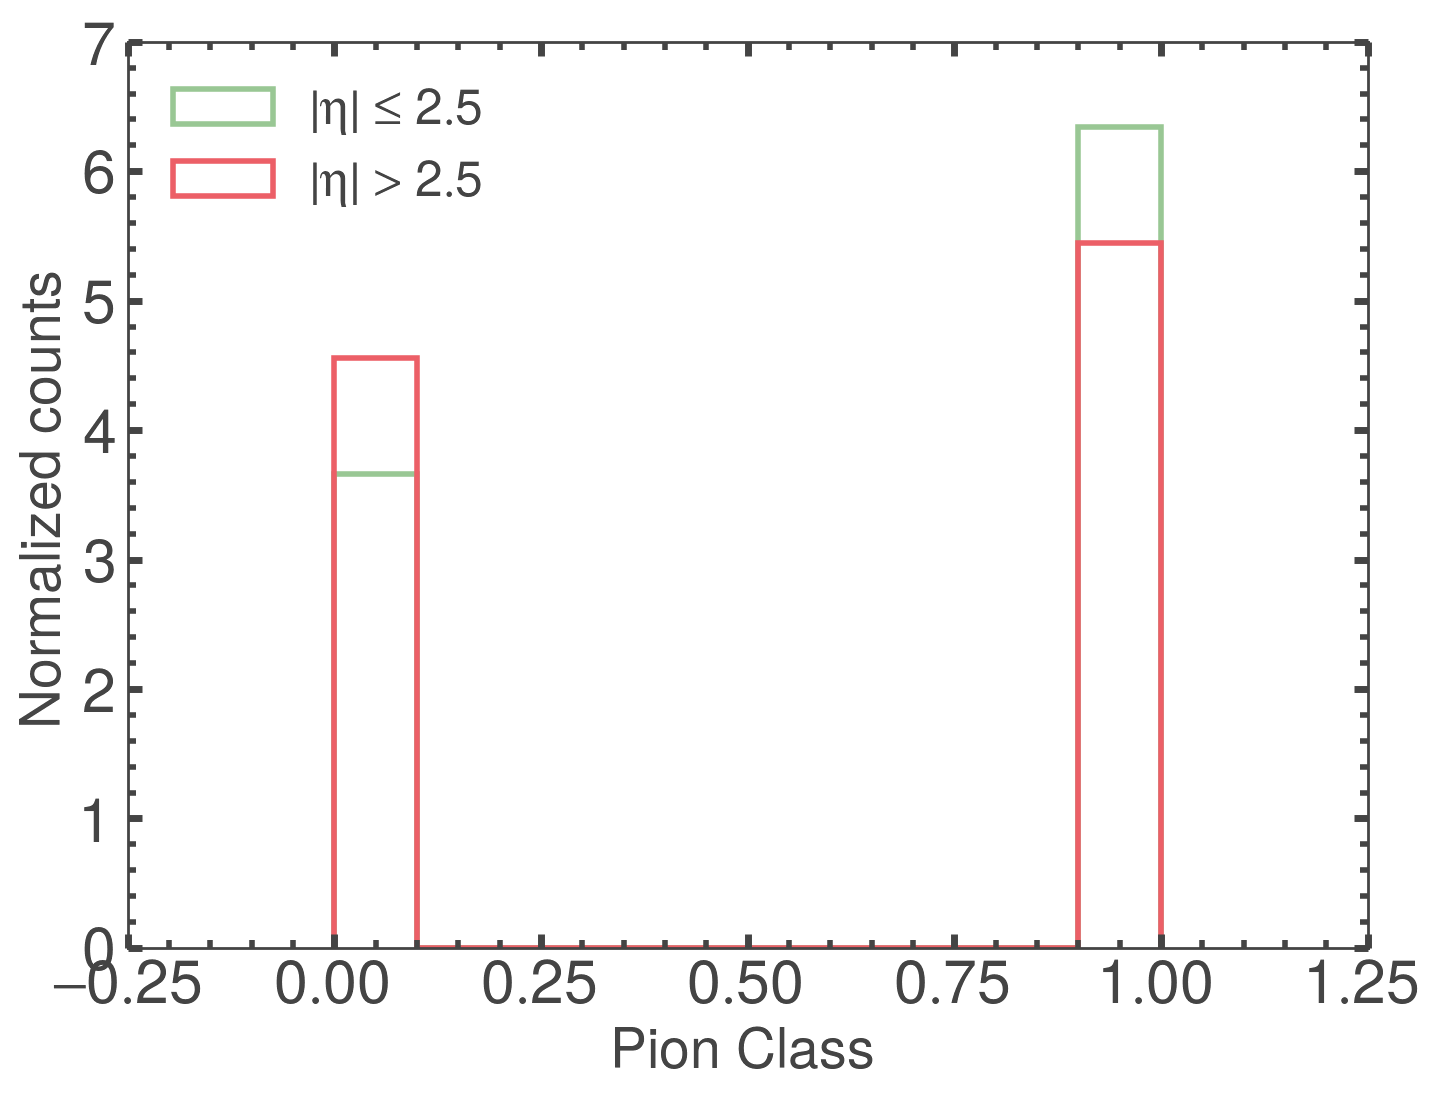

In [60]:
plt.hist(df[np.abs(df.eta) <= 2.5].targets_class, 
         histtype="step", linewidth=2, density=True, label=r"$|\eta| \leq 2.5$");
plt.hist(df[np.abs(df.eta) > 2.5].targets_class, 
         histtype="step", linewidth=2, density=True, label=r"$|\eta| > 2.5$");
plt.legend(loc="upper left");
plt.xlabel("Pion Class", fontsize=20);
plt.ylabel("Normalized counts", fontsize=20);

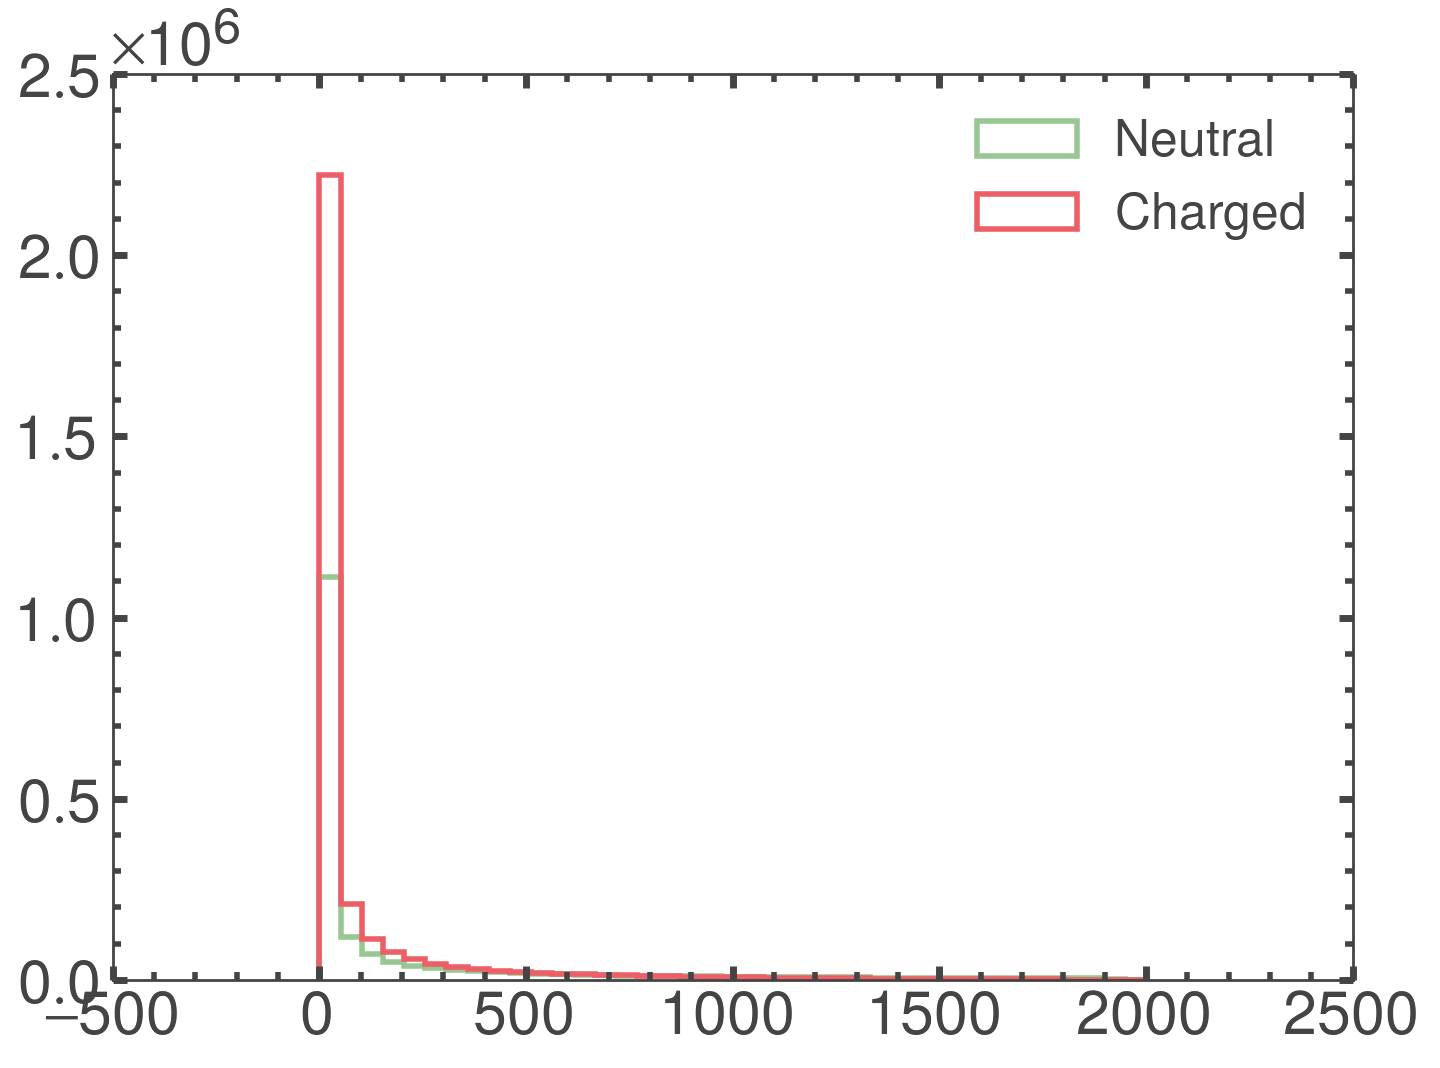

In [42]:
bins=np.linspace(0,2000,40)
plt.hist(df[(df.targets_class == 0) & (np.abs(df.eta) <= 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Neutral");
plt.hist(df[(df.targets_class == 1) & (np.abs(df.eta) <= 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Charged");
plt.legend();

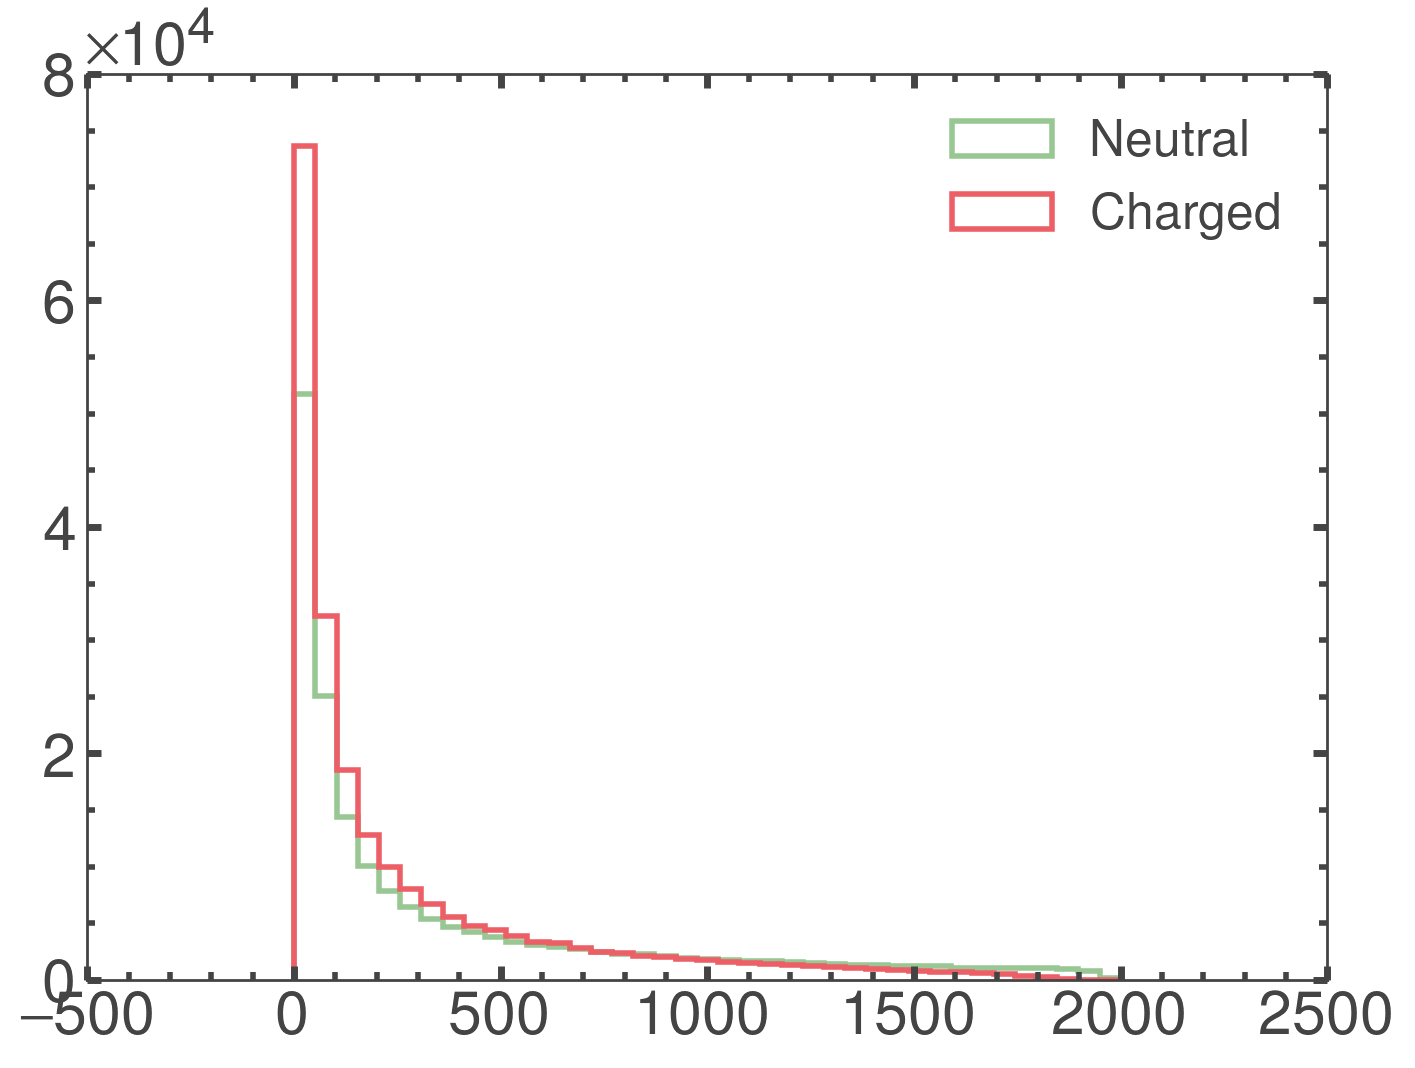

In [43]:
bins=np.linspace(0,2000,40)
plt.hist(df[(df.targets_class == 0) & (np.abs(df.eta) > 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Neutral");
plt.hist(df[(df.targets_class == 1) & (np.abs(df.eta) > 2.5)].energy, 
         bins=bins, density=False, 
         histtype="step", linewidth=2, label="Charged");
plt.legend();

### Make plots

In [17]:
def get_rejection(df, eff=0.9):
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    print("Rejection @ {:.0f}% efficiency: {:.3f}".format(eff*100,1/df_roc[df_roc.tpr > eff].fpr.iloc[0]))
    
def make_classification_plots(df, data_dir=".", save_label="", plot_label="GNN"): 
    ### Bins of energy
    eta_range = "|$\eta$|$<3$"
    plt.figure(figsize=(6,5))
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[df.energy < 1].targets_class, 
                                      df[df.energy < 1].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(df.energy > 1) & (df.energy < 10)].targets_class, 
                                      df[(df.energy > 1) & (df.energy < 10)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(df.energy > 10) & (df.energy < 50)].targets_class, 
                                      df[(df.energy > 10) & (df.energy < 50)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[(df.energy > 50) & (df.energy < 500)].targets_class, 
                                      df[(df.energy > 50) & (df.energy < 500)].outputs_class)
    plt.plot(tpr, np.nan_to_num(1/fpr),label = "All energies",)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "50 < $E_{cluster}^{EM}$ $\leq$ 500 GeV",linestyle="dashed")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "10 < $E_{cluster}^{EM}$ $\leq$ 50 GeV",linestyle="dotted")
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "1 < $E_{cluster}^{EM}$ $\leq$ 10 GeV",linestyle="dashdot")
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "$E_{cluster}^{EM}$ $\leq$ 1 GeV")
    plt.xlim(0.5,1)
    plt.yscale('log')
    plt.ylim(0,5000)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    
    ### if GNN
    if save_label == "gnn": 
        plt.legend(loc="lower left", fontsize=9, handlelength=4);
        ampl.plot.draw_atlas_label(0.5,0.95, status='prelim', simulation=True, 
                                   desc=r"GNN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
    
    ### if PFN
    elif save_label == "pfn":
        plt.legend(loc="upper right", fontsize=9, handlelength=4);
        ampl.plot.draw_atlas_label(0.05,0.18, status='prelim', simulation=True, 
                               desc=r"DeepSets/PFN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
        
    plt.savefig(data_dir+'/'+save_label+'_energy_bins.png', bbox_inches='tight')
    plt.savefig(data_dir+'/'+save_label+'_energy_bins.pdf', bbox_inches='tight')
    
    # ### Bins of eta
    plt.figure(figsize=(6,5))
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[np.abs(df.eta) < 0.8].targets_class, 
                                      df[np.abs(df.eta) < 0.8].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].targets_class, 
                                      df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].targets_class, 
                                      df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[np.abs(df.eta) > 2.5].targets_class, 
                                      df[np.abs(df.eta) > 2.5].outputs_class)
    plt.plot(tpr, np.nan_to_num(1/fpr),label = "All $\eta$ values",)
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "$|\eta|$ $\leq$ 0.8",linestyle="dotted")
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "0.8 < $|\eta|$ $\leq$ 1.37",linestyle="dashdot")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "1.37 < $|\eta|$ $\leq$ 2.5",)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "$|\eta|$ > 2.5",linestyle="dashed")
    plt.xlim(0.7,1)
    plt.yscale('log')
    plt.ylim(0,1000)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    ### if GNN
    if save_label == "gnn": 
        plt.legend(loc="lower left", fontsize=11, handlelength=4);
        ampl.plot.draw_atlas_label(0.5,0.95, status='prelim', simulation=True, 
                                   desc=r"GNN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
    ### if PFN
    elif save_label == "pfn":
        plt.legend(loc="upper right", fontsize=11, handlelength=4);
        ampl.plot.draw_atlas_label(0.05,0.2, status='prelim', simulation=True, 
                               desc=r"DeepSets/PFN Classification of $\pi^{\pm}$ vs. $\pi^0$ "+"\n"+"Single Pion MC, Topo-clusters, "+eta_range)
    plt.savefig(data_dir+'/'+save_label+'_eta_bins.png', bbox_inches='tight')
    plt.savefig(data_dir+'/'+save_label+'_eta_bins.pdf', bbox_inches='tight')

In [ ]:
get_rejection(df_pfn[np.abs(df_pfn.eta)<0.7])

In [ ]:
get_rejection(df)

/tmp/ipykernel_1367/2355428882.py:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, np.nan_to_num(1/fpr),label = "All energies",)
/tmp/ipykernel_1367/2355428882.py:20: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "50 < $E_{cluster}^{EM}$ $\leq$ 500 GeV",linestyle="dashed")
/tmp/ipykernel_1367/2355428882.py:21: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "10 < $E_{cluster}^{EM}$ $\leq$ 50 GeV",linestyle="dotted")
/tmp/ipykernel_1367/2355428882.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "1 < $E_{cluster}^{EM}$ $\leq$ 10 GeV",linestyle="dashdot")
/tmp/ipykernel_1367/2355428882.py:23: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "$E_{cluster}^{EM}$ $\leq$ 1 GeV")
/clusterfs/ml4hep/mpet

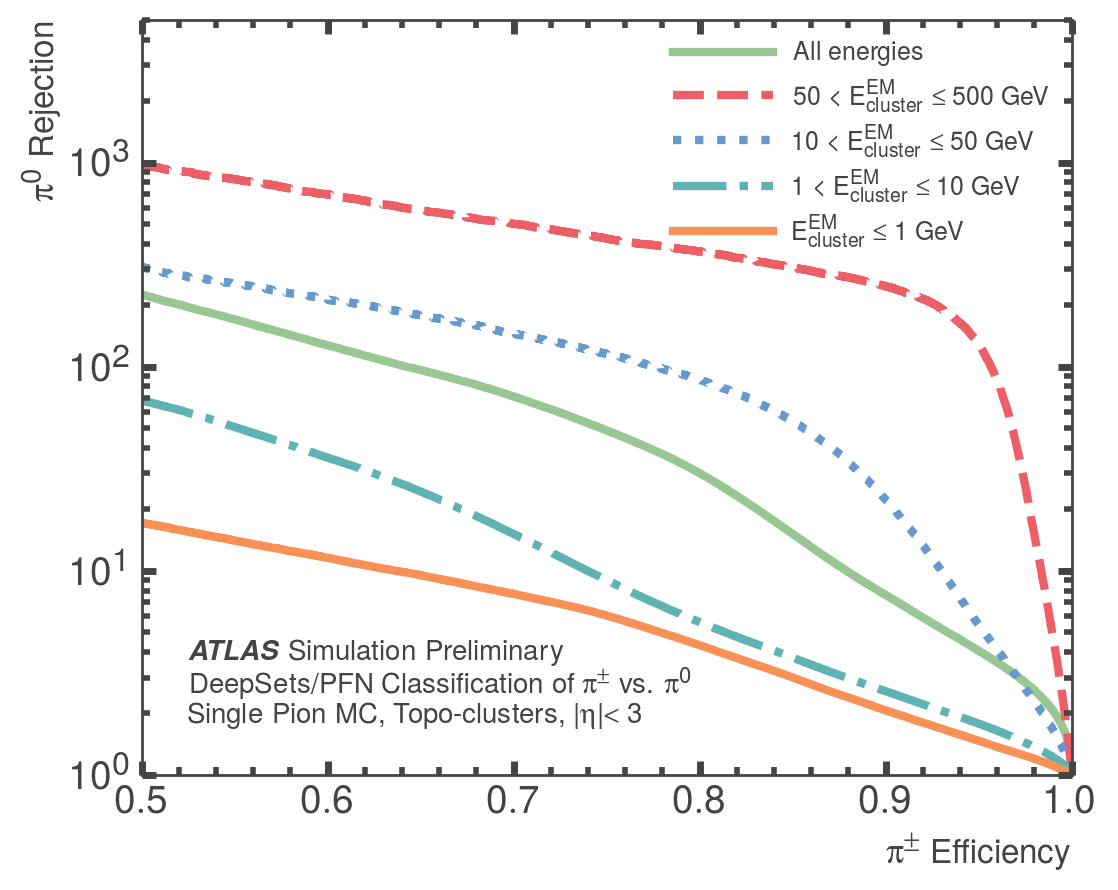

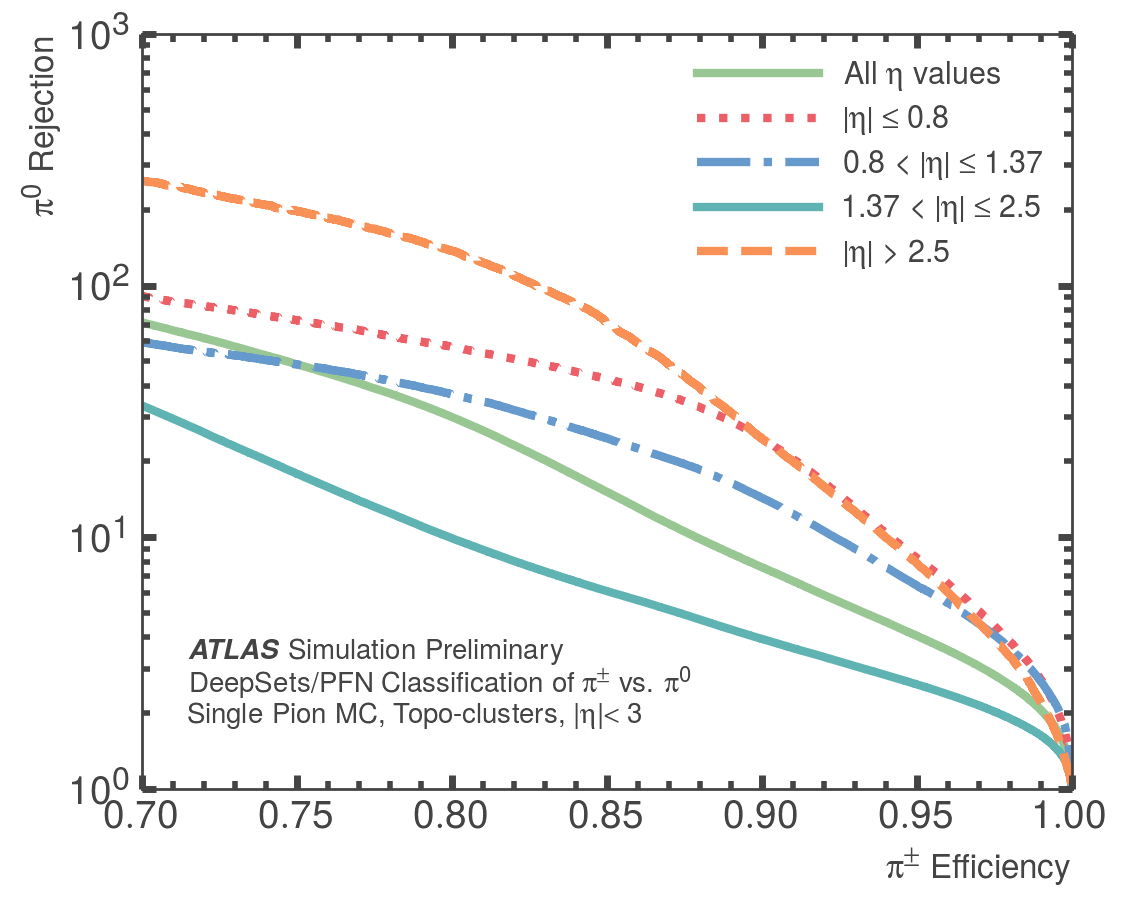

In [18]:
make_classification_plots(df_pfn, 
                          data_dir="./pub_note_results", 
                          save_label="pfn", 
                          plot_label="DeepSets/PFN")

/tmp/ipykernel_1367/2355428882.py:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, np.nan_to_num(1/fpr),label = "All energies",)
/tmp/ipykernel_1367/2355428882.py:20: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "50 < $E_{cluster}^{EM}$ $\leq$ 500 GeV",linestyle="dashed")
/tmp/ipykernel_1367/2355428882.py:21: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "10 < $E_{cluster}^{EM}$ $\leq$ 50 GeV",linestyle="dotted")
/tmp/ipykernel_1367/2355428882.py:22: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "1 < $E_{cluster}^{EM}$ $\leq$ 10 GeV",linestyle="dashdot")
/tmp/ipykernel_1367/2355428882.py:23: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "$E_{cluster}^{EM}$ $\leq$ 1 GeV")
/clusterfs/ml4hep/mpet

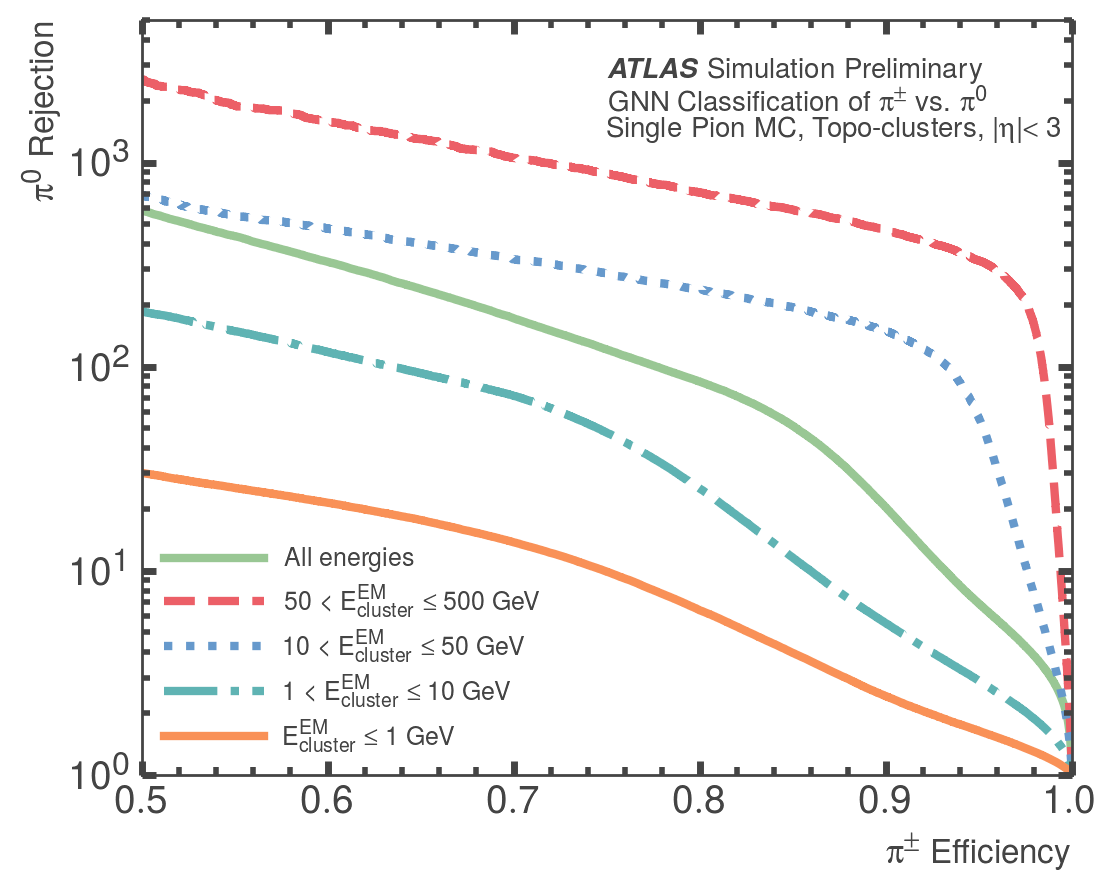

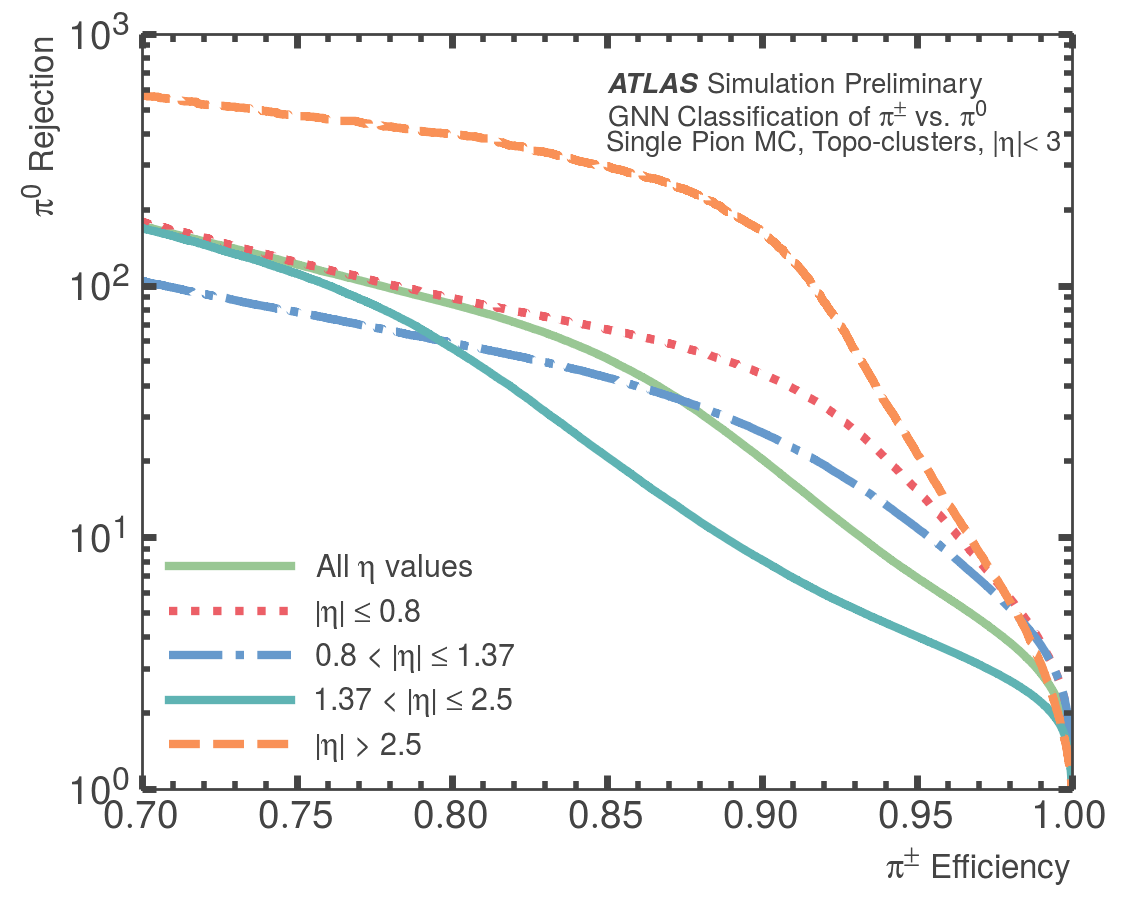

In [19]:
make_classification_plots(df, 
                          data_dir="./pub_note_results", 
                          save_label="gnn", 
                          plot_label="GNN")

In [ ]:
def make_class_comparison_plot(df, df_pfn, df_cnn=None, data_dir="."): 
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_em_prob, tpr_em_prob, _ = roc_curve(df[df.em_prob > 0].targets_class, 1-df[df.em_prob > 0].em_prob)
    fpr_pfn, tpr_pfn, _ = roc_curve(df_pfn.targets_class, df_pfn.outputs_class)
    if df_cnn is not None:
        fpr_cnn, tpr_cnn, _ = roc_curve(df_cnn.targets_class, df_cnn.outputs_class)
        cnn_rejection_ratios = []
   
    gnn_rejection_ratios = []
    pfn_rejection_ratios = []
    for i in tqdm(tpr_em_prob):
        em_prob_rejection = np.nan_to_num(1/np.mean(fpr_em_prob[np.where(tpr_em_prob==i)]))
        gnn_closest_index = tpr[np.argmin(np.abs(tpr-i))]
        gnn_rejection = np.nan_to_num(1/np.mean(fpr[np.where(tpr==gnn_closest_index)]))
        gnn_rejection_ratios.append(gnn_rejection/em_prob_rejection)
        pfn_closest_index = tpr_pfn[np.argmin(np.abs(tpr_pfn-i))]
        pfn_rejection = np.nan_to_num(1/np.mean(fpr_pfn[np.where(tpr_pfn==pfn_closest_index)]))
        pfn_rejection_ratios.append(pfn_rejection/em_prob_rejection)
        if df_cnn is not None:
            cnn_closest_index = tpr_cnn[np.argmin(np.abs(tpr_cnn-i))]
            cnn_rejection = np.nan_to_num(1/np.mean(fpr_cnn[np.where(tpr_cnn==cnn_closest_index)]))
            cnn_rejection_ratios.append(cnn_rejection/em_prob_rejection)
        
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]}, 
                           figsize=(6,5), 
    #                        constrained_layout=True
                          )
    ax[0].plot(tpr_em_prob, np.nan_to_num(1/fpr_em_prob),linewidth=2, label = r"$\mathcal{P}^{EM}_{clus}$", linestyle="dashed")
    ax[0].plot(tpr_pfn, np.nan_to_num(1/fpr_pfn),linewidth=2, label = "DeepSets/PFN",linestyle="dotted")
    ax[0].plot(tpr, np.nan_to_num(1/fpr),linewidth=2, label = "GNN",)
    if df_cnn is not None:
        ax[0].plot(tpr_cnn, np.nan_to_num(1/fpr_cnn),linewidth=2, label = "CNN",linestyle="dashdot")
    ax[0].set_xlim(0.6,1)
    ax[0].set_yscale('log')
    ax[0].set_ylim(0,1000)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency", fontsize=14);
    ax[0].set_ylabel(r"$\pi^0$ Rejection", fontsize=14);
    if df_cnn is not None: 
        eta_range = "|$\eta$|$<0.7$"
    else:
        eta_range = "|$\eta$|$<3$"
    ax[0].legend(fontsize=11, loc="lower left");
    ax[0].tick_params(labelsize=11)

    ax[1].plot(tpr_em_prob, np.ones(len(tpr_em_prob)), linewidth=2, label = r"$\mathcal{P}^{EM}_{clus}$",linestyle="dashed")
    ax[1].plot(tpr_em_prob, pfn_rejection_ratios, linewidth=2, label = "DeepSets/PFN",linestyle="dotted")
    ax[1].plot(tpr_em_prob, gnn_rejection_ratios,linewidth=2, label = "GNN",)
    if df_cnn is not None:
        ax[1].plot(tpr_em_prob, cnn_rejection_ratios,linewidth=2, label = "CNN",linestyle="dashdot")
    ax[1].set_ylabel(r"Ratio to $\mathcal{P}^{EM}_{clus}$", fontsize=14);
    ax[1].tick_params(labelsize=11)
    ax[1].set_ylim(0,10);
    
    ampl.plot.draw_atlas_label(0.57,0.9,ax=ax[0], status='prelim', simulation=True, 
                               desc=r"Classification of $\pi^{\pm}$ vs. $\pi^0$"+"\n"+"Single Pion MC, Topo-clusters"+"\n"+eta_range)
    if df_cnn is not None:
        save_name = data_dir+'/class_comparison_cnn.png'
        save_name_pdf = data_dir+'/class_comparison_cnn.pdf'
    else:
        save_name = data_dir+'/class_comparison.png'
        save_name_pdf = data_dir+'/class_comparison.pdf'
    plt.savefig(save_name, bbox_inches='tight') # use the "print" style in ampl instead of dpi!!! 
    plt.savefig(save_name_pdf, bbox_inches='tight') # use the "print" style in ampl instead of dpi!!! 

In [ ]:
make_class_comparison_plot(
    df[np.abs(df.eta)<0.7],  # use with df_cnn
    df_pfn[np.abs(df_pfn.eta)<0.7], # use with df_cnn
    df_cnn, 
    data_dir = "./pub_note_results"
)

In [ ]:
make_class_comparison_plot(df,df_pfn, 
                           data_dir = "./pub_note_results"
                          )

In [ ]:
rejections = []
energies = np.linspace(df.energy.min(), df.energy.max(), 25)
for energy in tqdm(energies[:-1]):
    fpr, tpr, _ = roc_curve(df[df.energy > energy].targets_class, df[df.energy > energy].outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    rejections.append(1/df_roc[(df_roc.tpr > 0.95)].fpr.iloc[0])

In [ ]:
plt.plot(energies[:-1], rejections, color="dodgerblue")
plt.xlabel("Cluster Energy [GeV]", fontsize=26)
plt.ylabel("Rejection (1/FPR) at 95% Efficiency", fontsize=26)
# plt.savefig(data_dir+'/rej_95_eff_vs_e.png', dpi=300, bbox_inches='tight')

In [ ]:
fpr_em_prob, tpr_em_prob, _ = roc_curve(df[(df.em_prob > 0) & (np.abs(df.eta) < 0.7)].targets_class, 1-df[(df.em_prob > 0) & (np.abs(df.eta) < 0.7)].em_prob)
df_roc = pd.DataFrame(np.vstack([tpr_em_prob,fpr_em_prob]).T, columns=["tpr","fpr"])
print("Rejection @ {:.0f}% efficiency: {:.3f}".format(0.9*100,1/df_roc[df_roc.tpr > 0.9].fpr.iloc[0]))

In [ ]:
fpr_em_prob, tpr_em_prob, _ = roc_curve(df[(df.em_prob > 0)].targets_class, 1-df[(df.em_prob > 0)].em_prob)
df_roc = pd.DataFrame(np.vstack([tpr_em_prob,fpr_em_prob]).T, columns=["tpr","fpr"])
print("Rejection @ {:.0f}% efficiency: {:.3f}".format(0.9*100,1/df_roc[df_roc.tpr > 0.9].fpr.iloc[0]))

# Cluster-only Regression

### Load data

In [ ]:
### EM & LCW Calibrations
pred_file = 'results/no_cuts_clusters_and_tracks_hadweight/full_dataset_20220316/predictions.npz' # no tracks
predictions = np.load(pred_file)
targets_regress = predictions['targets'][:, 0]
outputs_regress = predictions['outputs'][:, 0]
targets_class = predictions['targets'][:, 1] # cluster only
outputs_class = predictions['outputs'][:, 1] # cluster only
energies = predictions['energies']
etas = predictions['etas']
em_probs = predictions['em_probs']
cluster_calib_e = predictions['cluster_calib_es']
cluster_had_weight = predictions['cluster_had_weights']

df_em_lcw = pd.DataFrame(np.vstack(
    [  targets_regress, outputs_regress, 
        targets_class, outputs_class, # cluster only
        energies, etas, em_probs, 
        cluster_calib_e, cluster_had_weight, 
    ]).T, columns = [
                     "targets_regress", "outputs_regress", 
                     "targets_class", "outputs_class",
                     "energy", "eta", "em_prob", "cluster_calib_e", "cluster_had_weight", 
                           ])

In [ ]:
### East Bay GNN w/ clusters only 
pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining.npz' # better at regression

predictions = np.load(pred_file, allow_pickle=True)
targets_regress = predictions['cluster_ENG_CALIB_TOT']
targets_class = predictions['pion_type']
outputs_regress = predictions['pred_cluster_ENG_CALIB_TOT']
outputs_class = predictions['pred_prob']
energies = predictions['cluster_ENG_CALIB_TOT']
etas = predictions['cluster_Eta']
em_probs = predictions['cluster_EM_PROBABILITY']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs]).T, 
        columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "energy", "eta", "em_prob"])

df.targets_class = df.targets_class.replace('pion',1)
df.targets_class = df.targets_class.replace('pi0',0)
df.targets_regress = df.targets_regress.astype(float)
df.outputs_regress = df.outputs_regress.astype(float)

In [ ]:
### Cluster-only PFN
russell_clusteronly = np.load('pub_note_results/target_preds_PFN_base_STMCv2--LR_1e-03--BS_1600--EP_200--EV_200000--2022-04-29_CLO.npz')
clusteronly_mean = np.loadtxt('pub_note_results/CLO_50_files_Y_logmean.txt')
df_pfn_clusteronly = pd.DataFrame(np.vstack([np.e**(russell_clusteronly['args'][0,:]+clusteronly_mean), 
                       np.e**(russell_clusteronly['args'][1,:]+clusteronly_mean), 
                       russell_clusteronly['args'][2,:]]).T, 
             columns = ["targets_regress", "outputs_regress", "eta"])
df_pfn_clusteronly["truth_particle_e"] = df_pfn_clusteronly["targets_regress"]


### Make plots

In [ ]:
def make_response_plot(y_true, y_pred, y_ratio, pion_label, f_name=''):
    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN

def make_regression_plots(df, label="", data_dir=".", charged_pions_only=False):
    c_map = sns.color_palette("viridis")

    if charged_pions_only:
        pion_list = ['$\pi^{\pm}$']
        sym_list = ['+-']
        labels = [r'$\pi^{\pm}$']
    else: 
        pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
        sym_list = ['', '0', '+-']
        labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$']
                
    blues = matplotlib.cm.viridis(np.linspace(0,1,20))
    oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

    response_median = []

    print('\nPlotting {}'.format(pion_list[0]))
    y_true =  df.targets_regress
    y_pred = df.outputs_regress
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                            f_name=data_dir+'/regress_'+label+'_all.pdf')
    response_median.append(medRegCNN)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1],
                                                   f_name=data_dir+'/regress_'+label+'_pi0.pdf')
            response_median.append(medRegCNN)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = df.outputs_regress/df.targets_regress
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2],
                                                   f_name=data_dir+'/regress_'+label+'_pion.pdf')
            response_median.append(medRegCNN)

    np.savez(data_dir+'/response_medians_'+label+'.npz', response_median=response_median, xcenter=xcenter)
    
    ### Response medians 
    pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
                figfile = data_dir+'/regress_'+label+'_response_medians.pdf',
                y_max=1.2, y_min=.9, 
                   x_min = 0,#.3, 
                   colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $\pi^{\pm}$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

    ### IQR Plots
    iqr = []
    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.targets_regress # df.truth_particle_e
    y_ratio = df.outputs_regress/df.targets_regress
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)
        
    np.savez(data_dir+'/iqr_'+label+'.npz', iqr=iqr, xcenter=xcenter)
    pu.lineOverlay(xcenter=xcenter, lines = iqr,  
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
                y_max = 0.5,  # default = 0.5
                   x_min = 0, #.3,
                linestyles = [
                    'solid', 
                    'solid', 
                    'solid'
                ],  
                atlas_x = 0.5, atlas_y = 0.675, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.575, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.525,  'text': 'Regression Comparison'}],
                  figfile=data_dir+'/regress_'+label+'_iqr.pdf')

In [ ]:
### EM Calib 
calib_energy = df_em_lcw.cluster_calib_e
energy = df_em_lcw.energy

c_map = sns.color_palette("viridis")
pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
sym_list = ['', '0', '+-']
labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$']
blues = matplotlib.cm.viridis(np.linspace(0,1,20))
oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = calib_energy
y_pred = energy # EM calib
y_ratio = y_pred/y_true

xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                        f_name='pub_note_results/regress_clusteronly_em_all.png'
                                       )
response_median.append(medRegCNN)

if "targets_class" in df_em_lcw.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 0].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy # EM calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1], 
                                            f_name='pub_note_results/regress_clusteronly_em_pi0.png'
                                           )
    response_median.append(medRegCNN)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 1].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy # EM calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2], 
                                            f_name='pub_note_results/regress_clusteronly_em_pion.png'
                                           )
    response_median.append(medRegCNN)


np.savez('pub_note_results/response_medians_clusteronly_em.npz', response_median=response_median, xcenter=xcenter)

### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_true/y_pred, statistic='iqrOverMed')
iqr.append(iqr_curr)

if "targets_class" in df_em_lcw.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 0].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy # EM calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_true/y_pred, statistic='iqrOverMed')
    iqr.append(iqr_curr)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 1].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy # EM calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_true/y_pred, statistic='iqrOverMed')
    iqr.append(iqr_curr)
    
pu.lineOverlay(xcenter=xcenter, lines = iqr[:],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 1,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_clusteronly_em_iqr.png')
np.savez('pub_note_results/iqr_clusteronly_em.npz', iqr=iqr, xcenter=xcenter)

In [ ]:
### LCW Calib 
calib_energy = df_em_lcw.cluster_calib_e
energy = df_em_lcw.energy
lcw = df_em_lcw.energy*df_em_lcw.cluster_had_weight

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = calib_energy
y_pred = lcw
y_ratio = y_pred/y_true

xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                        f_name='pub_note_results/regress_clusteronly_lcw_all.png'
                                       )
response_median.append(medRegCNN)

if "targets_class" in df_em_lcw.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 0].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy*df_em_lcw[df_em_lcw.targets_class == 0].cluster_had_weight # LCW calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1], 
                                            f_name='pub_note_results/regress_clusteronly_lcw_pi0.png'
                                           )
    response_median.append(medRegCNN)
    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 1].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy*df_em_lcw[df_em_lcw.targets_class == 1].cluster_had_weight # LCW calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2], 
                                            f_name='pub_note_results/regress_clusteronly_lcw_pion.png'
                                           )
    response_median.append(medRegCNN)

np.savez('./pub_note_results/response_medians_clusteronly_lcw.npz', response_median=response_median, xcenter=xcenter)


### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_true/y_pred, statistic='iqrOverMed')
iqr.append(iqr_curr)

if "targets_class" in df_em_lcw.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 0].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy*df_em_lcw[df_em_lcw.targets_class == 0].cluster_had_weight # LCW calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 1].cluster_calib_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy*df_em_lcw[df_em_lcw.targets_class == 1].cluster_had_weight # LCW calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)

pu.lineOverlay(xcenter=xcenter, lines = iqr[:], 
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 1,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_clusteronly_lcw_iqr.png')
np.savez('pub_note_results/iqr_clusteronly_lcw.npz', iqr=iqr, xcenter=xcenter)

In [ ]:
### GNN Cluster-only 
make_regression_plots(df, 
                      charged_pions_only = False,
                      label="gnn_clusteronly", 
                      # data_dir='./pub_note_results',
                     )

In [ ]:
### PFN Cluster-only 
make_regression_plots(df_pfn_clusteronly, label="pfn_clusteronly", 
                      charged_pions_only=True, 
                      # data_dir='./pub_note_results'
                     )

# Cluster & Track Regression

### Load data

In [2]:
### EM & LCW Calibrations
# pred_file = 'results/onetrack_multicluster/full_dataset_20220608_regress/predictions.npz' # tracks (with sum_energy and sum_lcw) 
pred_file = 'results/onetrack_multicluster/full_dataset_20220712_regress/predictions.npz' # tracks (with sum_lcw = sum_calib_e)
predictions = np.load(pred_file)
targets_regress = predictions['targets'][:, 0]
outputs_regress = predictions['outputs'][:, 0]
energies = predictions['energies']
etas = predictions['etas']
em_probs = predictions['em_probs']
cluster_calib_e = predictions['cluster_calib_es']
cluster_had_weight = predictions['cluster_had_weights']
truth_particle_e = 10**predictions['truth_particle_es']
sum_energies = predictions['sum_cluster_es']
sum_lcw = predictions['sum_lcw_es']
track_pts = predictions['track_pts']
track_etas = predictions['track_etas']

df_em_lcw = pd.DataFrame(np.vstack(
    [
        targets_regress, outputs_regress, 
        energies, 
        etas, 
        em_probs, 
        cluster_calib_e, 
        cluster_had_weight, 
        truth_particle_e, 
        sum_energies,
        sum_lcw,
        track_pts,
        track_etas,
    ]).T, columns = [
                     "targets_regress", "outputs_regress", 
                     "energy", "eta", "em_prob", "cluster_calib_e", "cluster_had_weight", "truth_particle_e",
                      "sum_cluster_e", "sum_lcw_e", "track_pt", "track_eta",
                           ])

In [ ]:
# ### East Bay GNN w/ tracks 
# data_dir = 'results/onetrack_multicluster/full_dataset_20220608_regress/'
# # pred_file = 'results/onetrack_multicluster/full_dataset_20220314/predictions.npz' # full training 1 
# # pred_file = 'results/onetrack_multicluster_hadweight/full_dataset_20220314/predictions.npz' # full training 2 
# # pred_file = 'results/onetrack_multicluster/full_dataset_20220408_regress/predictions.npz' # post-bugfix, w/ track pt
# pred_file = data_dir+'/predictions.npz'
# # pred_file = data_dir+'/predictions.npz' # post-bugfix, w/ track pt
# predictions = np.load(pred_file)
# print(predictions.files)
# targets_regress = predictions['targets'][:, 0]
# outputs_regress = predictions['outputs'][:, 0]

# # targets_class = predictions['targets'][:, 1]
# # outputs_class = predictions['outputs'][:, 1]
# energies = predictions['energies']
# etas = predictions['etas']
# em_probs = predictions['em_probs']
# truth_particle_es = 10**predictions['truth_particle_es']
# truth_particle_pts = predictions['truth_particle_pts']
# track_pts = predictions['track_pts']
# track_etas = predictions['track_etas']
# cluster_calib_e = predictions['cluster_calib_es']
# cluster_had_weight = predictions['cluster_had_weights']

# df = pd.DataFrame(np.vstack(
#     [
# #         targets_class, 
# #         outputs_class, 
#      targets_regress, outputs_regress, 
#         energies, etas, em_probs,
#      truth_particle_es,
#      truth_particle_pts, 
#         track_pts,
#         track_etas,
#         cluster_calib_e, 
#         cluster_had_weight,
#     ]).T, 
#                  columns = [
# #                      "targets_class", 
# #                      "outputs_class", 
#                      "targets_regress", 
#                      "outputs_regress", 
#                      "energy", "eta", "em_prob", 
#                      "truth_particle_e",
#                      "truth_particle_pt", 
#                      "track_pt", "track_eta",
#                      "cluster_calib_e",  "cluster_had_weight",
#                            ])

In [3]:
### Single-track, multi-cluster (PFN as of July 1st 2022)
df_pfn = pd.DataFrame(np.vstack([
    np.load('pub_note_results/PFN_STMC_truth.npy'),
    np.load('pub_note_results/PFN_STMC_predictions.npy'),
]).T,
                      columns = ["targets_regress","outputs_regress"])
df_pfn["truth_particle_e"] = df_pfn["targets_regress"]

In [4]:
### Sanmay
# transformer = np.load('pub_note_results/Attention_Prediction_TRK_Large_1_7_22.npz') # as of June 24
transformer = np.load('pub_note_results/Attention_Prediction_TRK_MarielFile.npz') # as of July 4
df_transformer = pd.DataFrame(np.vstack([transformer['target'],transformer['prediction']]).T, columns=["targets_regress", "outputs_regress"])

### Make plots

In [5]:
def make_response_plot(y_true, y_pred, y_ratio, pion_label, f_name=''):
    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN
    
def make_regression_plots(df, label="", data_dir=".", charged_pions_only=False):
    c_map = sns.color_palette("viridis")

    if charged_pions_only:
        pion_list = ['$\pi^{\pm}$']
        sym_list = ['+-']
        labels = [r'$\pi^{\pm}$']
    else: 
        pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
        sym_list = ['', '0', '+-']
        labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$']
                
    blues = matplotlib.cm.viridis(np.linspace(0,1,20))
    oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

    response_median = []

    print('\nPlotting {}'.format(pion_list[0]))
    y_true =  df.targets_regress
    y_pred = df.outputs_regress
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                            f_name=data_dir+'/regress_'+label+'_all.pdf')
    response_median.append(medRegCNN)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1],
                                                   f_name=data_dir+'/regress_'+label+'_pi0.pdf')
            response_median.append(medRegCNN)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = df.outputs_regress/df.targets_regress
            xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2],
                                                   f_name=data_dir+'/regress_'+label+'_pion.pdf')
            response_median.append(medRegCNN)

    np.savez(data_dir+'/response_medians_'+label+'.npz', response_median=response_median, xcenter=xcenter)
    
    ### Response medians 
    pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
                figfile = data_dir+'/regress_'+label+'_response_medians.pdf',
                y_max=1.2, y_min=.9, 
                   x_min = 0,#.3, 
                   colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $\pi^{\pm}$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

    ### IQR Plots
    iqr = []
    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.targets_regress
    y_ratio = df.outputs_regress/df.targets_regress
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)
    
    if not charged_pions_only:
        if "targets_class" in df.keys():
            print('\nPlotting {}'.format(pion_list[1]))
            y_true = df.targets_regress[df.targets_class==0]
            y_pred = df.outputs_regress[df.targets_class==0]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)

            print('\nPlotting {}'.format(pion_list[2]))
            y_true = df.targets_regress[df.targets_class==1]
            y_pred = df.outputs_regress[df.targets_class==1]
            y_ratio = y_pred/y_true
            xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
            iqr.append(iqr_curr)
        
    np.savez(data_dir+'/iqr_'+label+'.npz', iqr=iqr, xcenter=xcenter)
    pu.lineOverlay(xcenter=xcenter, lines = iqr,  
                labels = labels,
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
                y_max = 0.5,  # default = 0.5
                   x_min = 0, #.3,
                linestyles = [
                    'solid', 
                    'solid', 
                    'solid'
                ],  
                atlas_x = 0.5, atlas_y = 0.675, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.575, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.525,  'text': 'Regression Comparison'}],
                  figfile=data_dir+'/regress_'+label+'_iqr.pdf')

<Figure size 1600x1200 with 0 Axes>

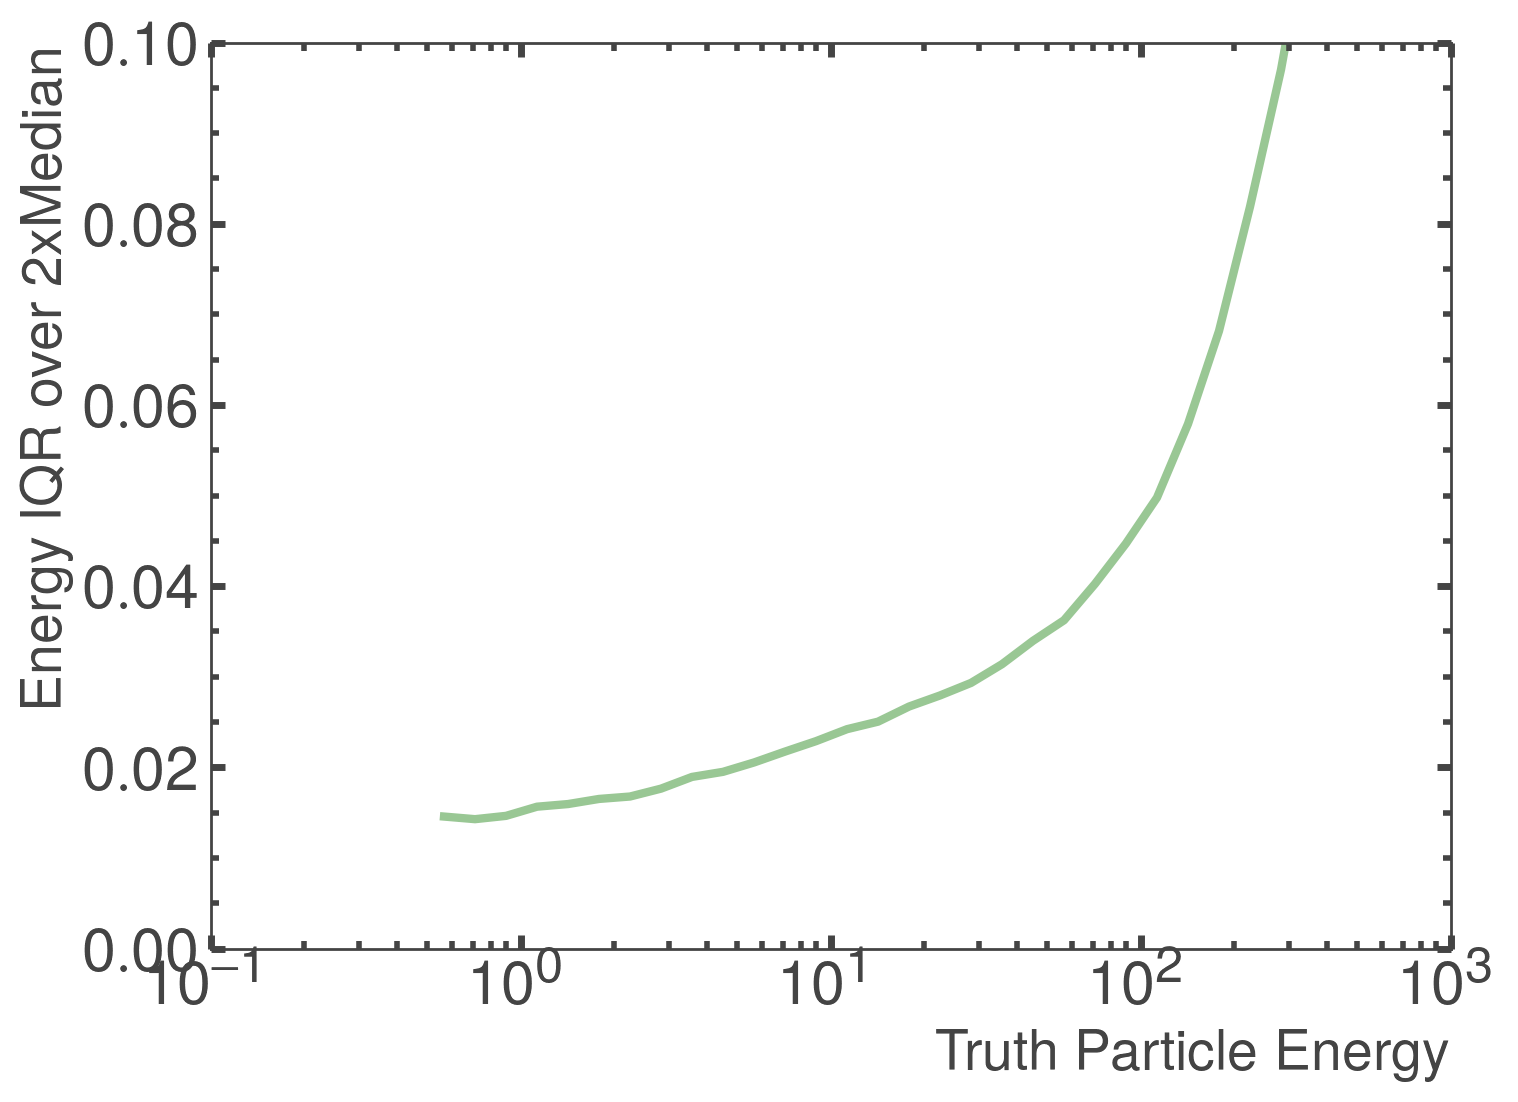


Plotting $\pi^{\pm}$
r2:0.928
PearsonR:0.992, SpearmanR:0.995, MSE:20499.631, MAE:92.571
Saving figure to pub_note_results/regress_em_all.png


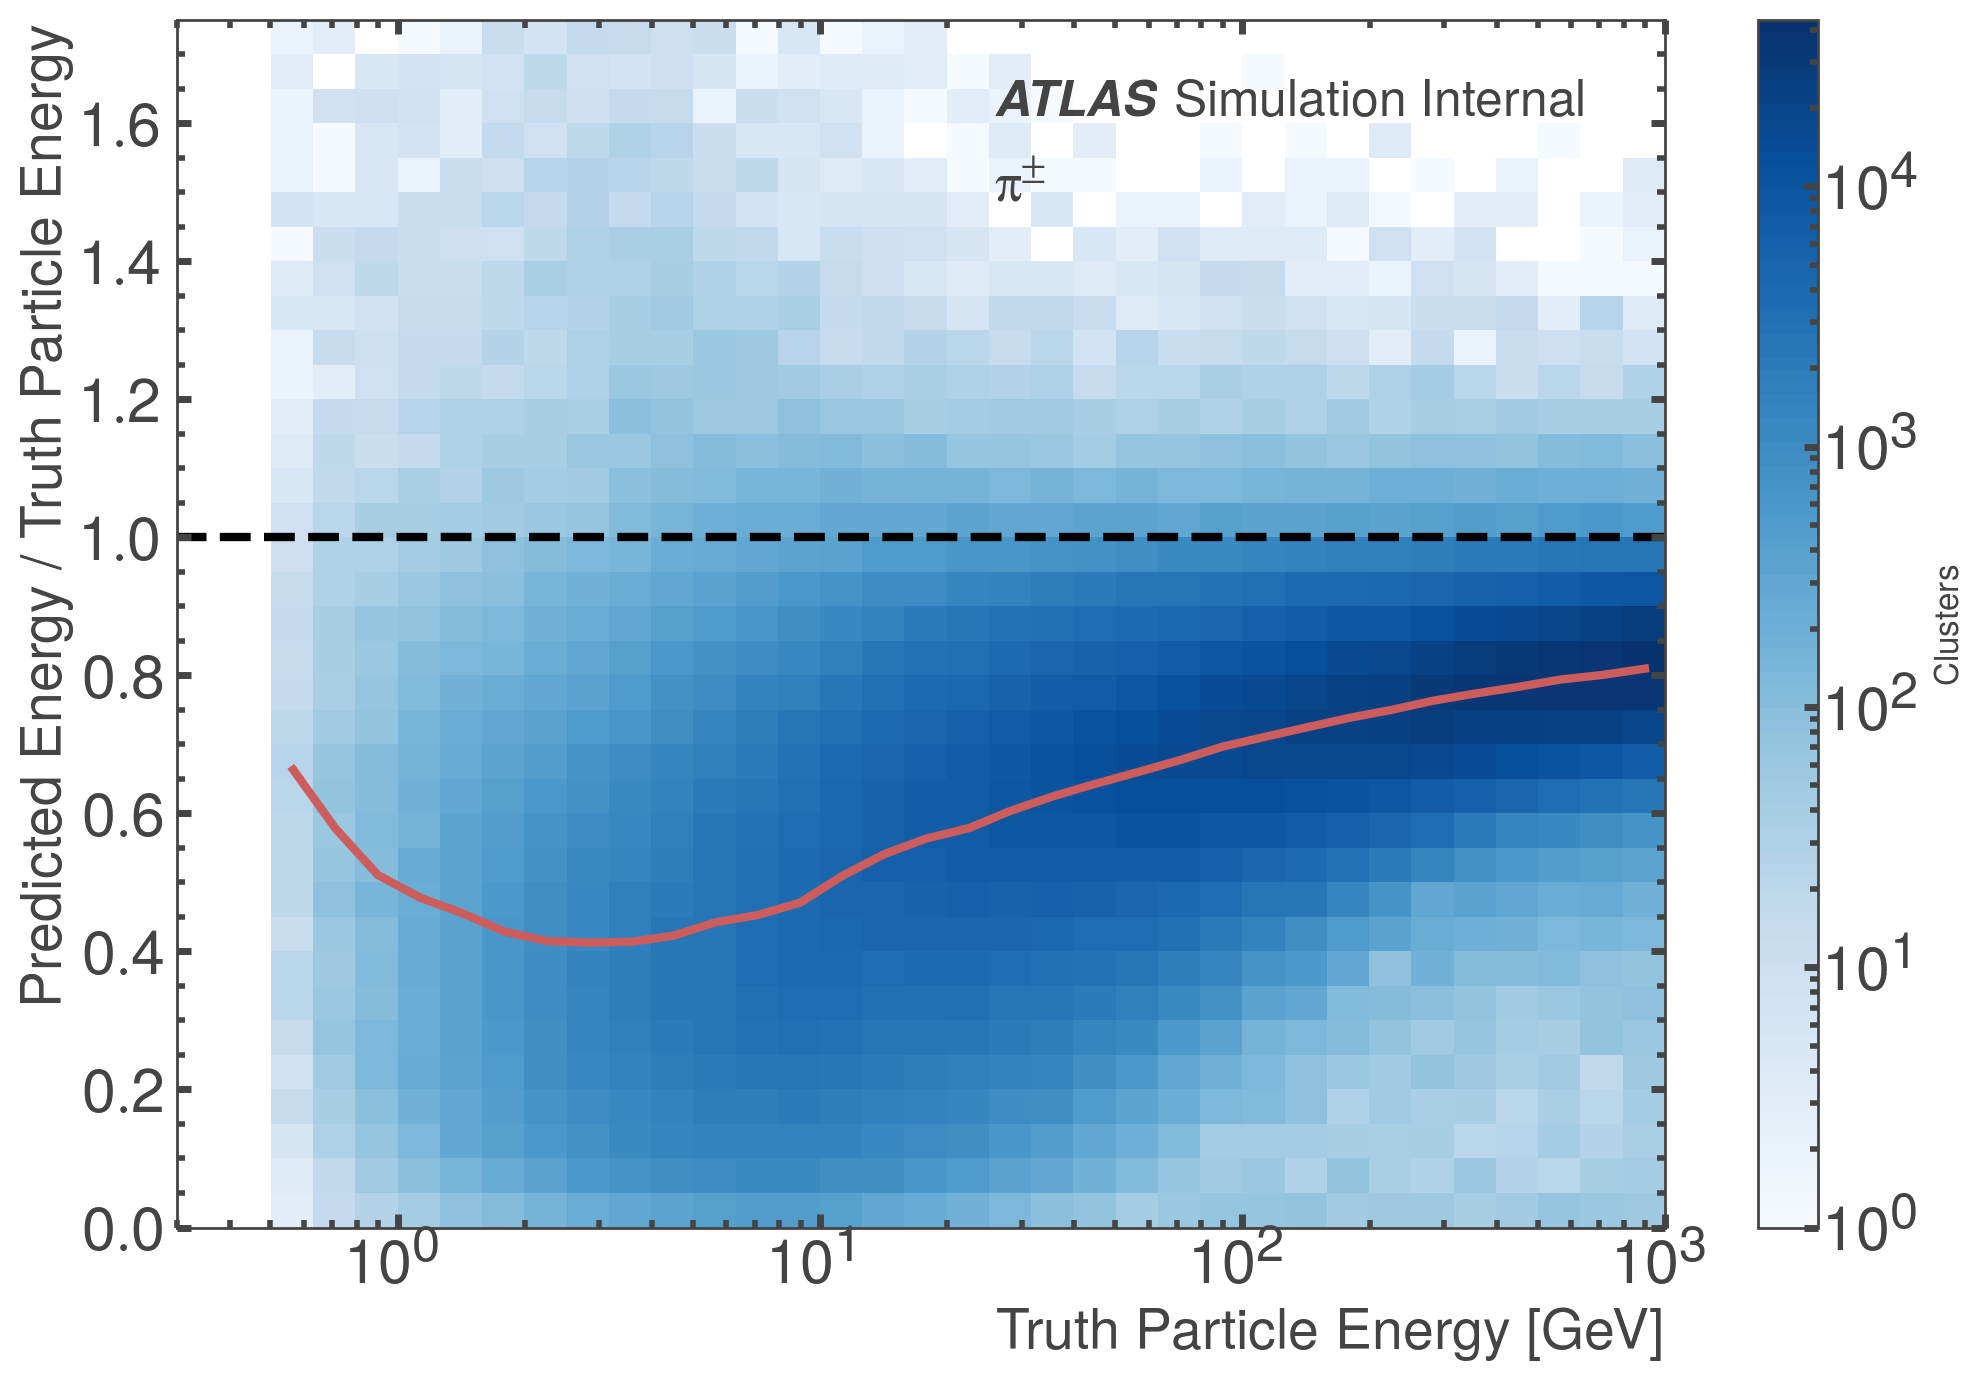


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

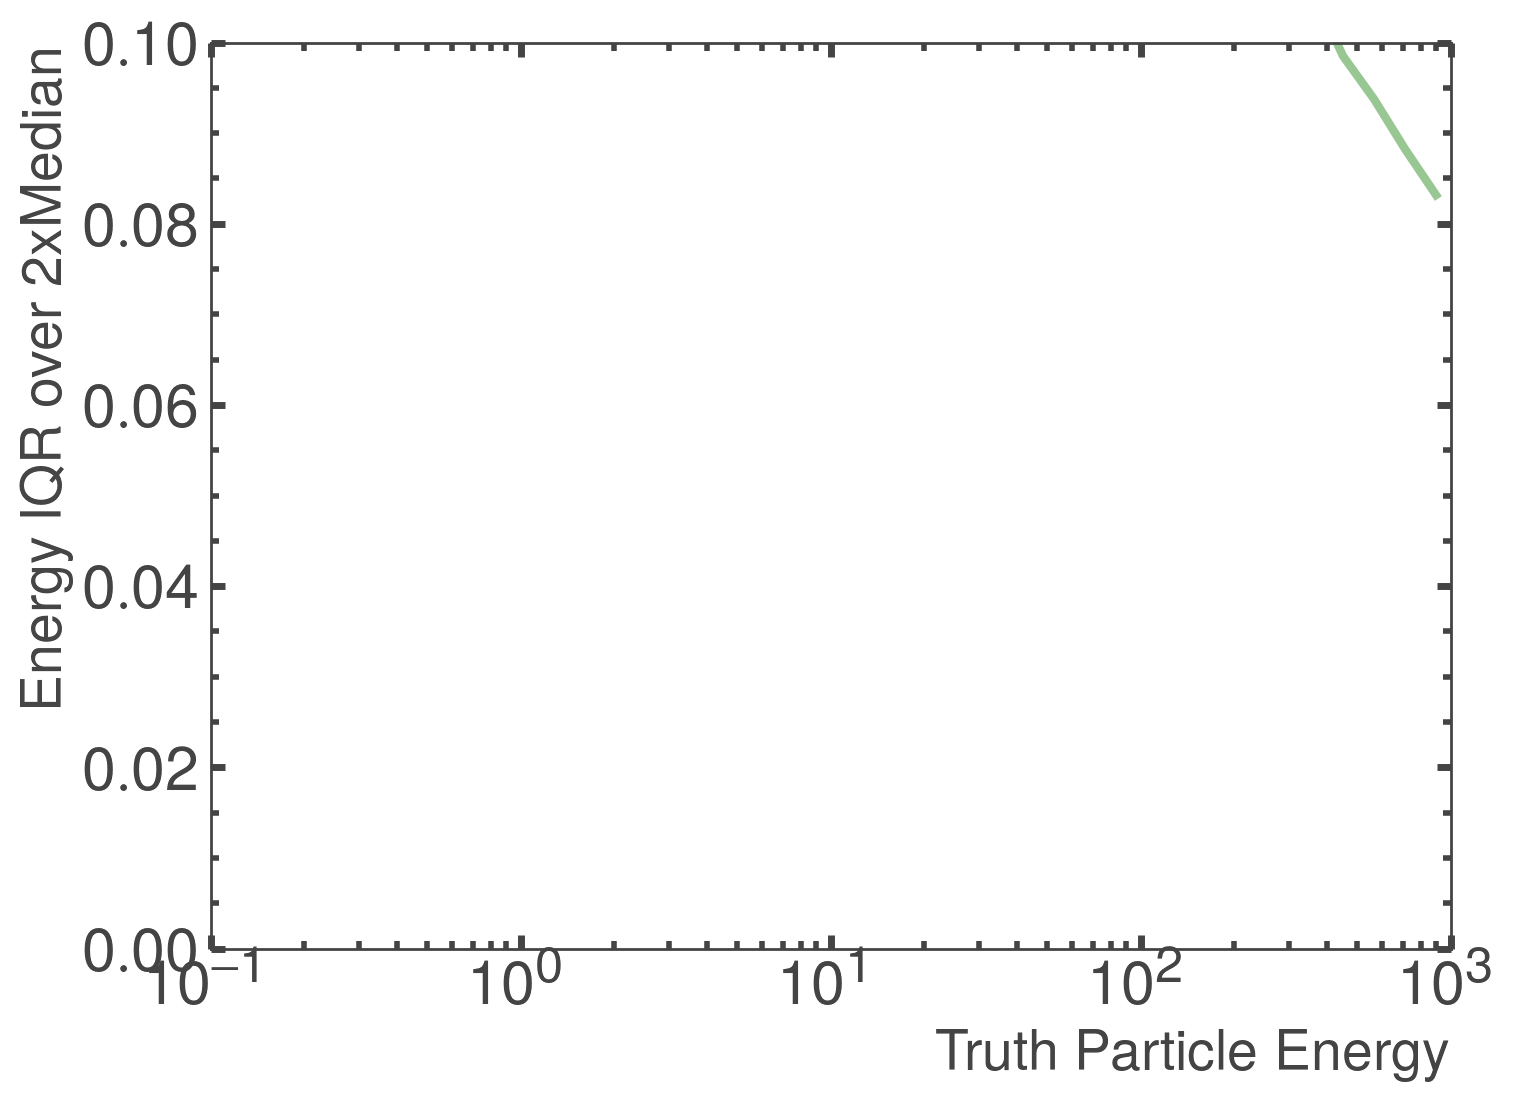

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


<Figure size 1600x1200 with 0 Axes>

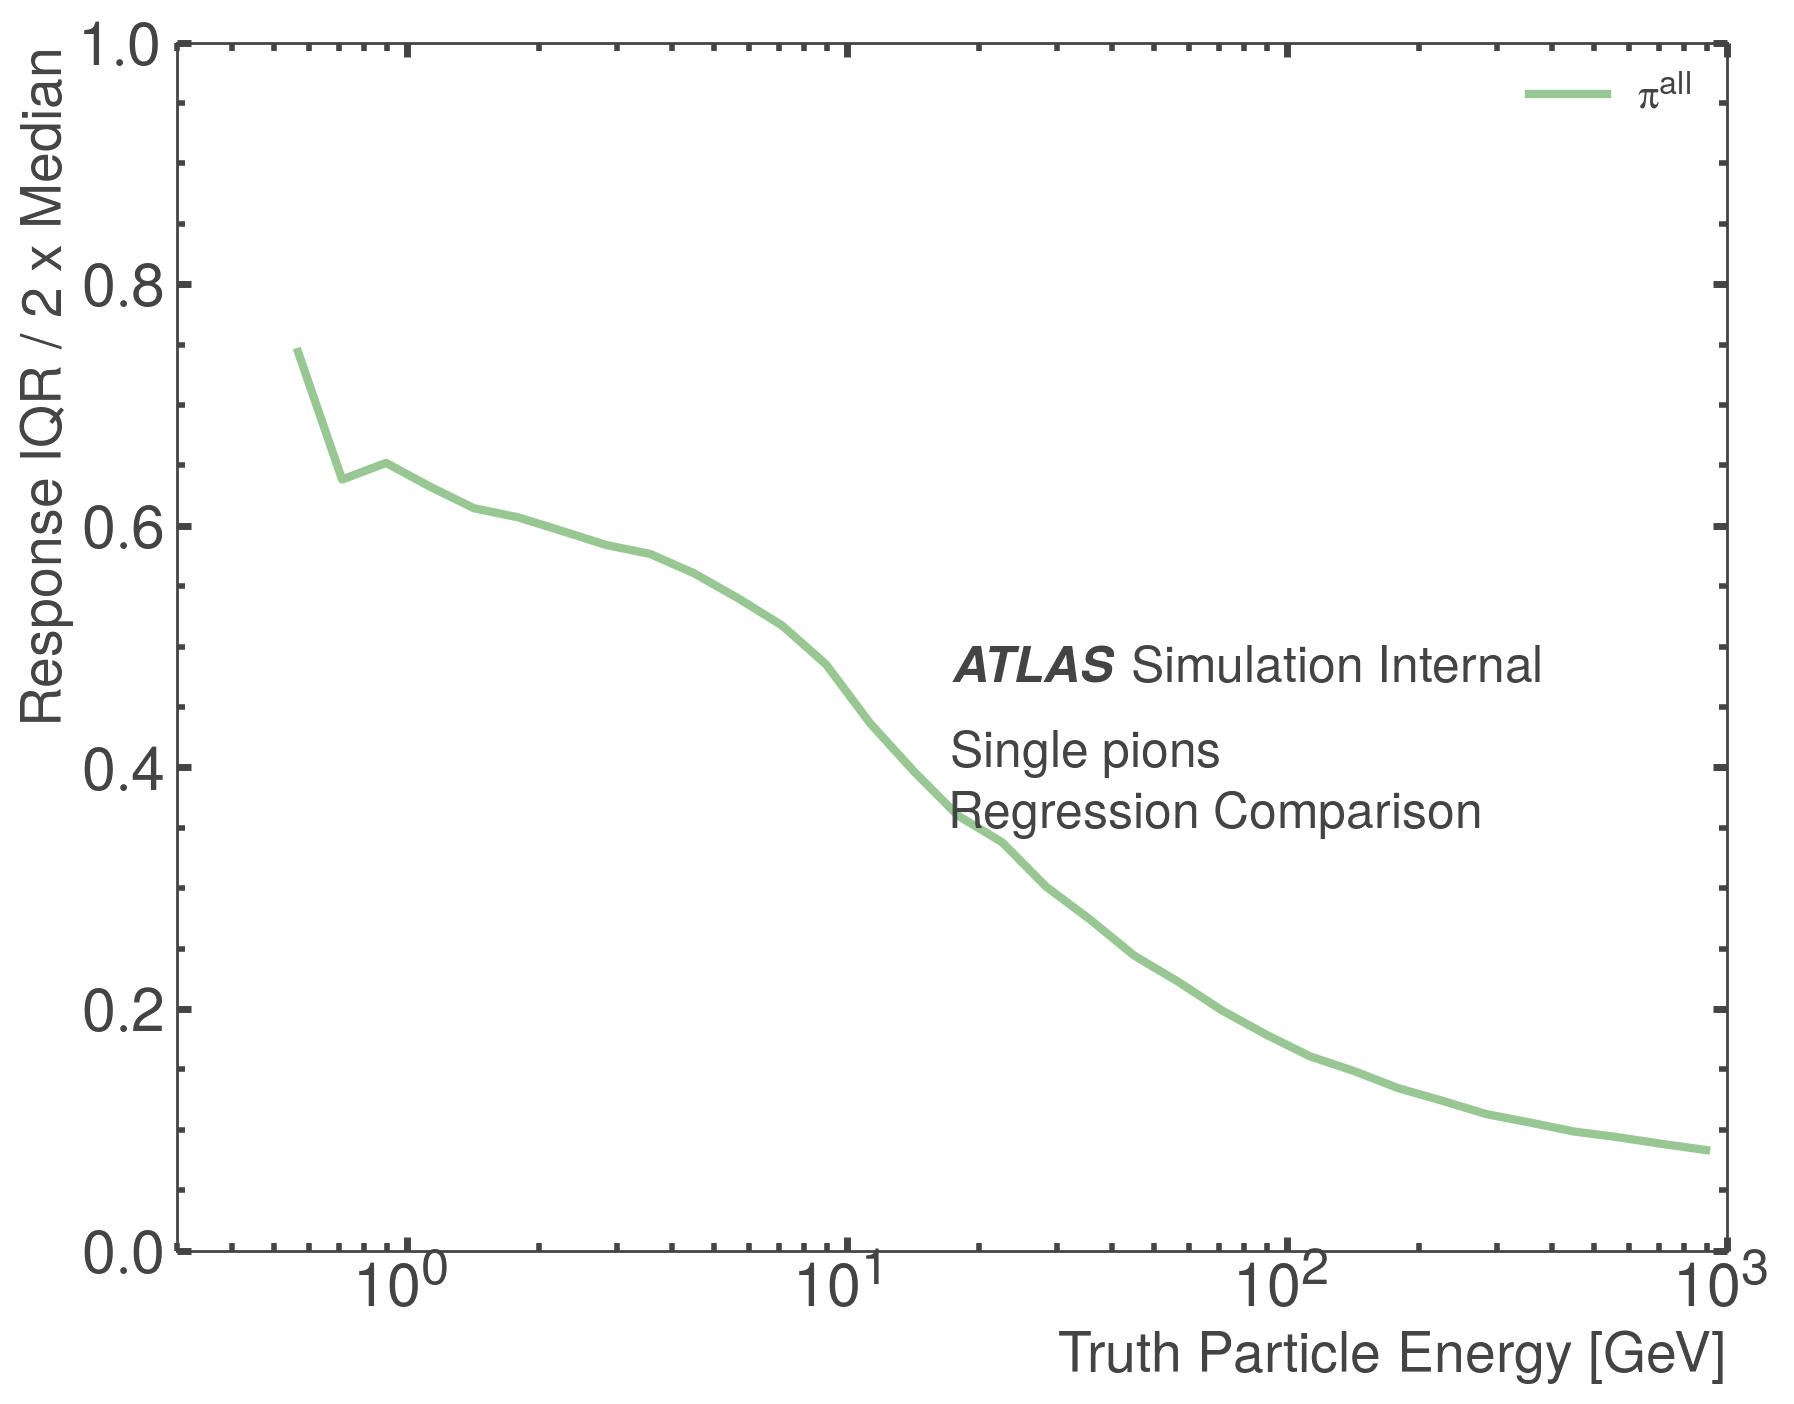


Plotting $\pi^{\pm}$
r2:0.987
PearsonR:0.995, SpearmanR:0.996, MSE:3654.610, MAE:28.522
Saving figure to pub_note_results/regress_lcw_all.png


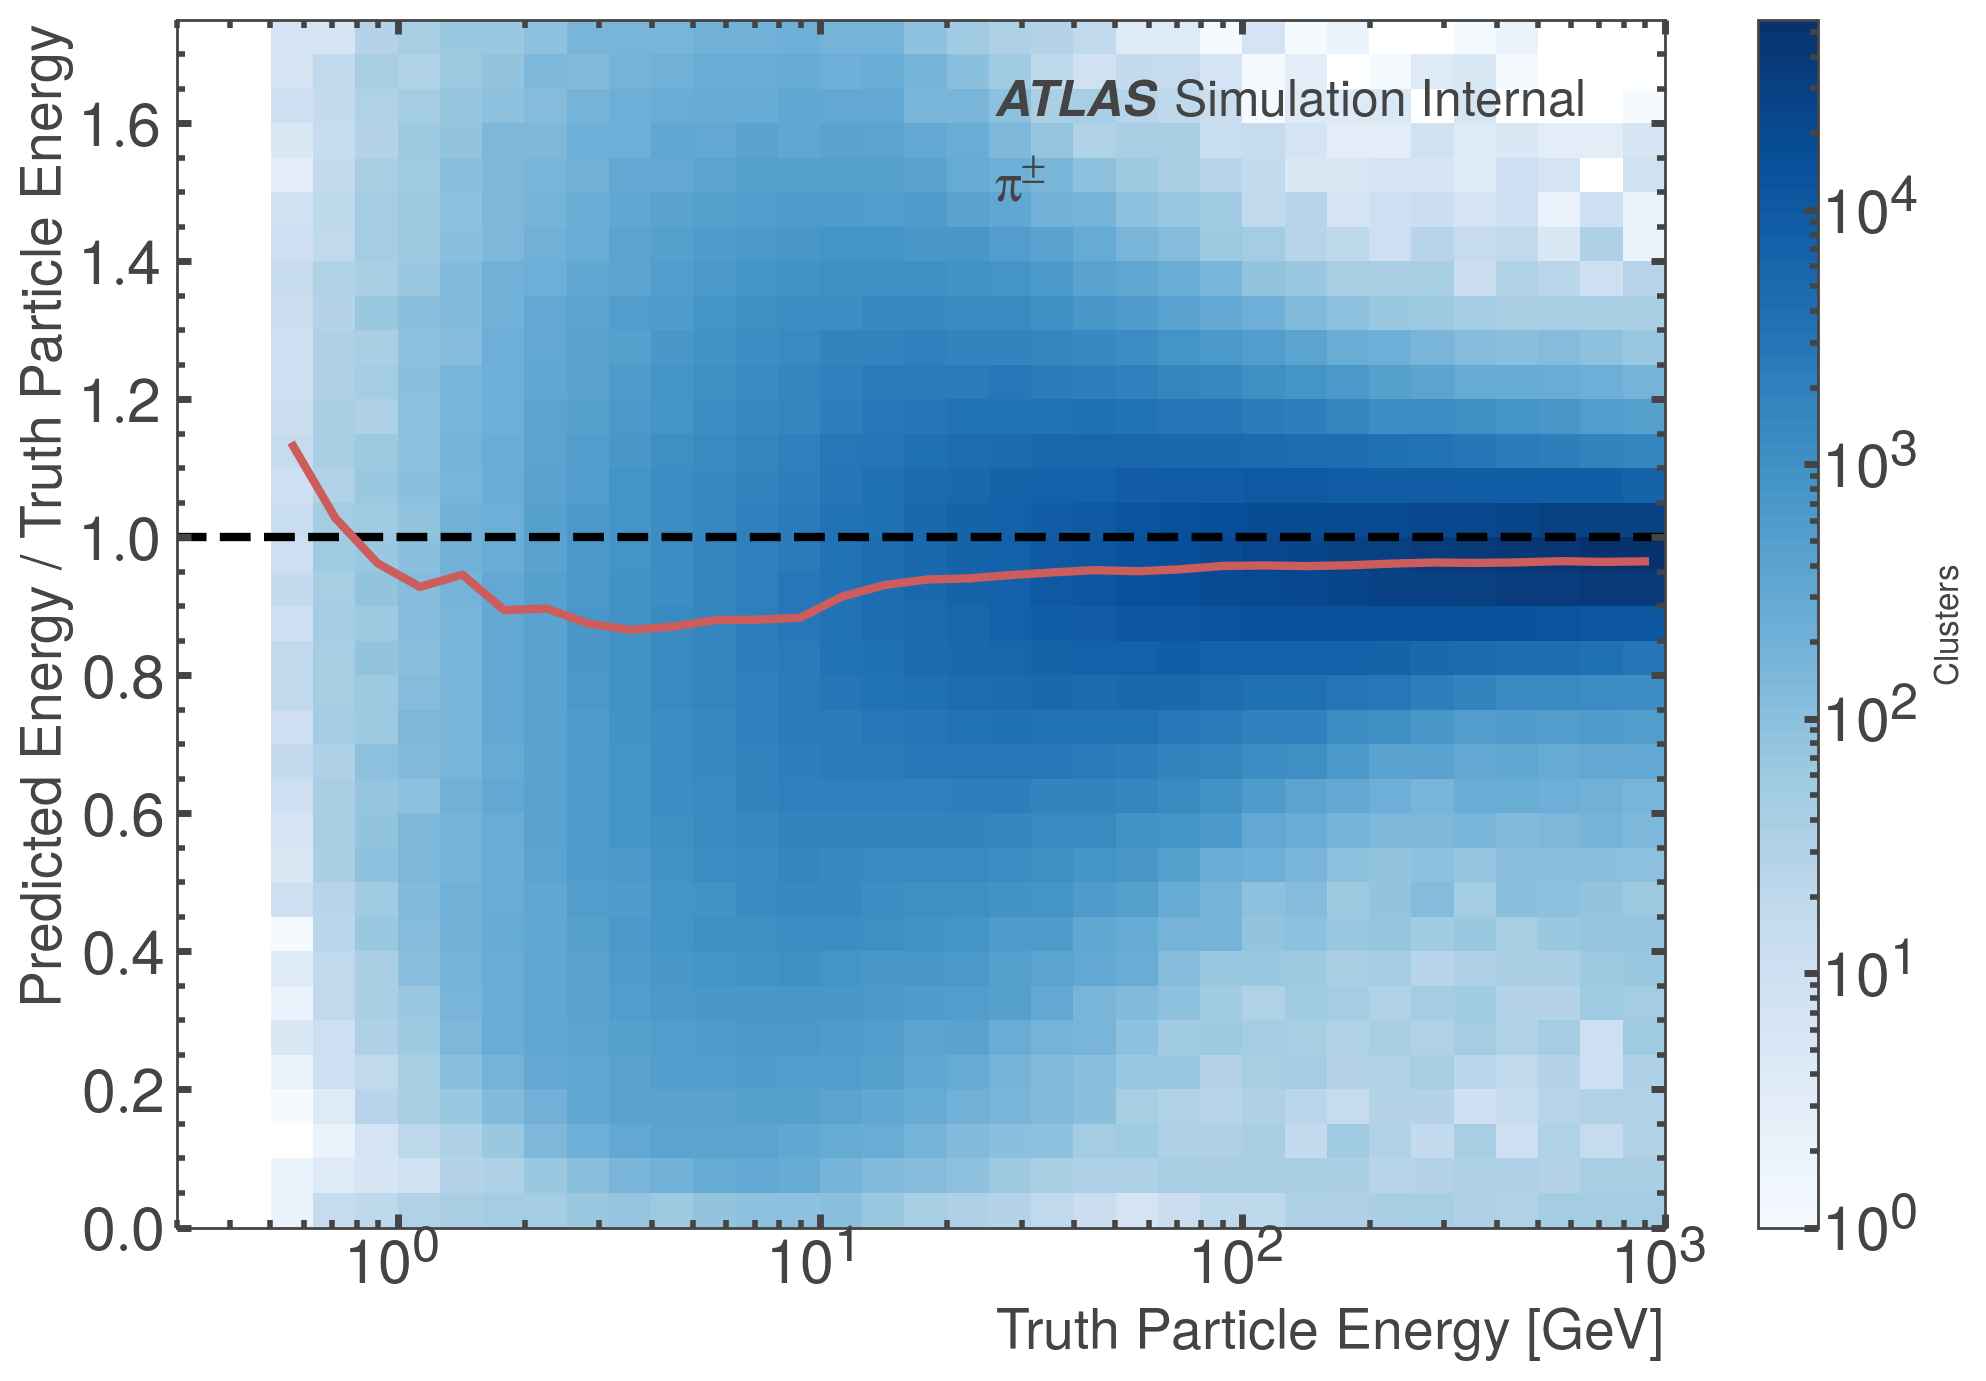


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

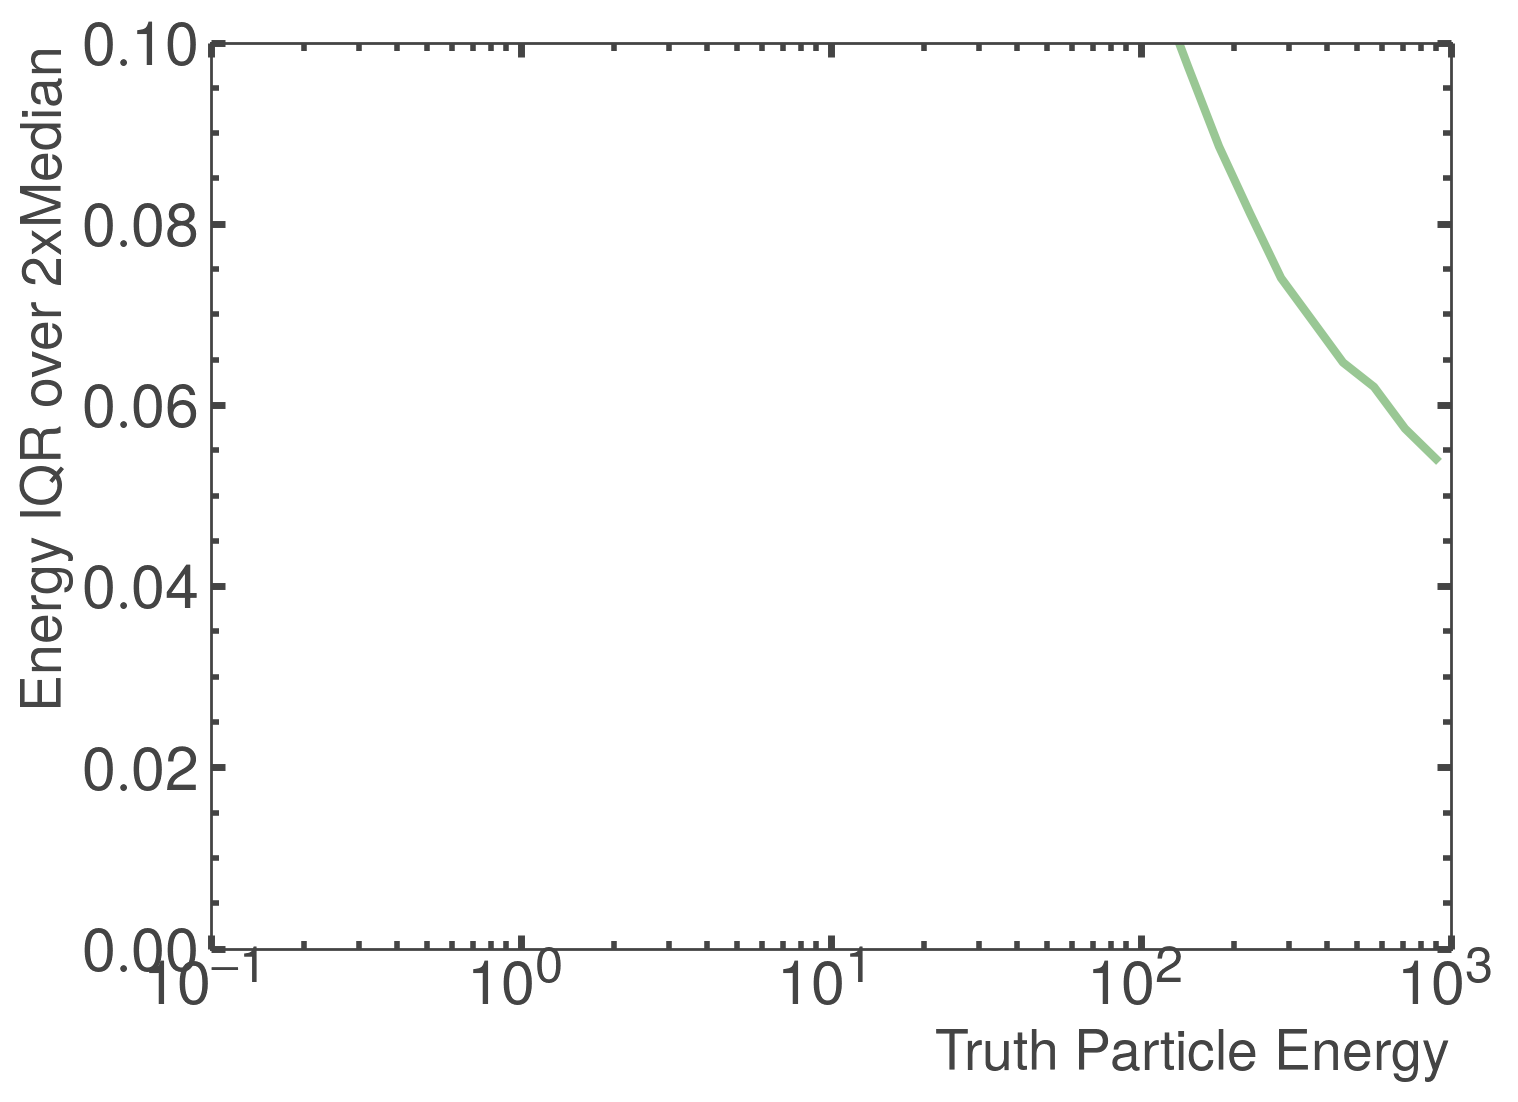

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


<Figure size 1600x1200 with 0 Axes>

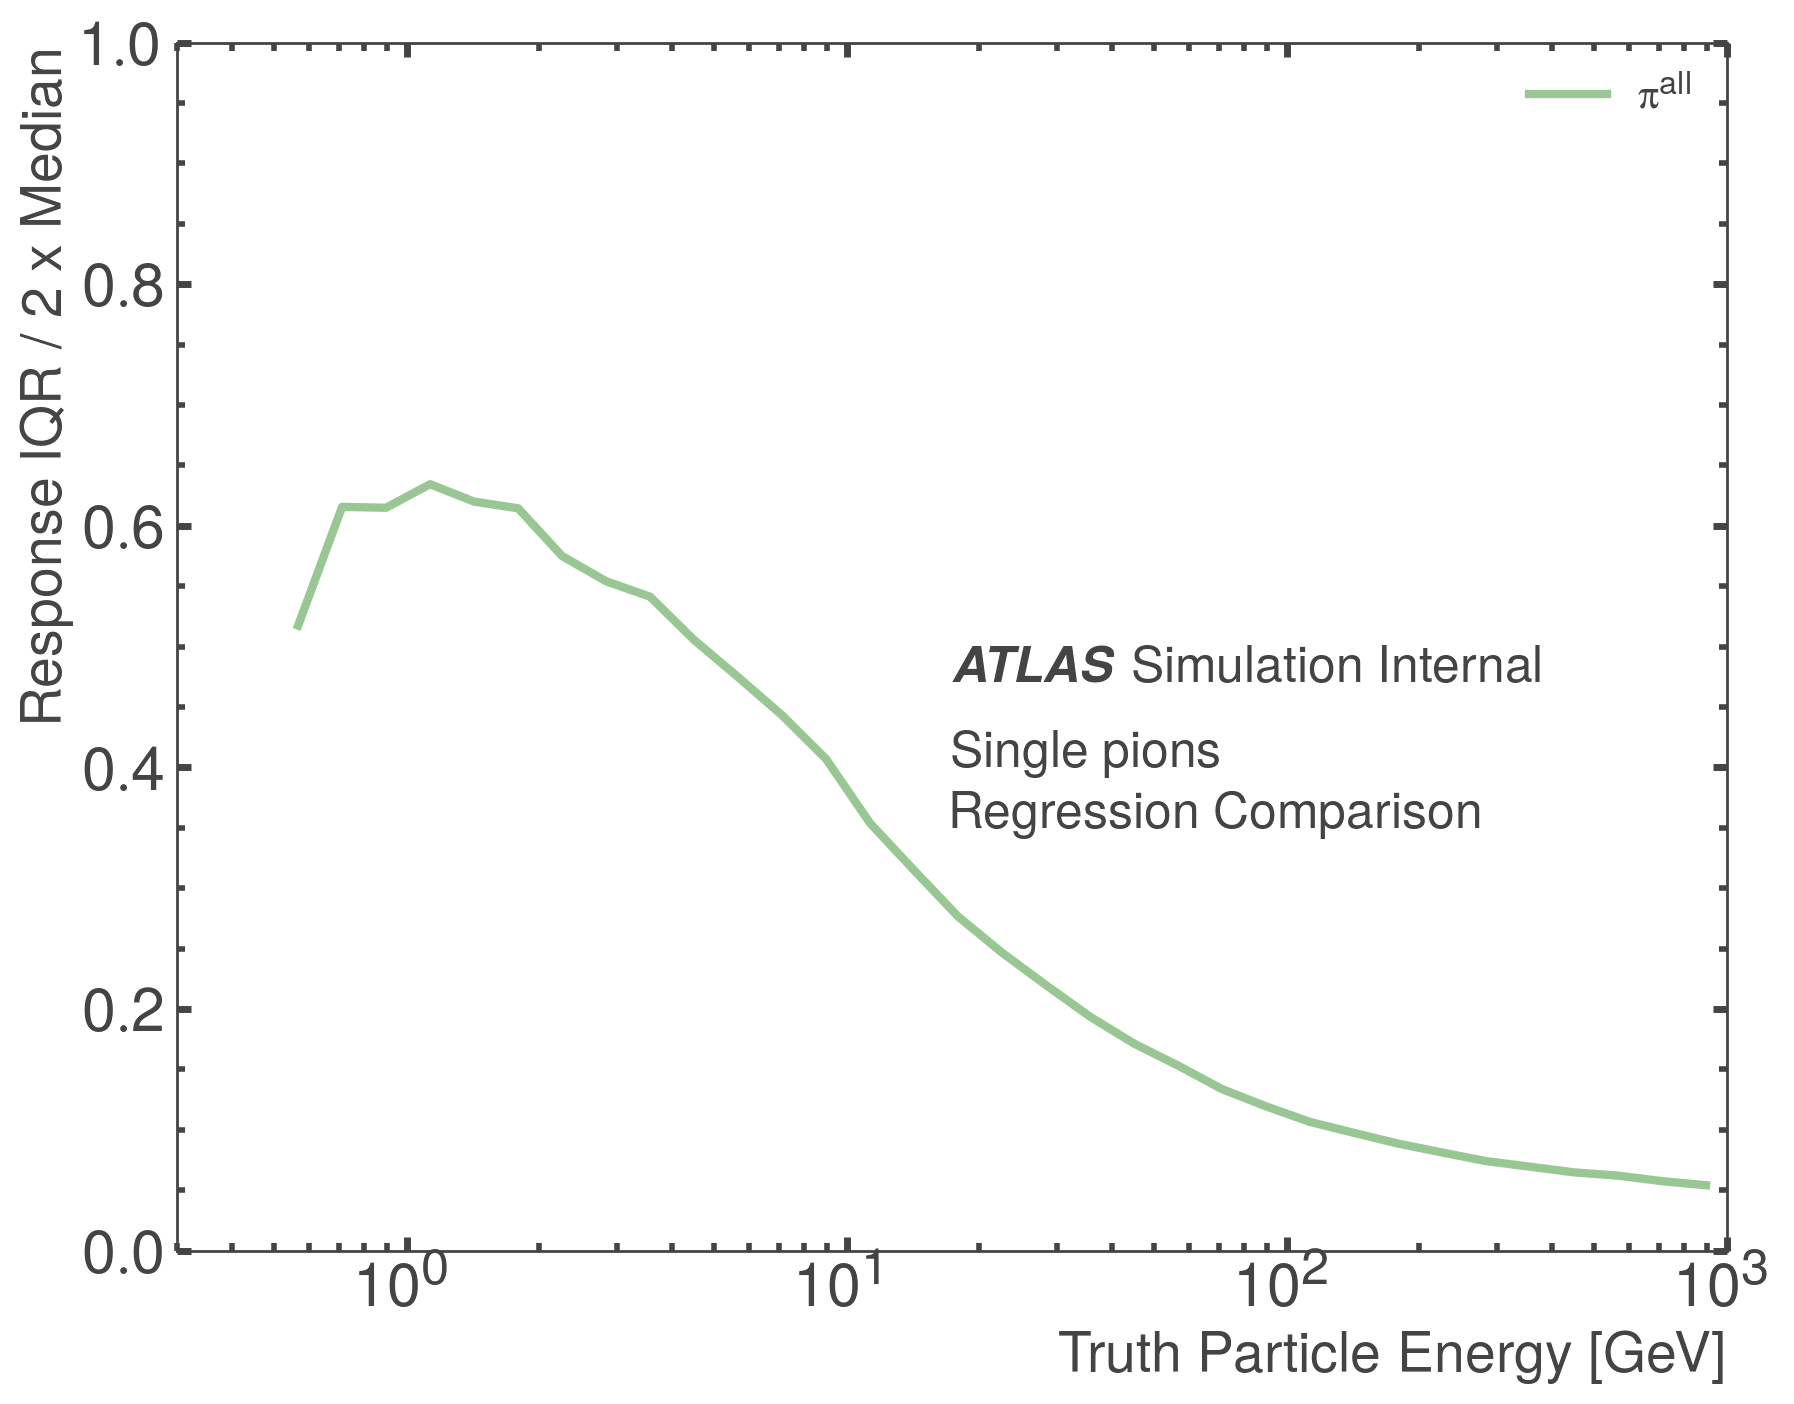

In [7]:
### EM & LCW with tracks 
truth_particle_e = df_em_lcw.truth_particle_e
calib_energy = df_em_lcw.cluster_calib_e
energy = df_em_lcw.energy
lcw = df_em_lcw.energy*df_em_lcw.cluster_had_weight
sum_cluster_e = df_em_lcw.sum_cluster_e
sum_lcw_e = df_em_lcw.sum_lcw_e

### Track resolution 
xcenter, iqr_track = ru.resolutionPlot(df_em_lcw.truth_particle_e, 
                                       (10**df_em_lcw. track_pt)*np.cosh(df_em_lcw.track_eta)/df_em_lcw.truth_particle_e,
                                       statistic='iqrOverMed')
np.savez('pub_note_results/iqr_track.npz', iqr=iqr_track, xcenter=xcenter)

### EM Calib 
c_map = sns.color_palette("viridis")
pion_list = ['$\pi^{\pm}$']
sym_list = ['+-']
blues = matplotlib.cm.viridis(np.linspace(0,1,20))
oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = truth_particle_e
y_pred = sum_cluster_e # EM calib
y_ratio = y_pred/y_true

xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                        f_name='pub_note_results/regress_em_all.png'
                                       )
response_median.append(medRegCNN)

if "targets_class" in df_em_lcw.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 0].truth_particle_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 0].energy # EM calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[1], 
                                            f_name='pub_note_results/regress_em_pi0.png'
                                           )
    response_median.append(medRegCNN)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df_em_lcw[df_em_lcw.targets_class == 1].truth_particle_e
    y_pred = df_em_lcw[df_em_lcw.targets_class == 1].energy # EM calib
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[2], 
                                            f_name='pub_note_results/regress_em_pion.png'
                                           )
    response_median.append(medRegCNN)


np.savez('pub_note_results/response_medians_em.npz', response_median=response_median, xcenter=xcenter)

### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)
    
pu.lineOverlay(xcenter=xcenter, lines = iqr[:],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 1,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_em_iqr.png')
np.savez('pub_note_results/iqr_em.npz', iqr=iqr, xcenter=xcenter)


### LCW Calib 
response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = truth_particle_e
y_pred = sum_lcw_e
y_ratio = y_pred/y_true

xcenter, medRegCNN = make_response_plot(y_true, y_pred, y_pred/y_true, pion_list[0], 
                                        f_name='pub_note_results/regress_lcw_all.png'
                                       )
response_median.append(medRegCNN)

np.savez('./pub_note_results/response_medians_lcw.npz', response_median=response_median, xcenter=xcenter)


### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

pu.lineOverlay(xcenter=xcenter, lines = iqr[:], 
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 1,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_lcw_iqr.png')
np.savez('pub_note_results/iqr_lcw.npz', iqr=iqr, xcenter=xcenter)


Plotting $\pi^{\pm}$
r2:0.994
PearsonR:0.997, SpearmanR:0.999, MSE:1216.878, MAE:12.587
Saving figure to ./regress_russell_all.pdf


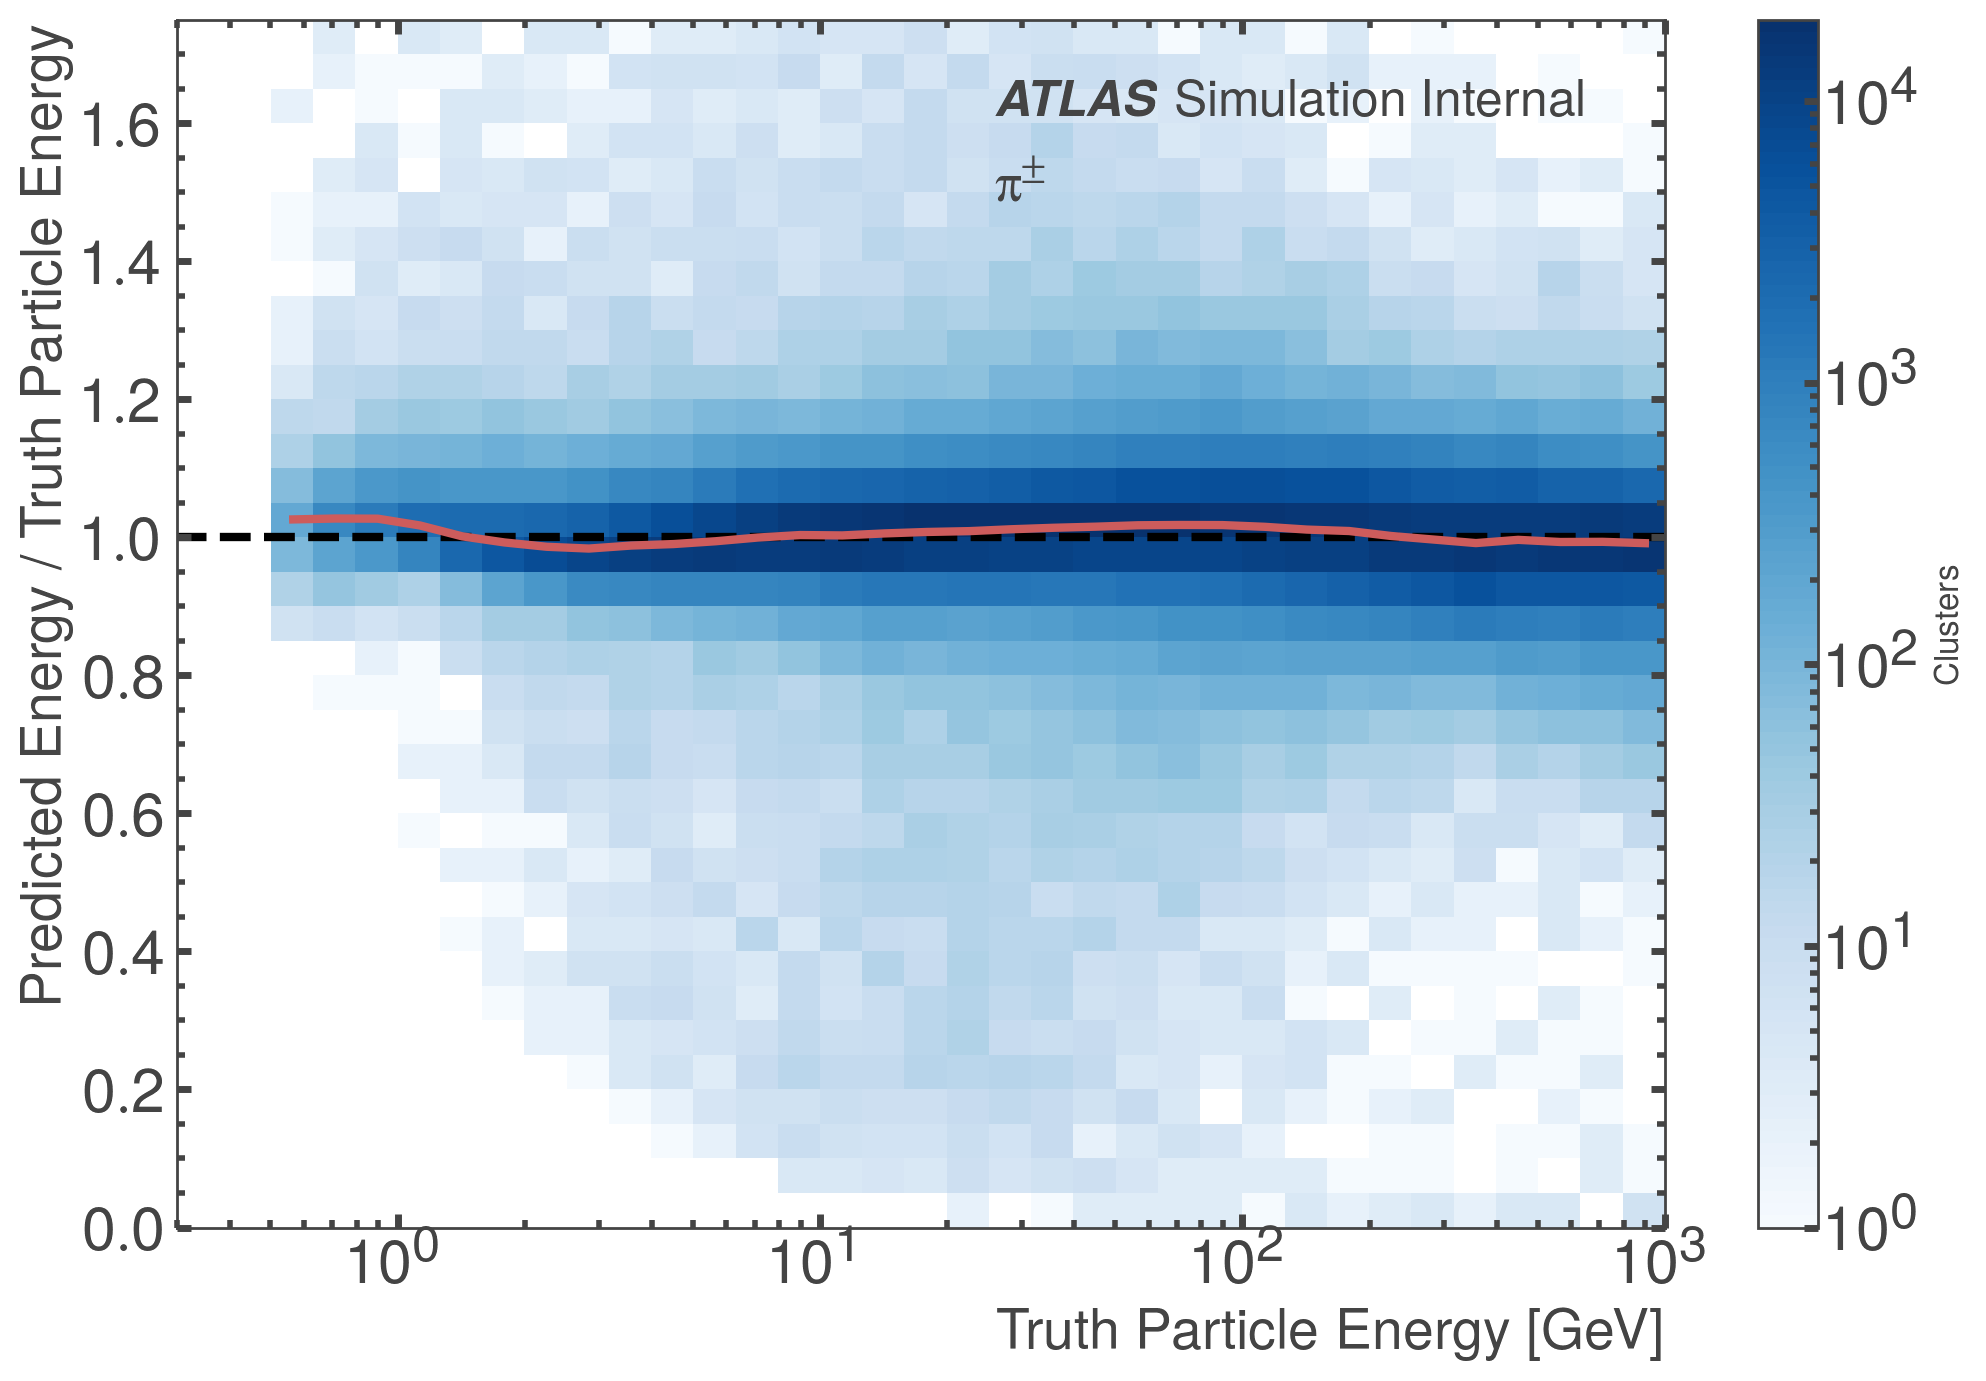

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

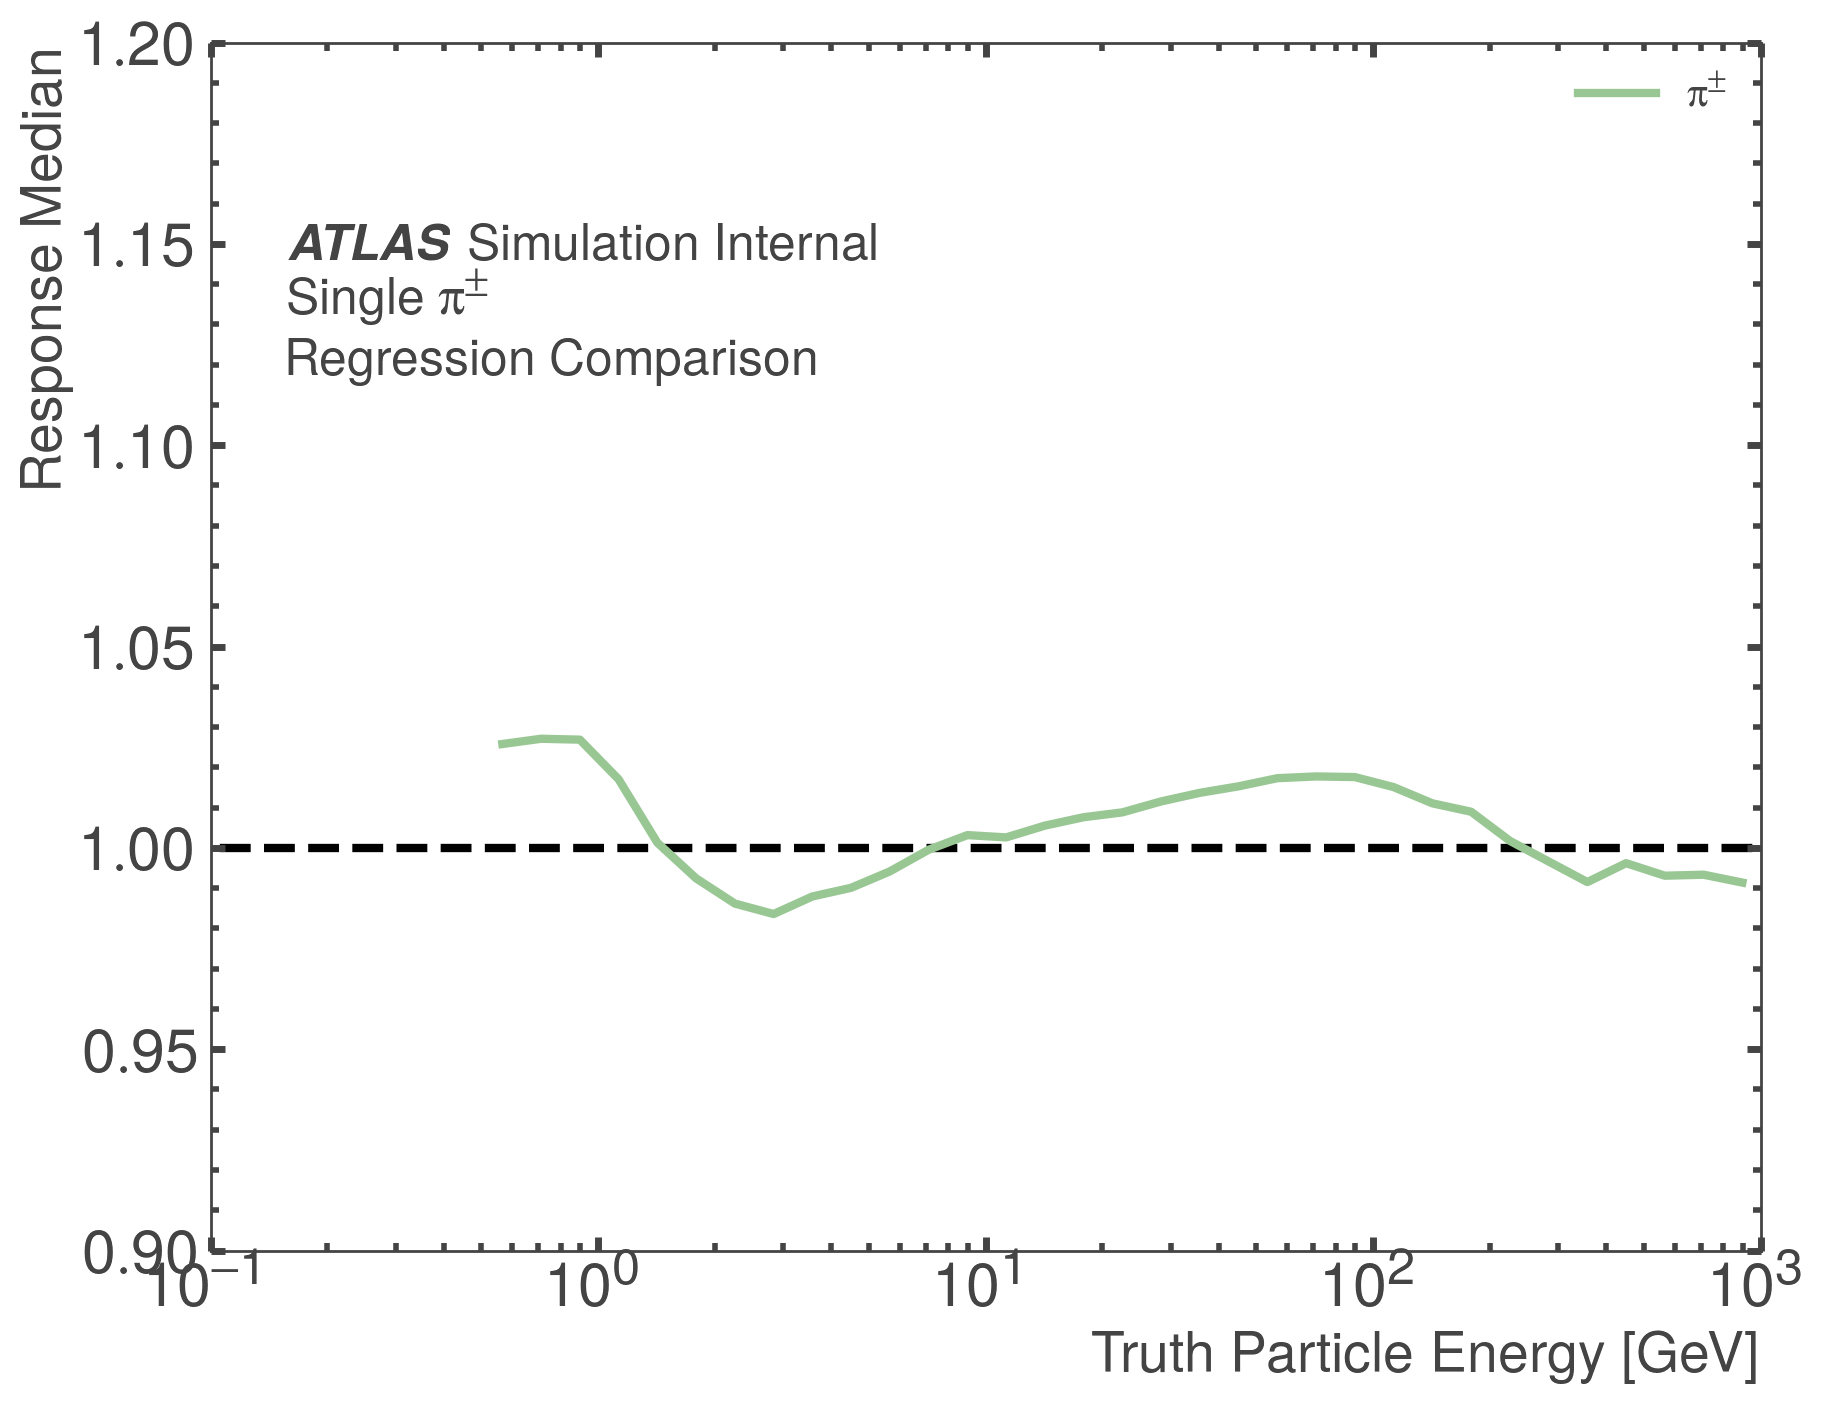


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

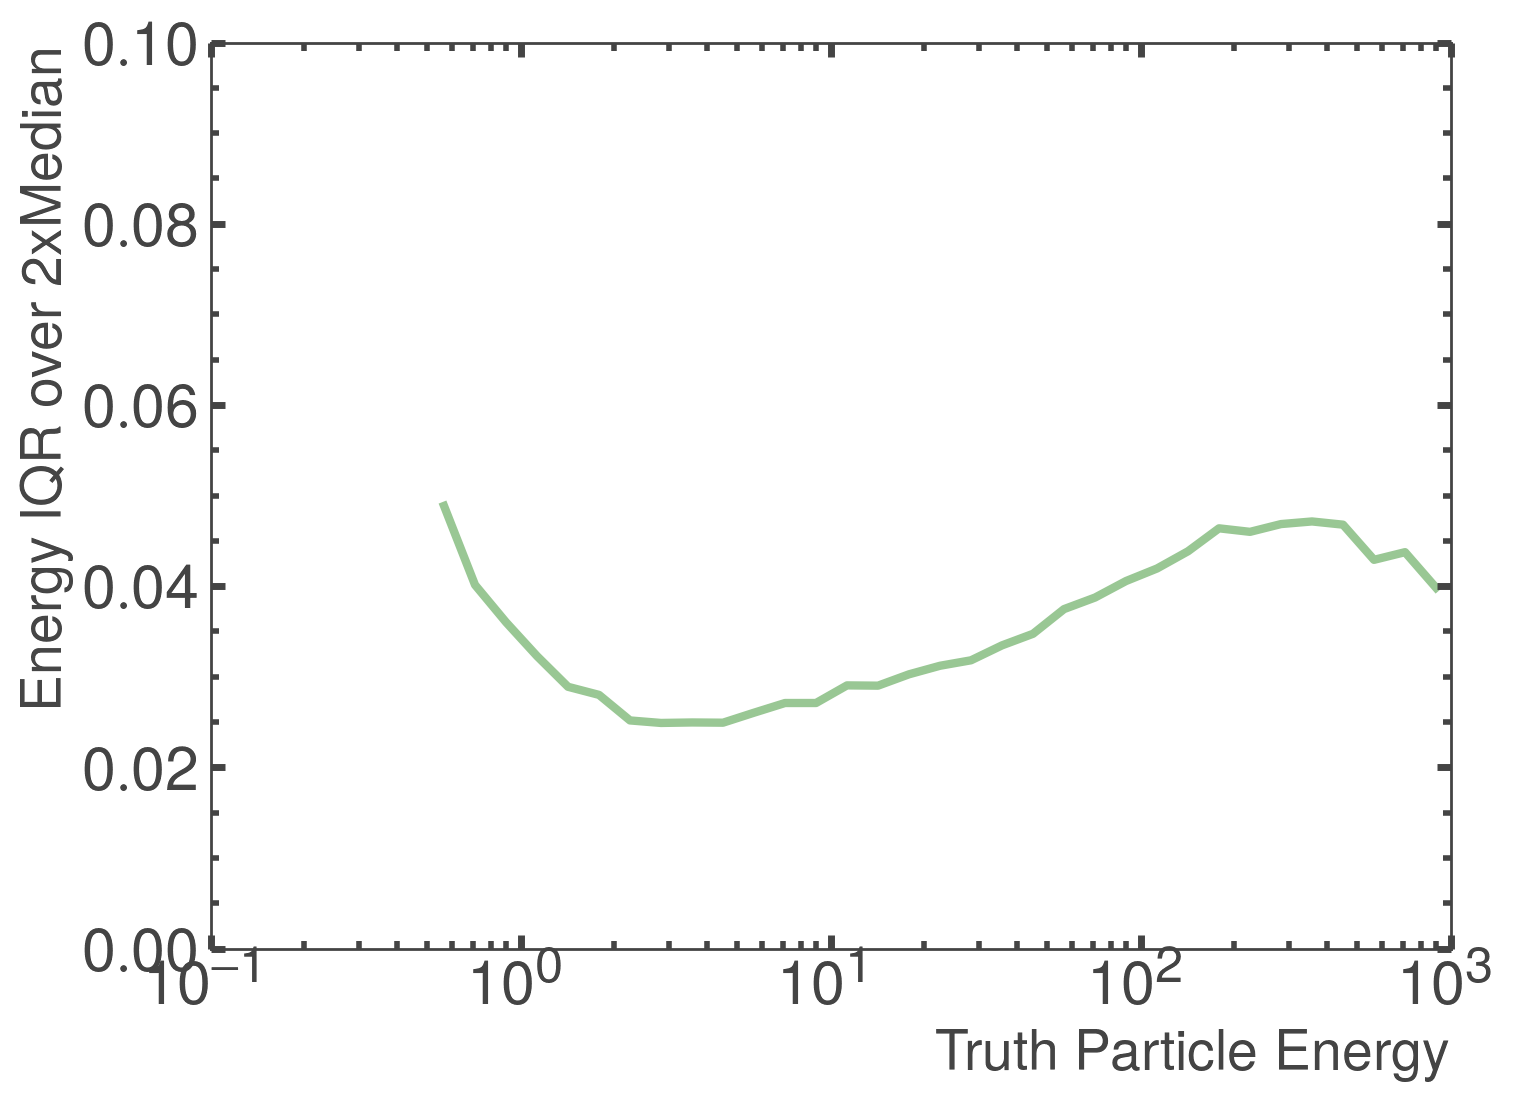

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

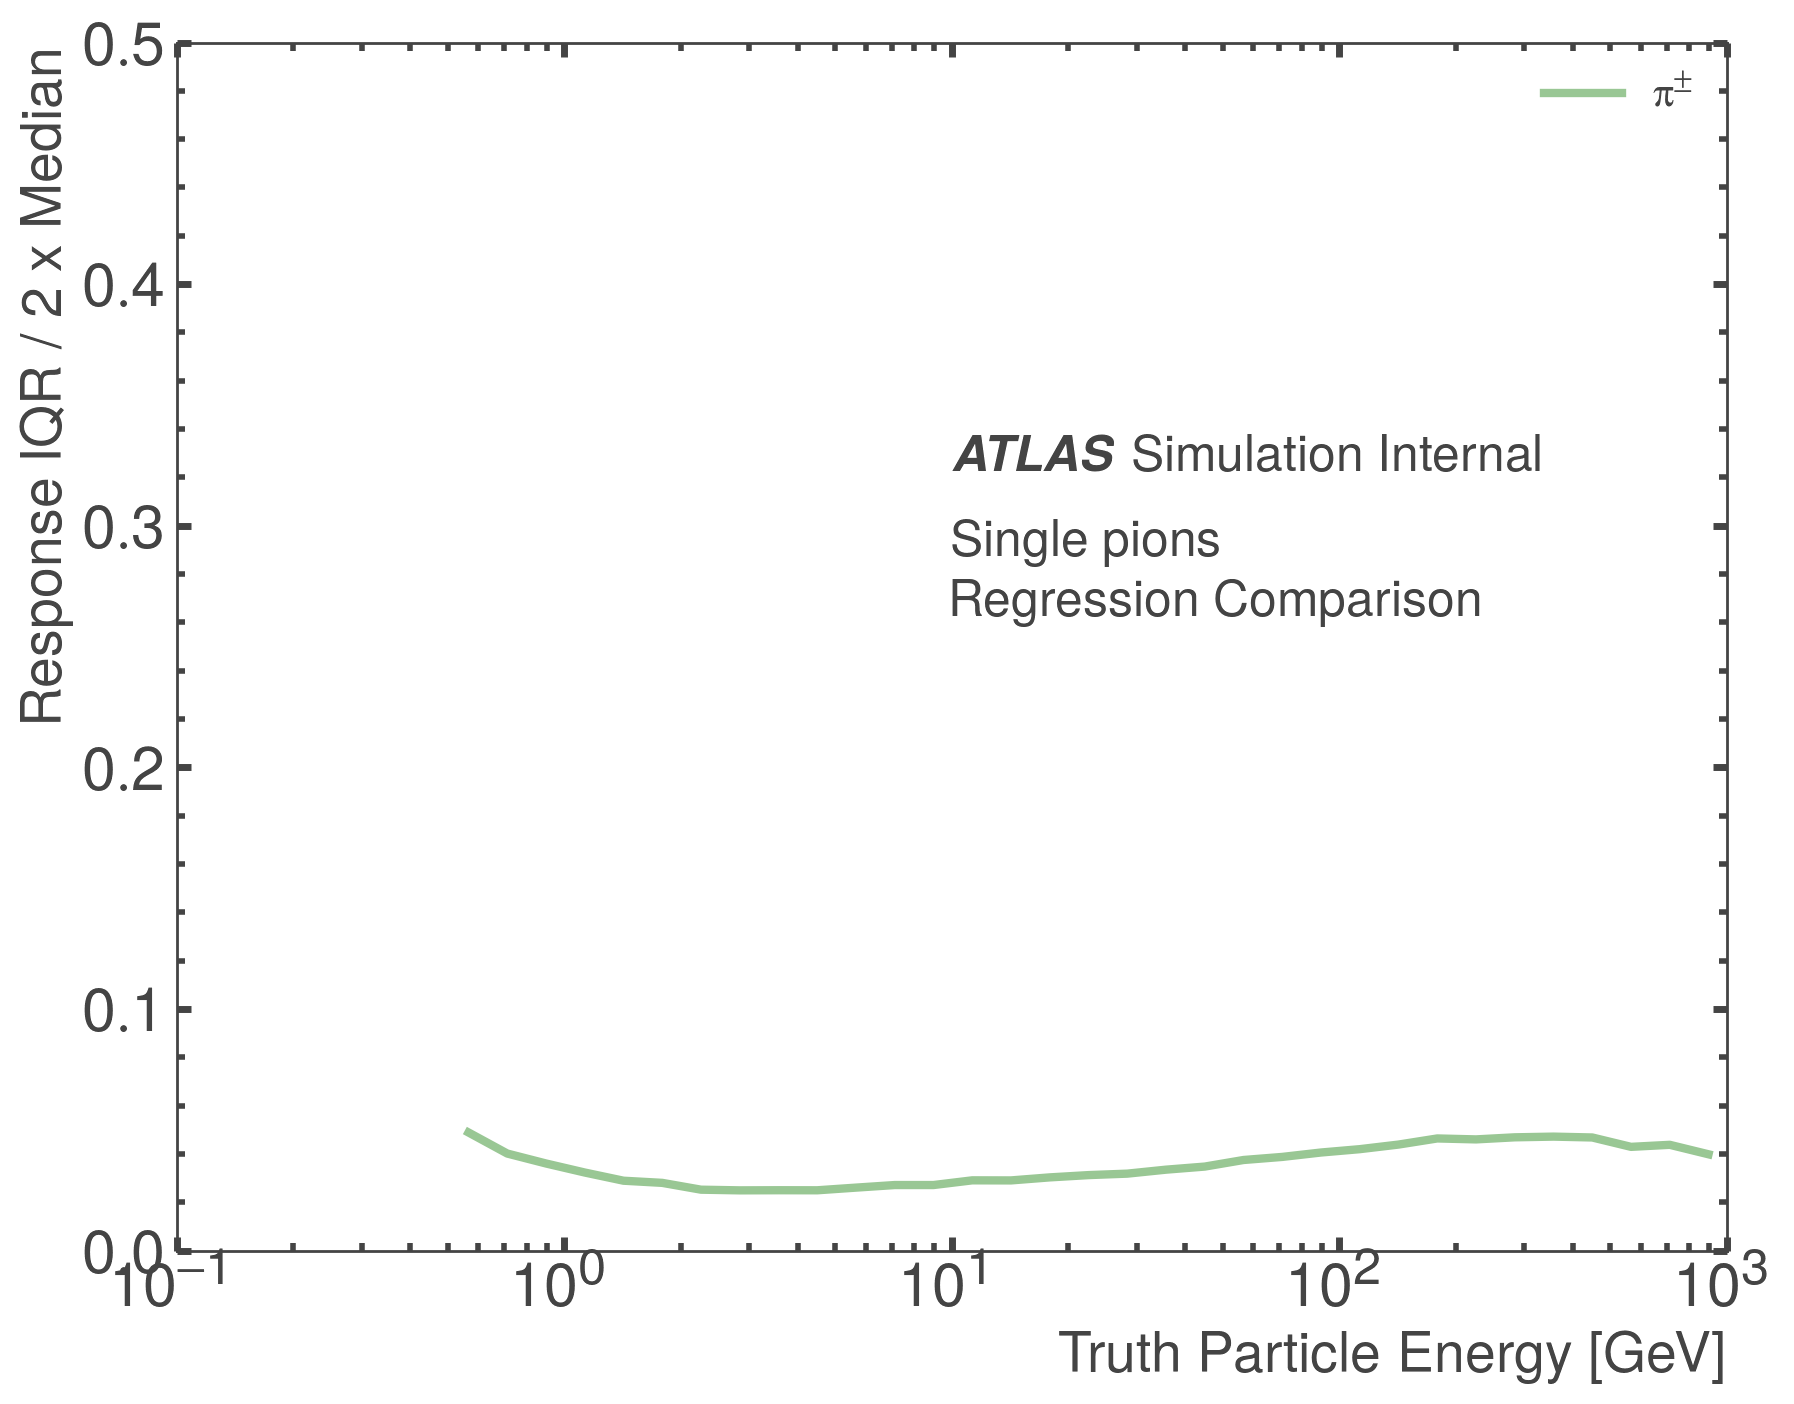

In [6]:
make_regression_plots(df_pfn[df_pfn.targets_regress > 0.5], 
                      charged_pions_only = True,
                      label="russell", 
#                       data_dir=data_dir,
                      # data_dir='./pub_note_results',
                     )


Plotting $\pi^{\pm}$
r2:0.983
PearsonR:0.992, SpearmanR:0.998, MSE:3751.873, MAE:22.867
Saving figure to ./pub_note_results/regress_deepsets_leadcluster_cells_all.pdf


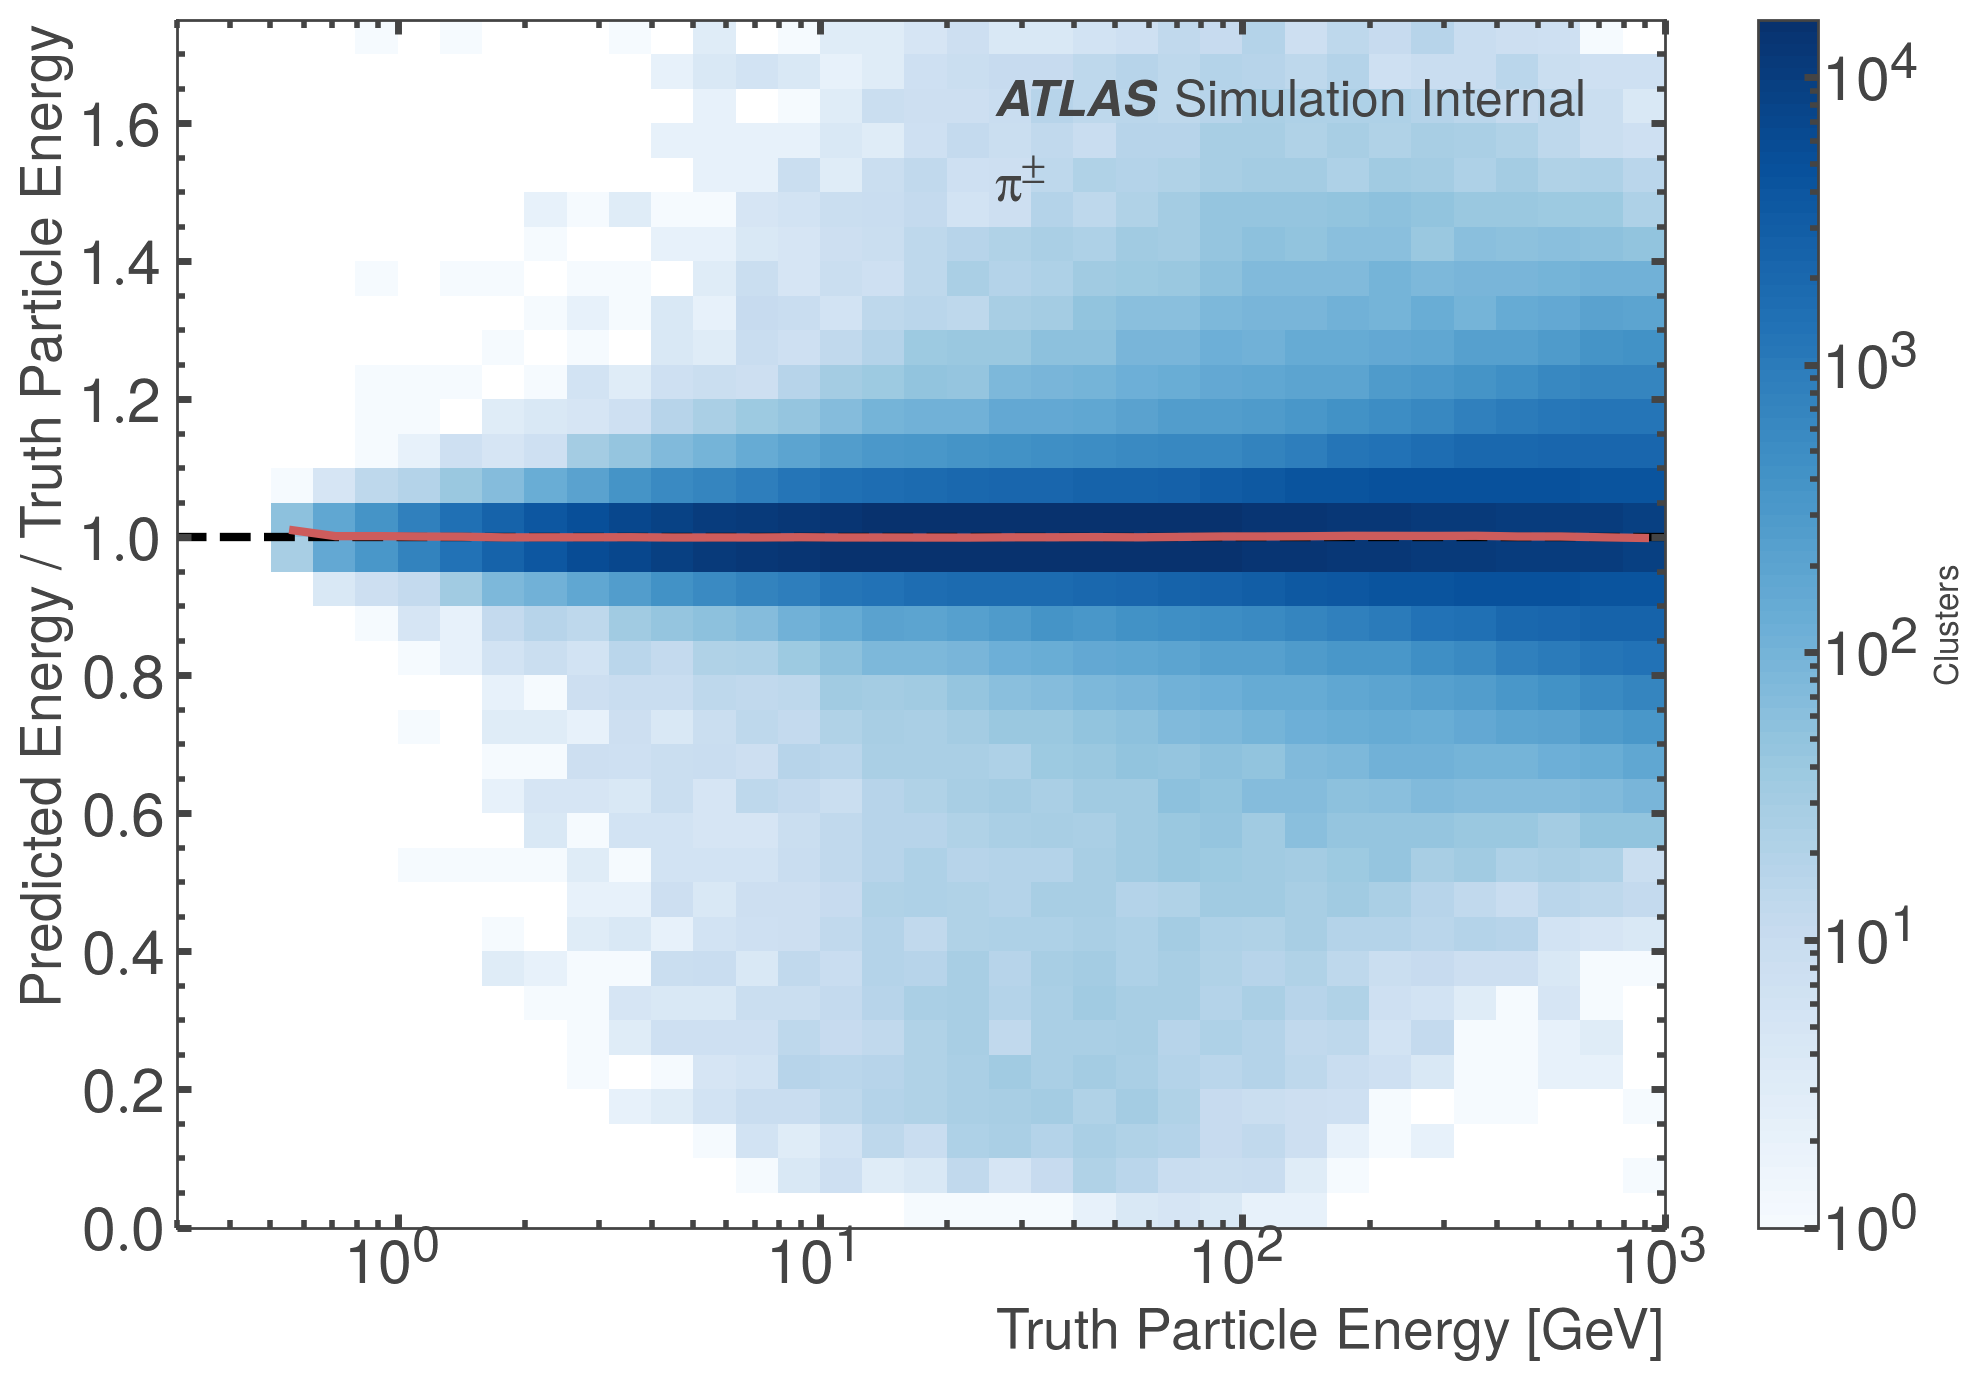

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

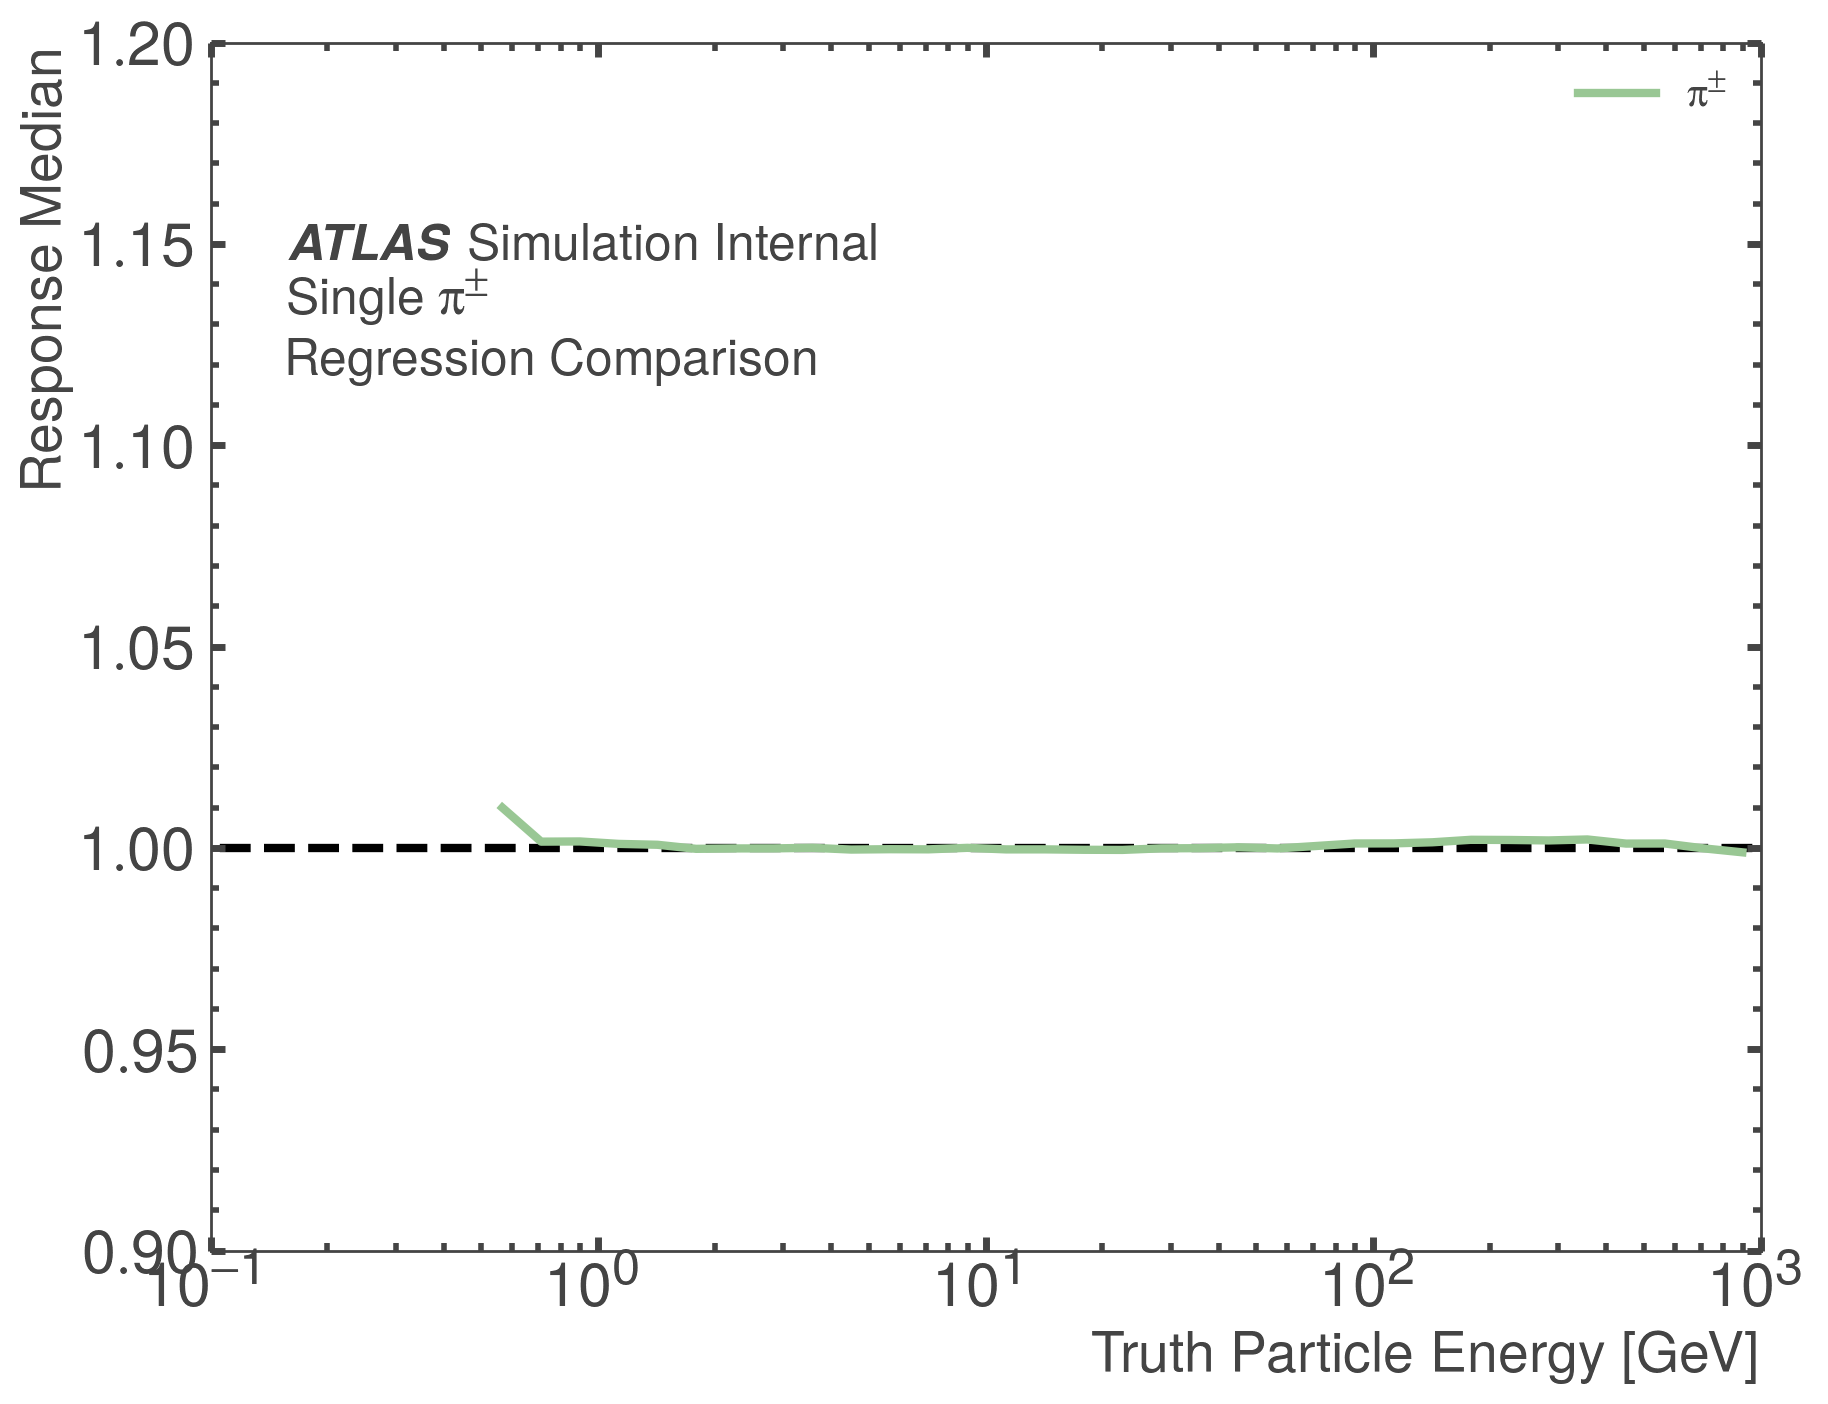


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

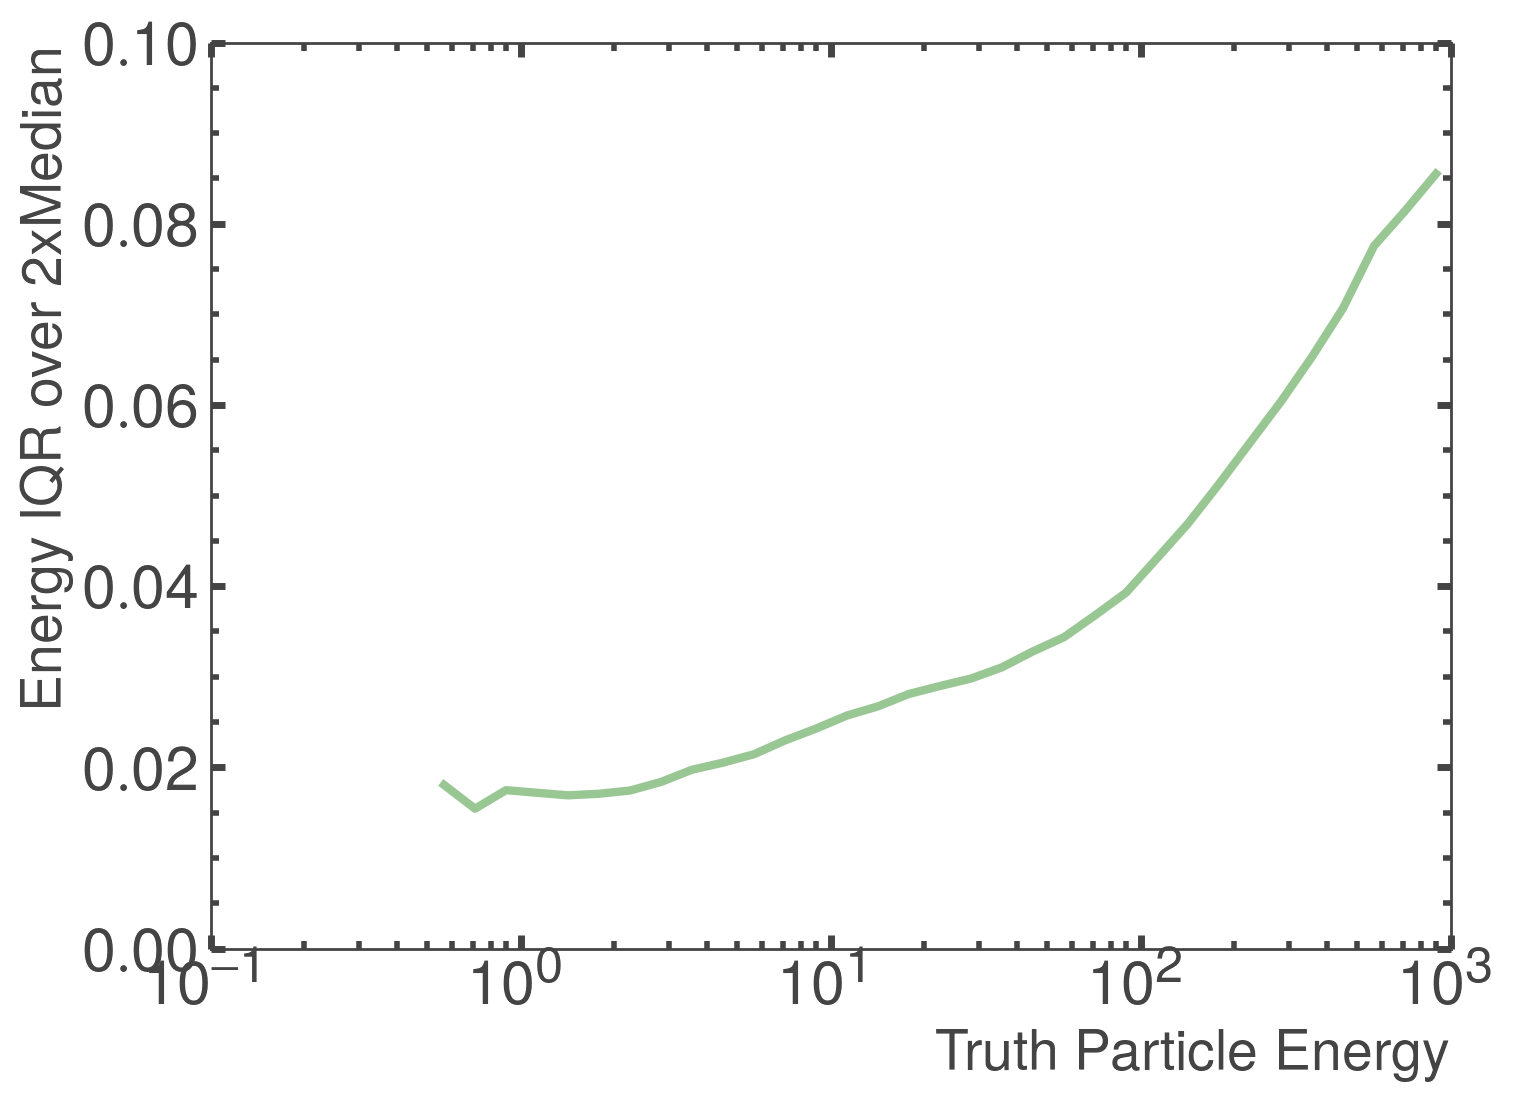

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

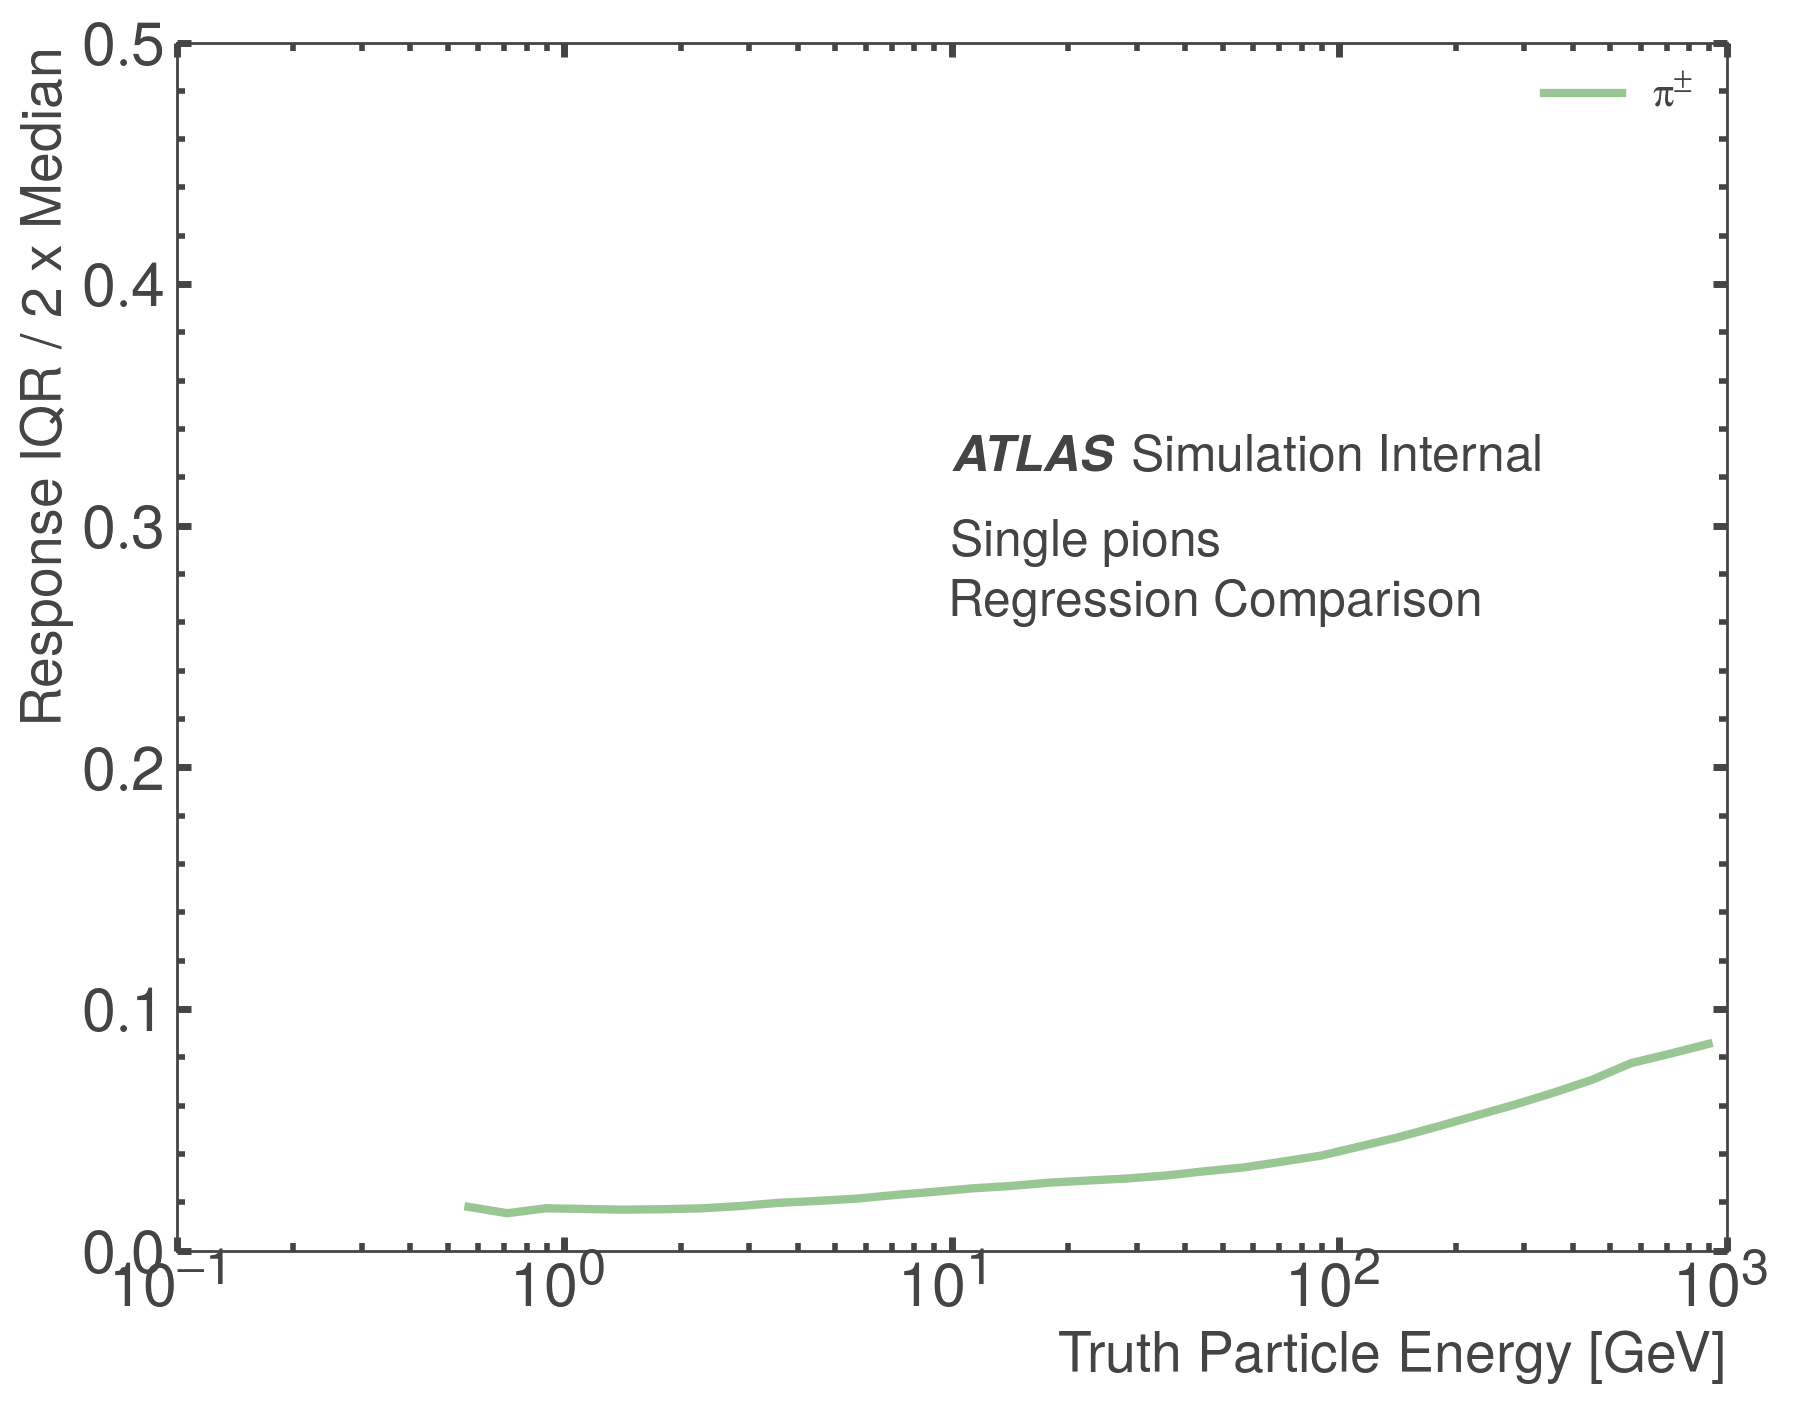


Plotting $\pi^{\pm}$
r2:0.986
PearsonR:0.993, SpearmanR:0.998, MSE:3109.771, MAE:20.778
Saving figure to ./pub_note_results/regress_gnn_leadcluster_cells_all.pdf


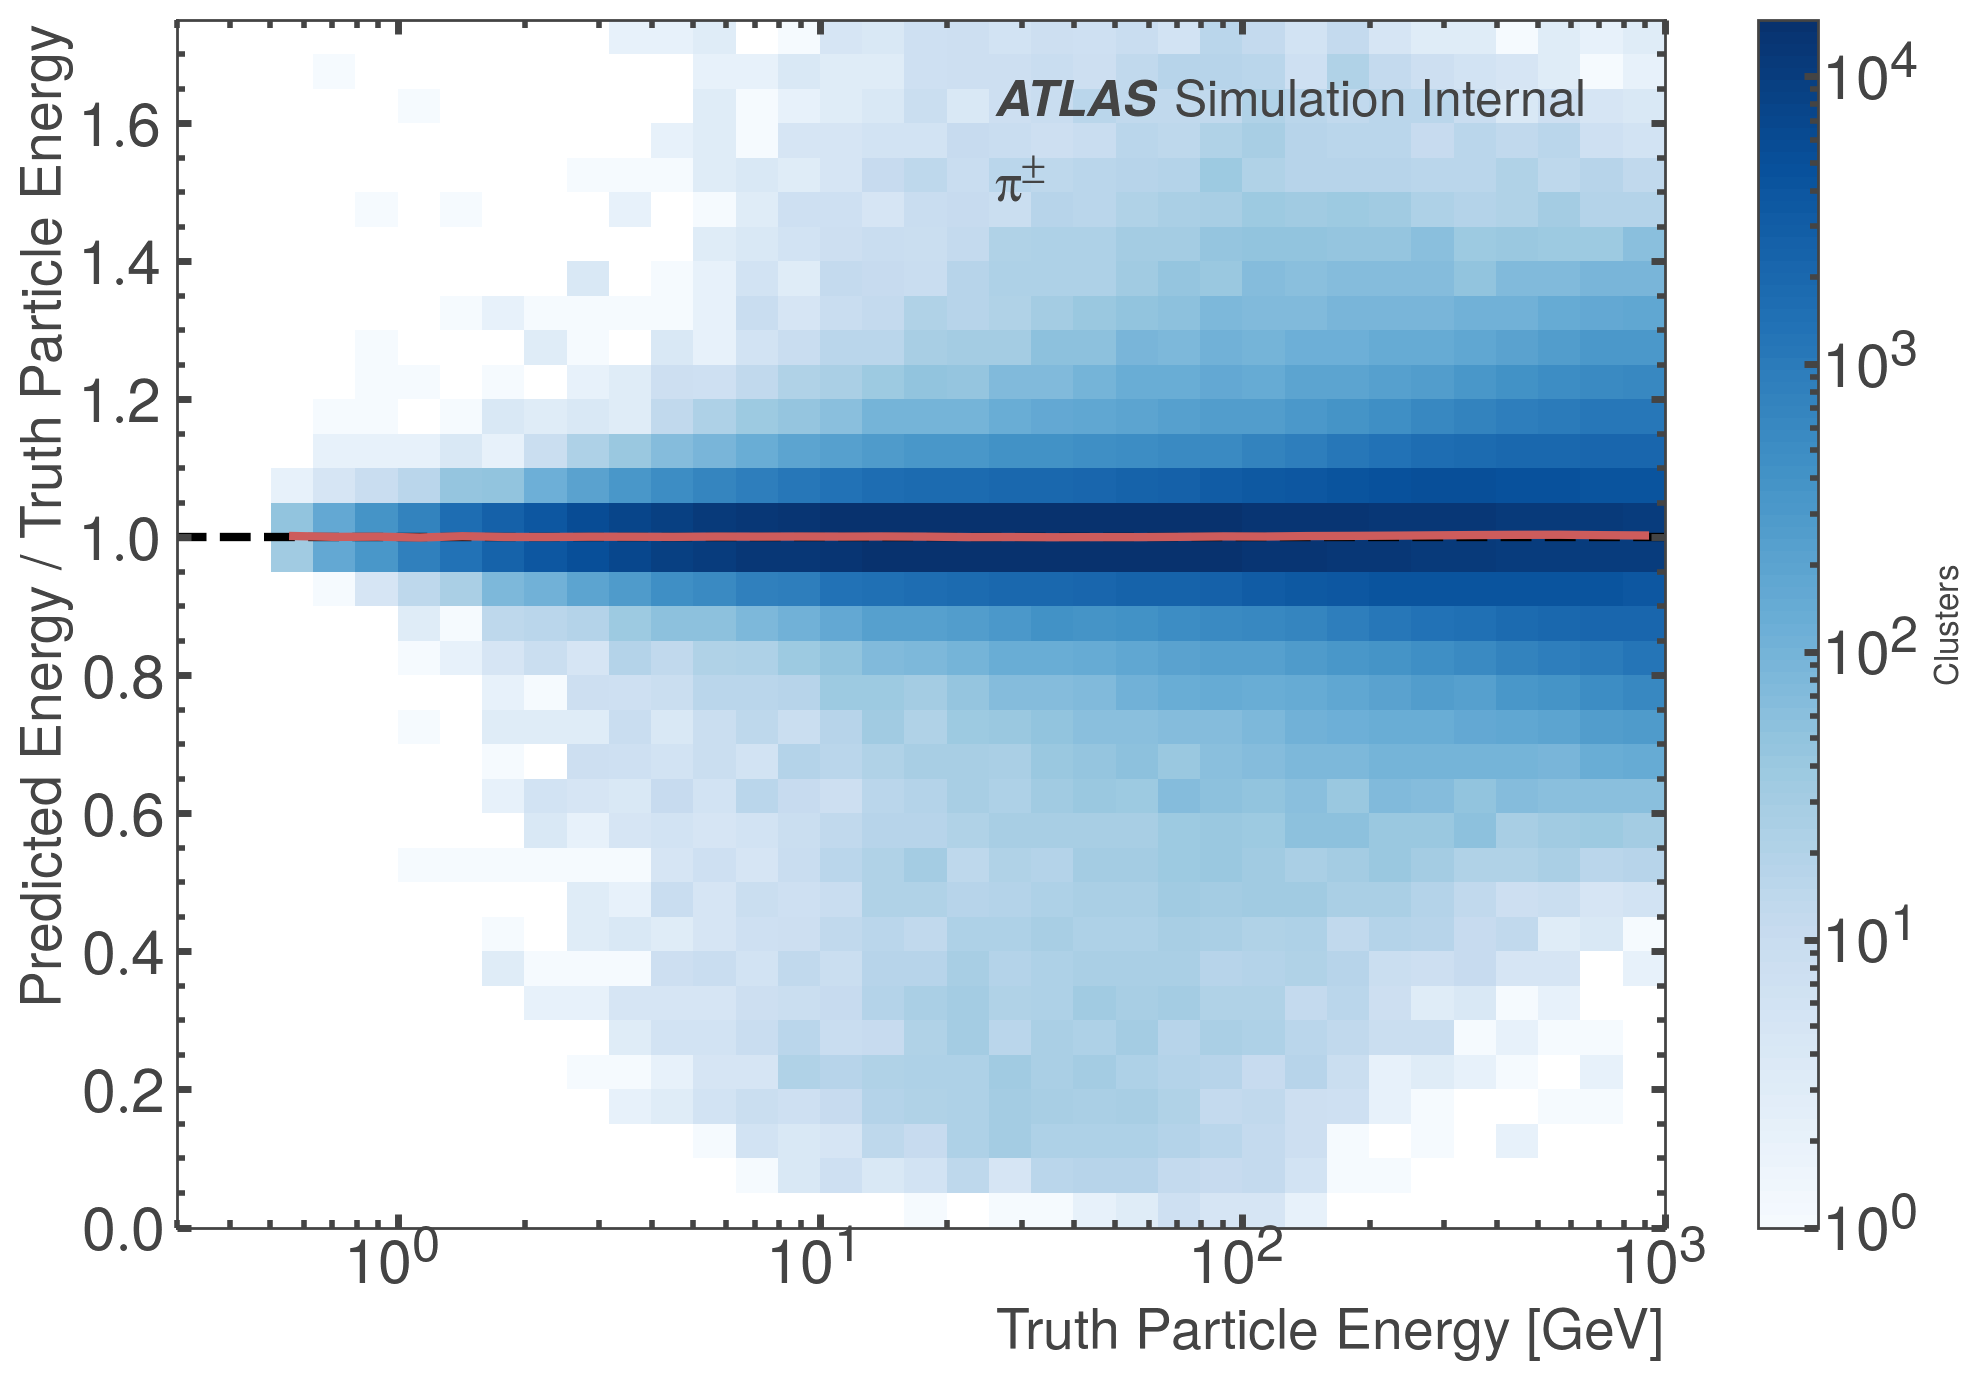

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

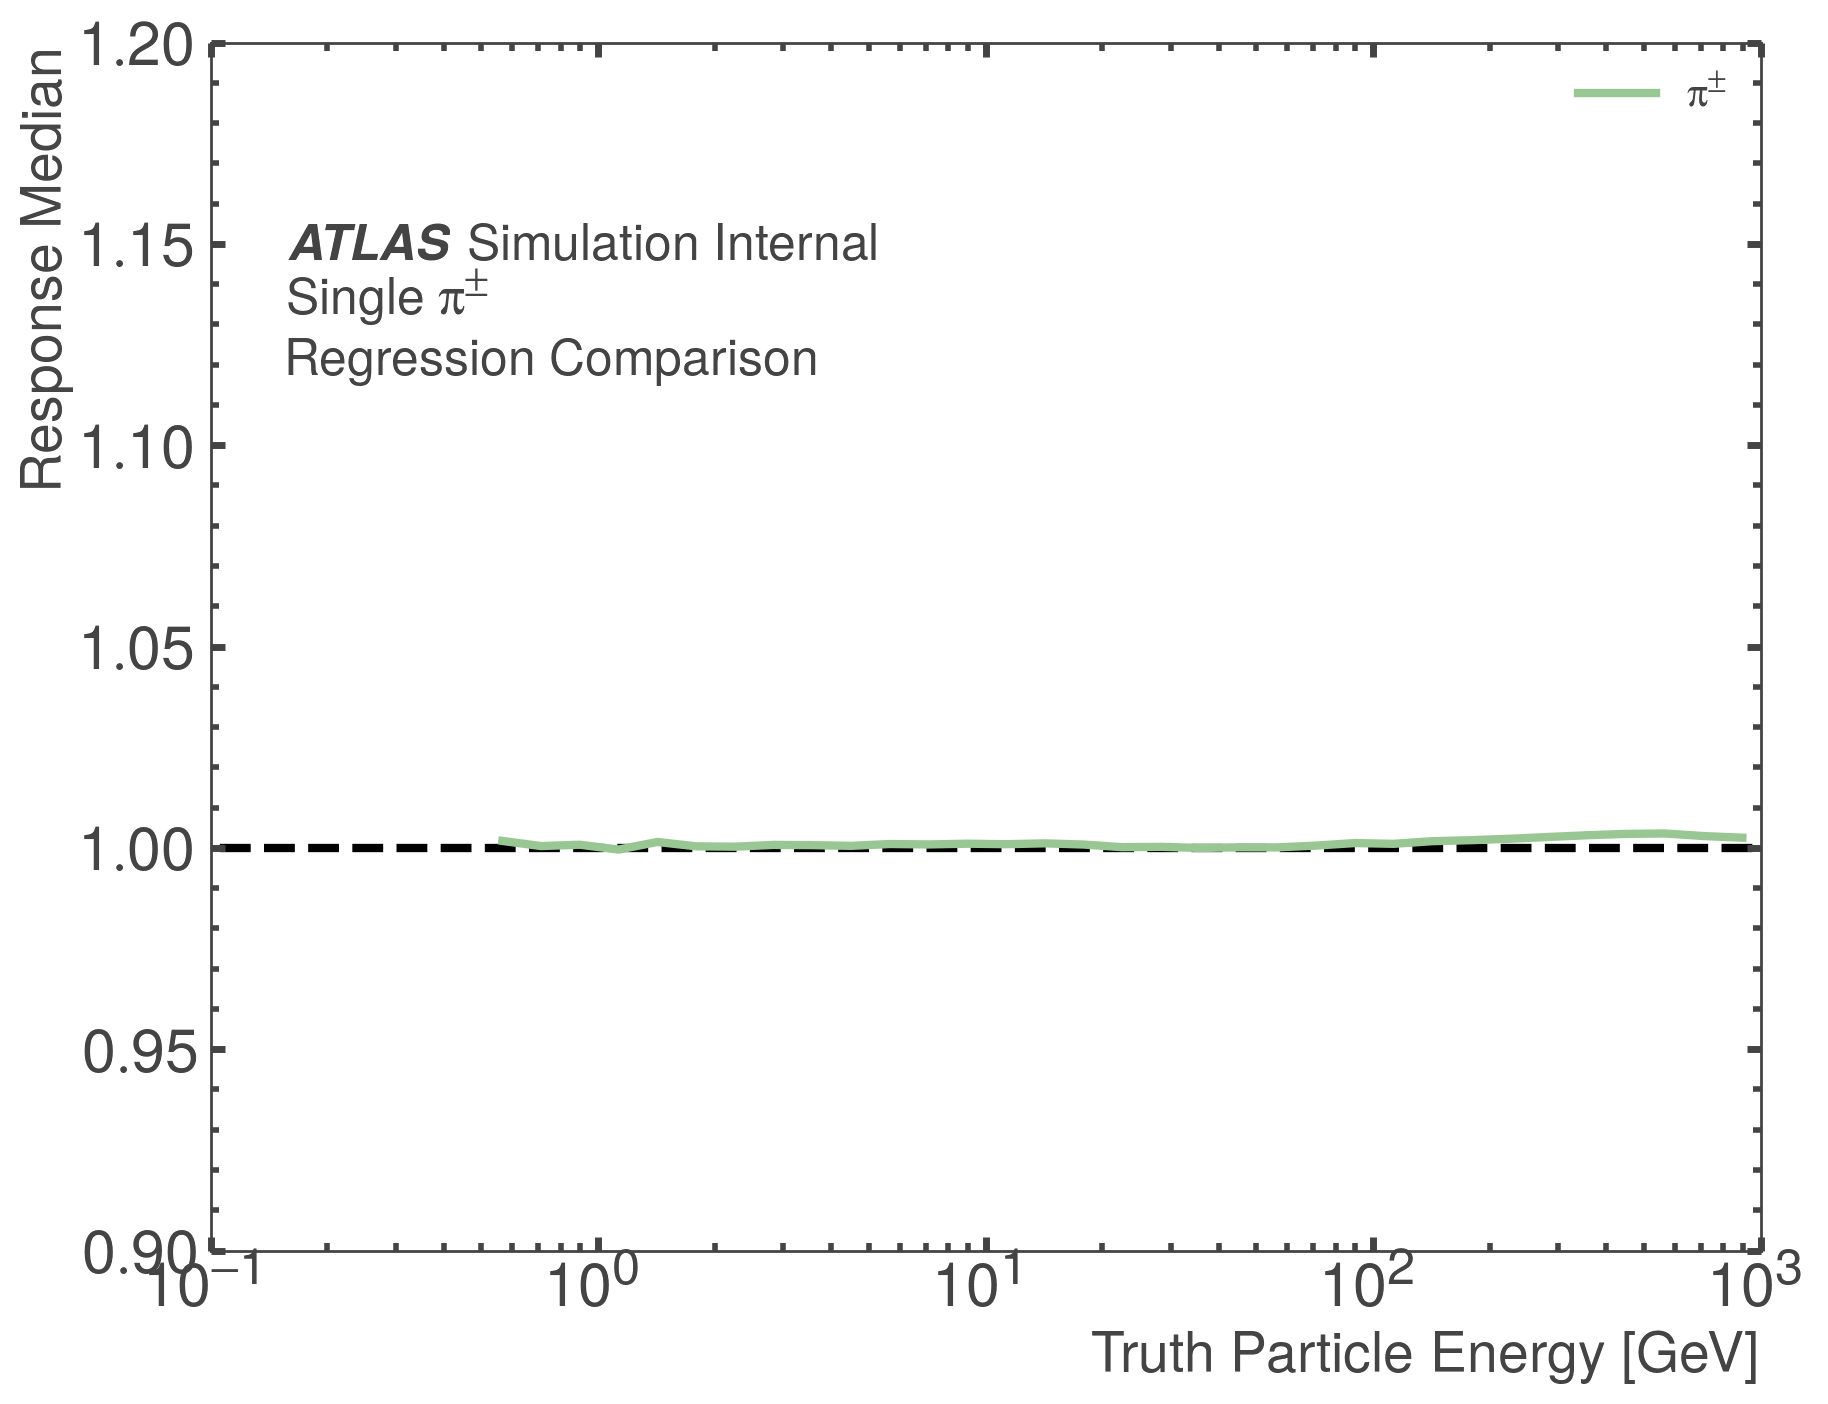


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

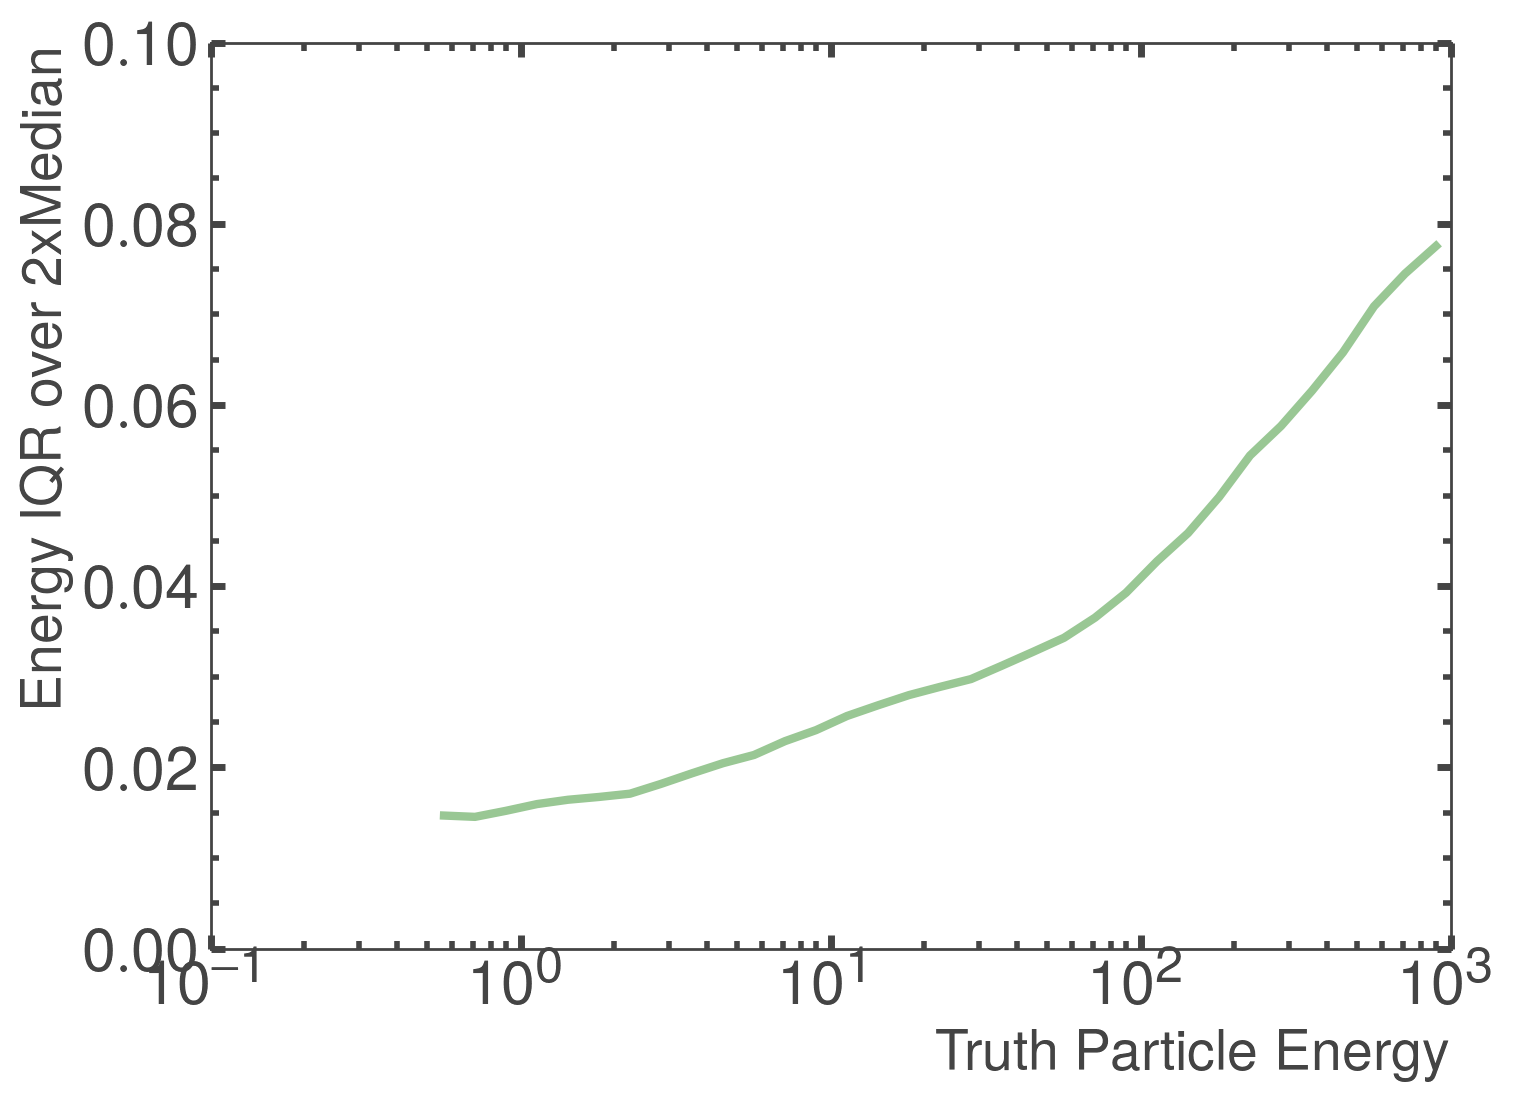

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

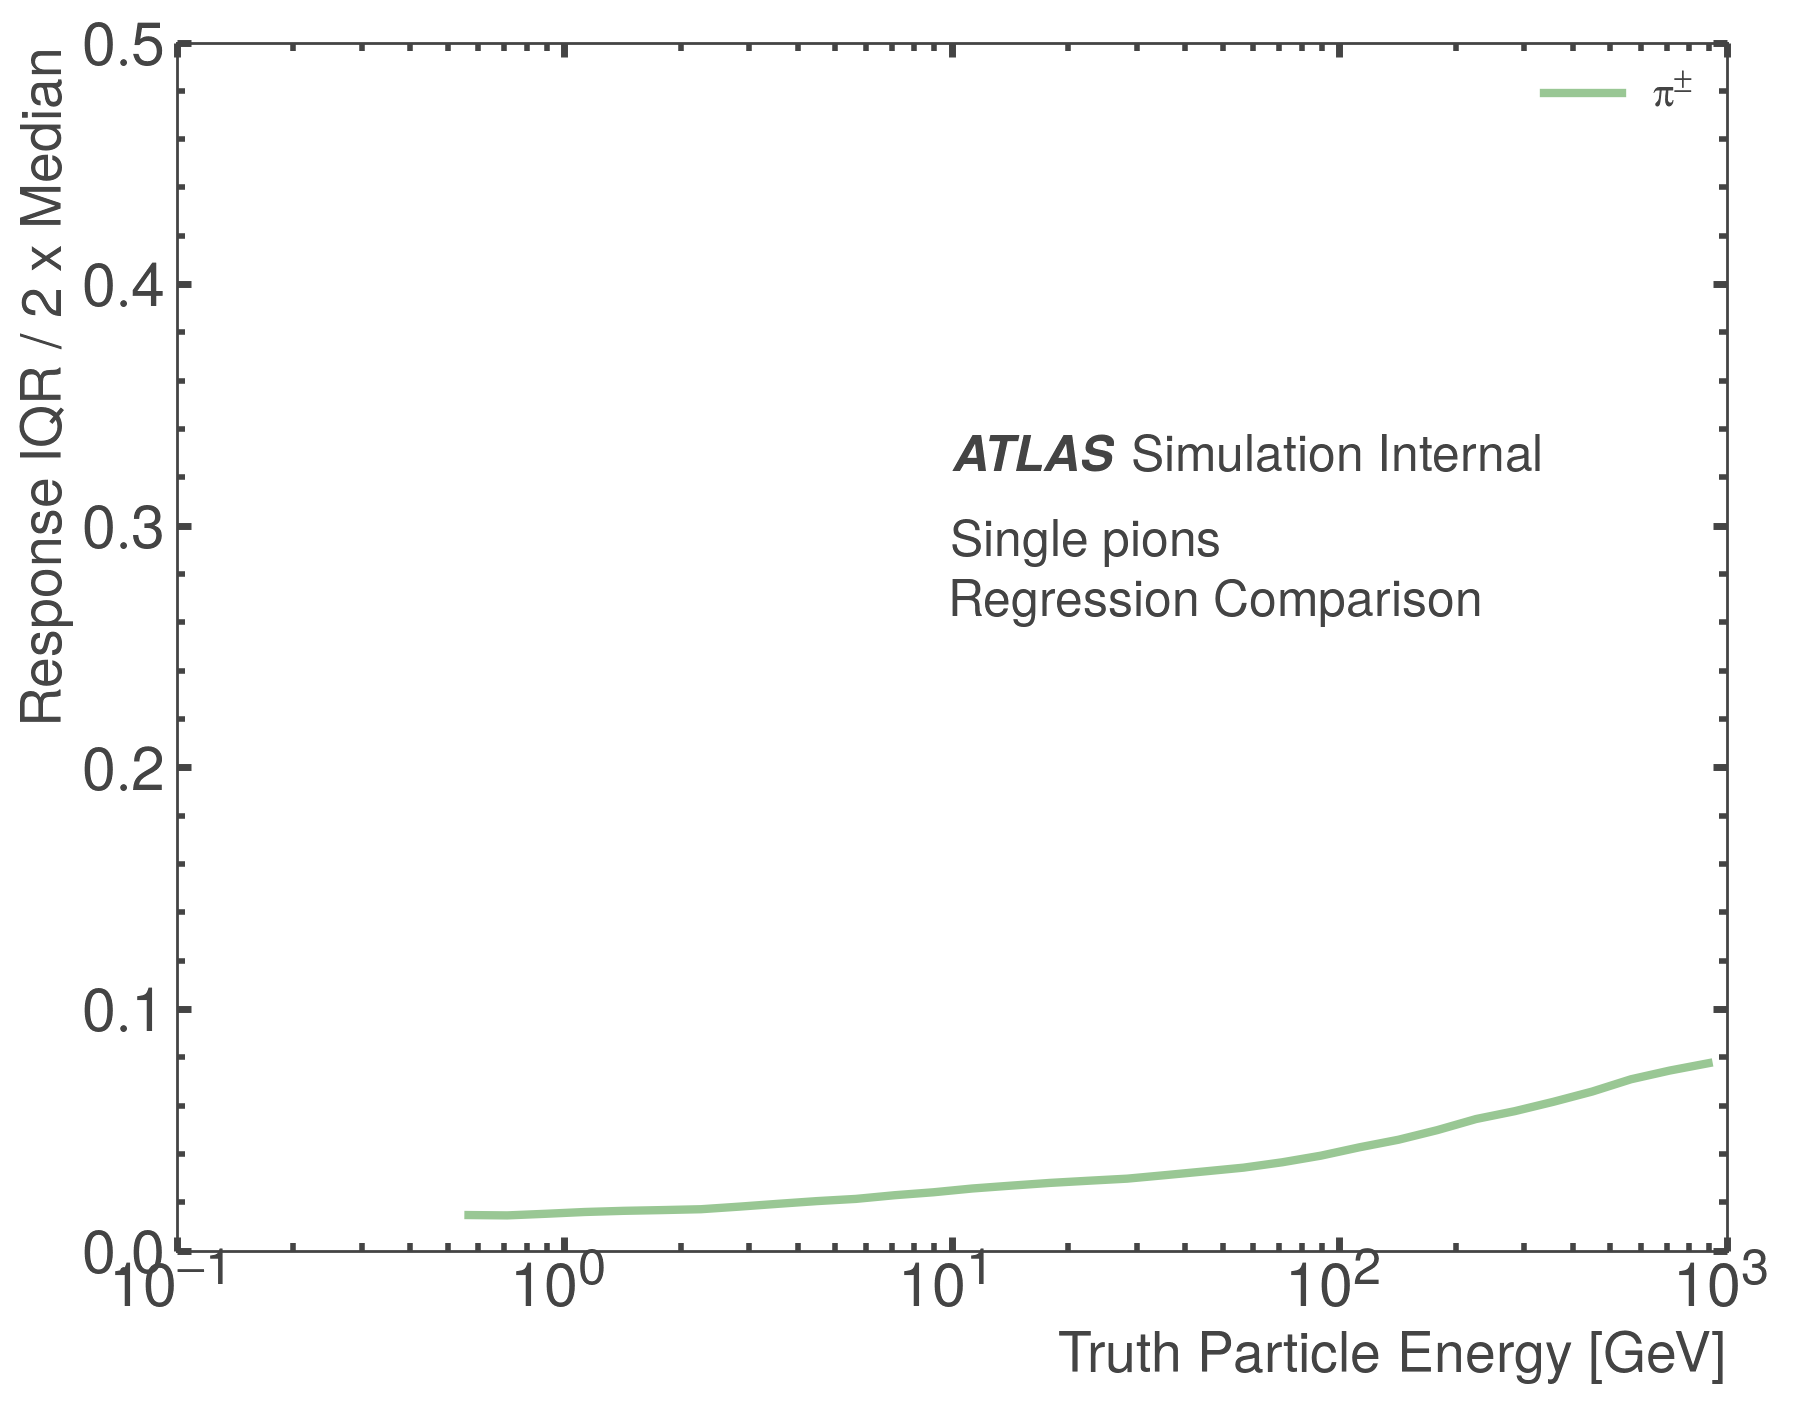


Plotting $\pi^{\pm}$
r2:0.963
PearsonR:0.981, SpearmanR:0.996, MSE:8058.432, MAE:34.646
Saving figure to ./pub_note_results/regress_deepsets_leadcluster_nocells_all.pdf


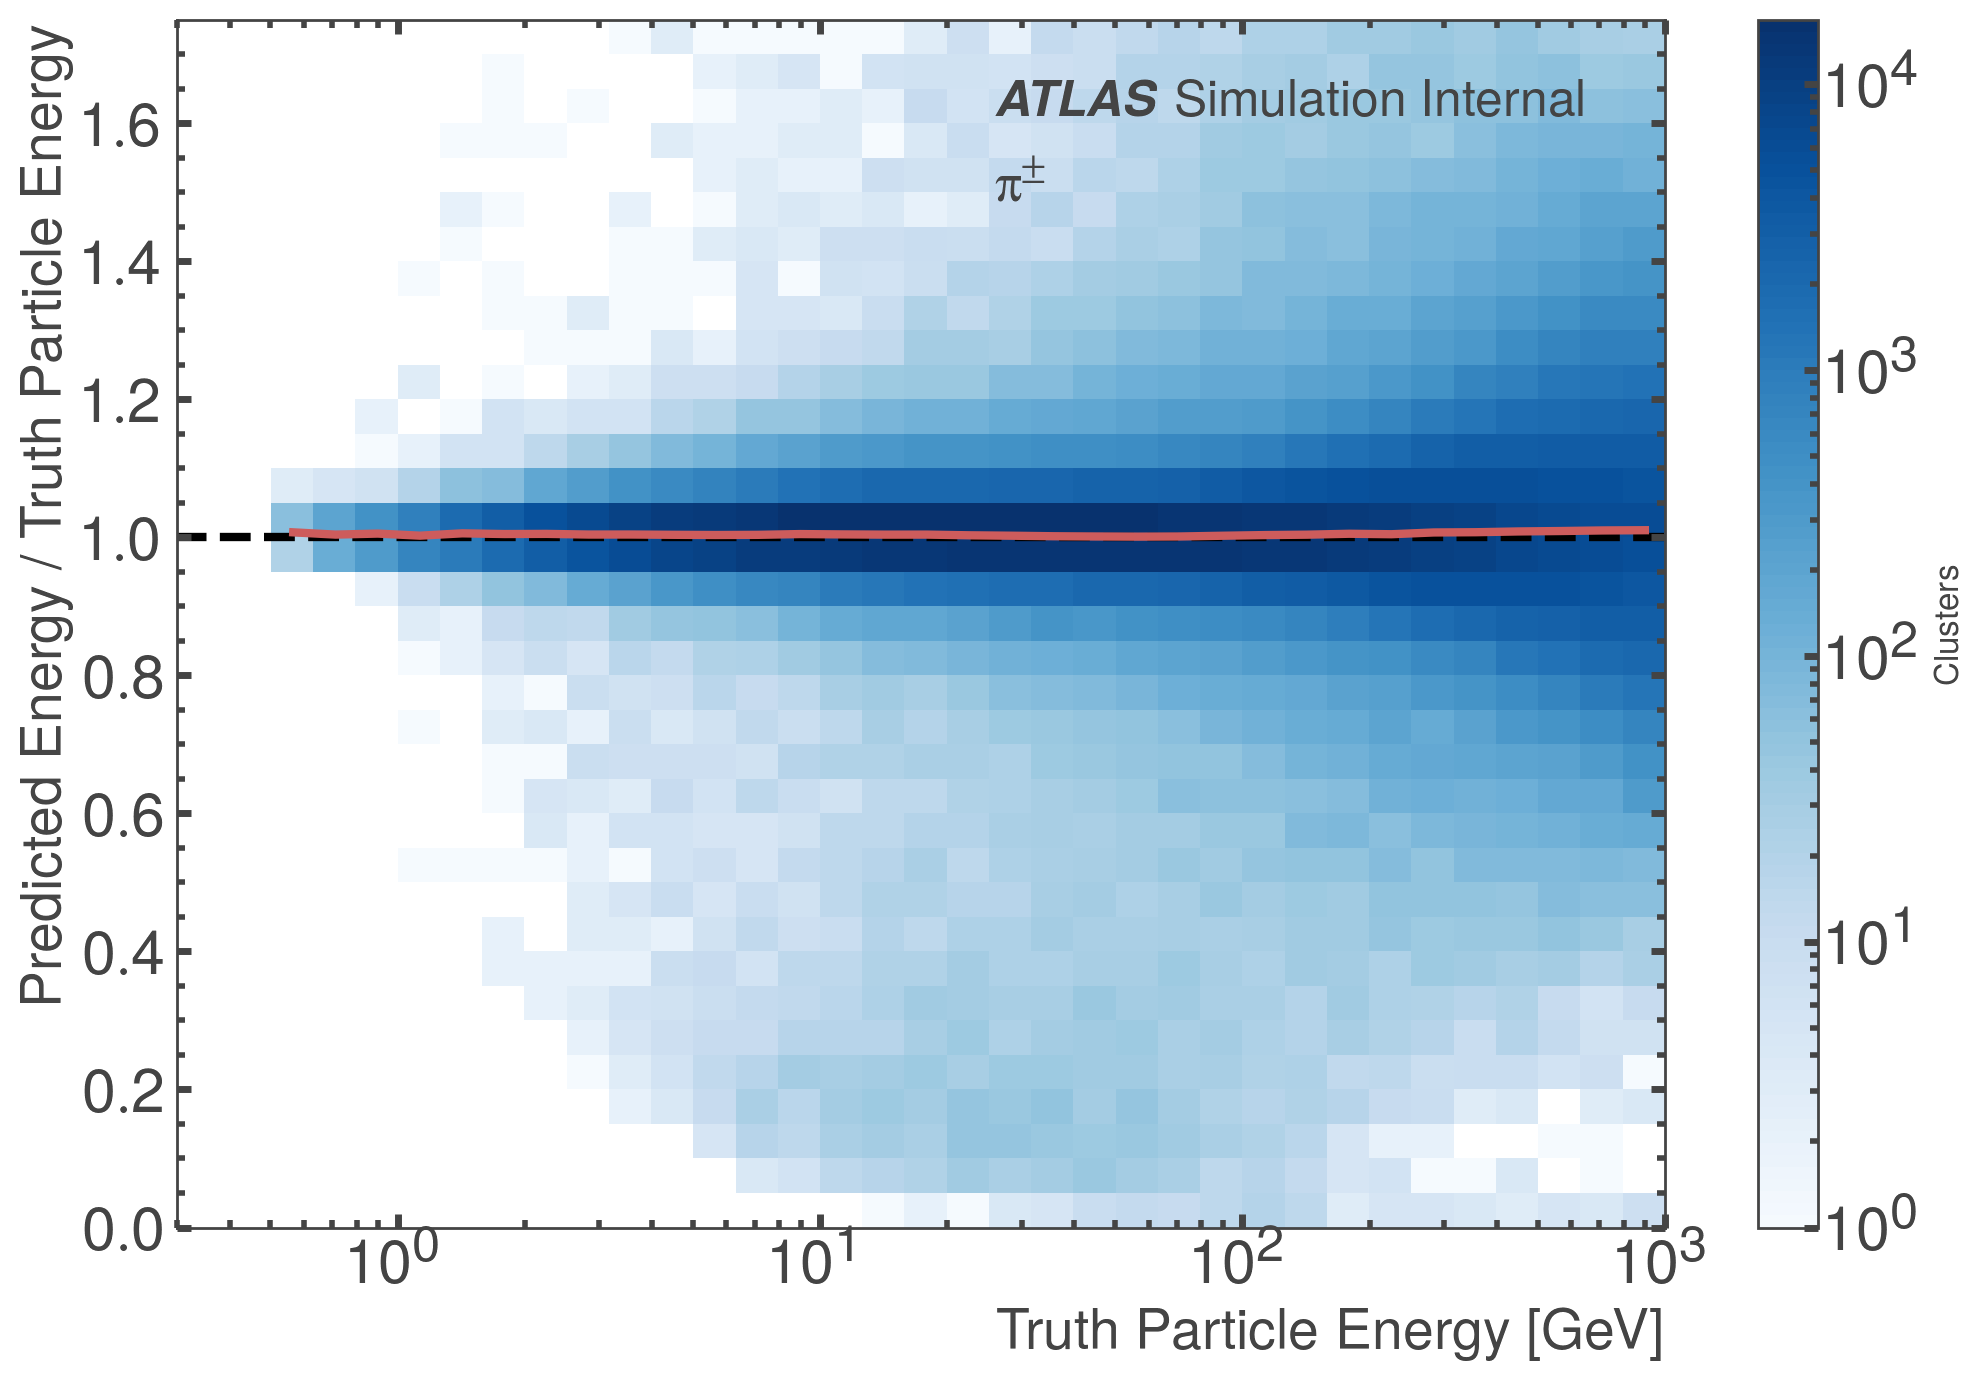

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

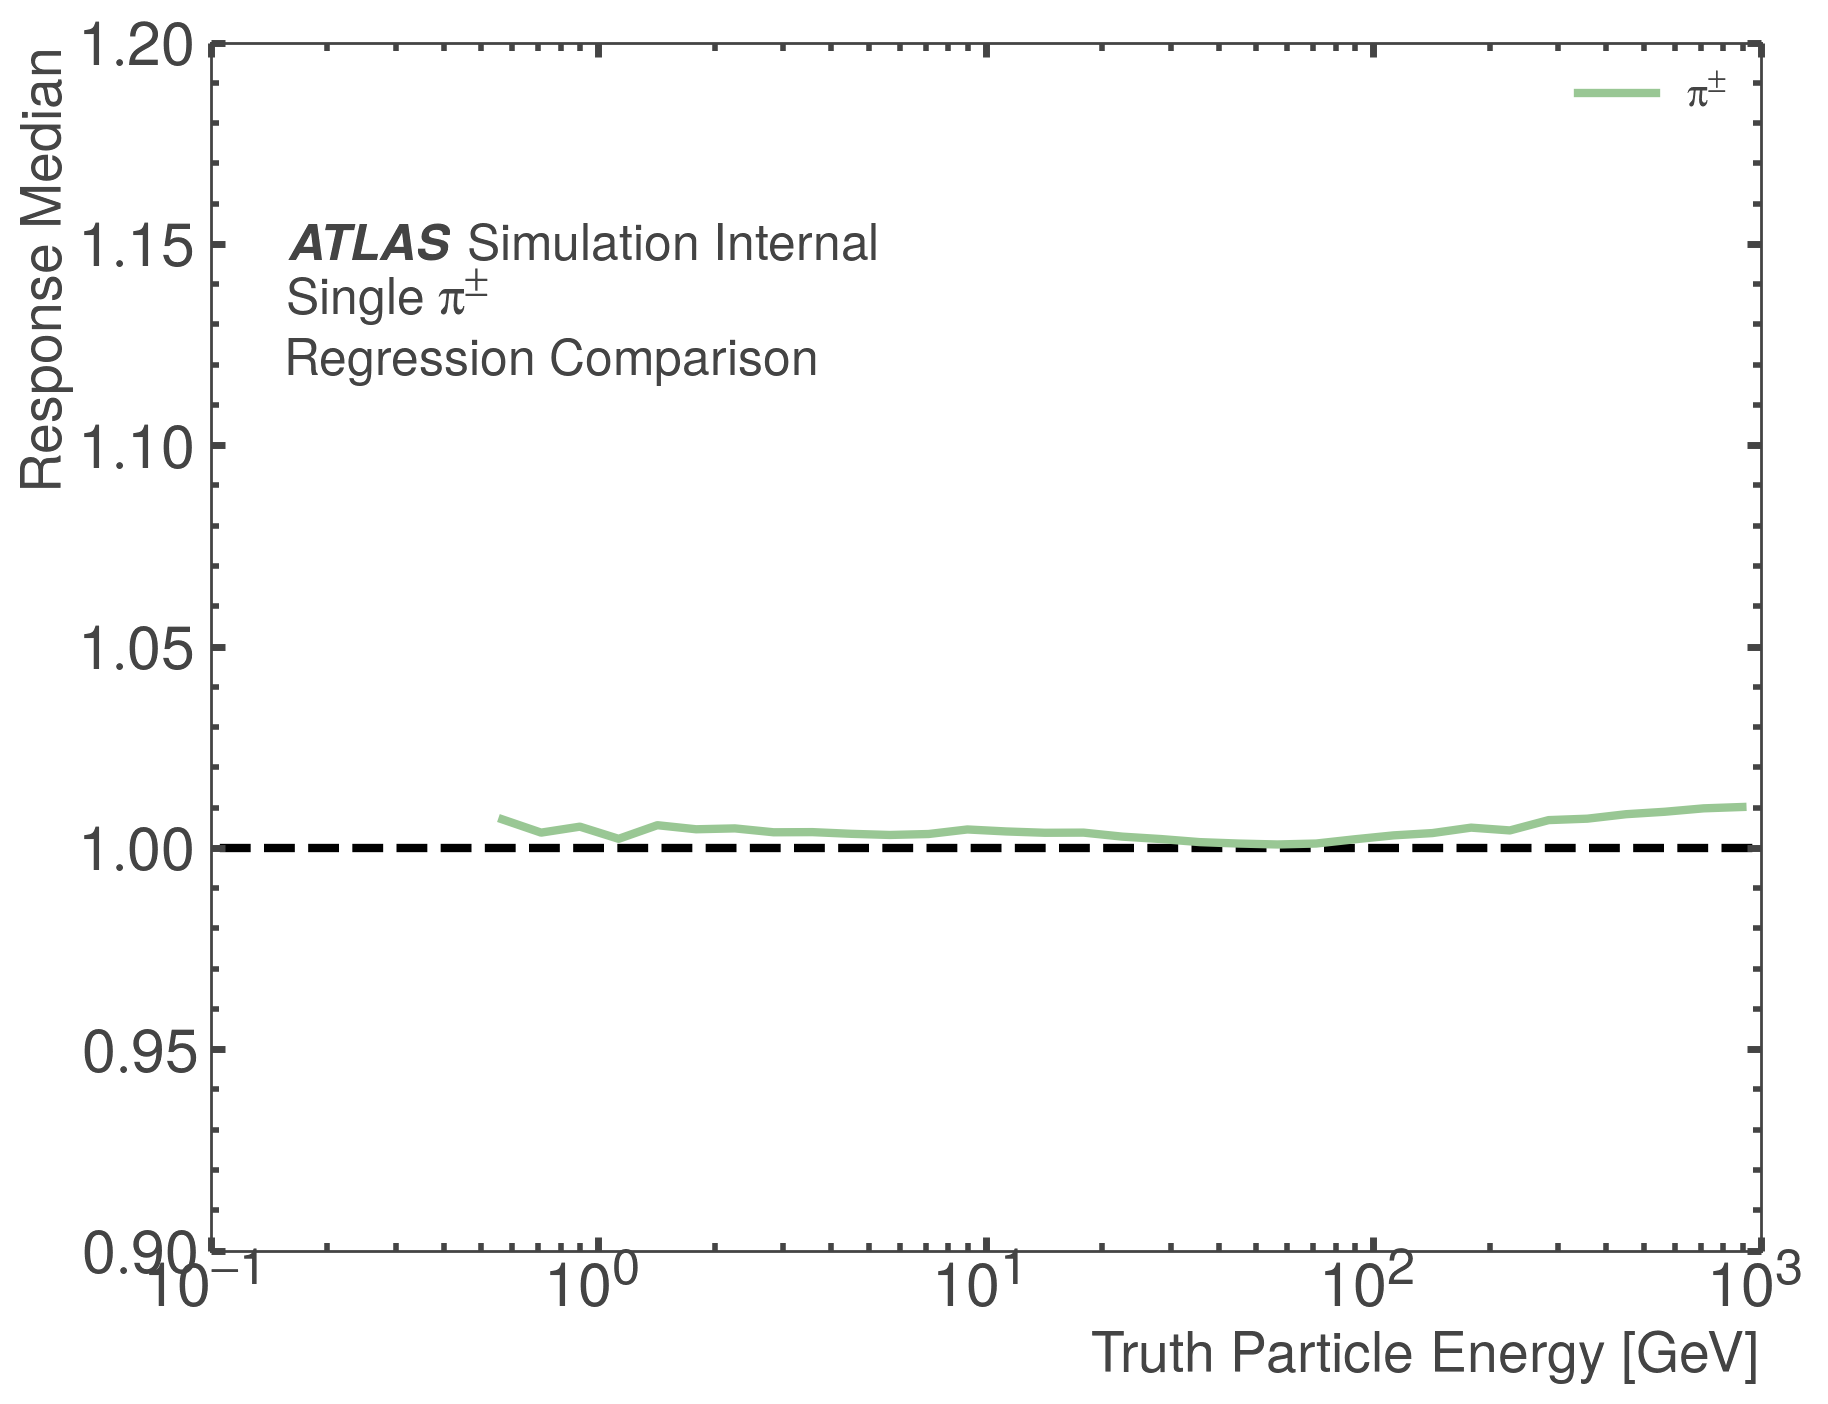


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

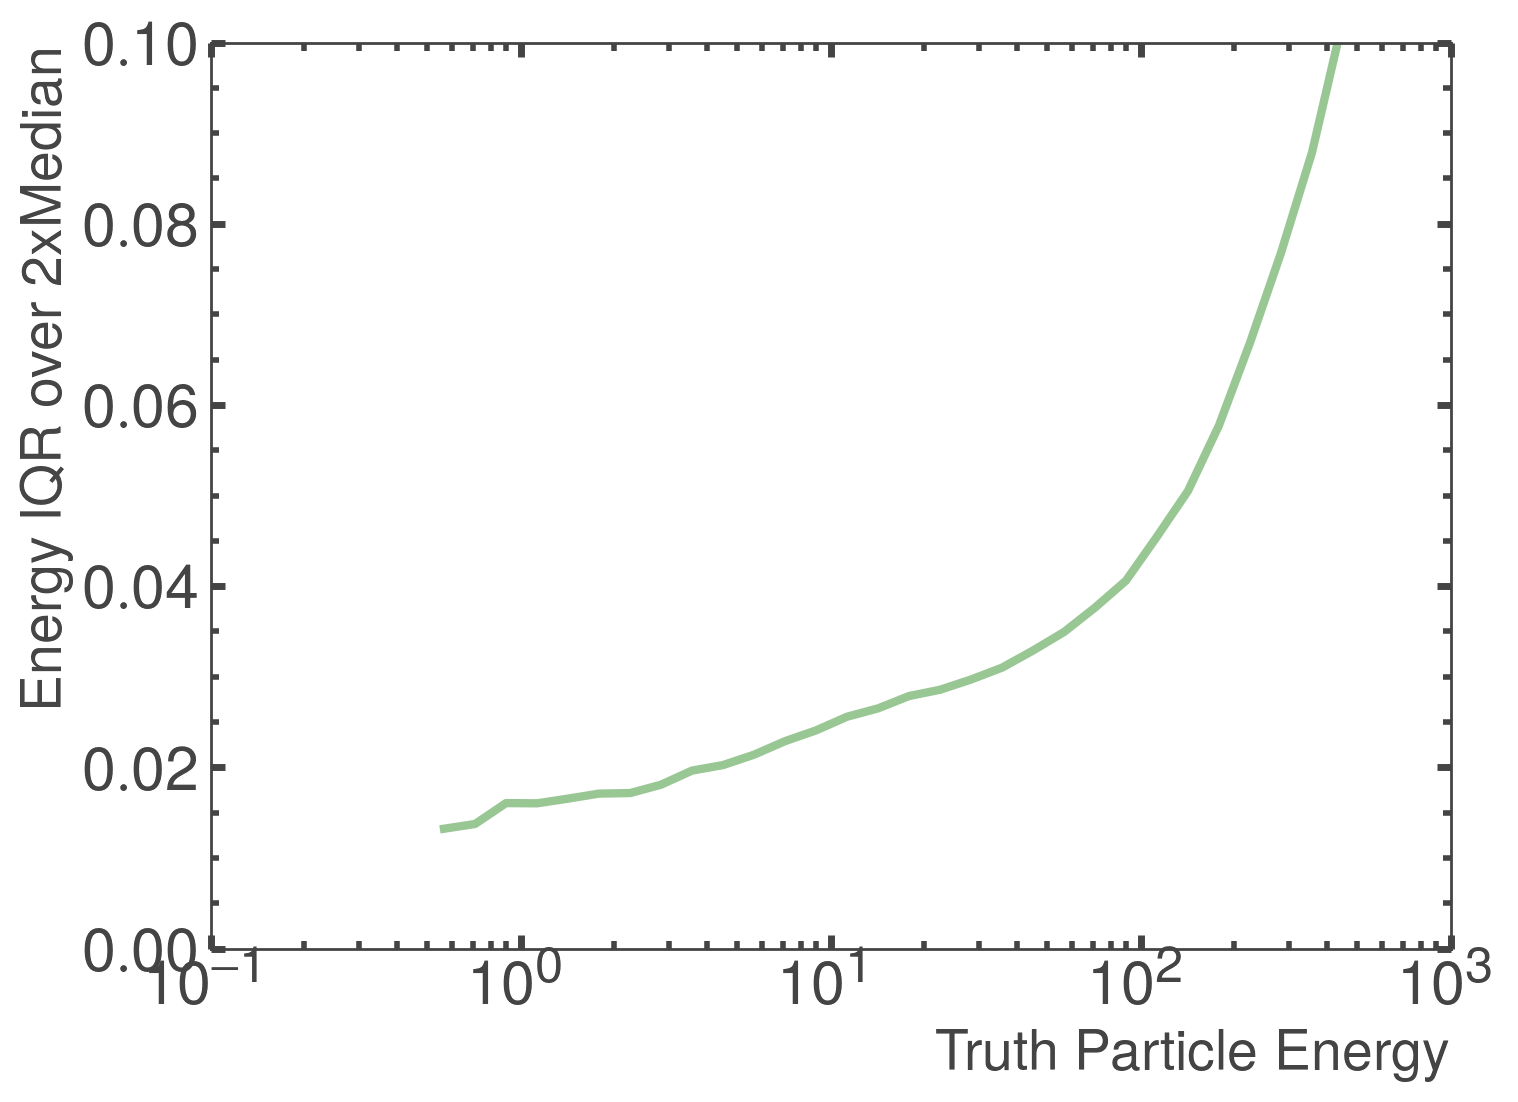

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

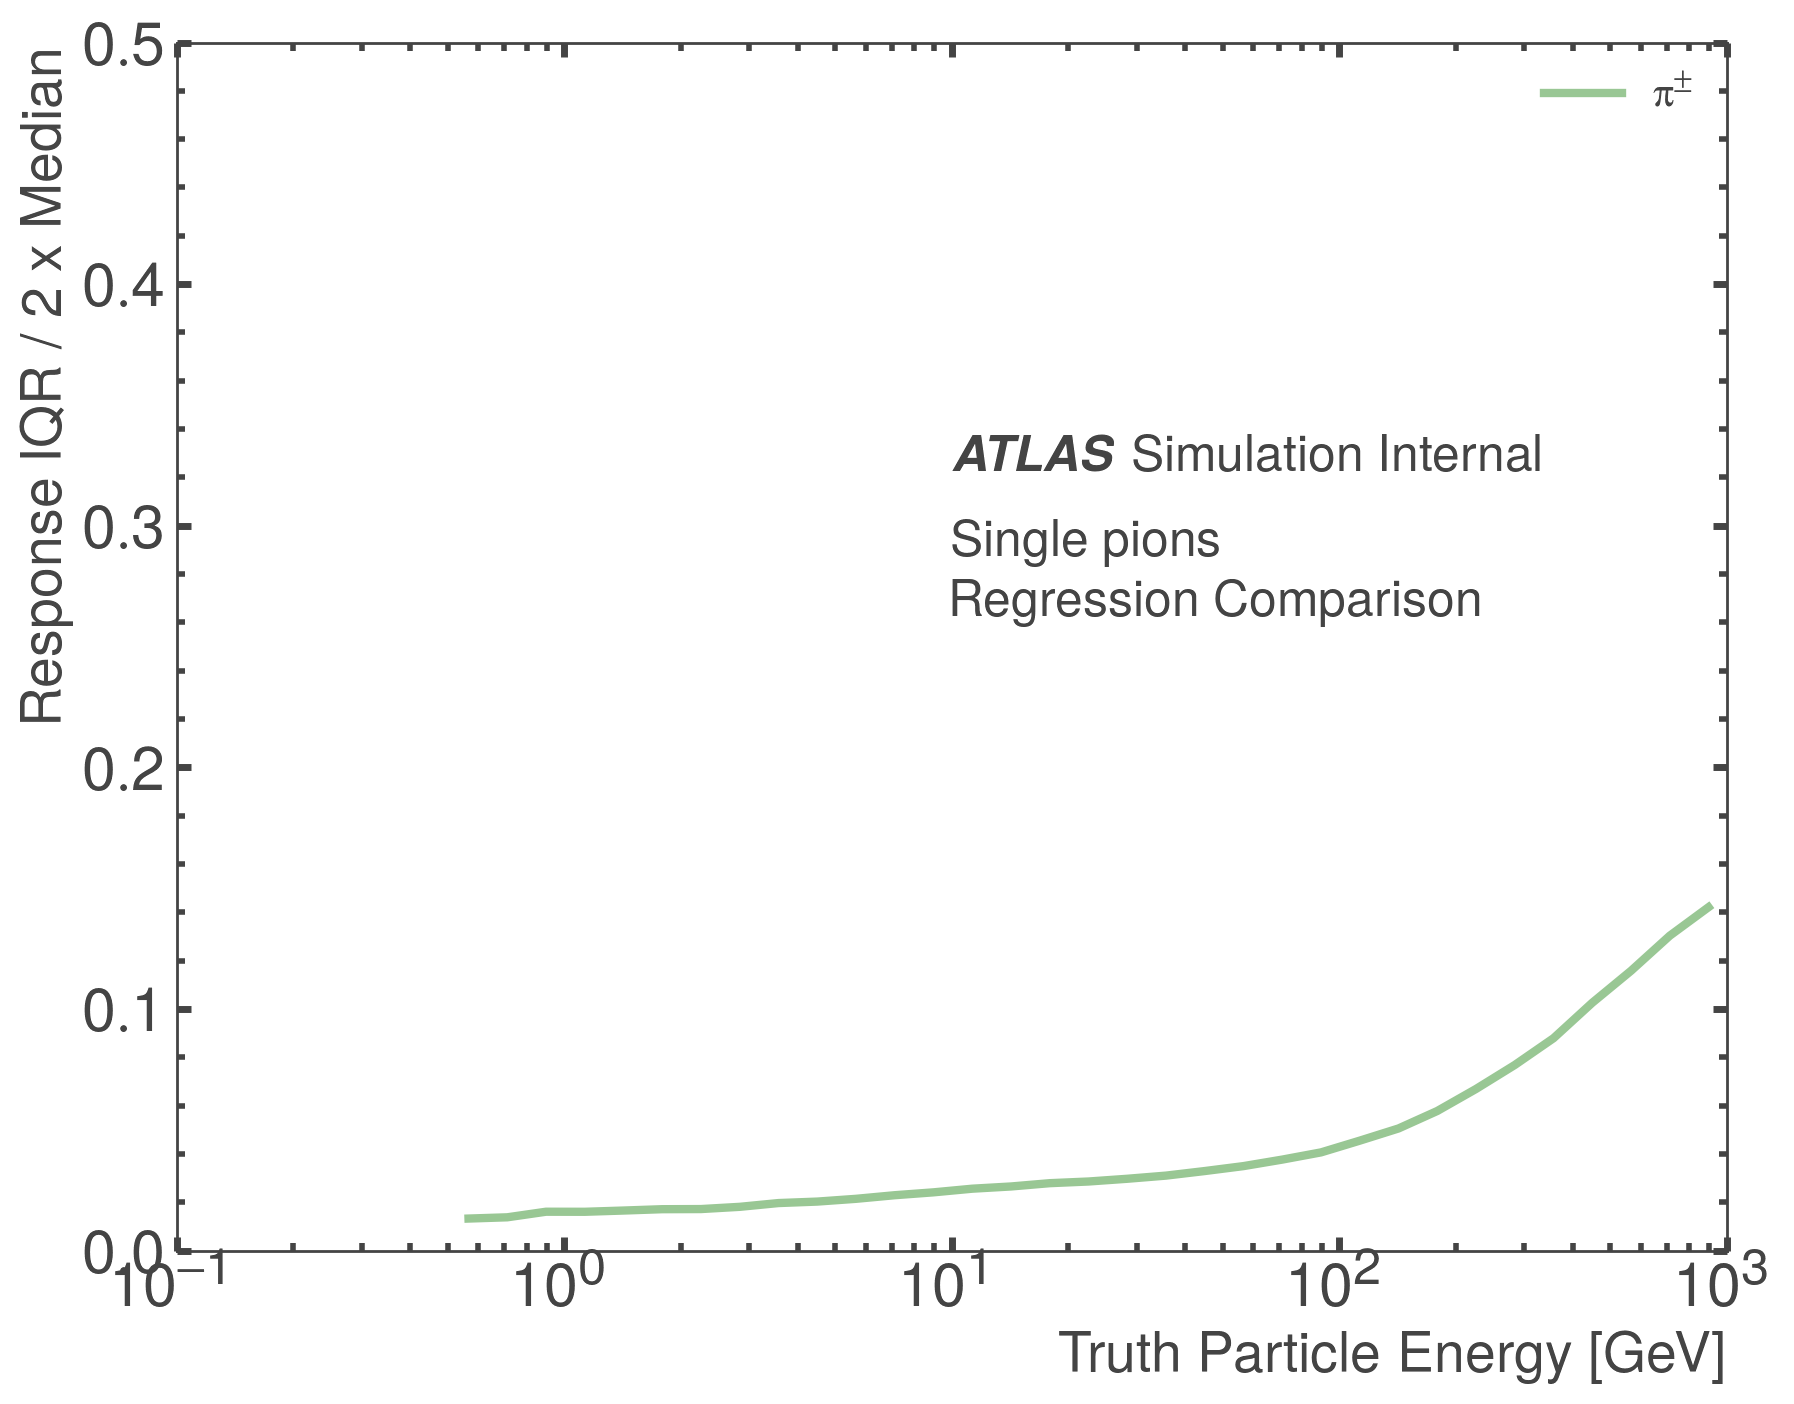


Plotting $\pi^{\pm}$
r2:0.994
PearsonR:0.997, SpearmanR:0.999, MSE:1251.498, MAE:12.040
Saving figure to ./pub_note_results/regress_gnn_allclusters_cells_all.pdf


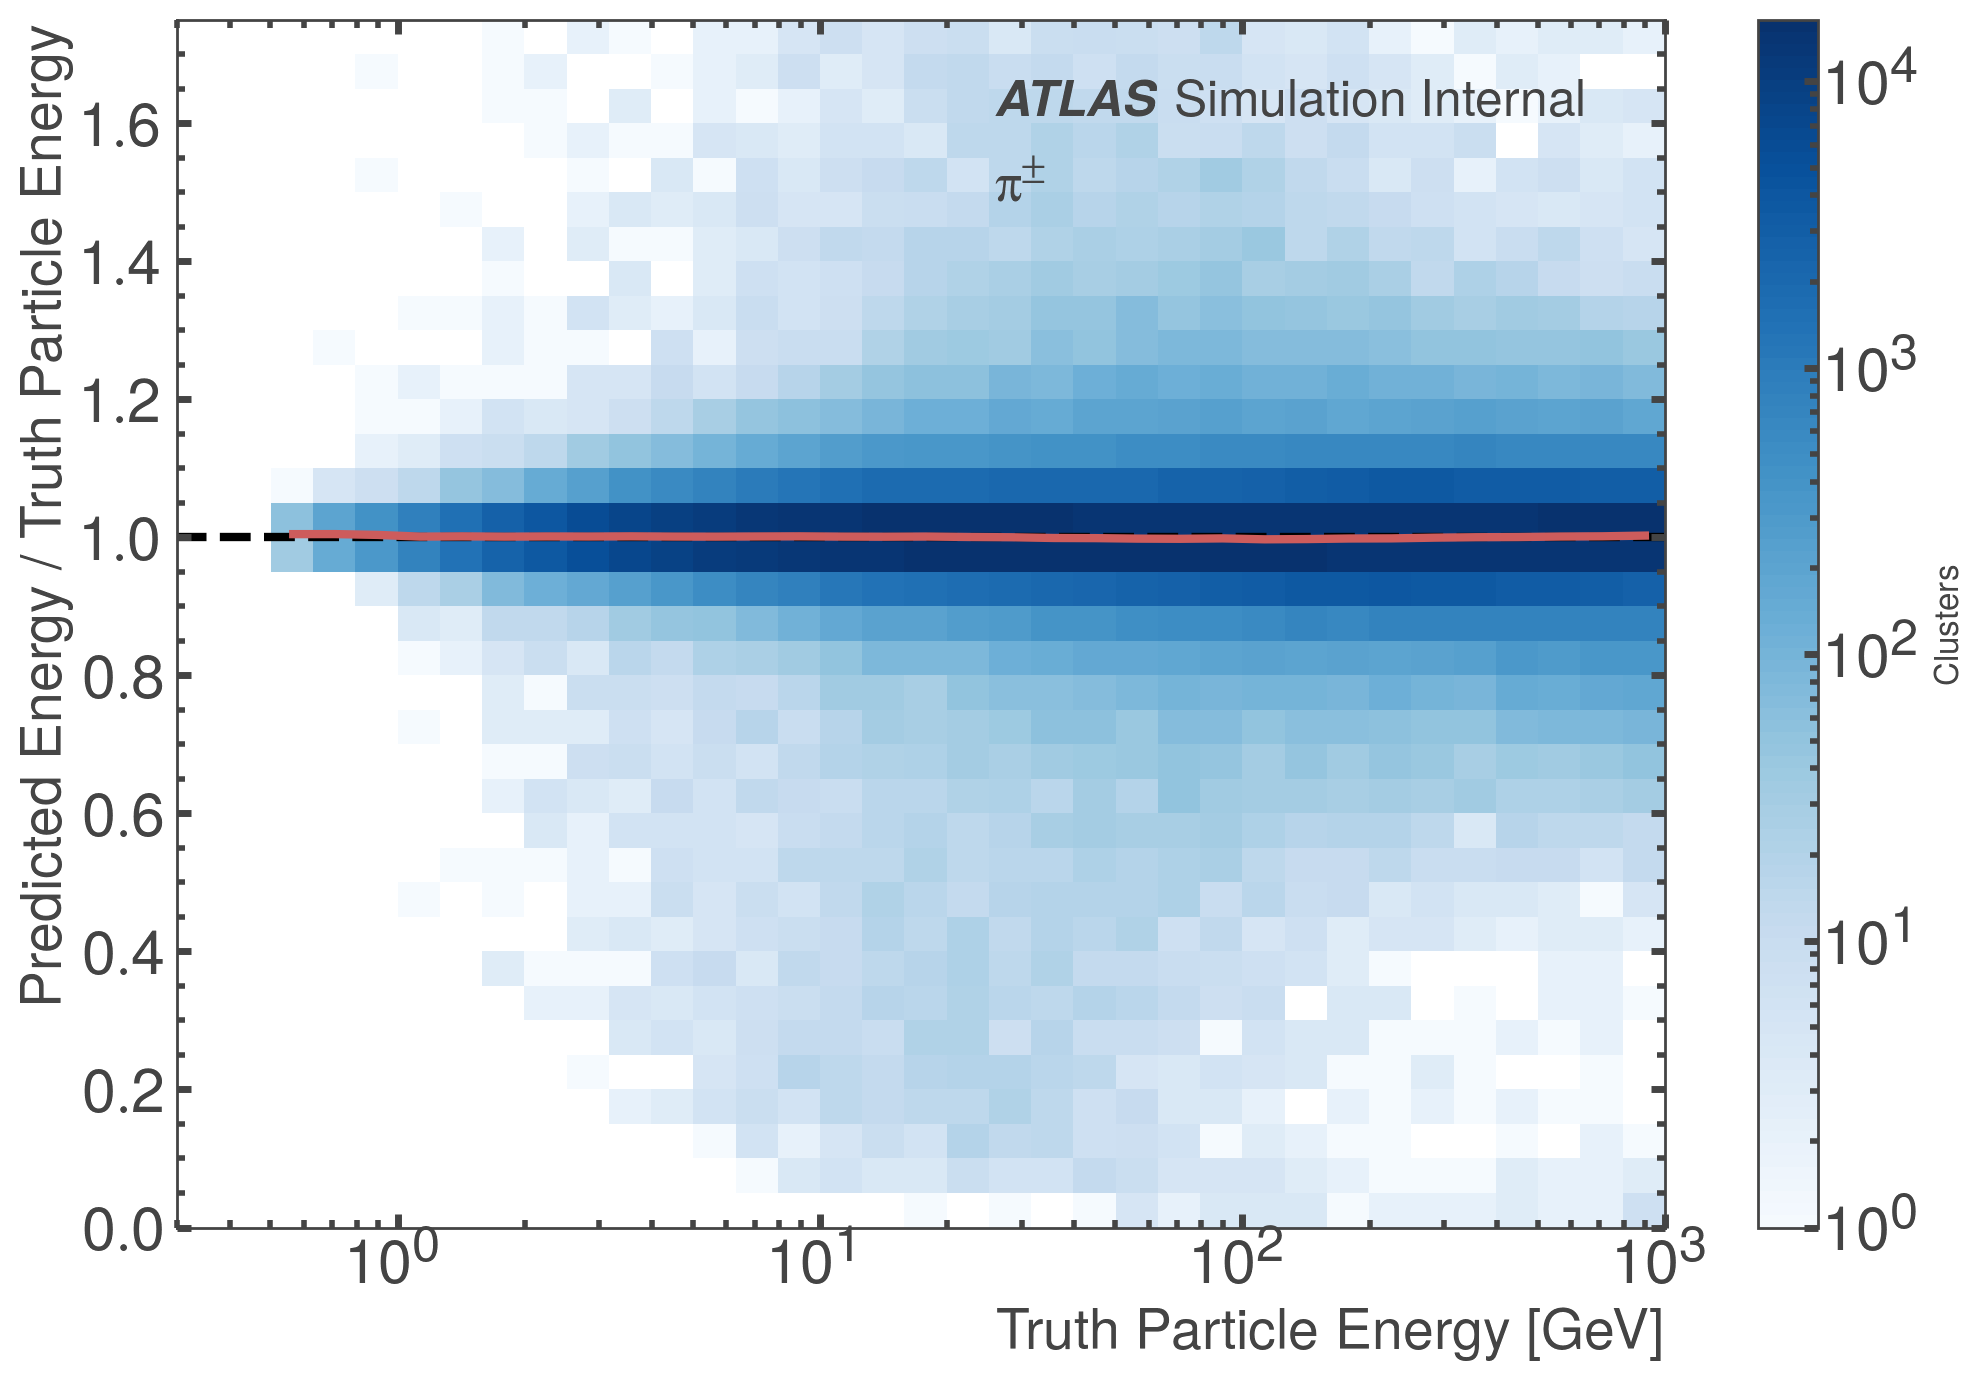

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

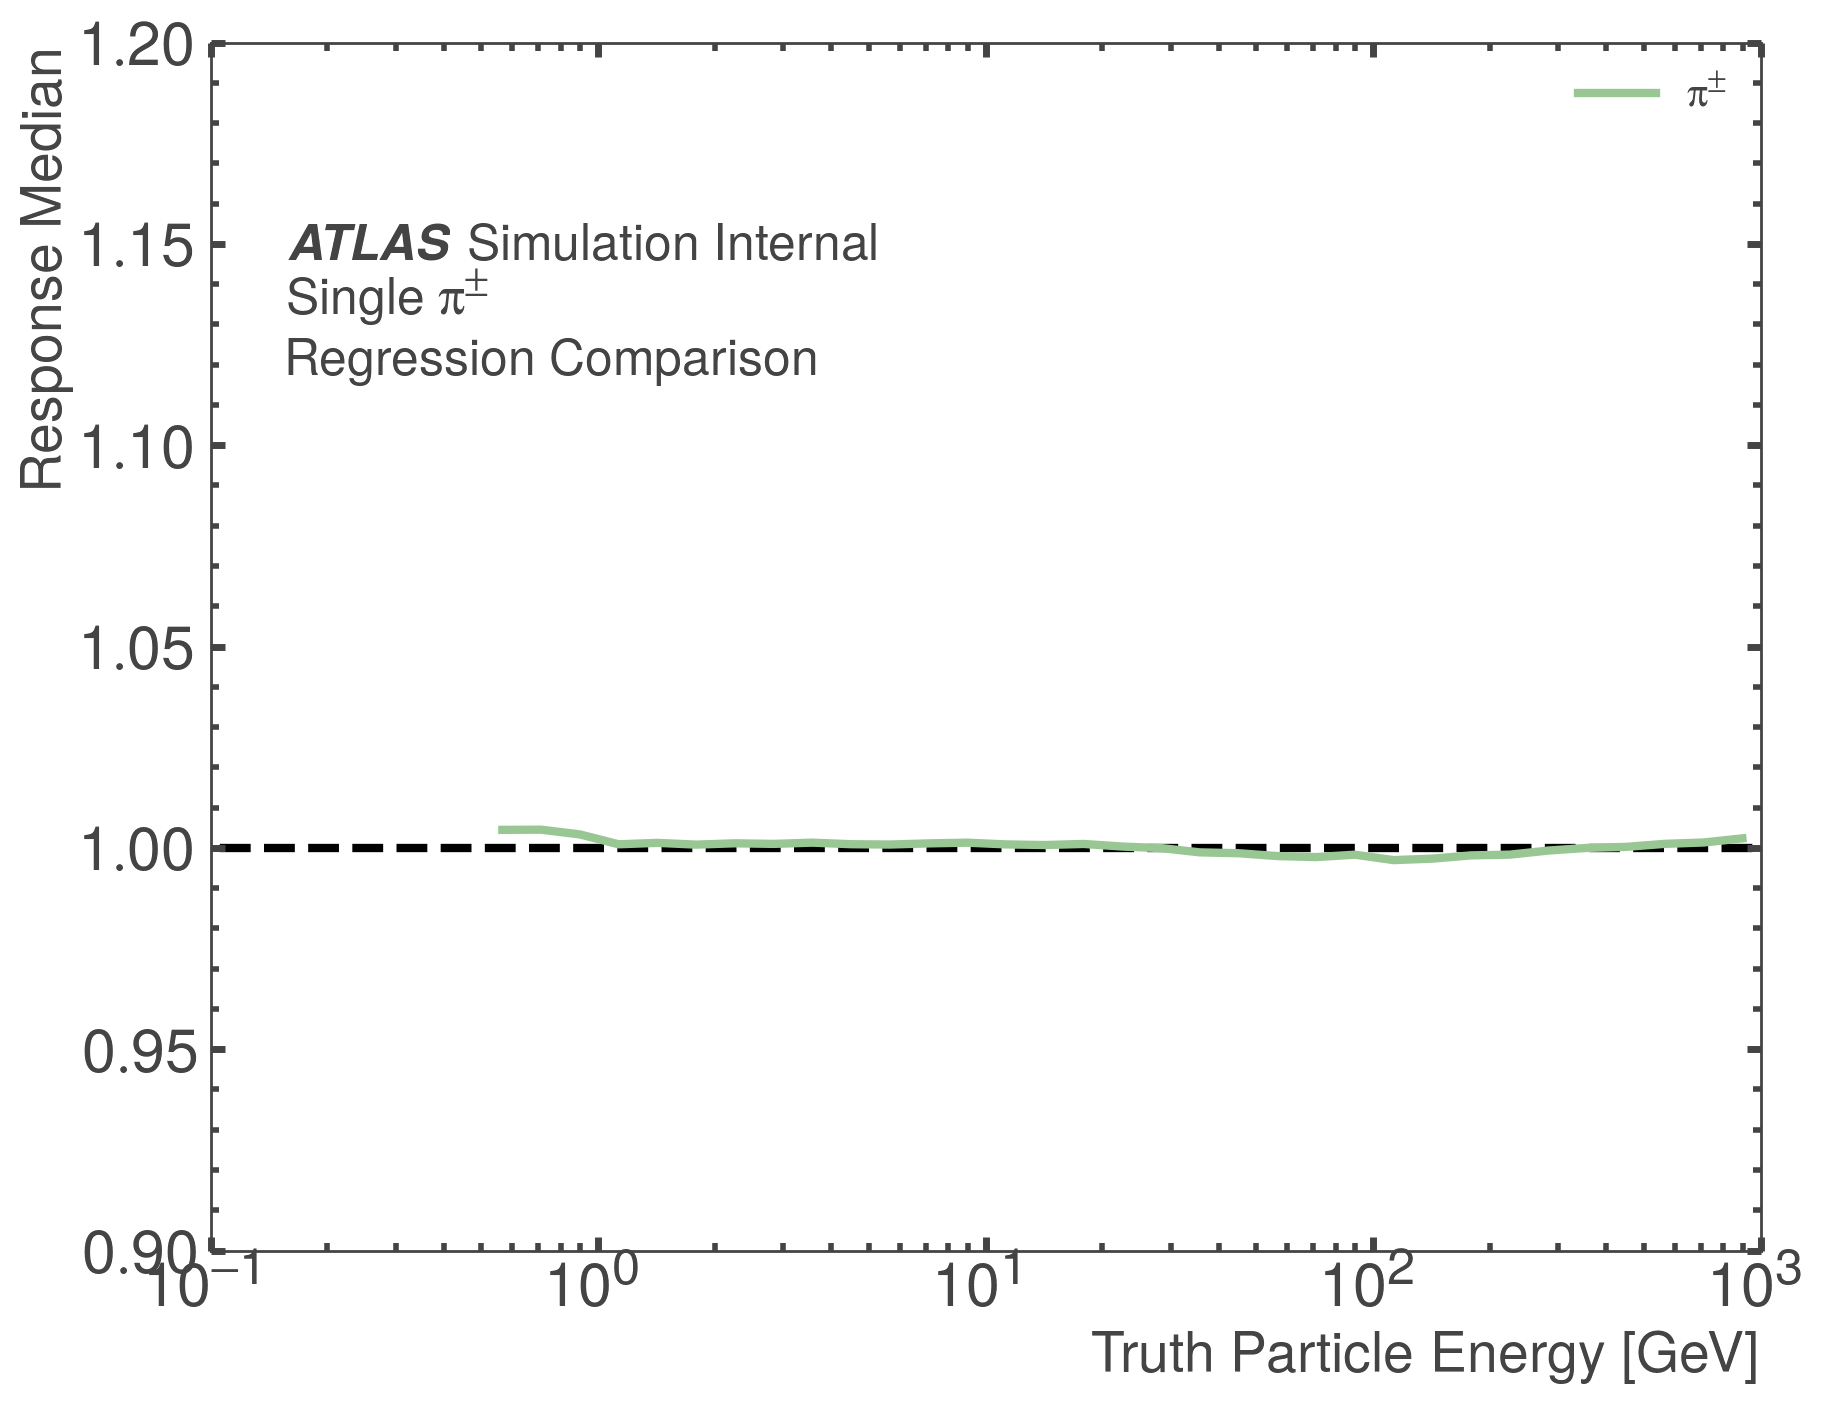


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

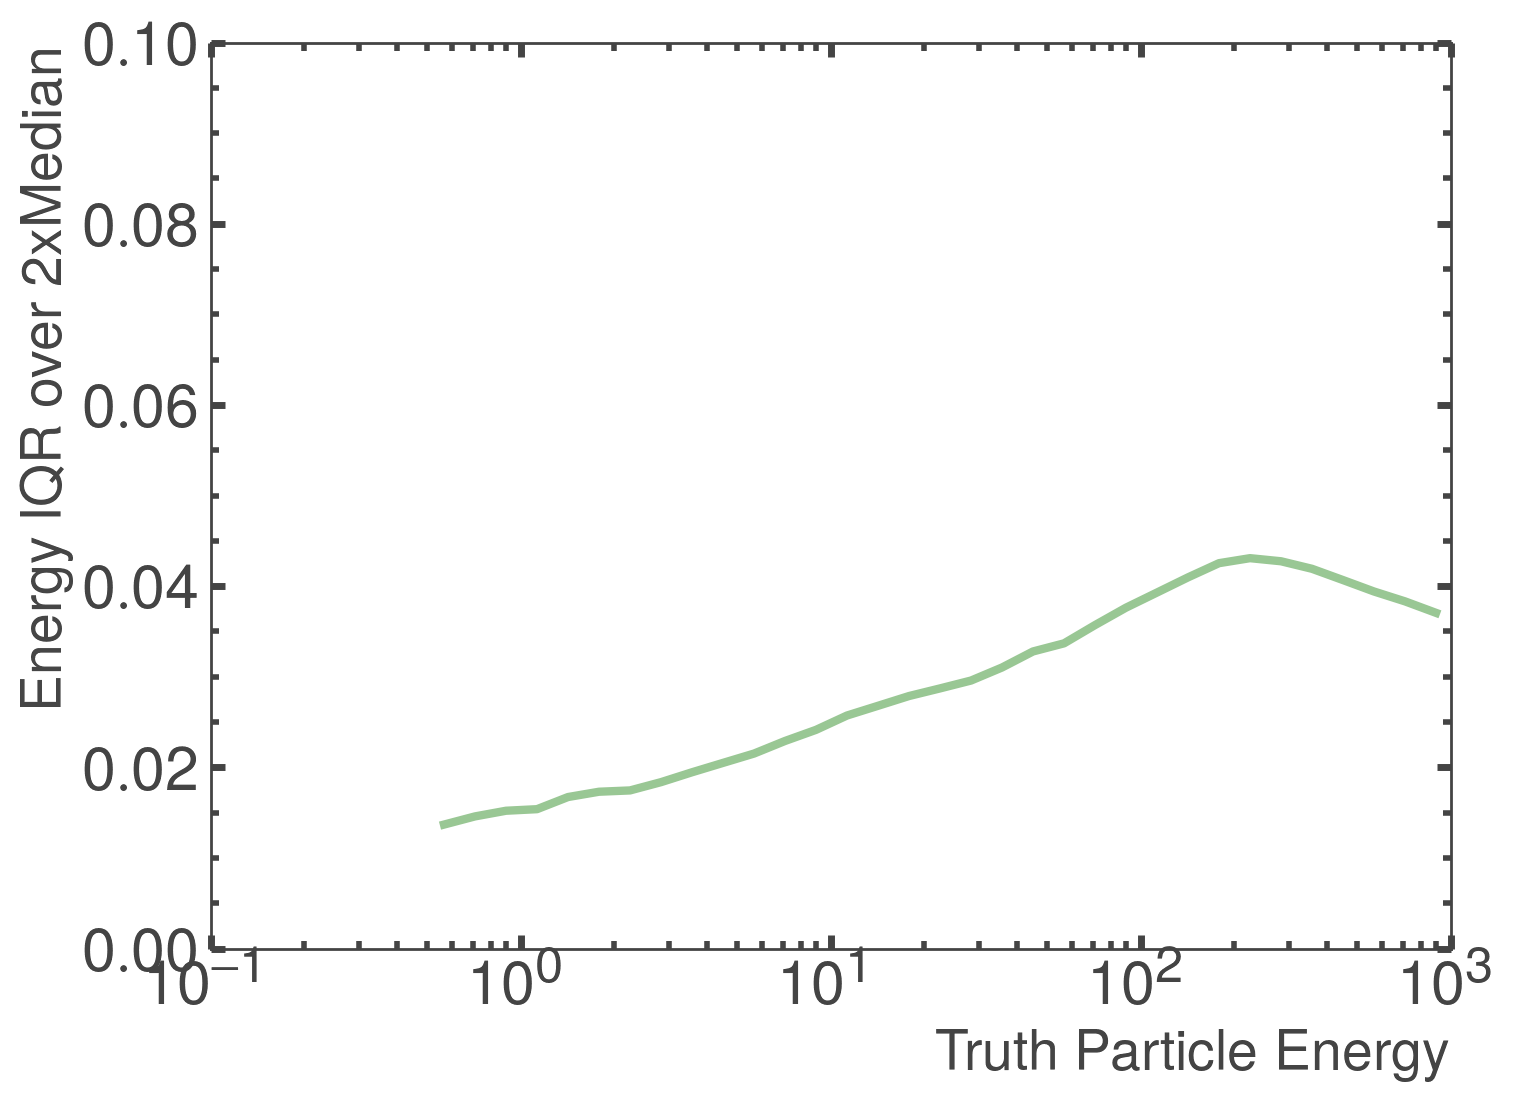

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

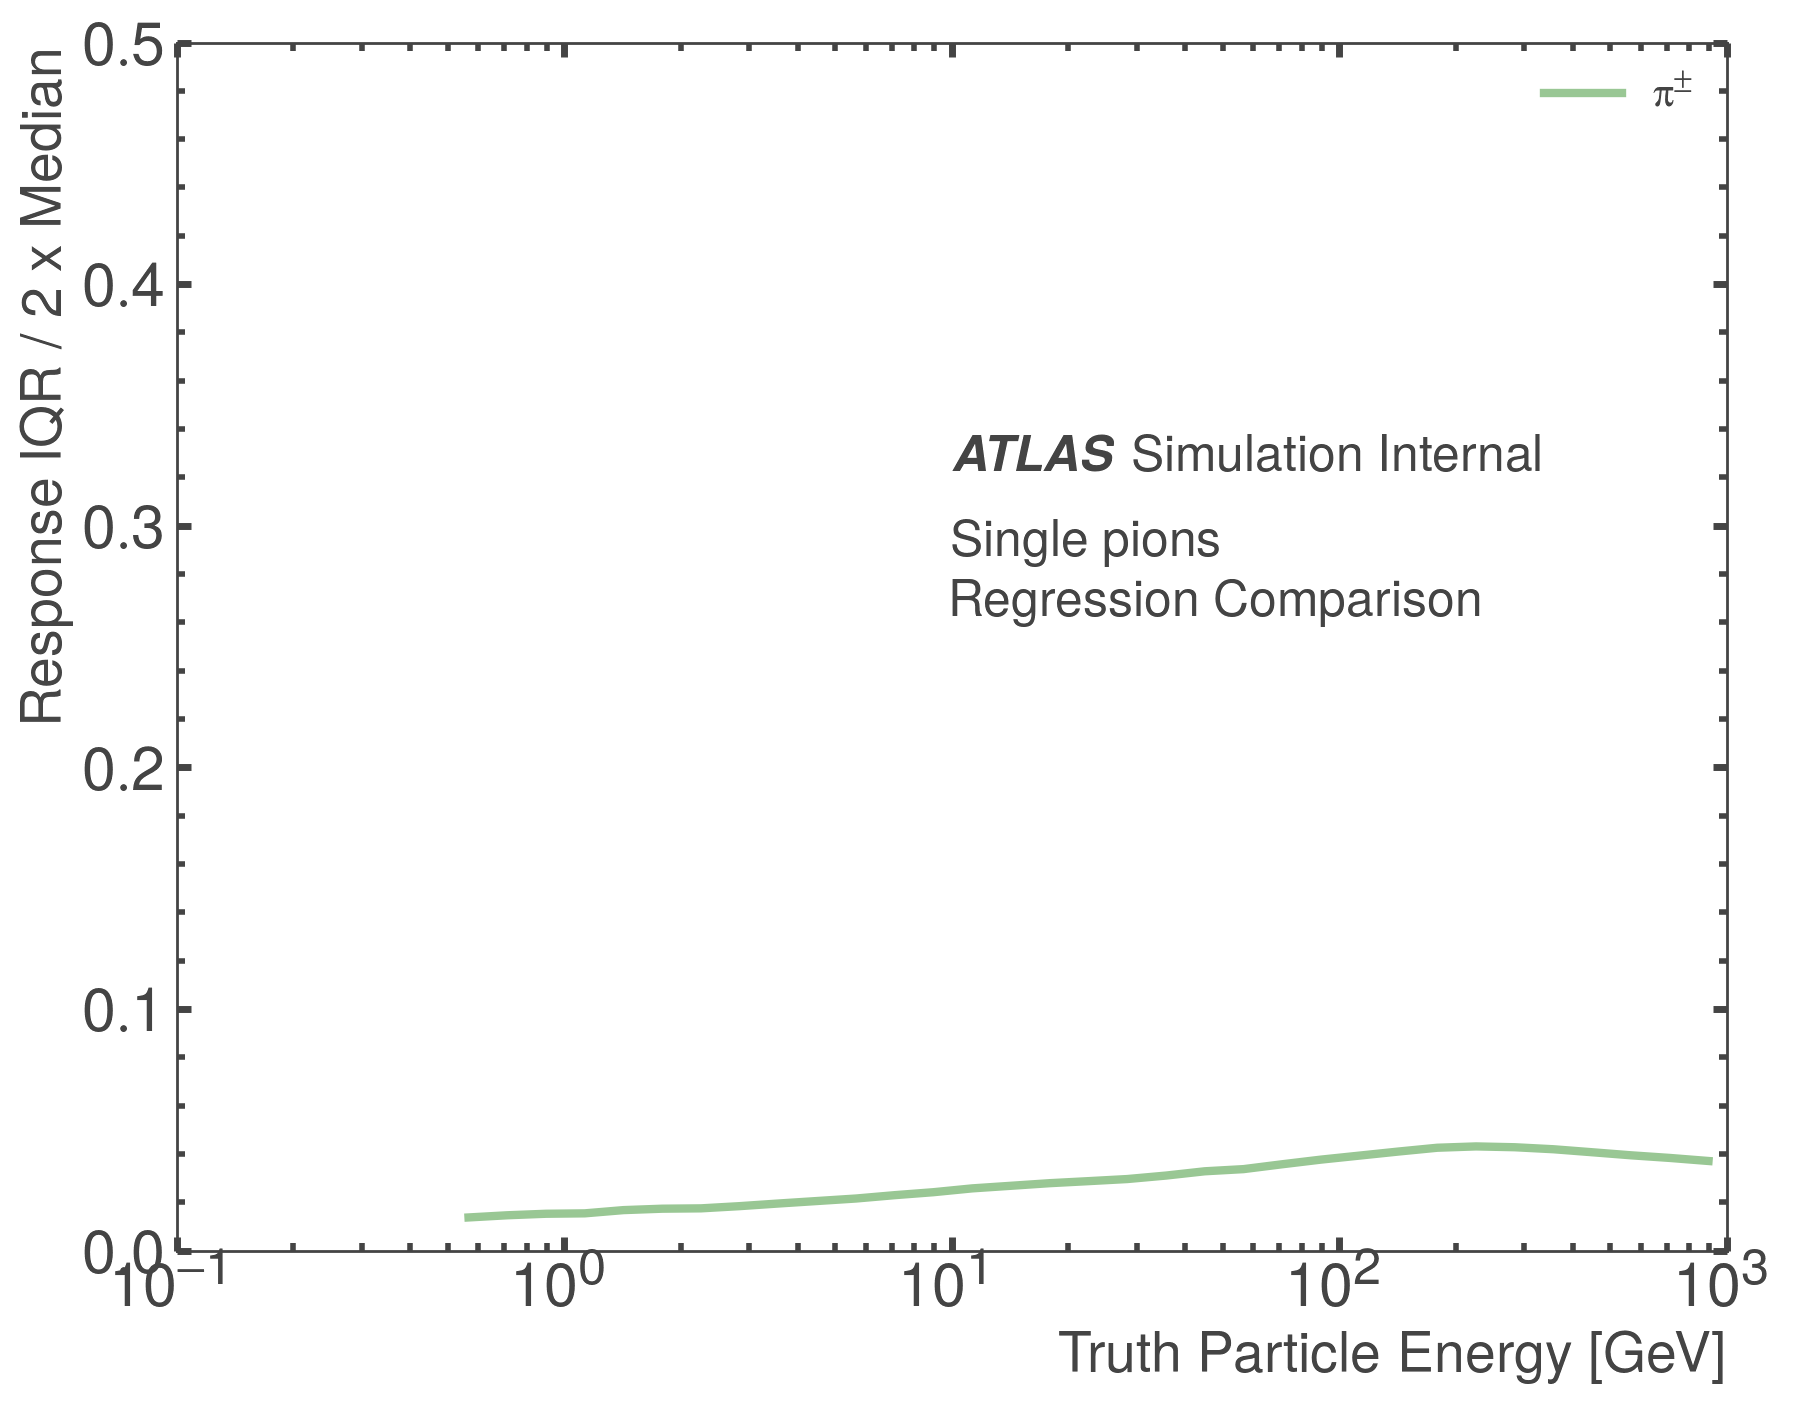


Plotting $\pi^{\pm}$
r2:0.990
PearsonR:0.995, SpearmanR:0.998, MSE:2142.776, MAE:17.576
Saving figure to ./pub_note_results/regress_deepsets_allclusters_nocells_all.pdf


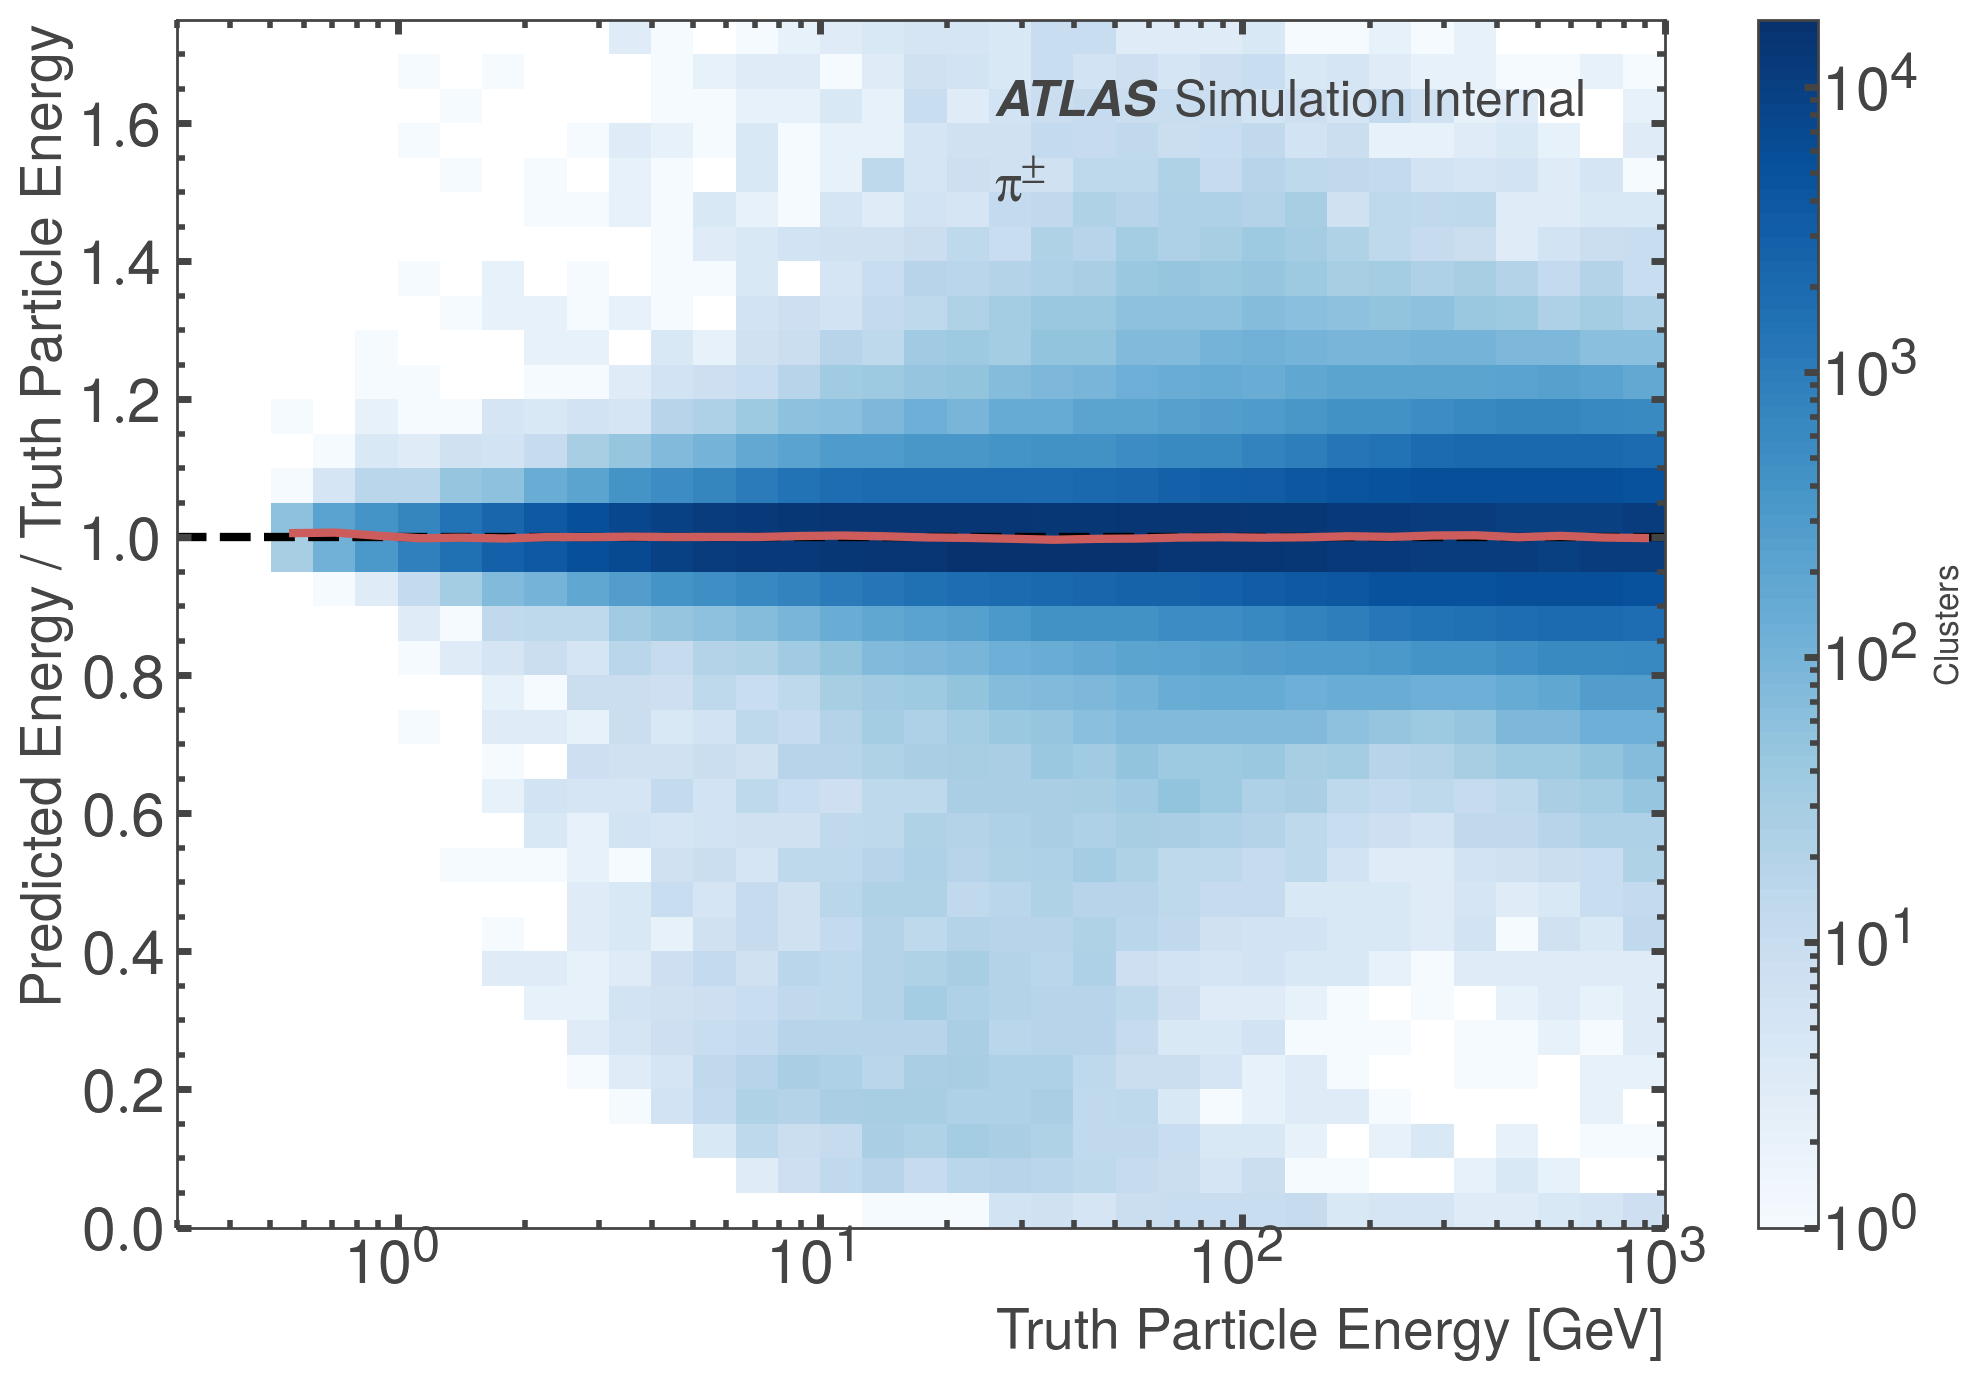

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

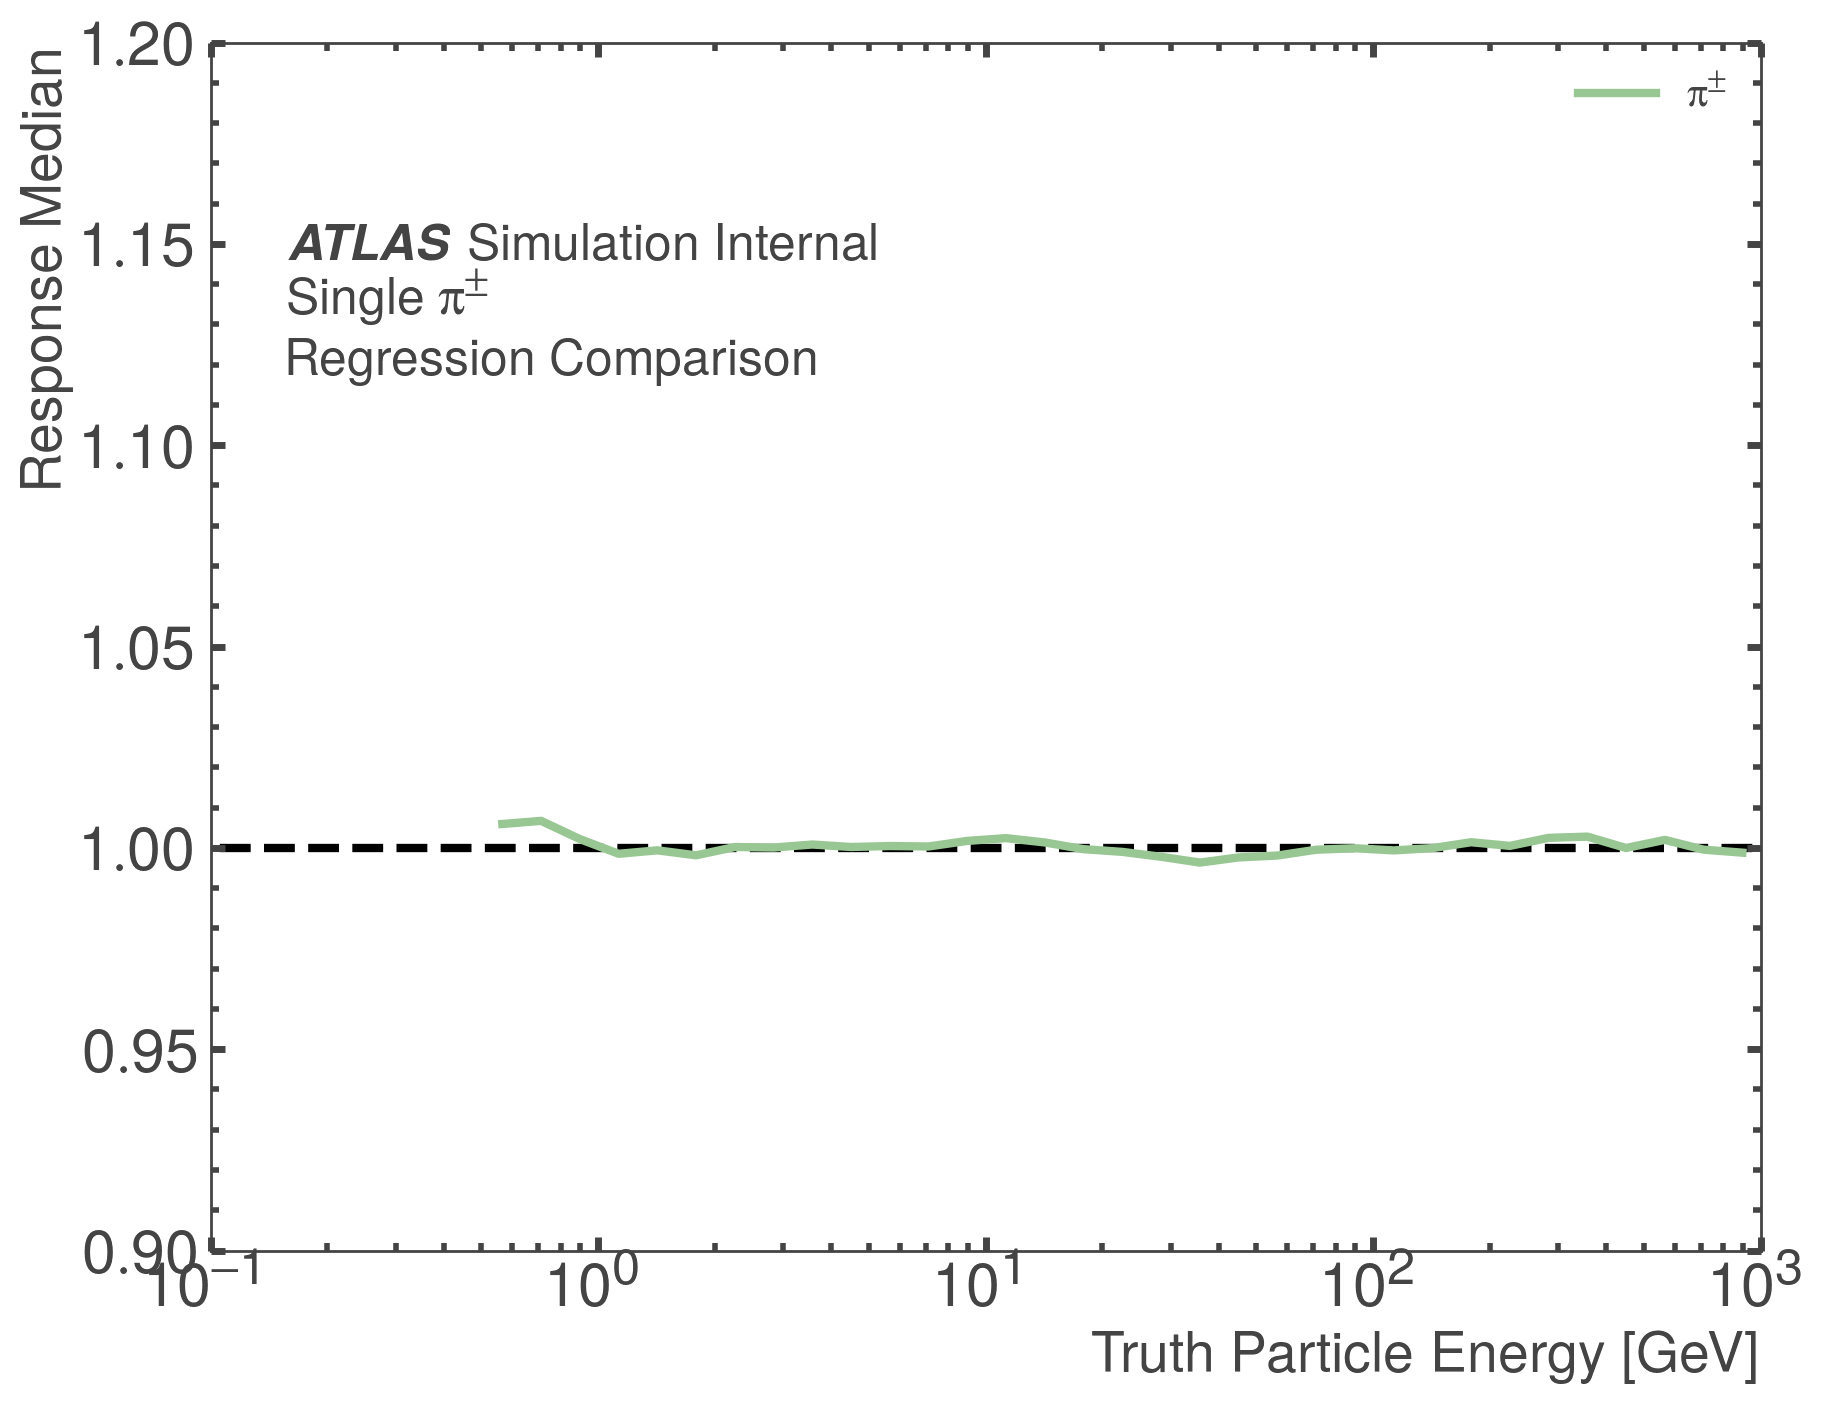


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

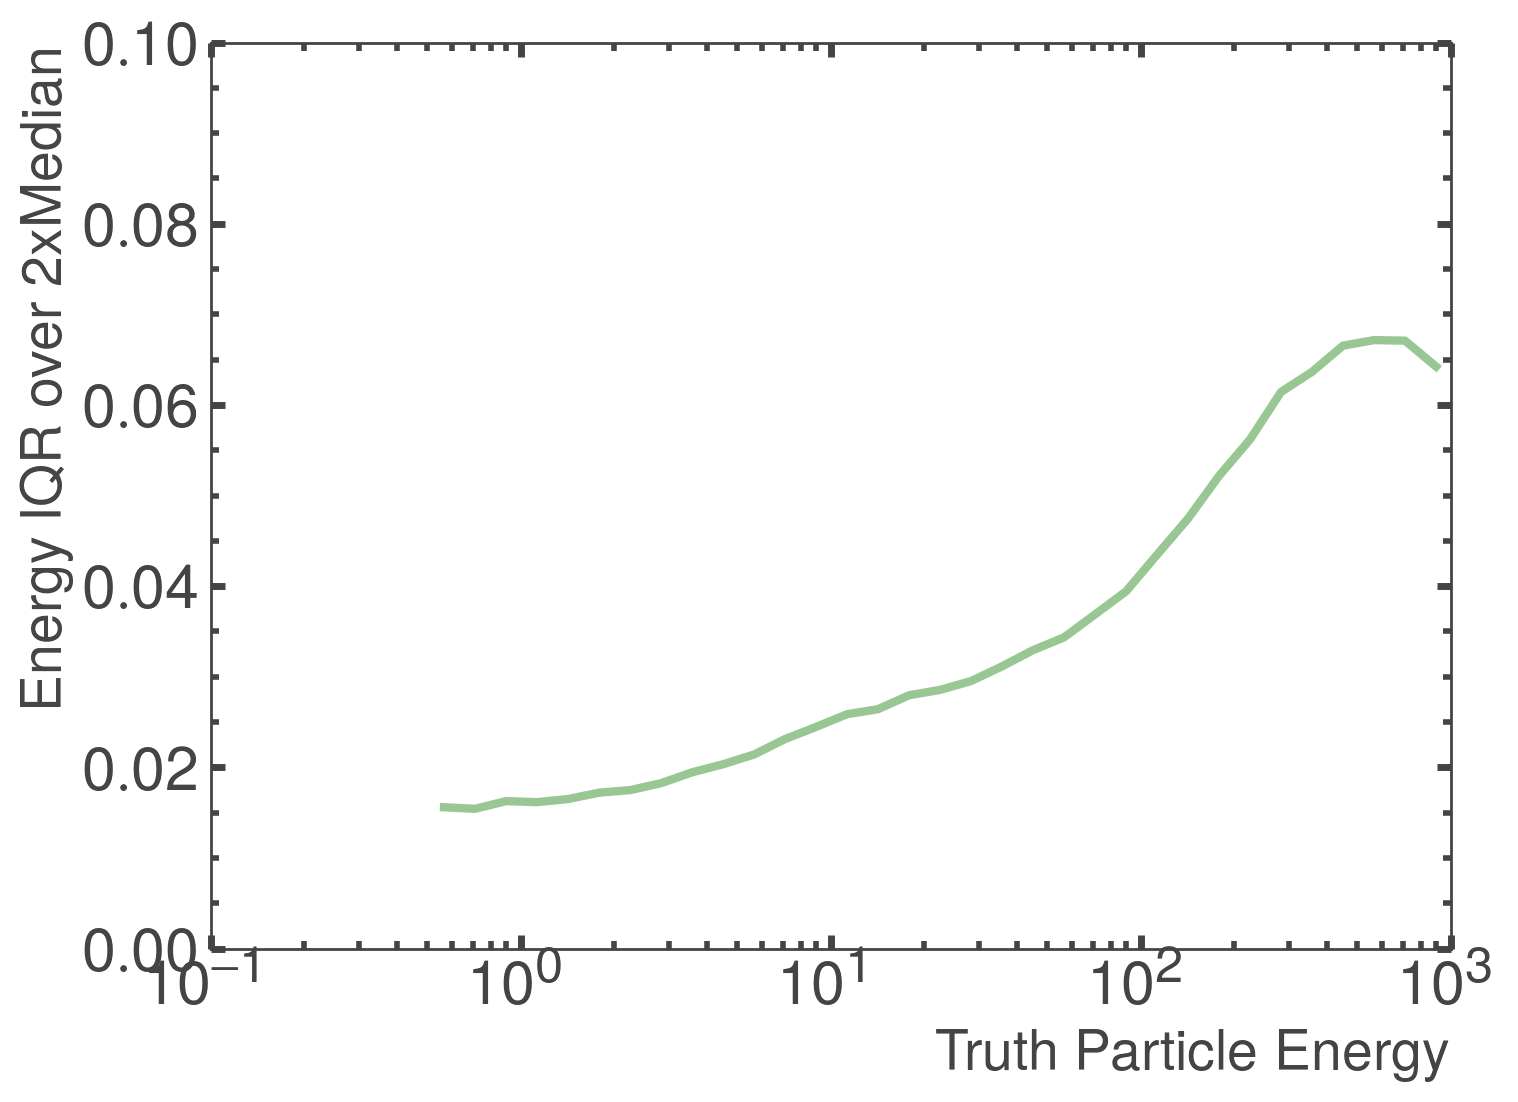

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

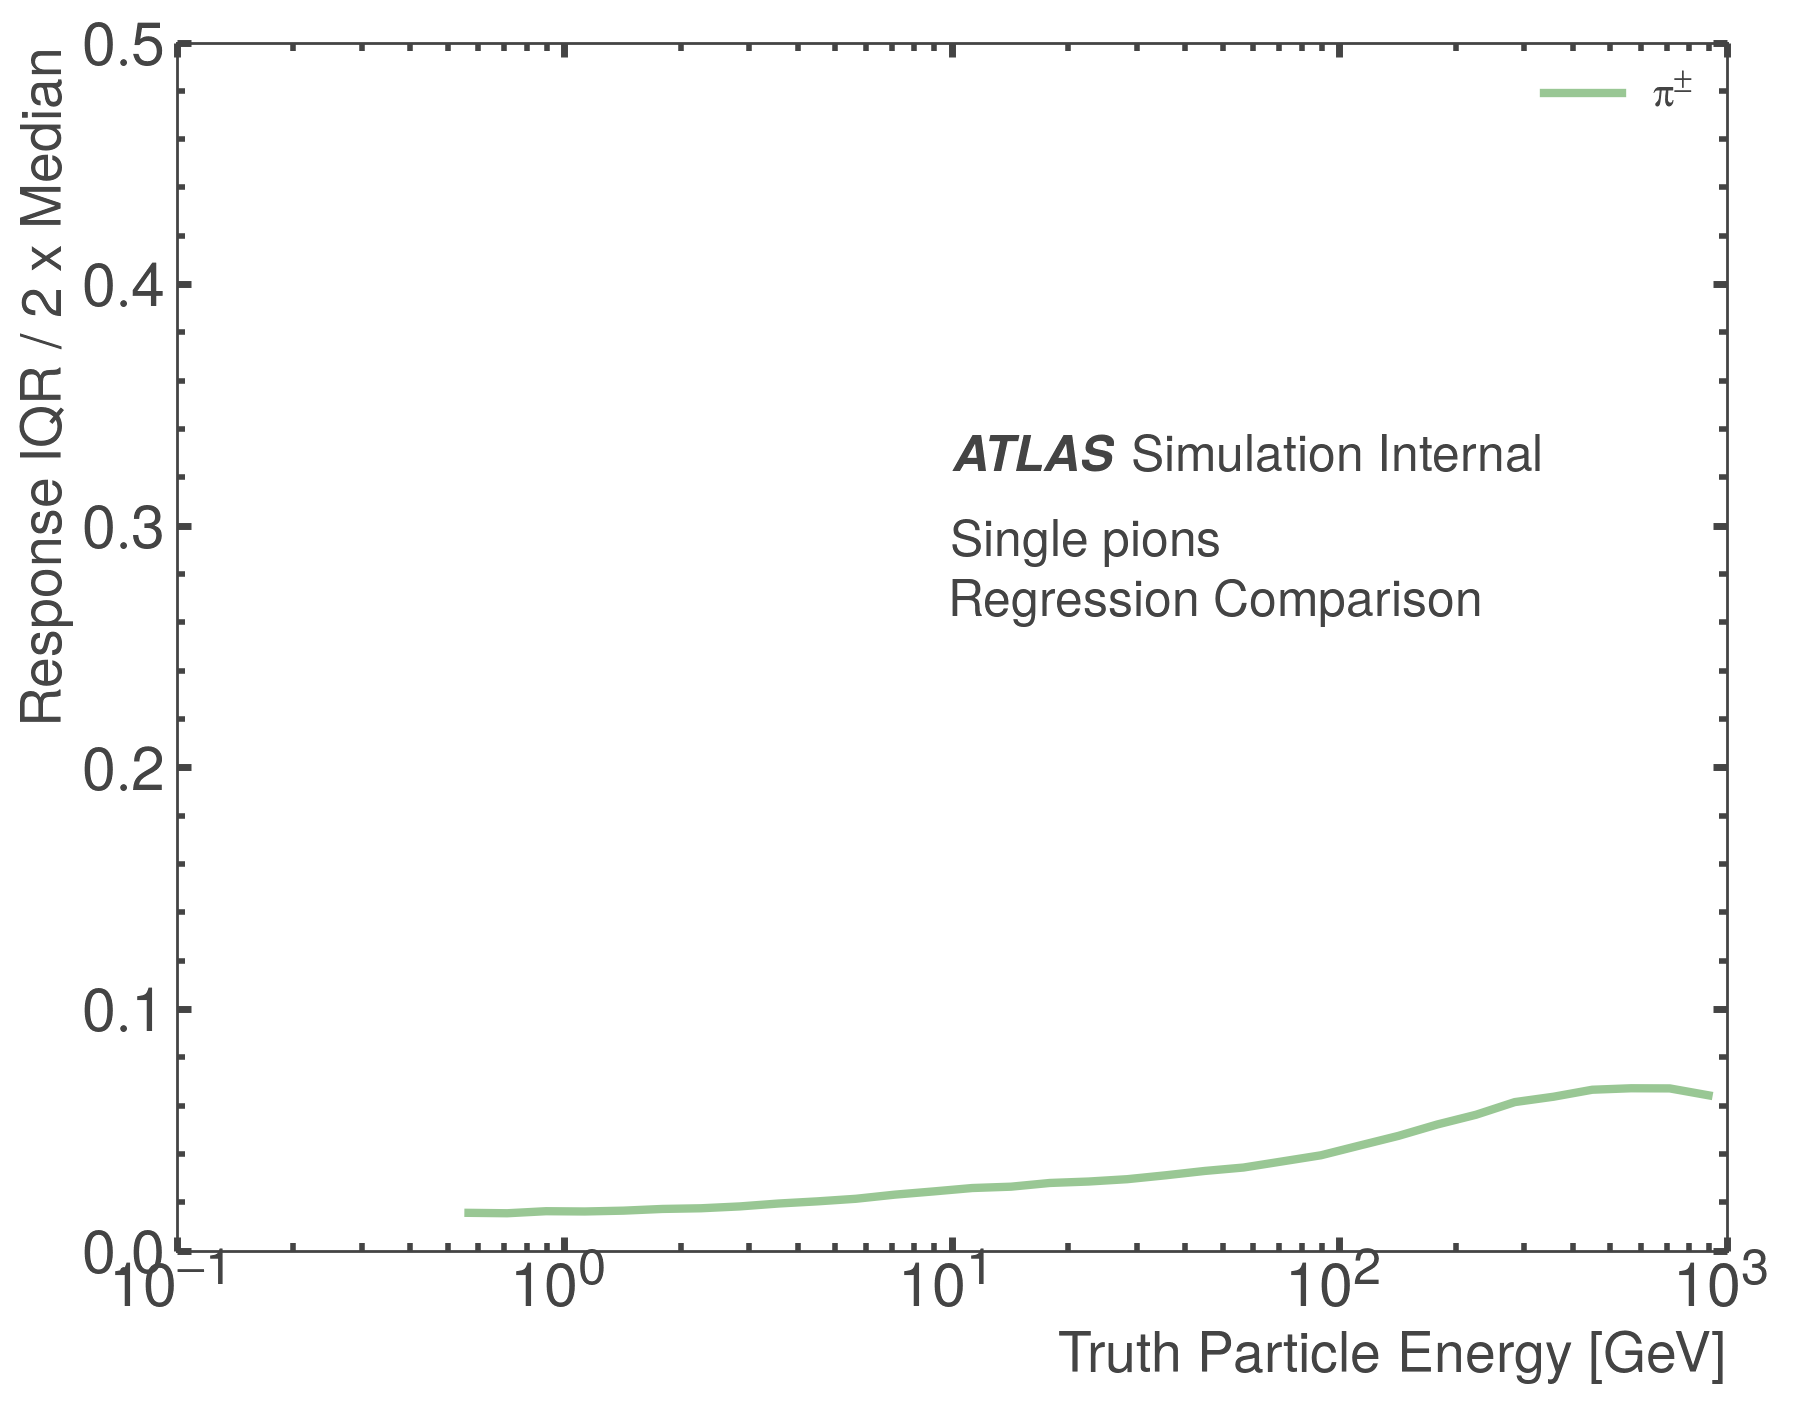


Plotting $\pi^{\pm}$
r2:0.995
PearsonR:0.998, SpearmanR:0.999, MSE:1070.584, MAE:11.164
Saving figure to ./pub_note_results/regress_deepsets_allclusters_cells_all.pdf


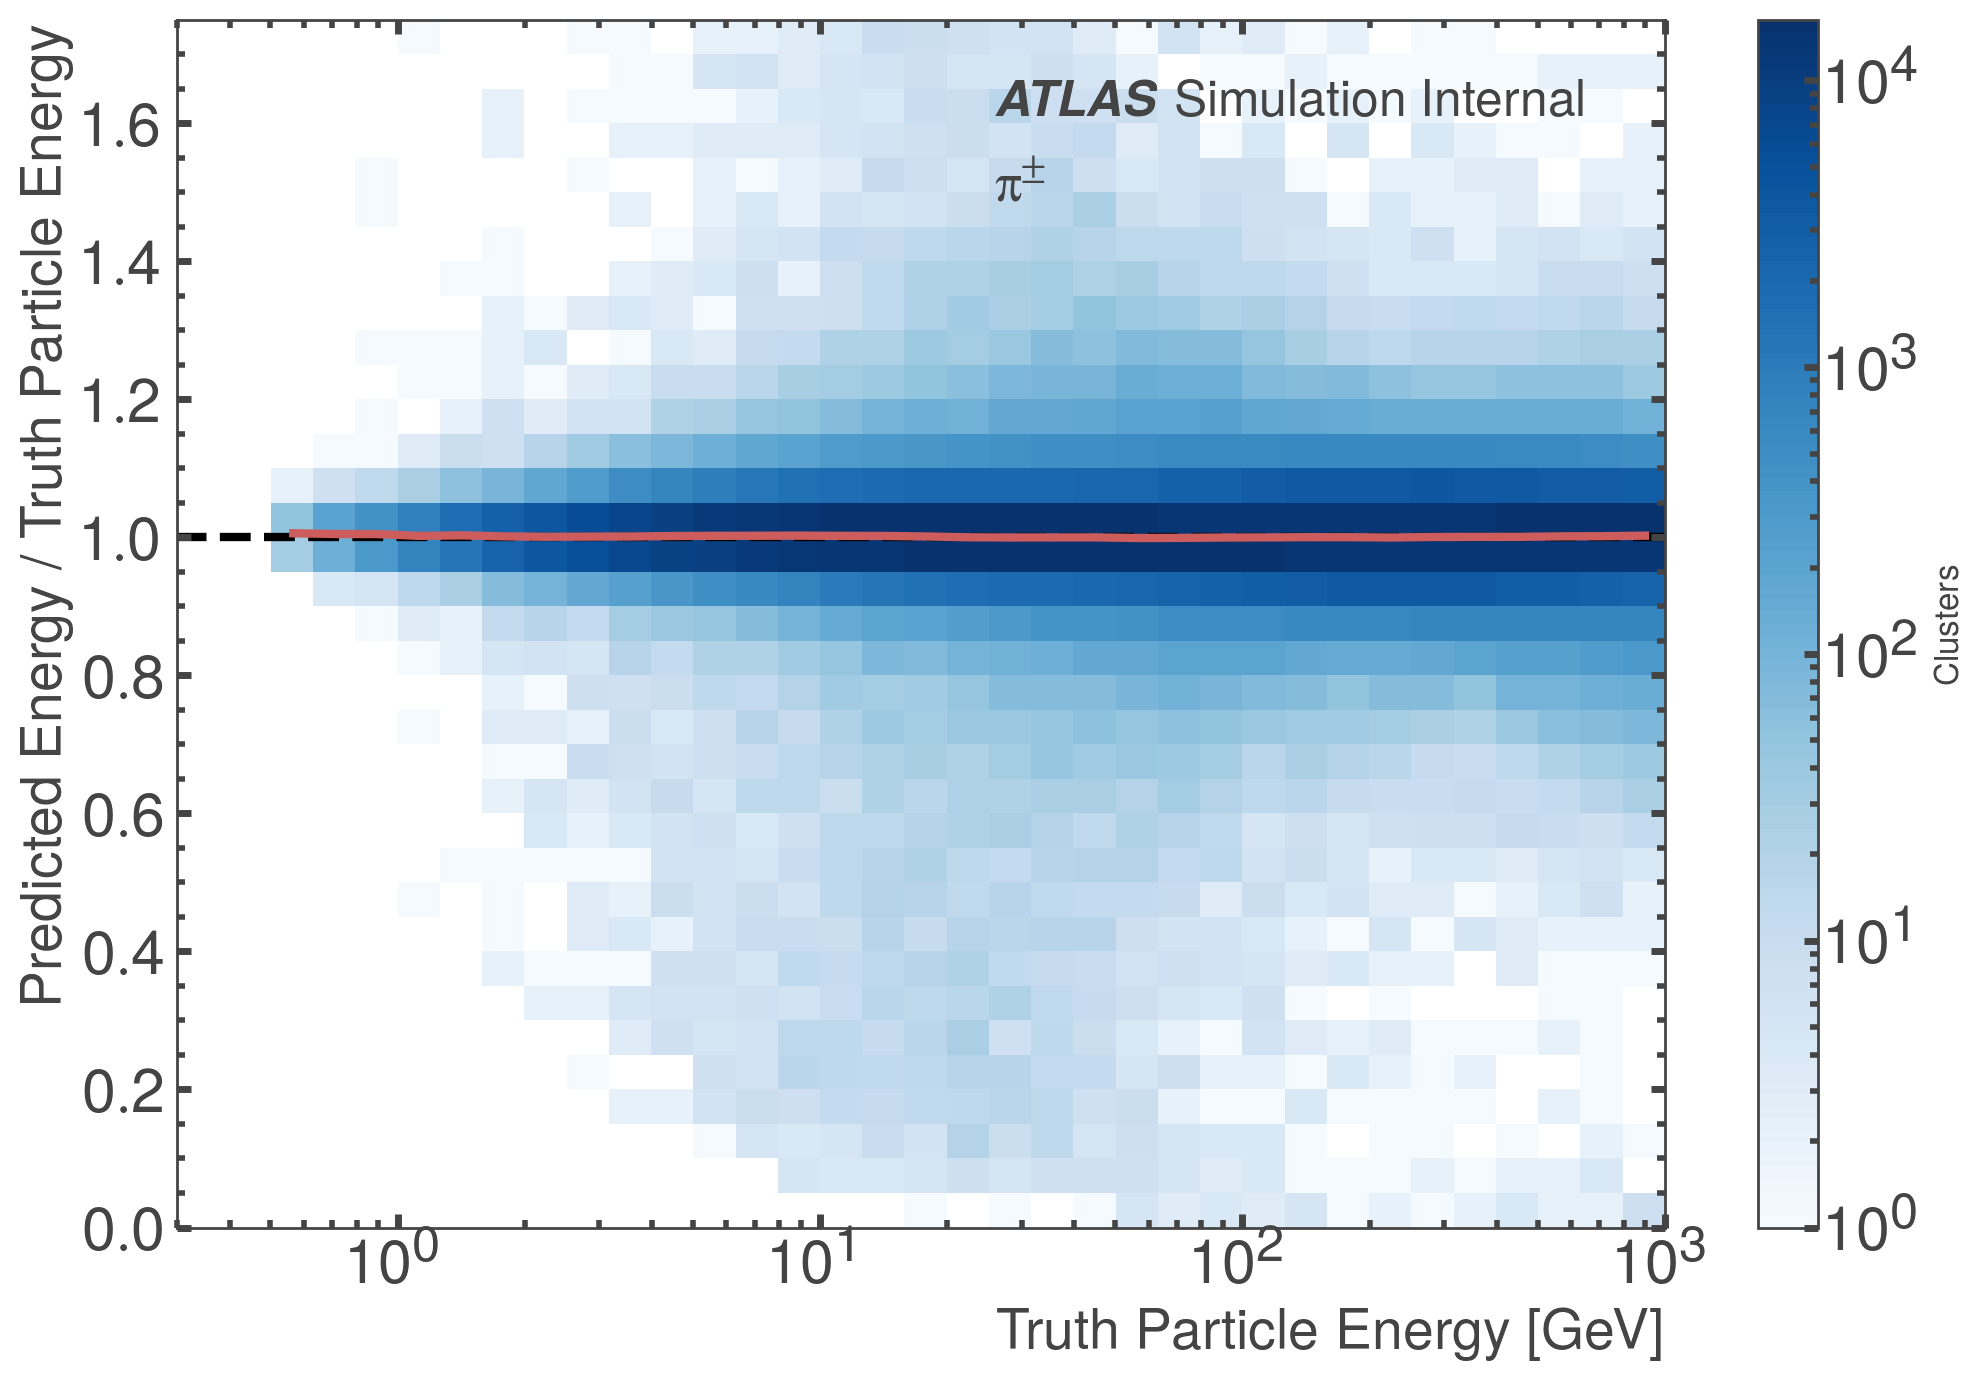

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

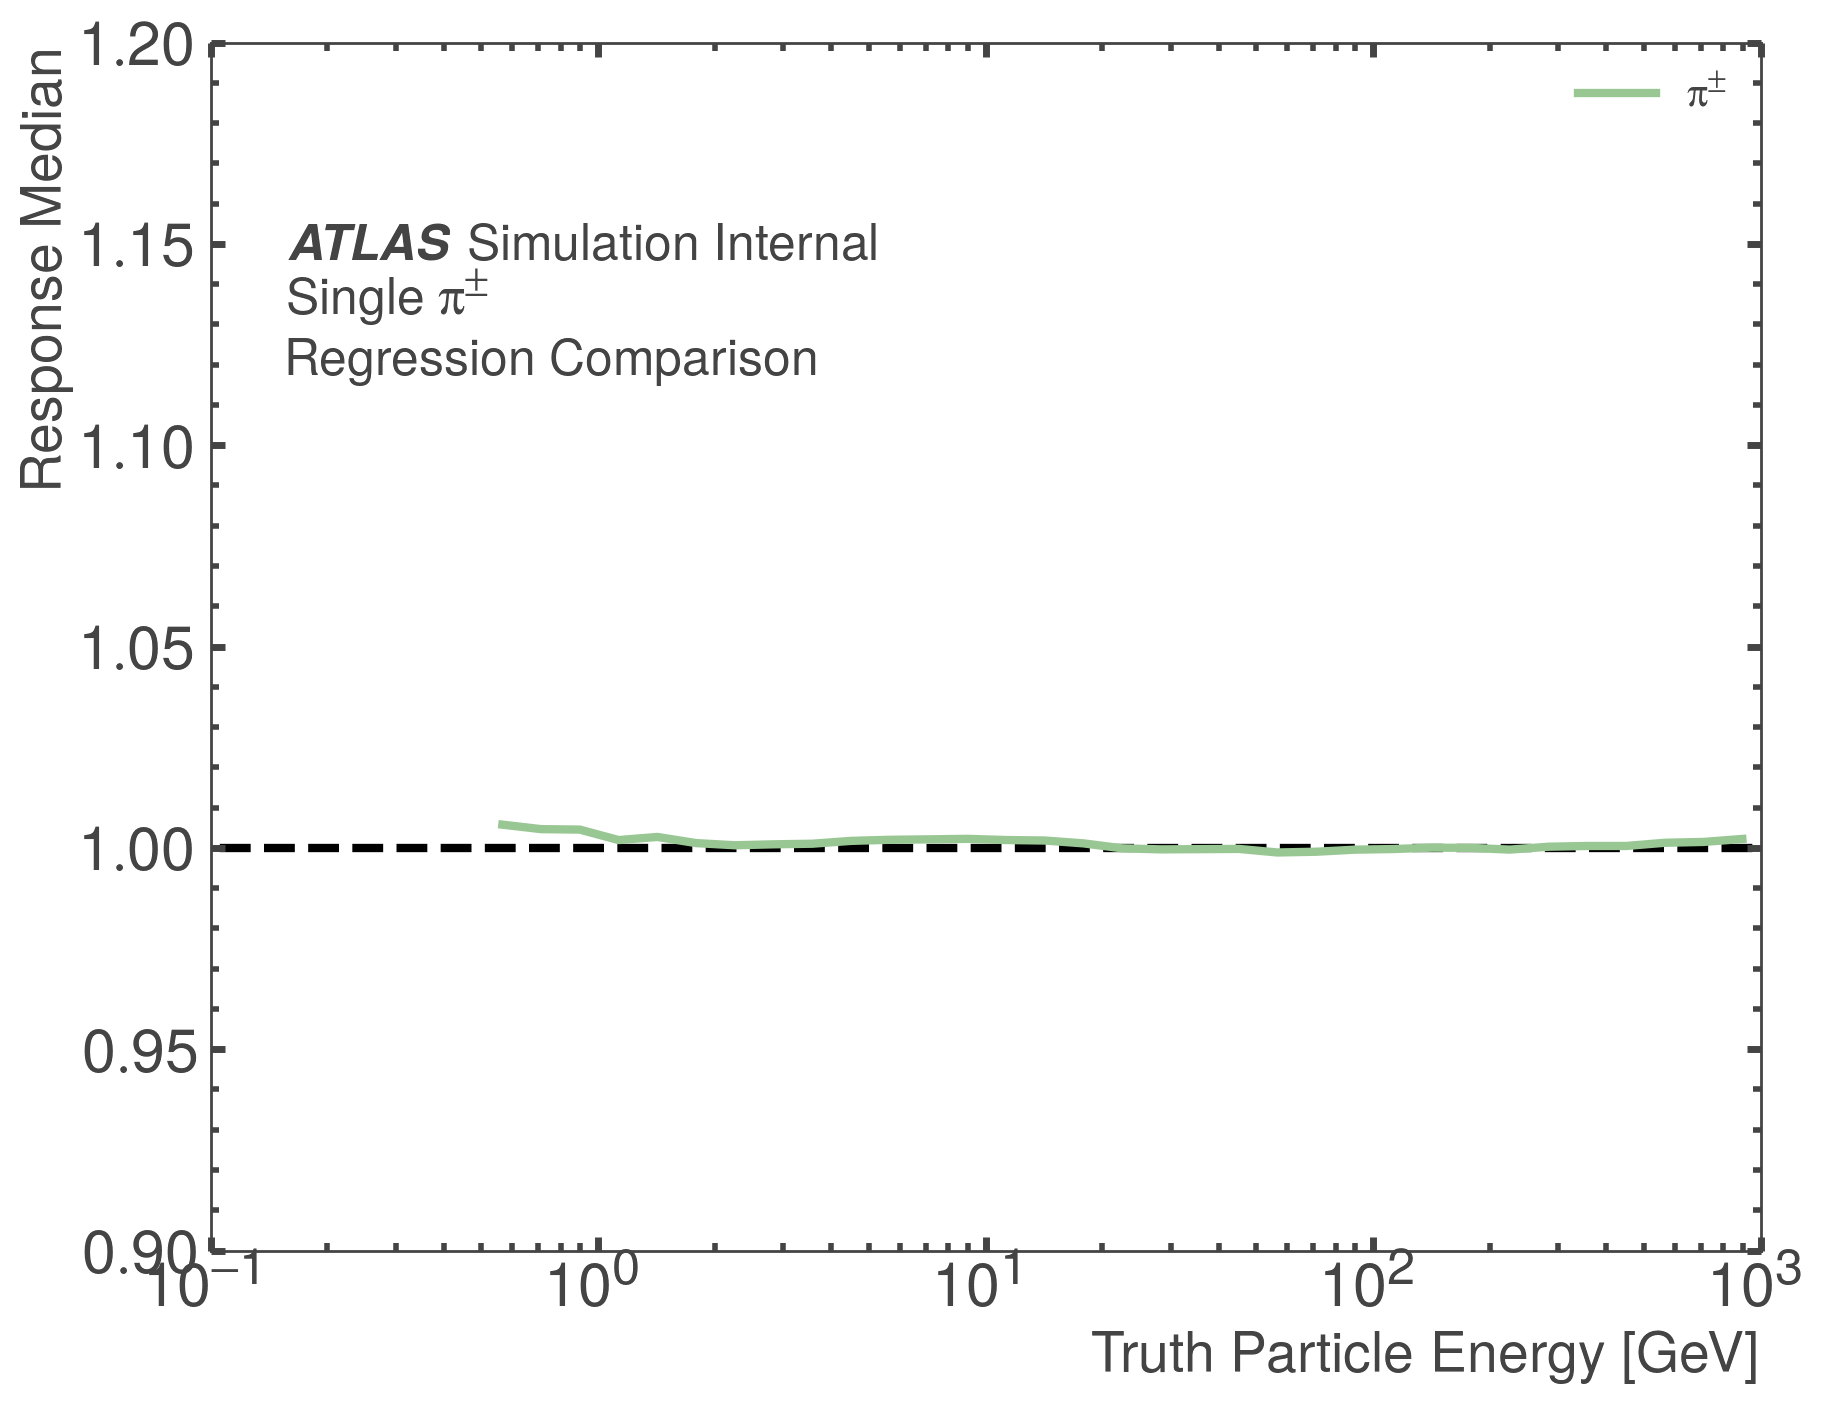


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

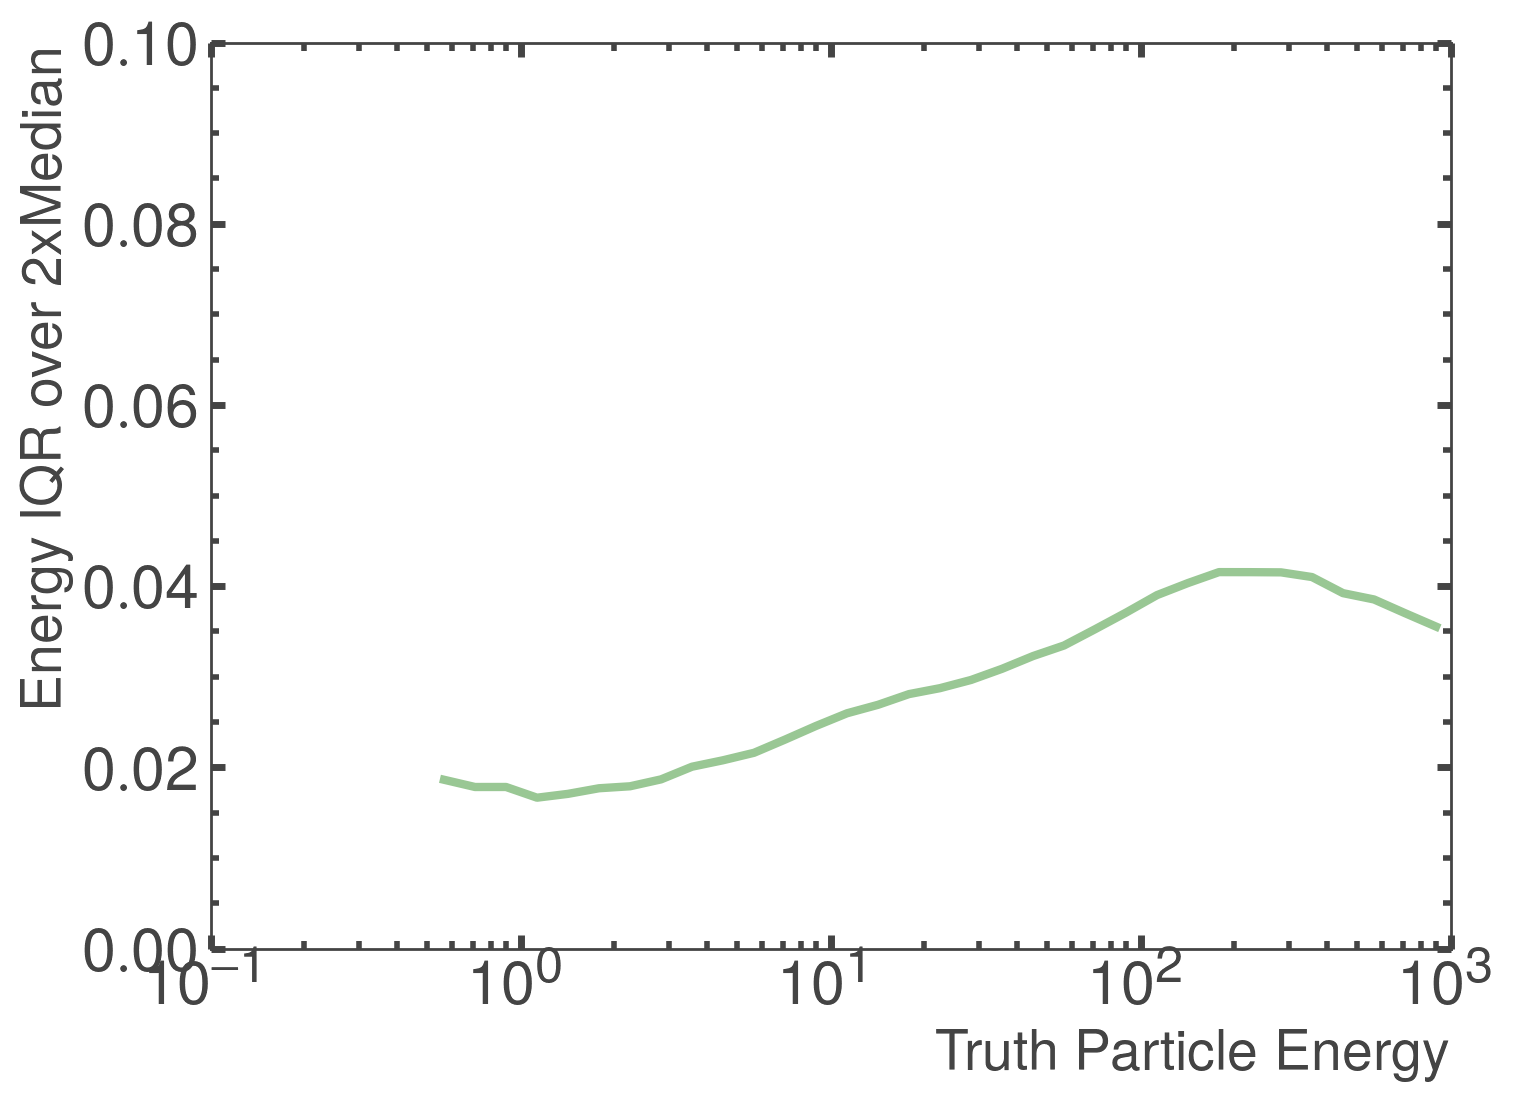

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

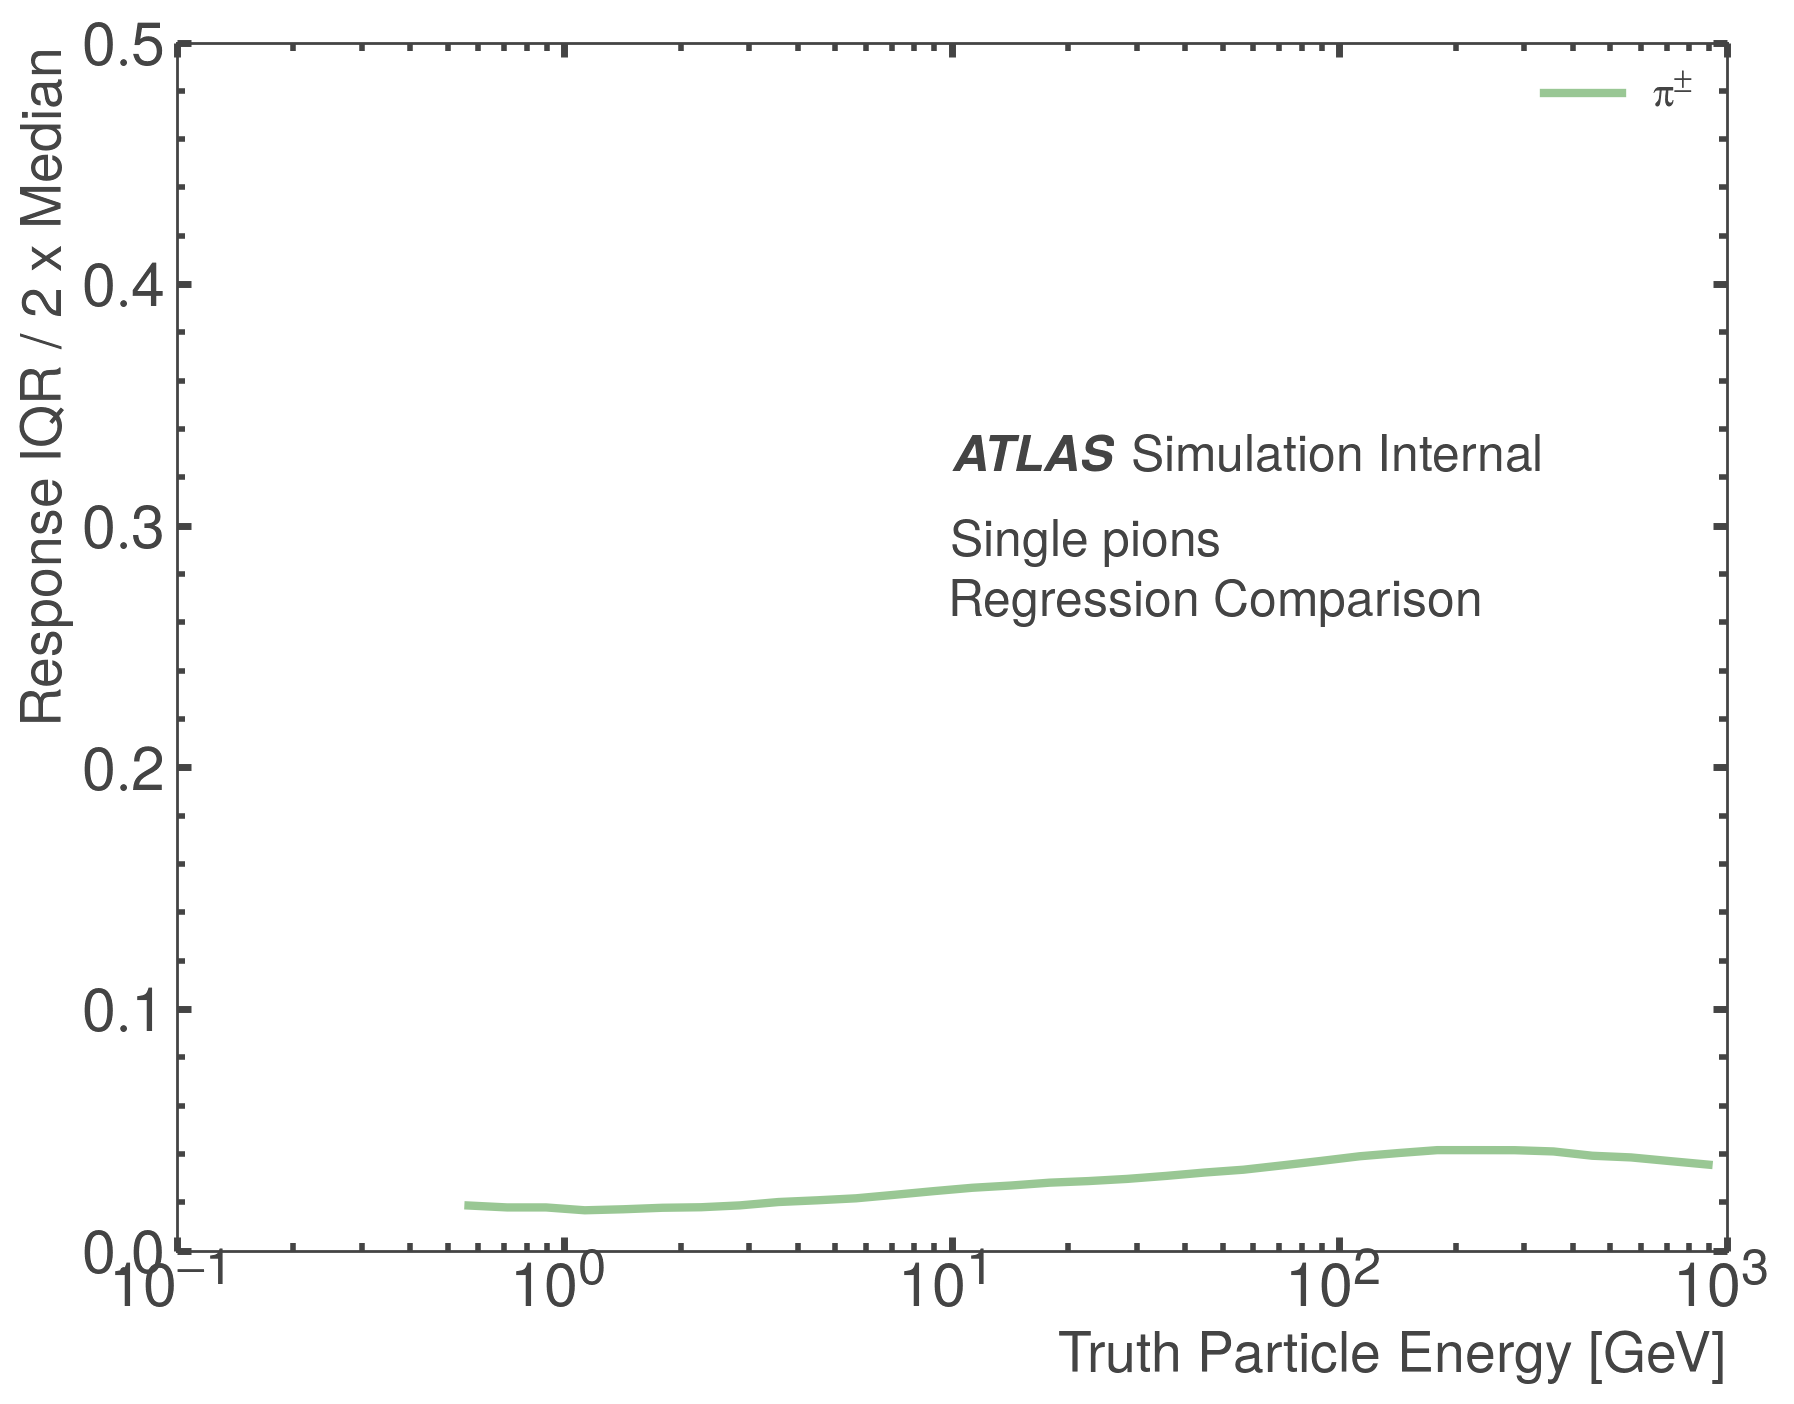


Plotting $\pi^{\pm}$
r2:0.990
PearsonR:0.995, SpearmanR:0.998, MSE:2120.119, MAE:17.506
Saving figure to ./pub_note_results/regress_gnn_allclusters_nocells_all.pdf


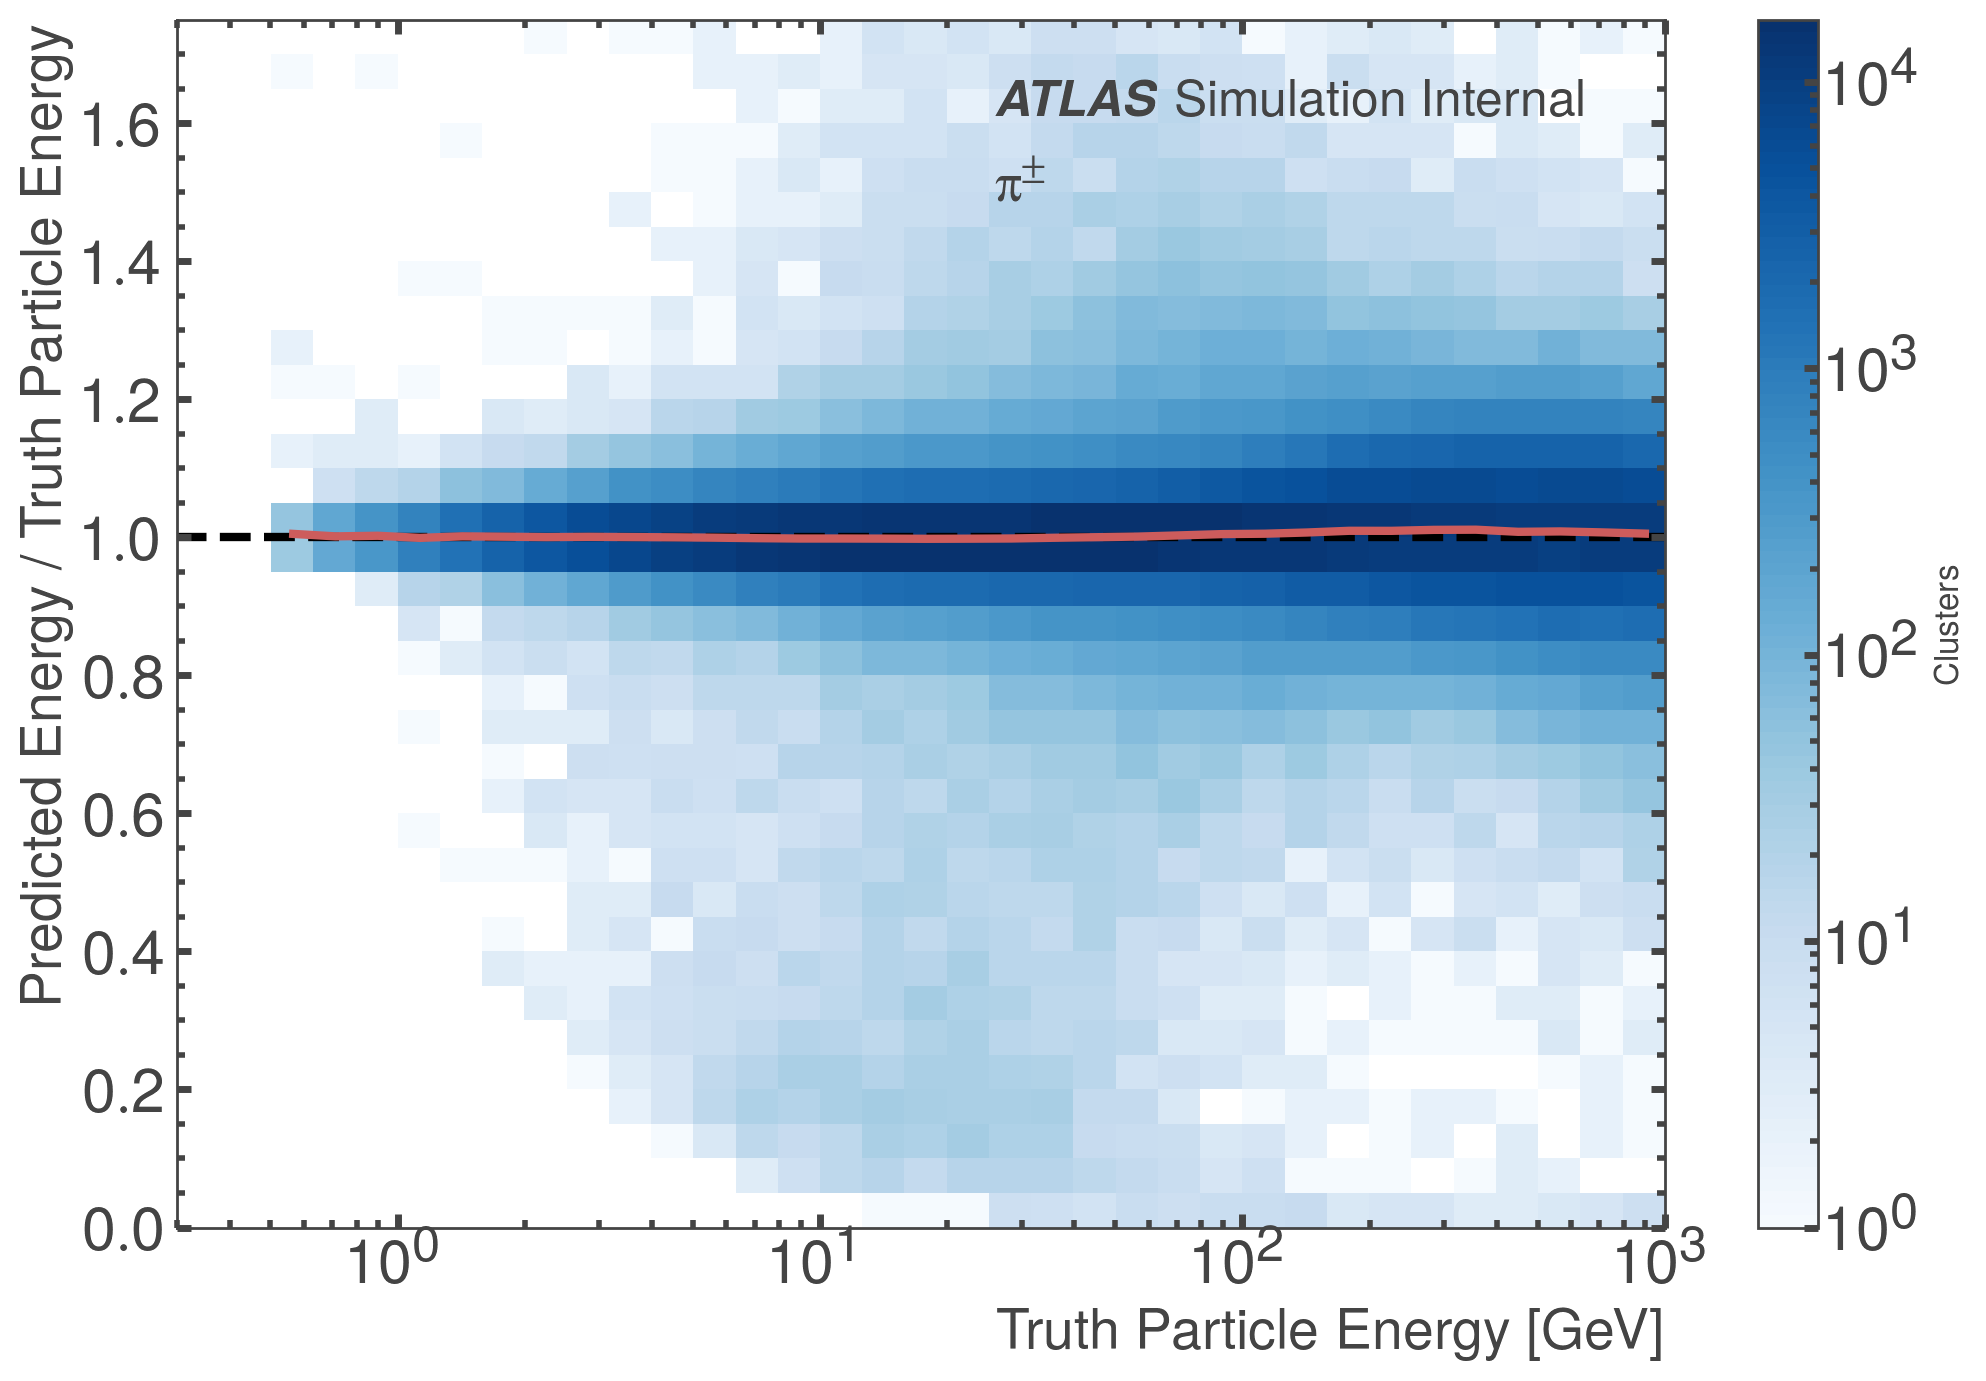

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

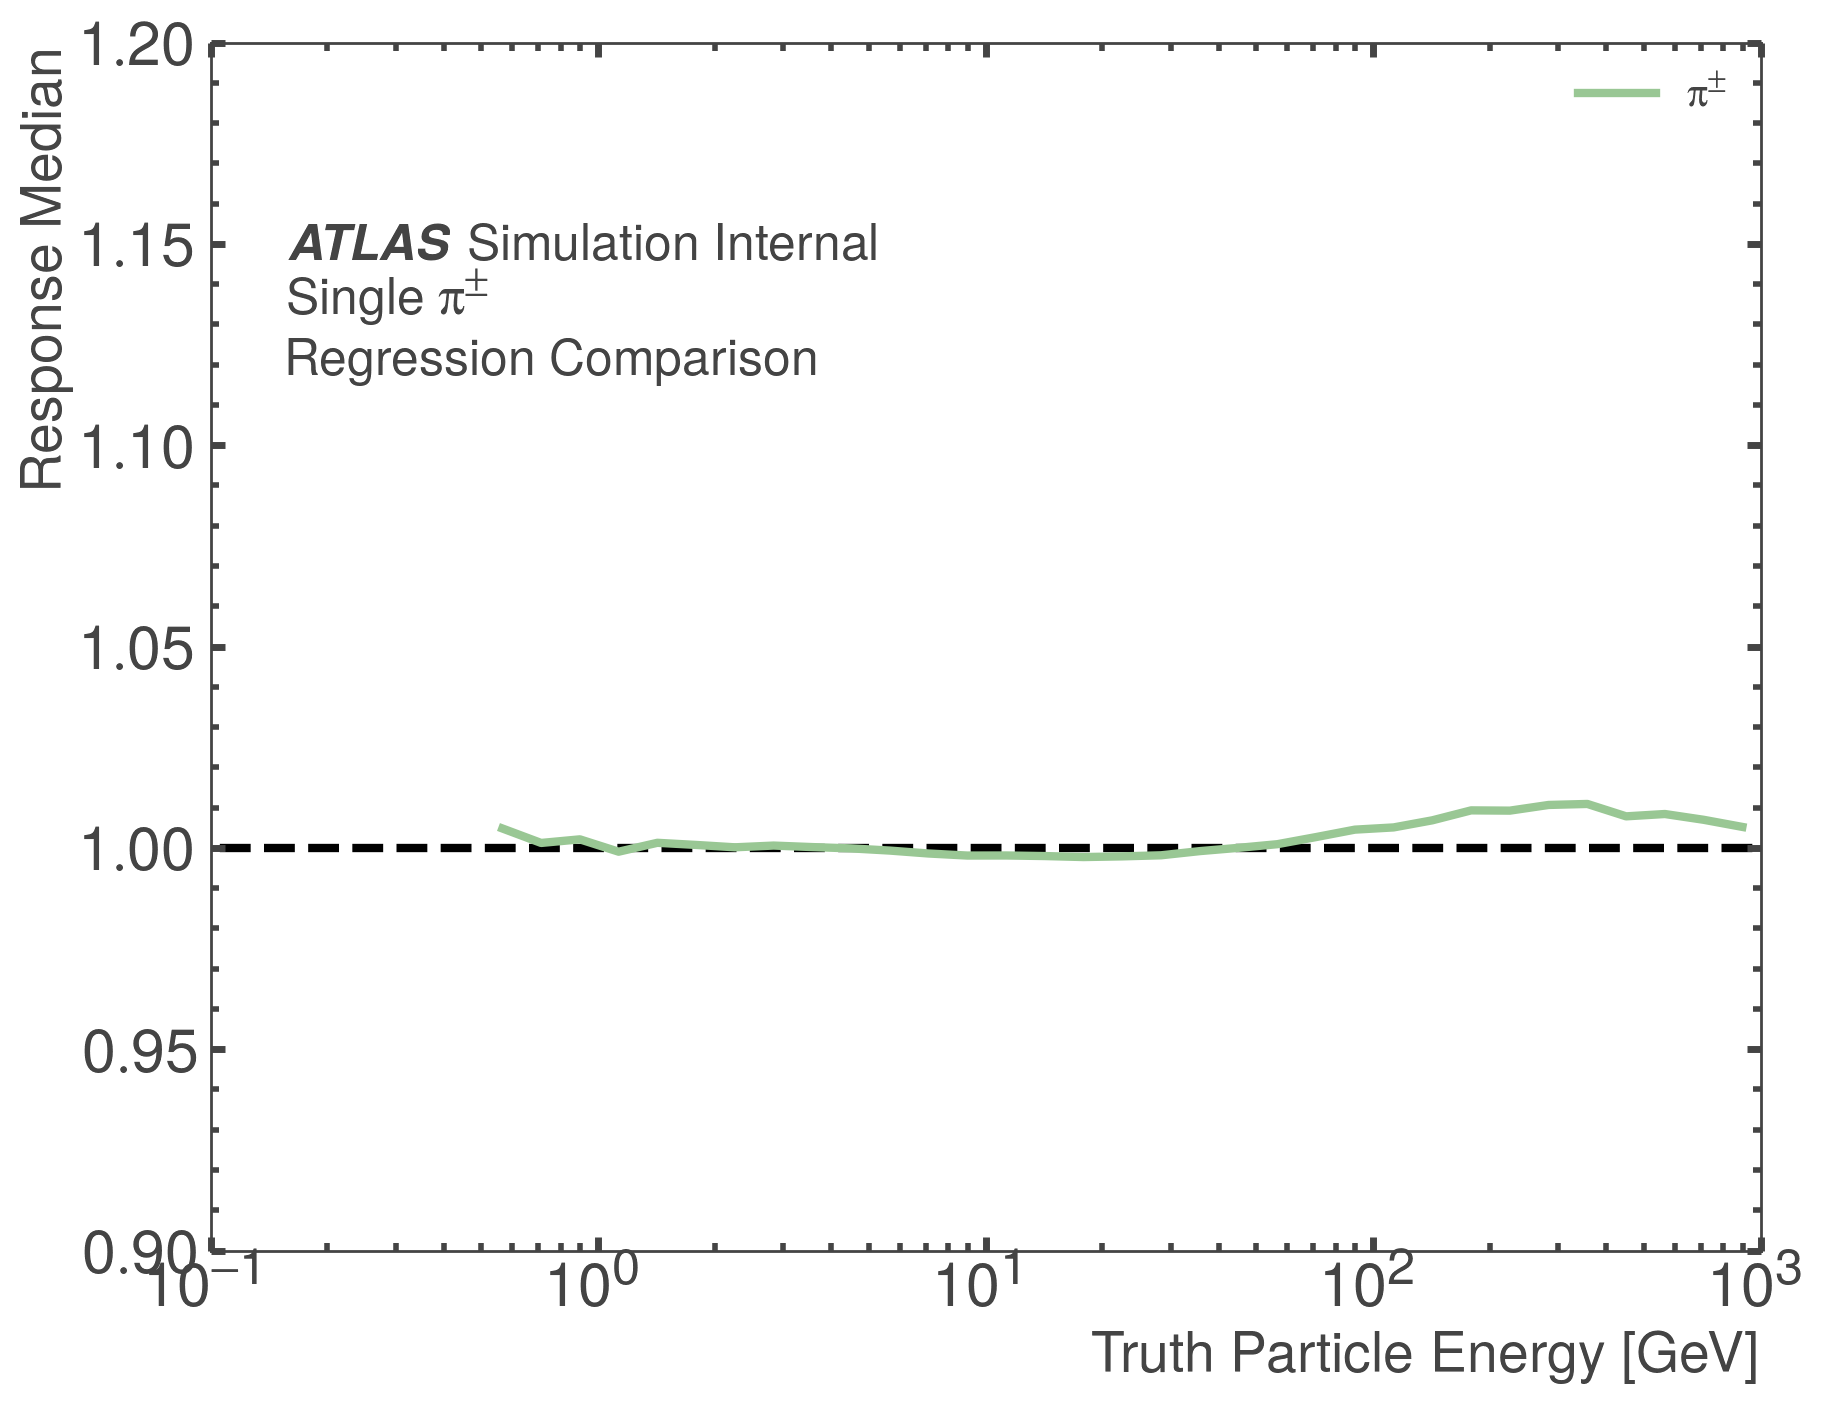


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

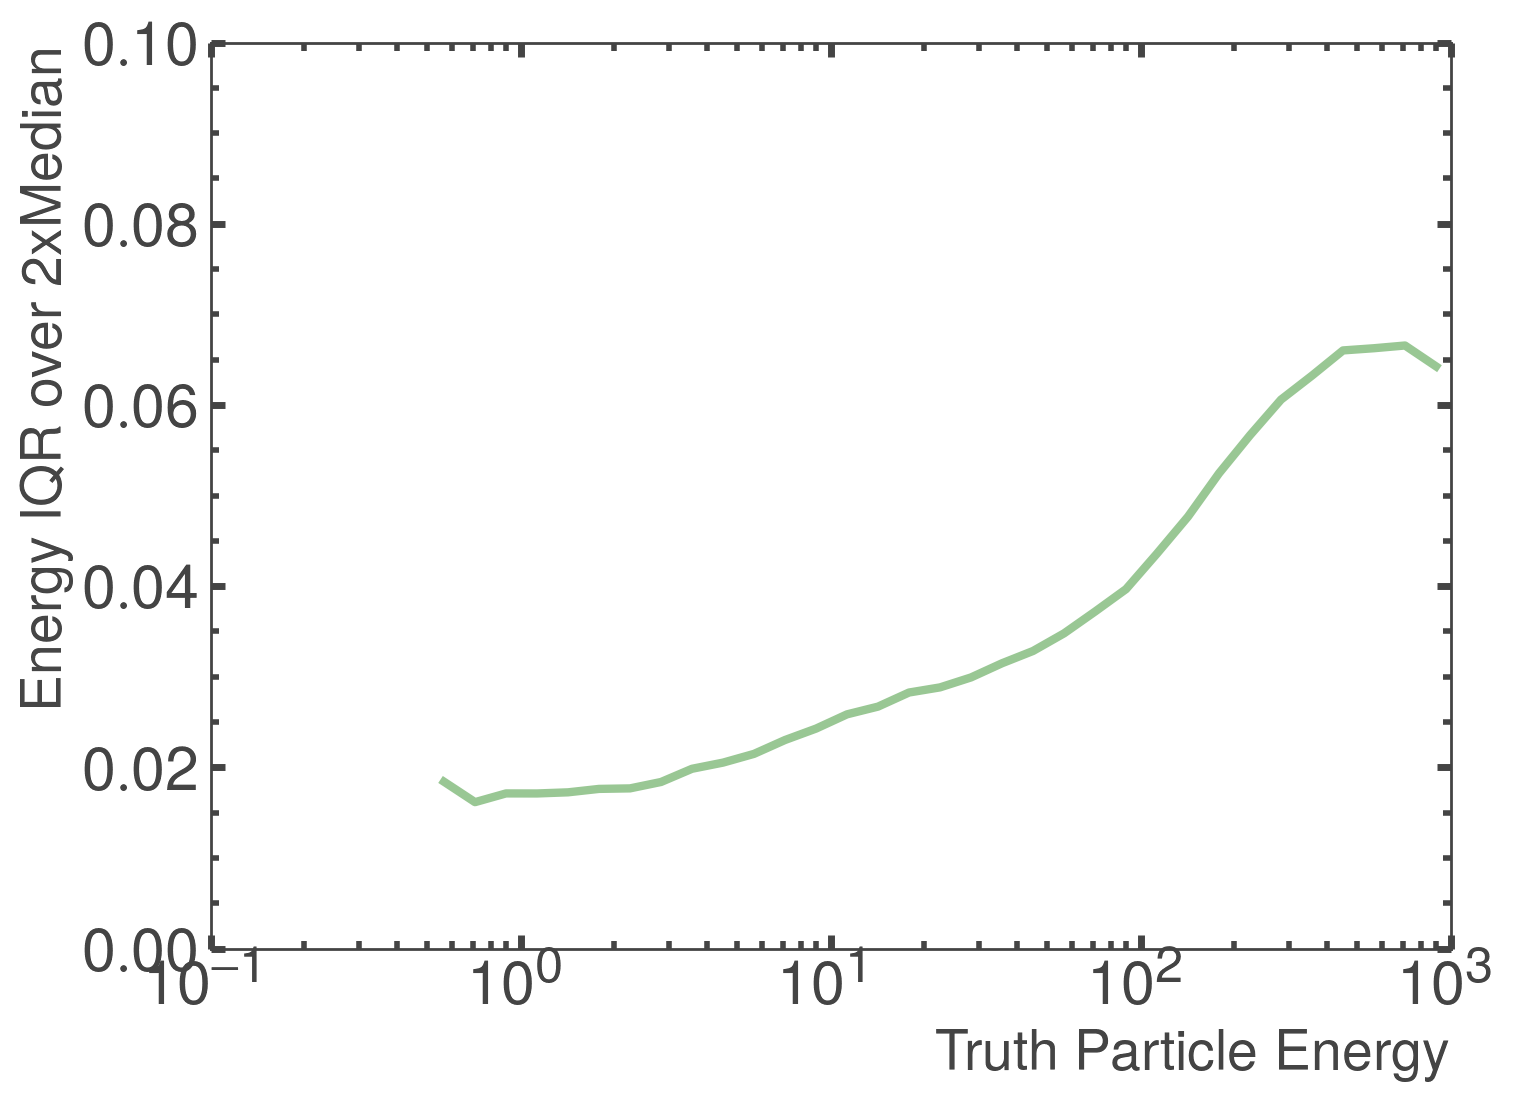

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

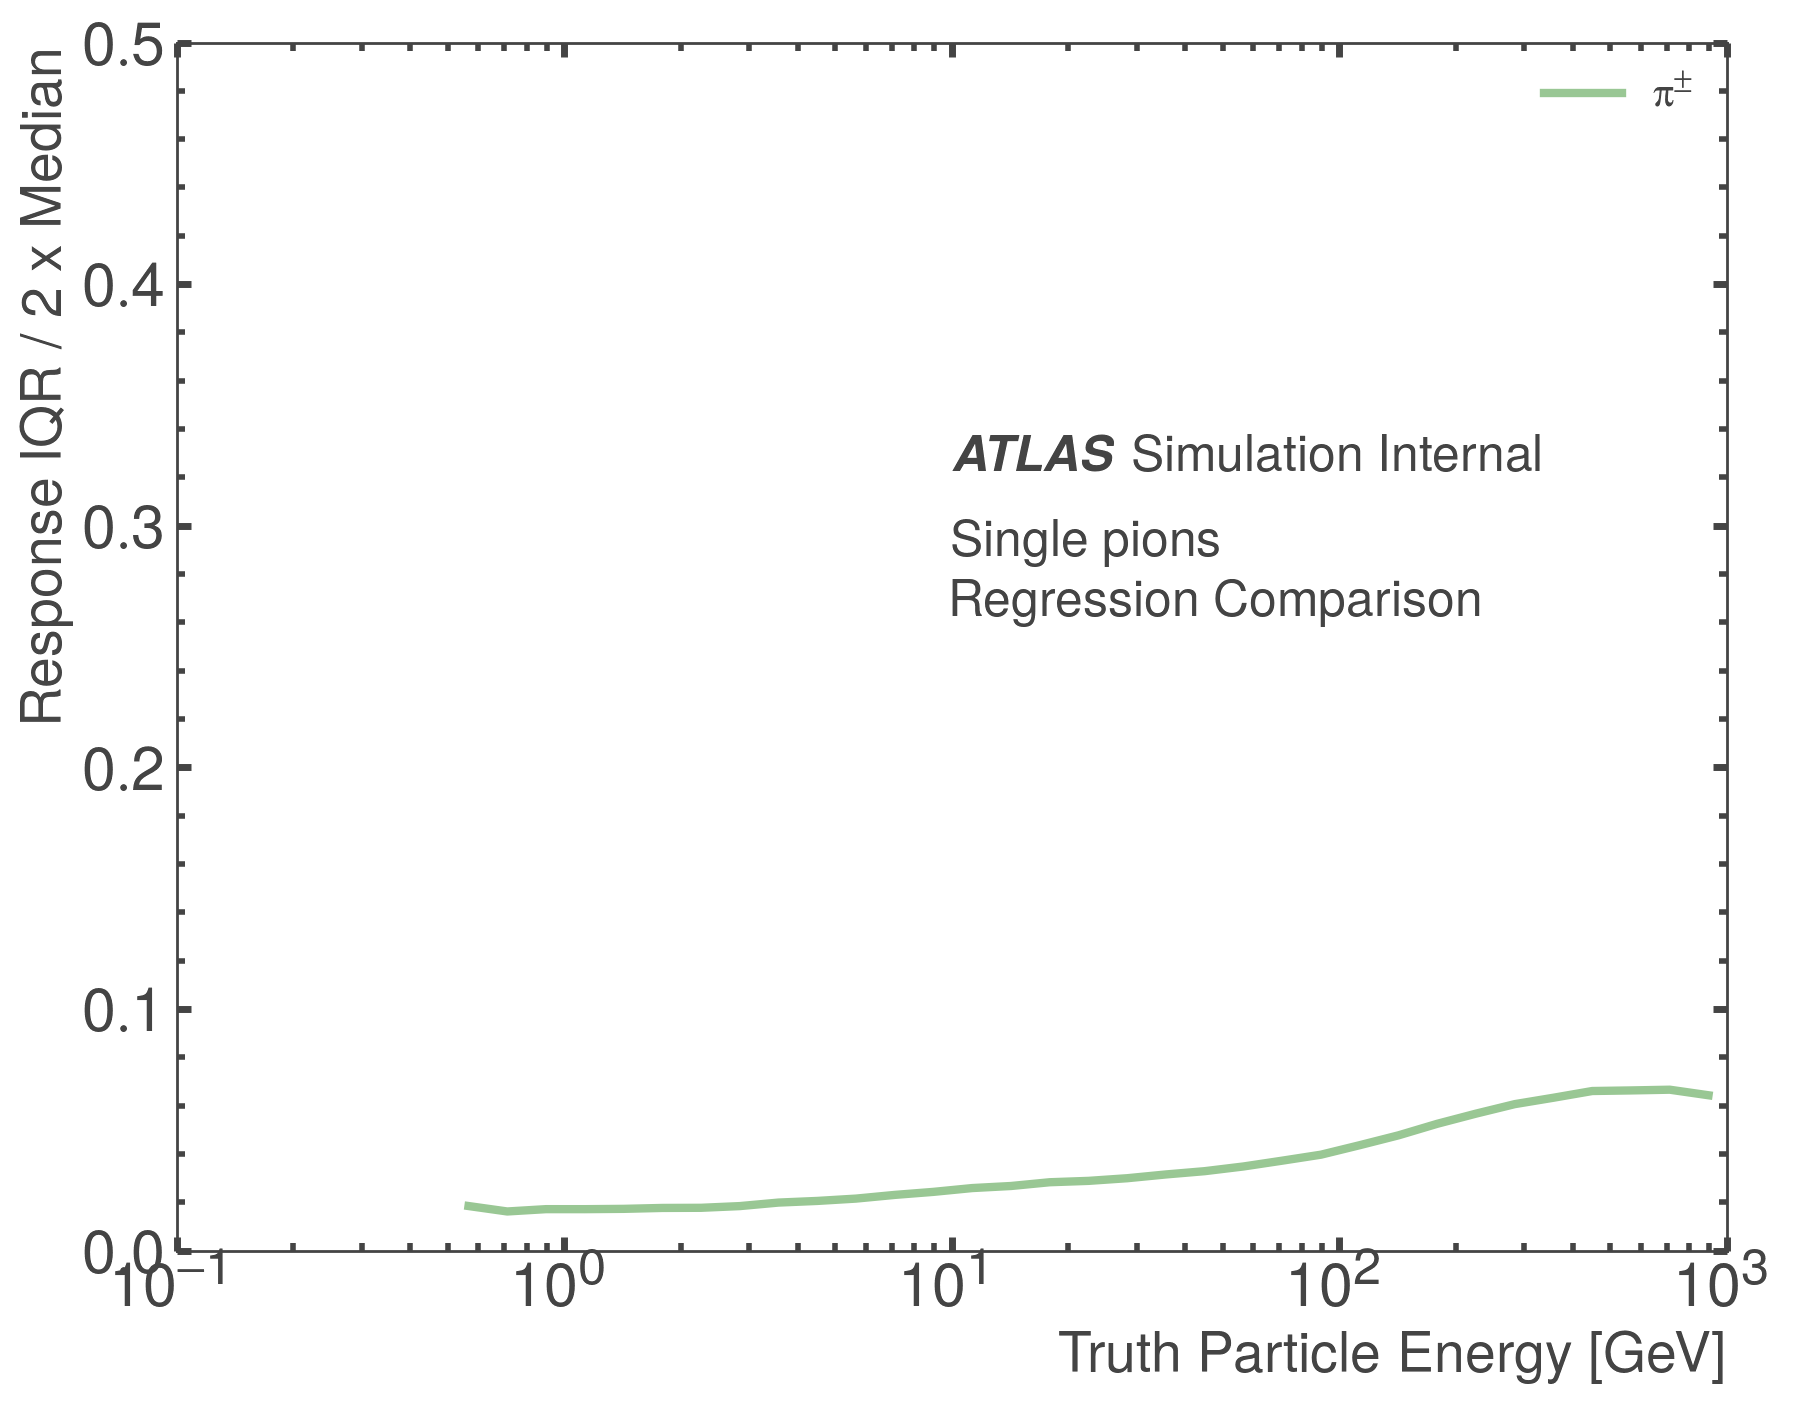


Plotting $\pi^{\pm}$
r2:0.963
PearsonR:0.981, SpearmanR:0.997, MSE:8039.713, MAE:34.589
Saving figure to ./pub_note_results/regress_gnn_leadcluster_nocells_all.pdf


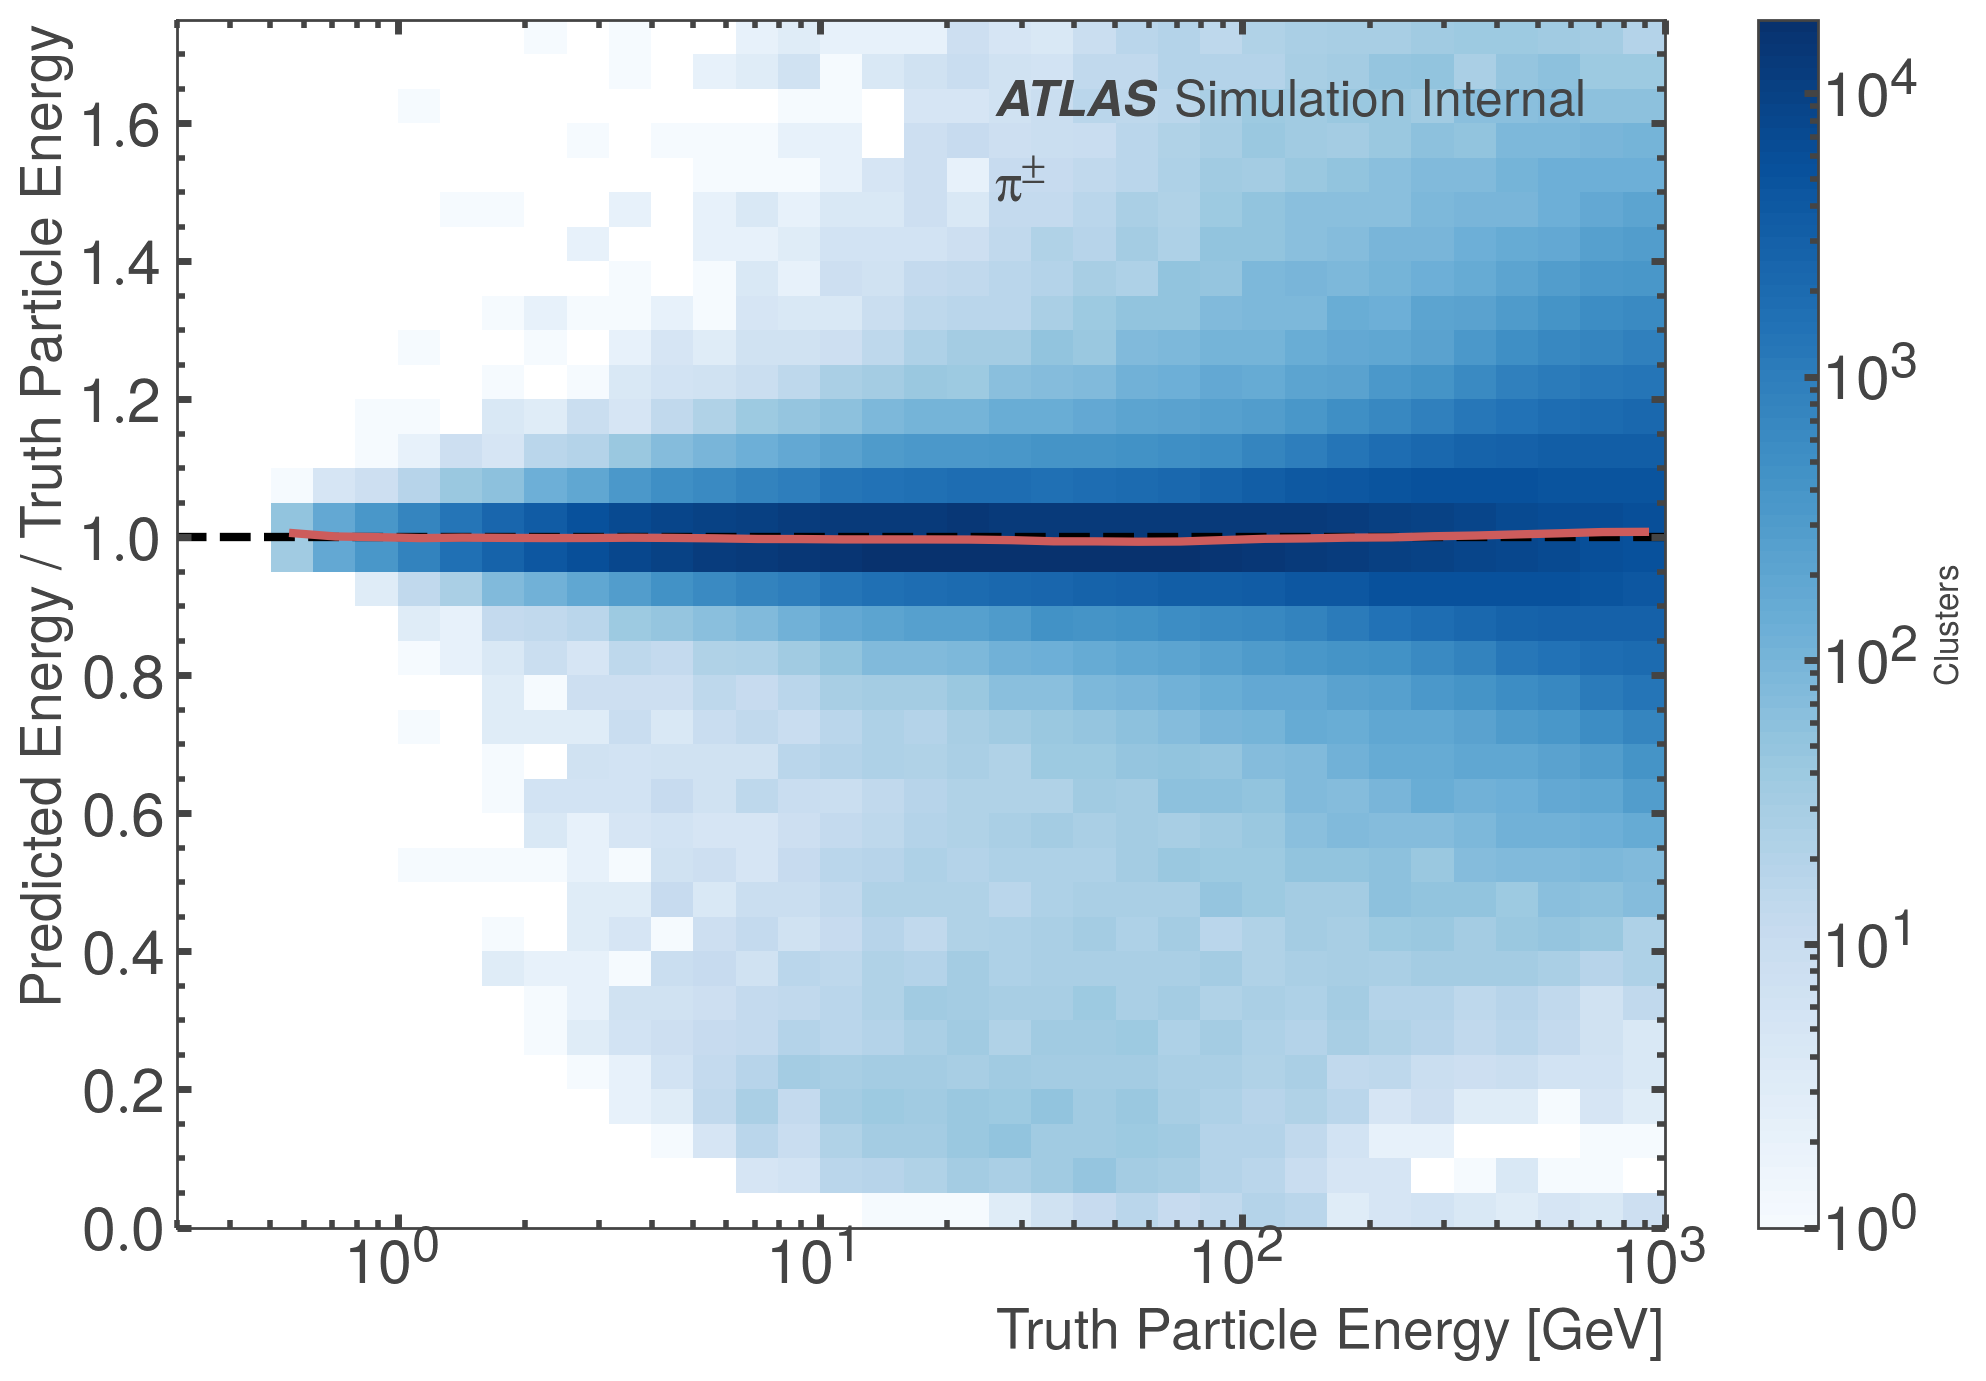

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

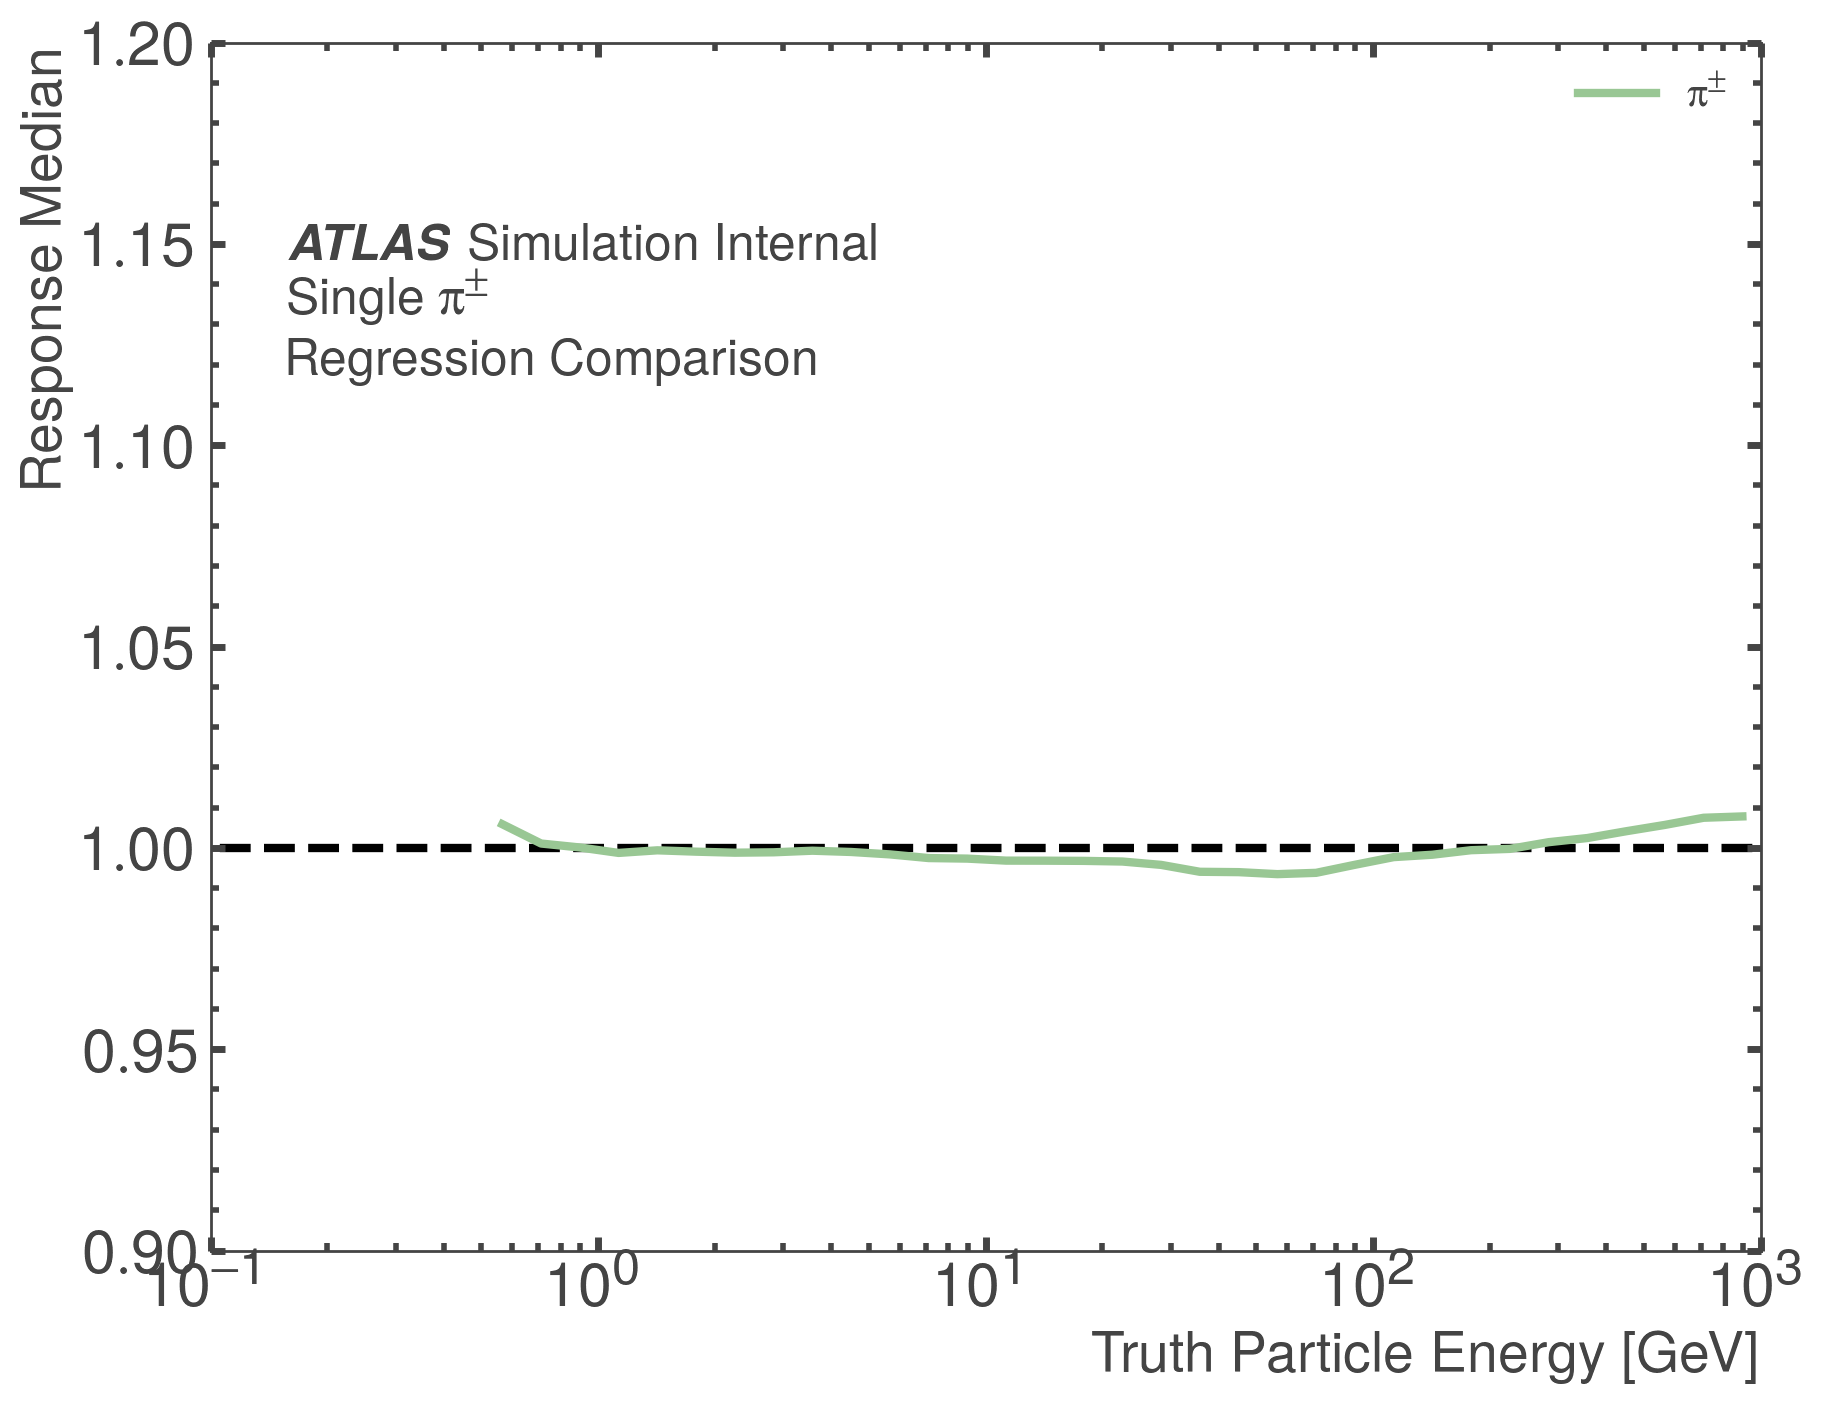


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

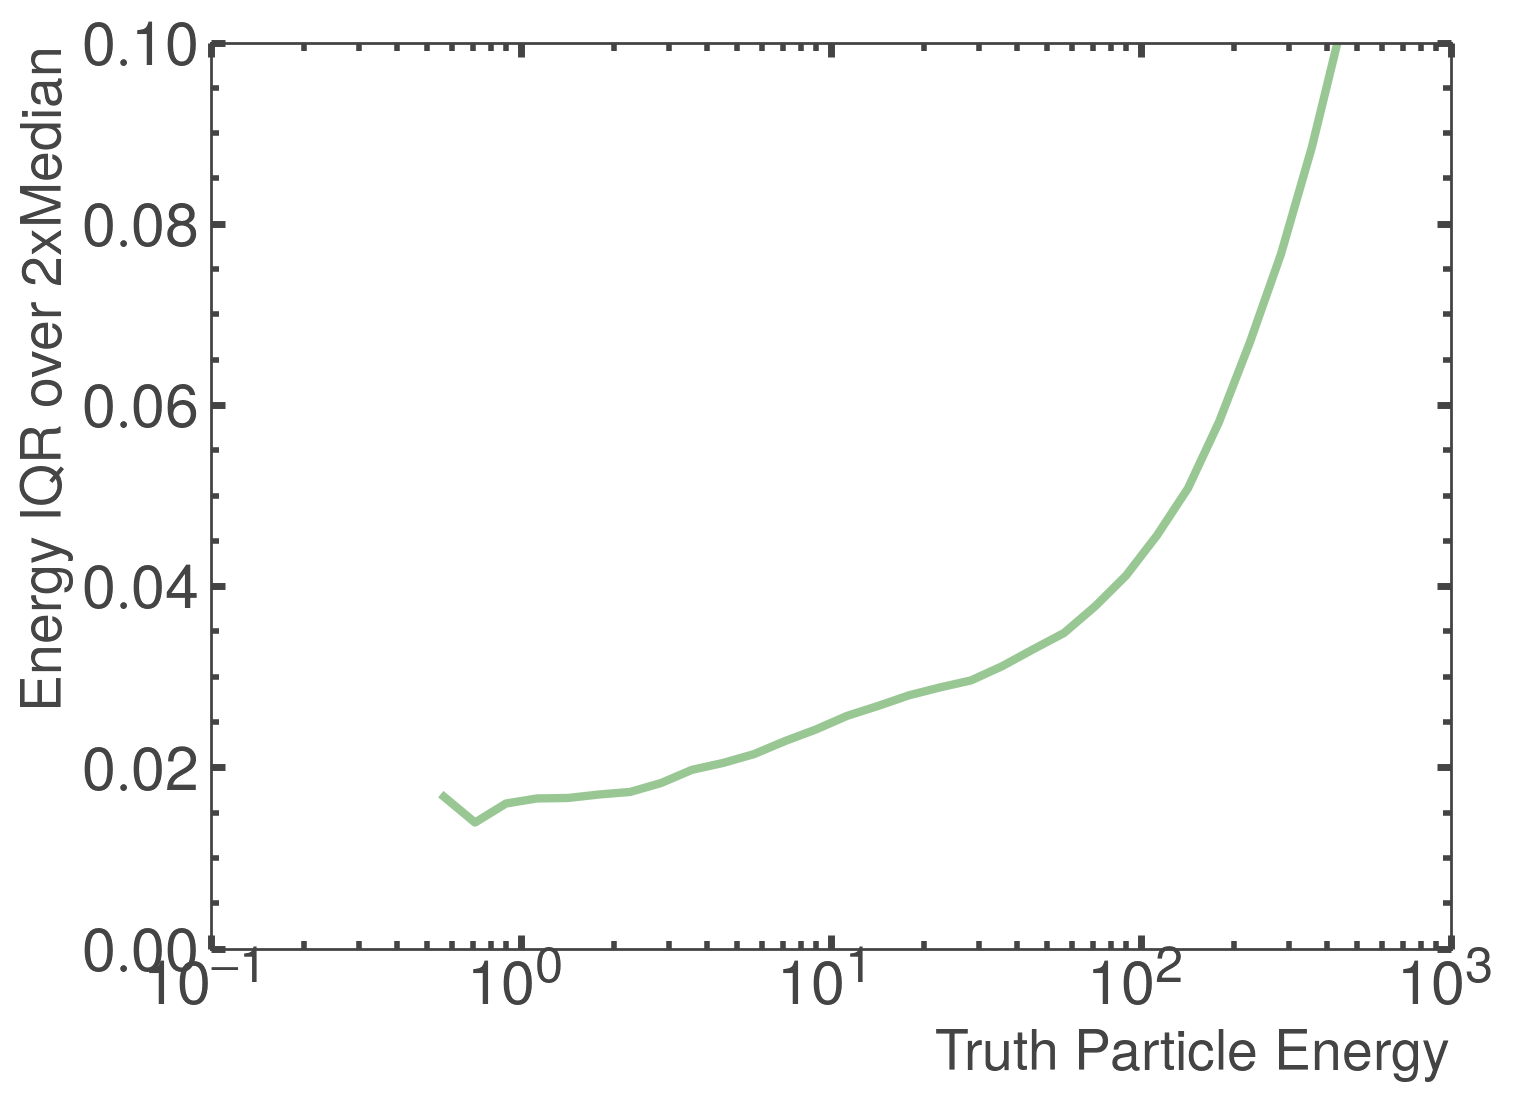

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

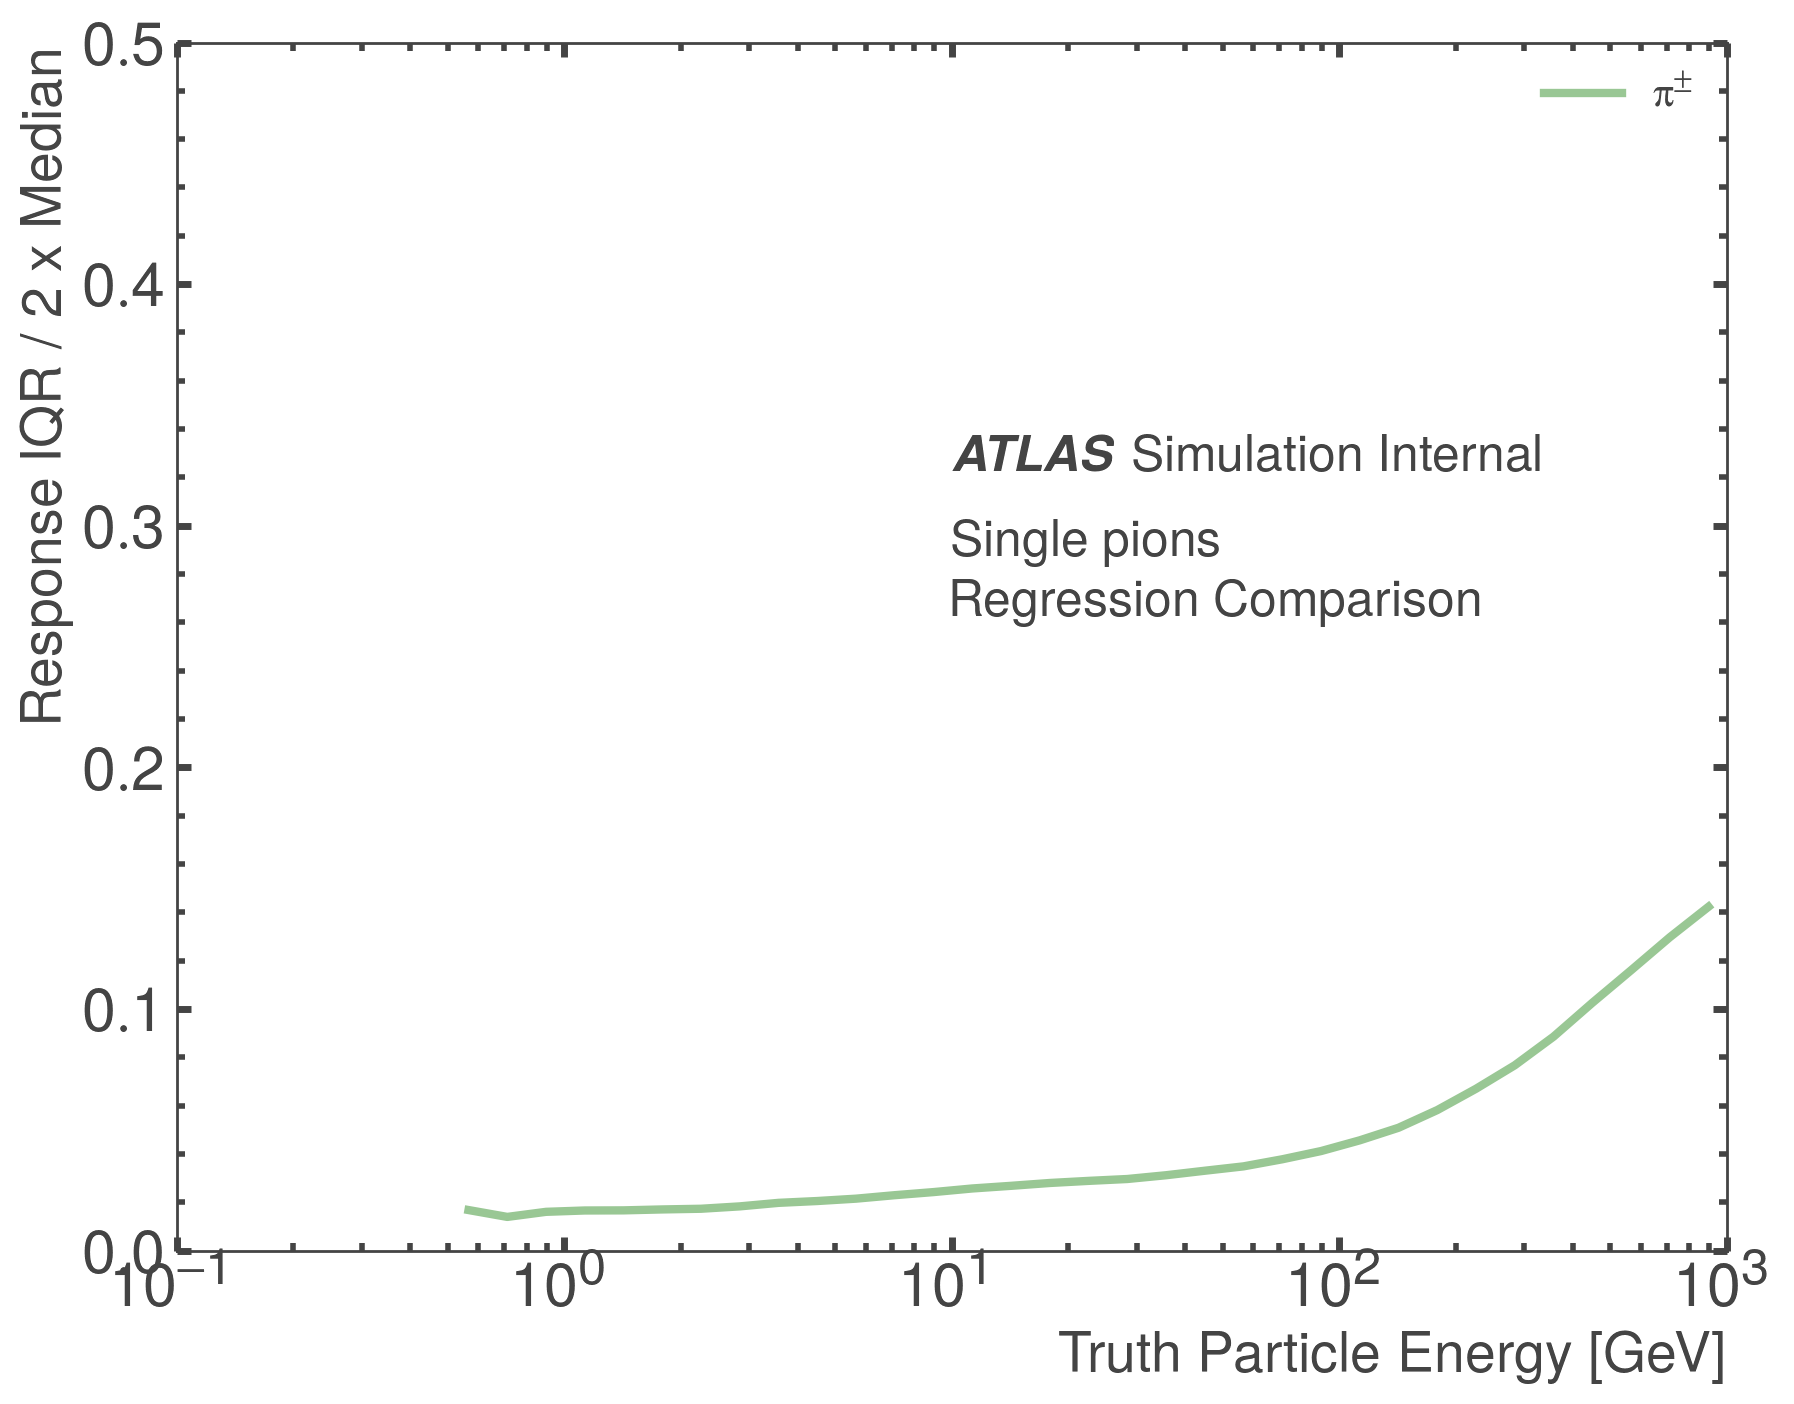

In [8]:
### GNN with and without edges
folders = glob.glob("results/onetrack_multicluster/piyush_june22/*")
for folder in folders: 
    pred_file = folder+'/inference_predictions.npz'
    predictions = np.load(pred_file)
    targets_regress = predictions['targets']
    outputs_regress = predictions['outputs'][:,0]
    df = pd.DataFrame(np.vstack([targets_regress, outputs_regress]).T, columns=['targets_regress', 'outputs_regress'])
    label = folder.split("/")[-1]
    make_regression_plots(df, charged_pions_only = True, label=label, data_dir='./pub_note_results',)


Plotting $\pi^{\pm}$
r2:0.994
PearsonR:0.997, SpearmanR:0.999, MSE:1251.498, MAE:12.040
Saving figure to ./regress_gnn_leadcluster_nocells_all.pdf


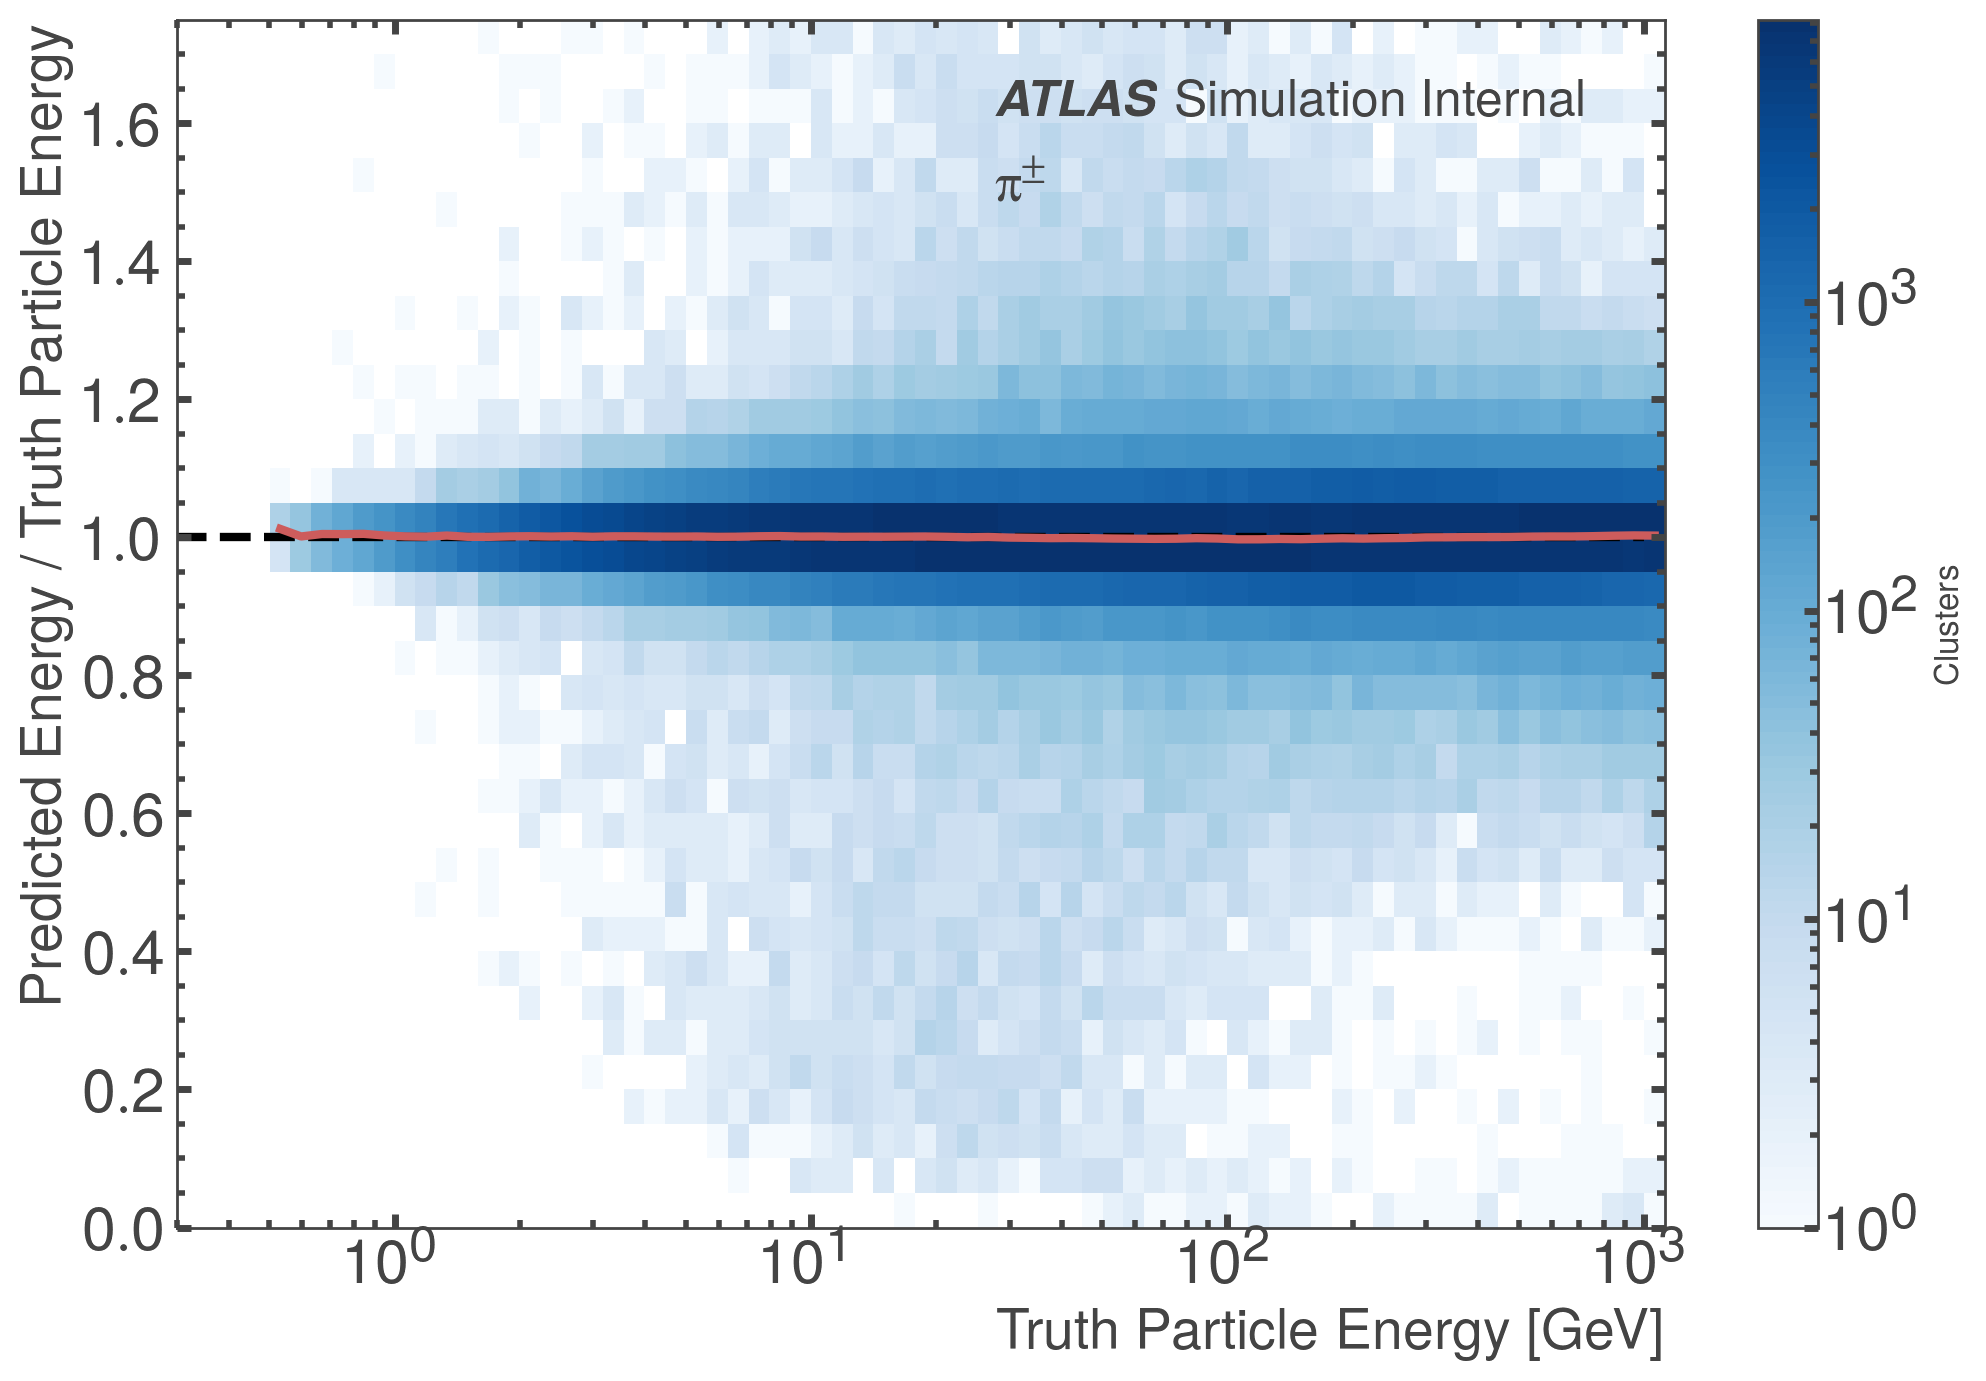

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

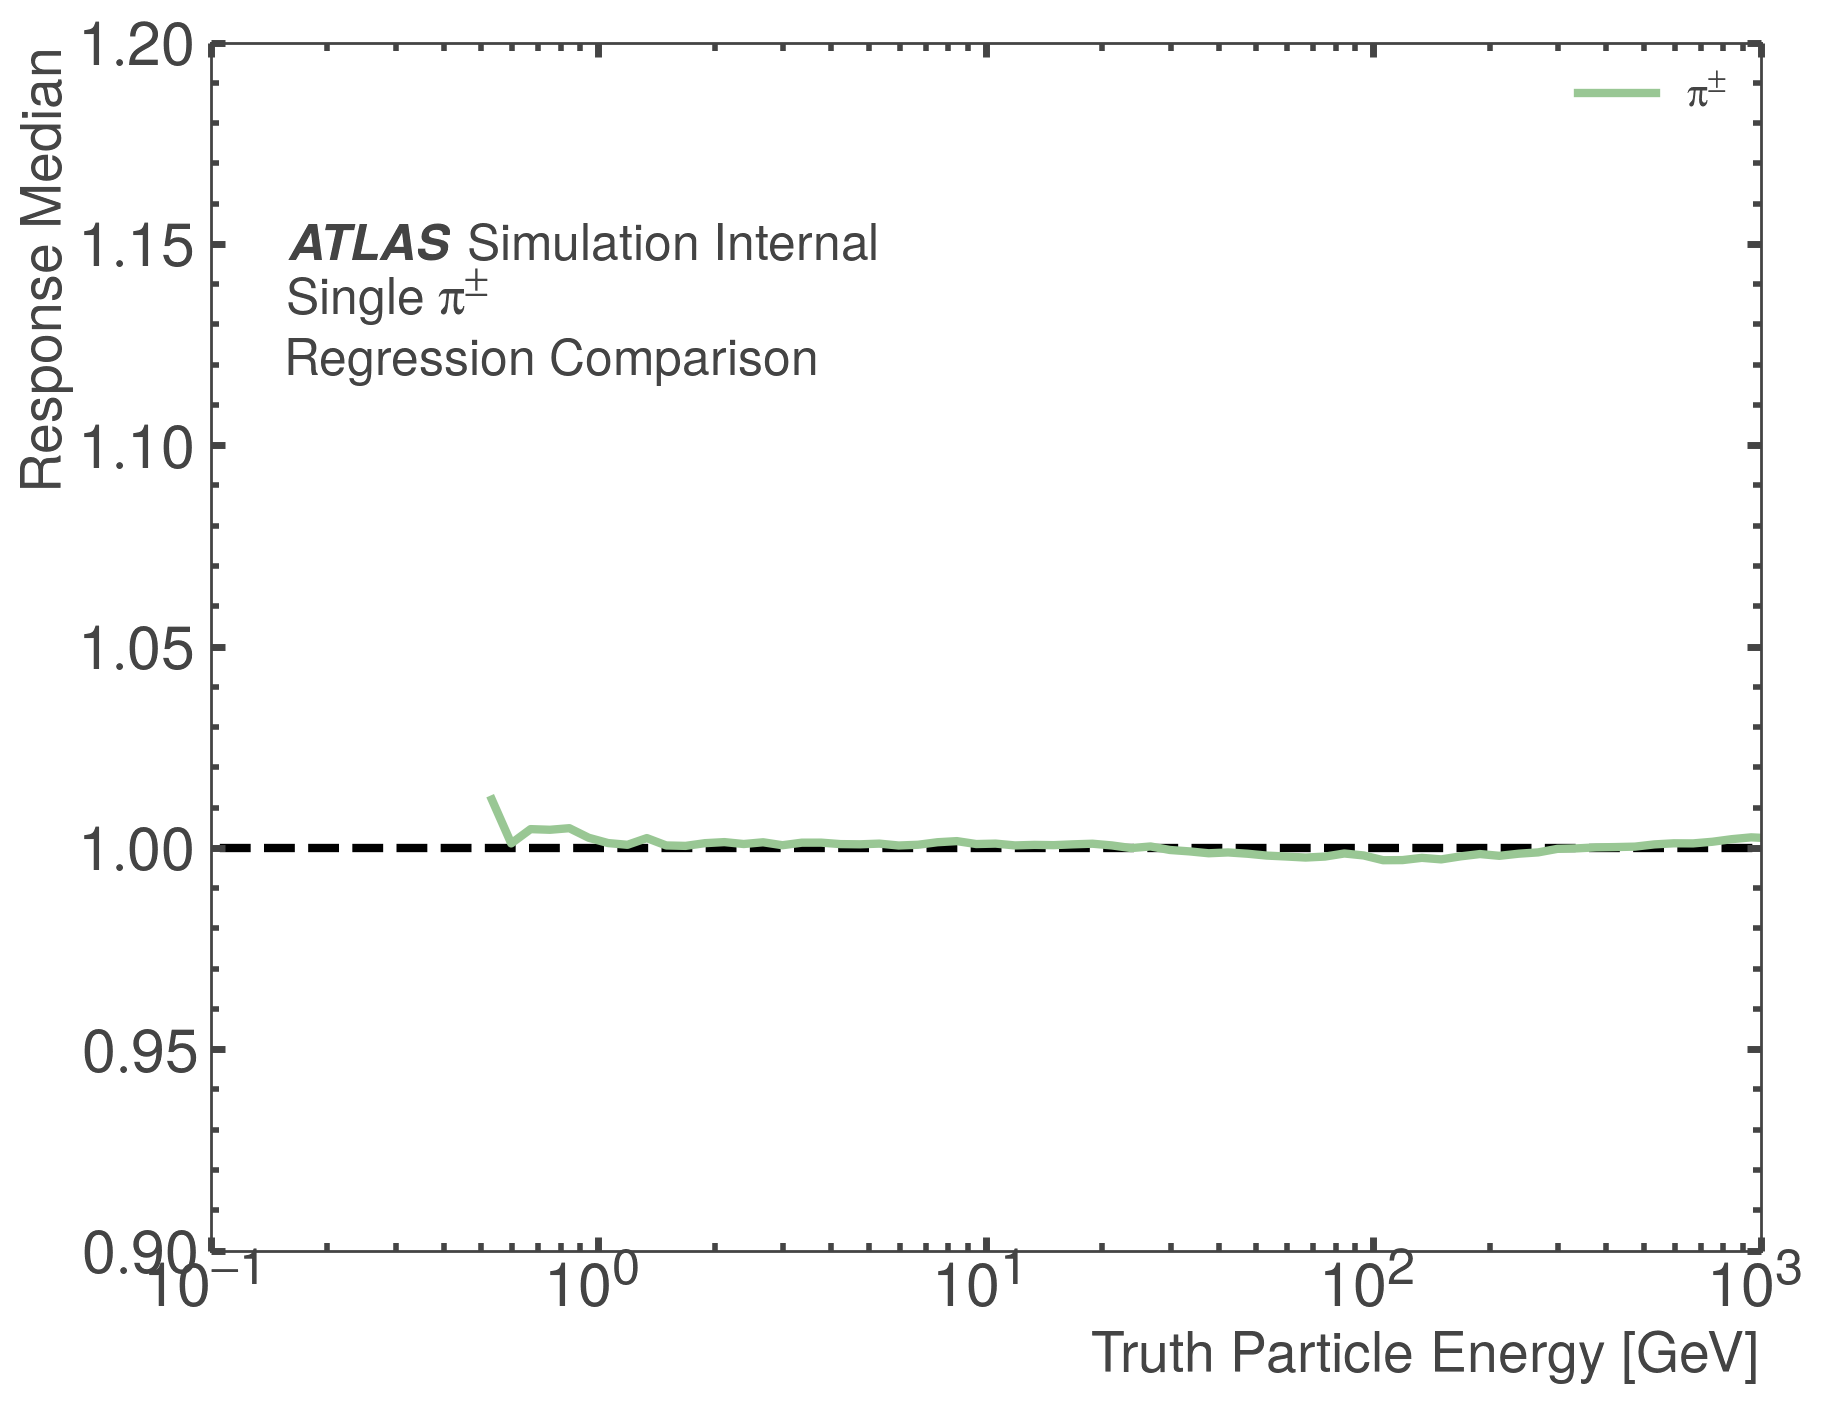


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

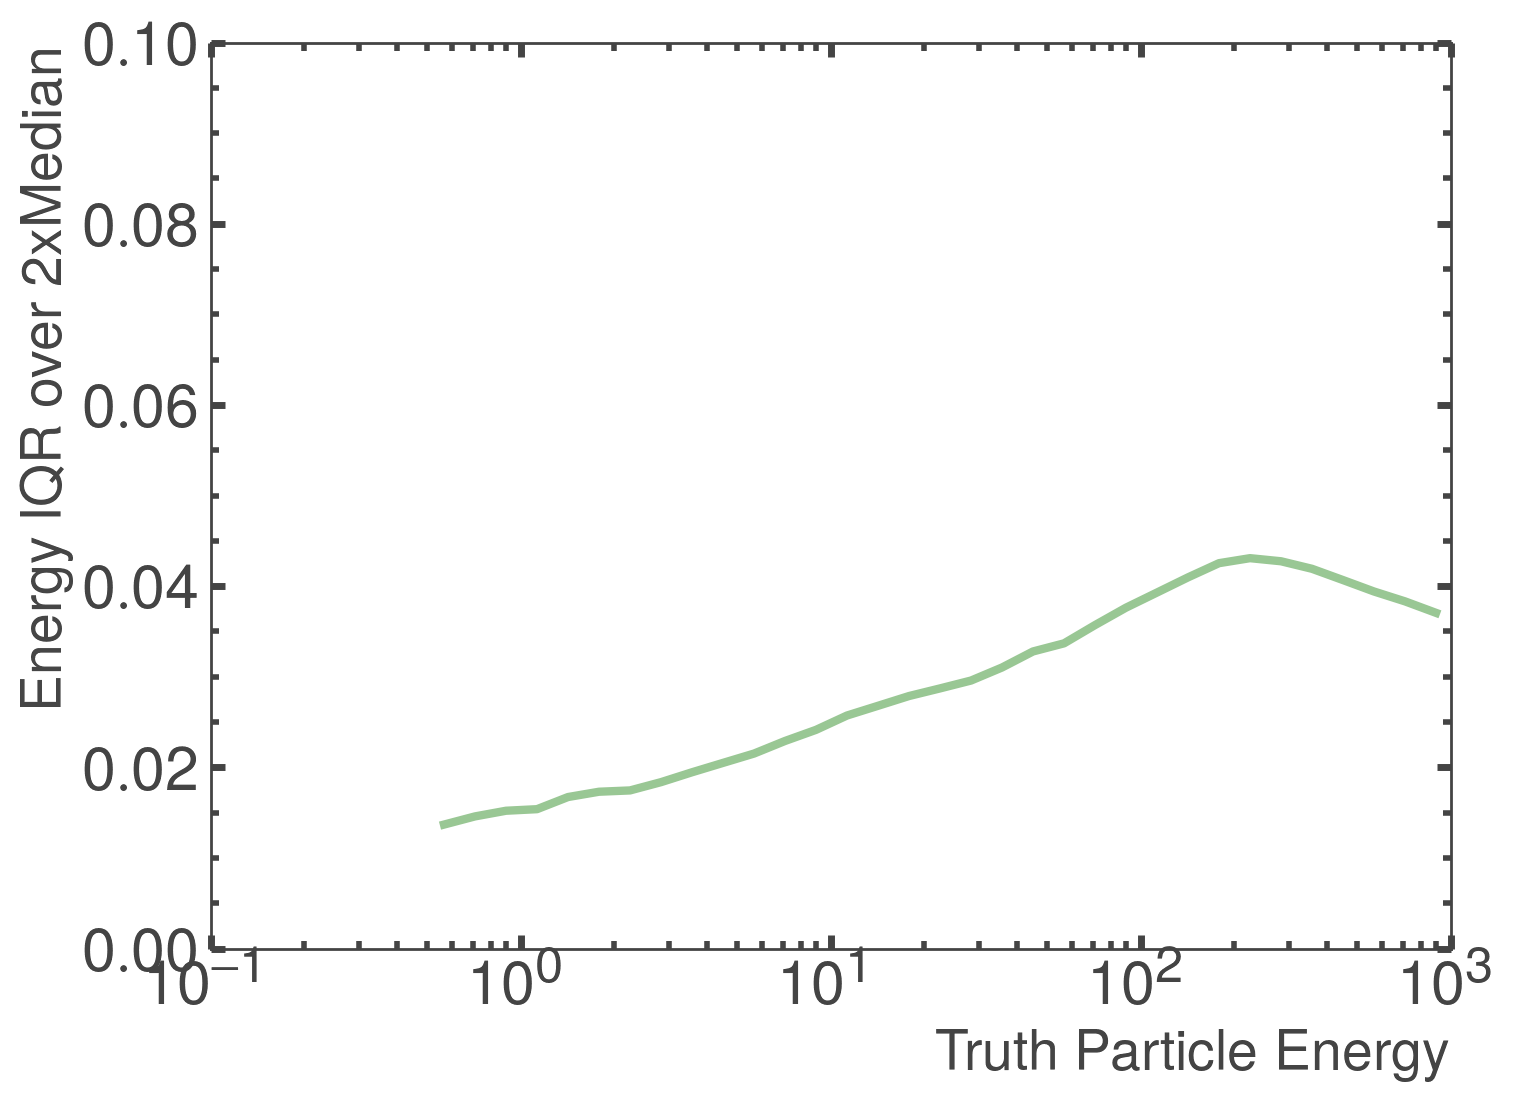

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

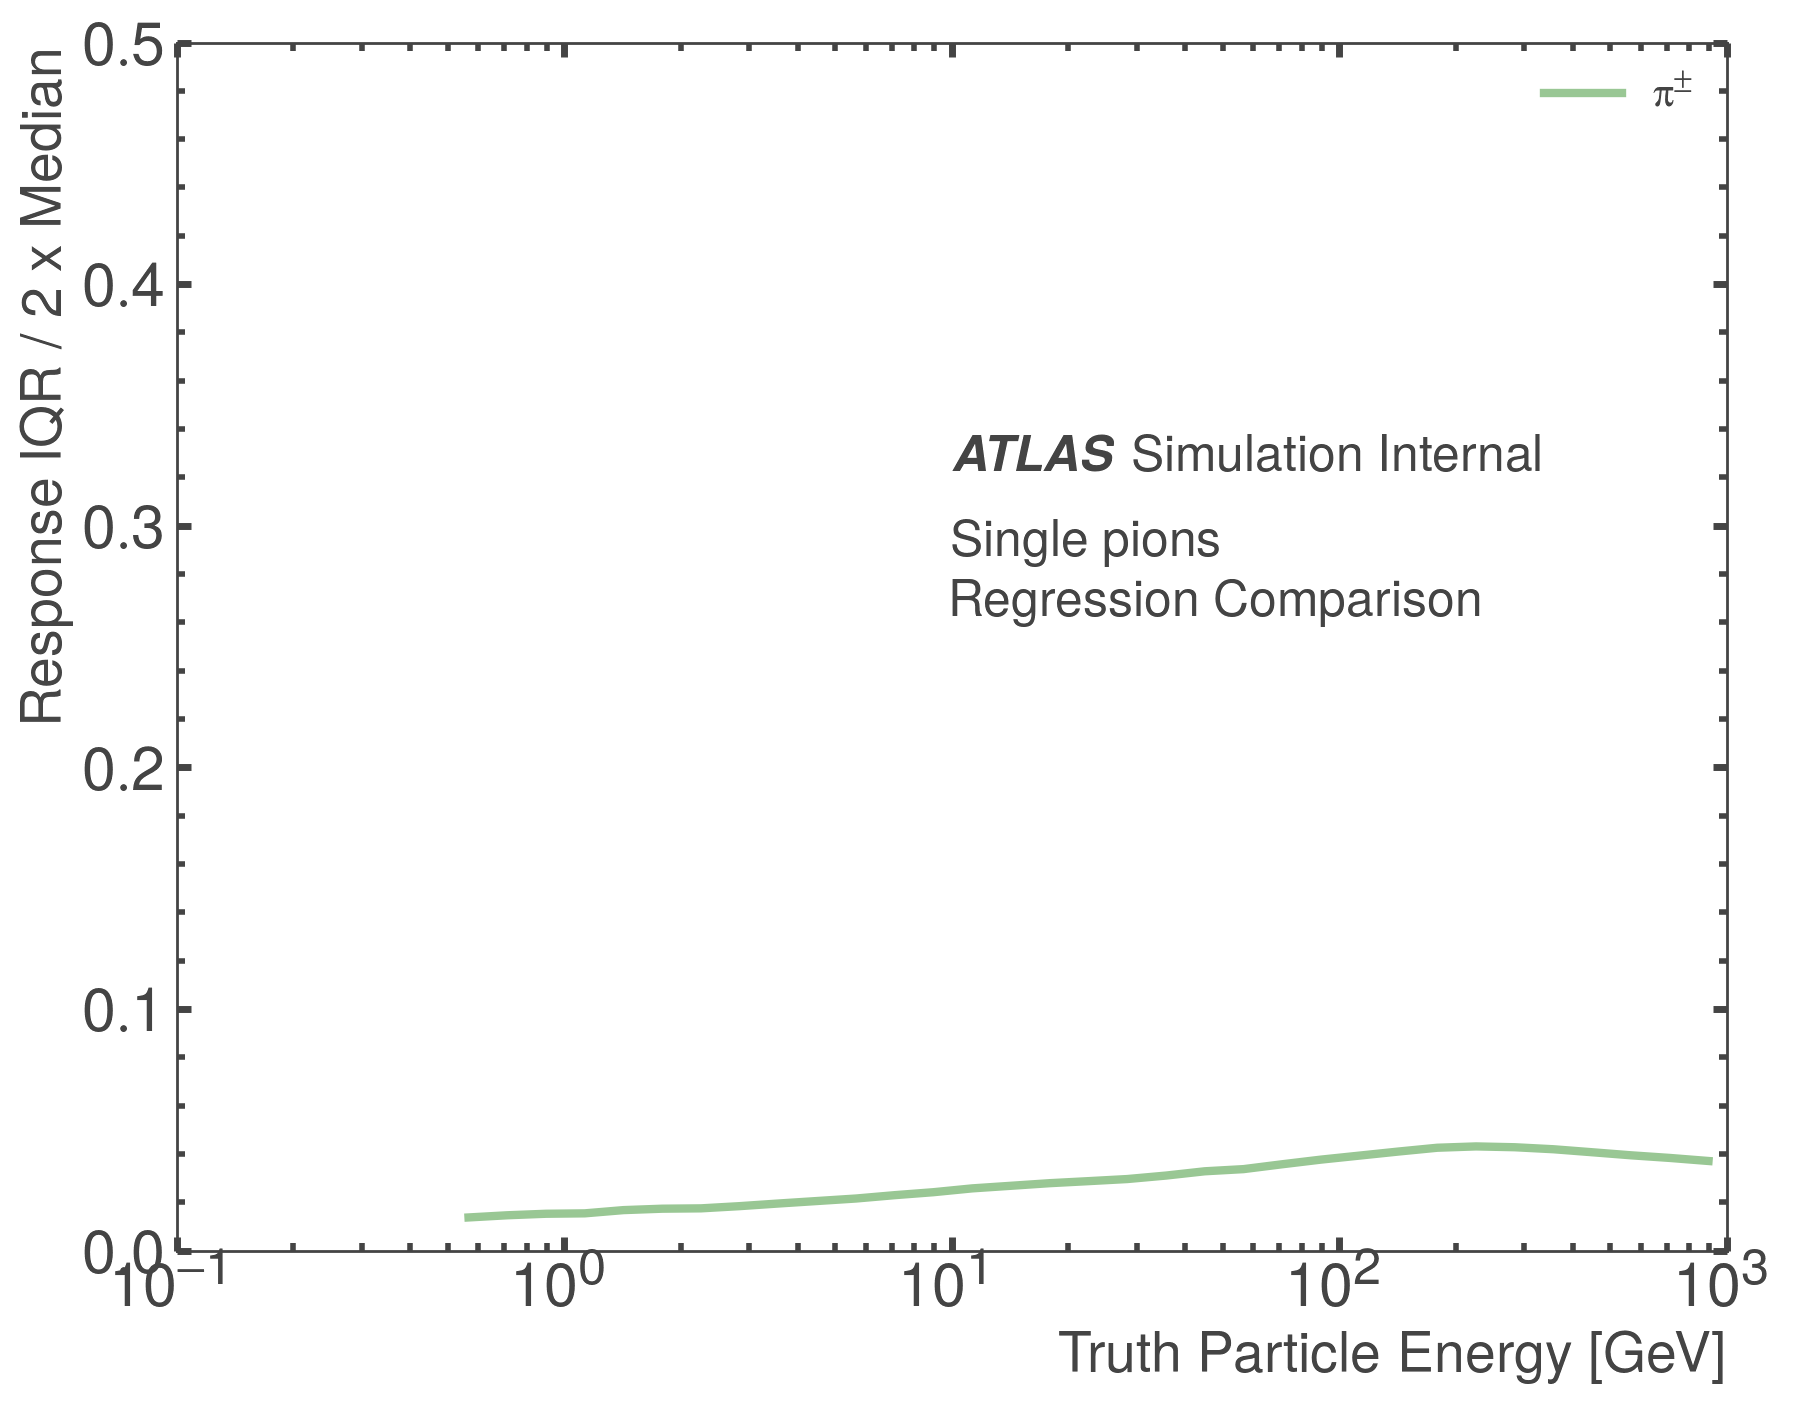

In [6]:
### GNN with and without edges
pred_file = 'results/onetrack_multicluster/piyush_june22/gnn_allclusters_cells/inference_predictions.npz'
predictions = np.load(pred_file)
targets_regress = predictions['targets']
outputs_regress = predictions['outputs'][:,0]
df = pd.DataFrame(np.vstack([targets_regress, outputs_regress]).T, columns=['targets_regress', 'outputs_regress'])
make_regression_plots(df, charged_pions_only = True, label=label, 
                      # data_dir='./pub_note_results',
                     )

In [20]:
slice = df[(df.targets_regress > 100) & (df.targets_regress < 100.1)]

In [23]:
slice[slice.outputs_regress/slice.targets_regress < 0.9]

targets_regress  outputs_regress
507928       100.072327        55.248234
710571       100.007851        84.735504

In [24]:
df.iloc[507928]

targets_regress    100.072327
outputs_regress     55.248234
Name: 507928, dtype: float32

In [54]:
df[(df.targets_regress > 100.007) & (df.targets_regress < 100.008)]

targets_regress  outputs_regress
710571       100.007851        84.735504
924438       100.007141        98.203445

In [45]:
df[(df.targets_regress > 100) & (df.targets_regress < 100.1) & (df.outputs_regress/df.targets_regress < 0.9)]

targets_regress  outputs_regress
507928       100.072327        55.248234
710571       100.007851        84.735504

In [49]:
df_transformer[(df_transformer.targets_regress > 100.072) & (df_transformer.targets_regress < 100.073)]

targets_regress  outputs_regress
573937       100.072319        99.050067
726492       100.072746        95.579158

In [55]:
len(df)

1000777

In [56]:
len(df_transformer)

1001270

In [57]:
len(df_transformer)-len(df)

493

In [59]:
df[(np.abs(df.targets_regress - 100.291687) < 0.0001)]

targets_regress  outputs_regress
740649       100.291763        90.712692
878823       100.291718         5.359109

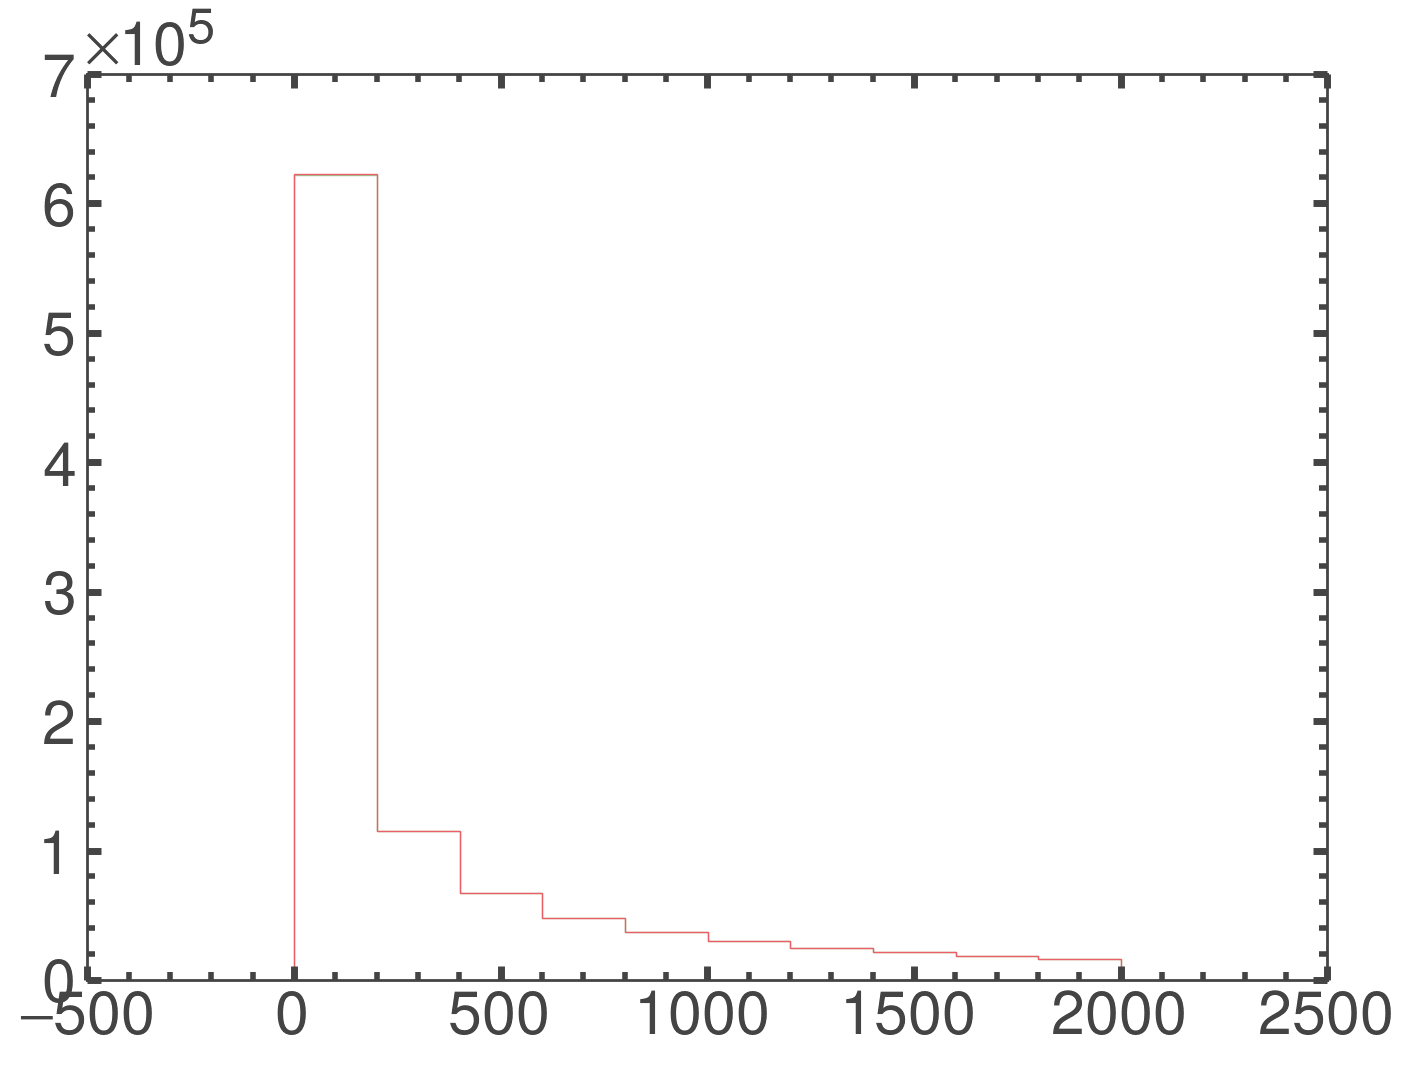

In [41]:
plt.hist(df.targets_regress, histtype="step");
plt.hist(df_transformer.targets_regress, histtype="step");

In [64]:
np.min(df_transformer.outputs_regress/df_transformer.targets_regress)

0.8191938248649204

In [65]:
np.min(df.outputs_regress/df.targets_regress)

0.0007603968


Plotting $\pi^{\pm}$
r2:0.998
PearsonR:0.999, SpearmanR:1.000, MSE:350.226, MAE:8.739
Saving figure to ./pub_note_results/regress_transformer_all.pdf


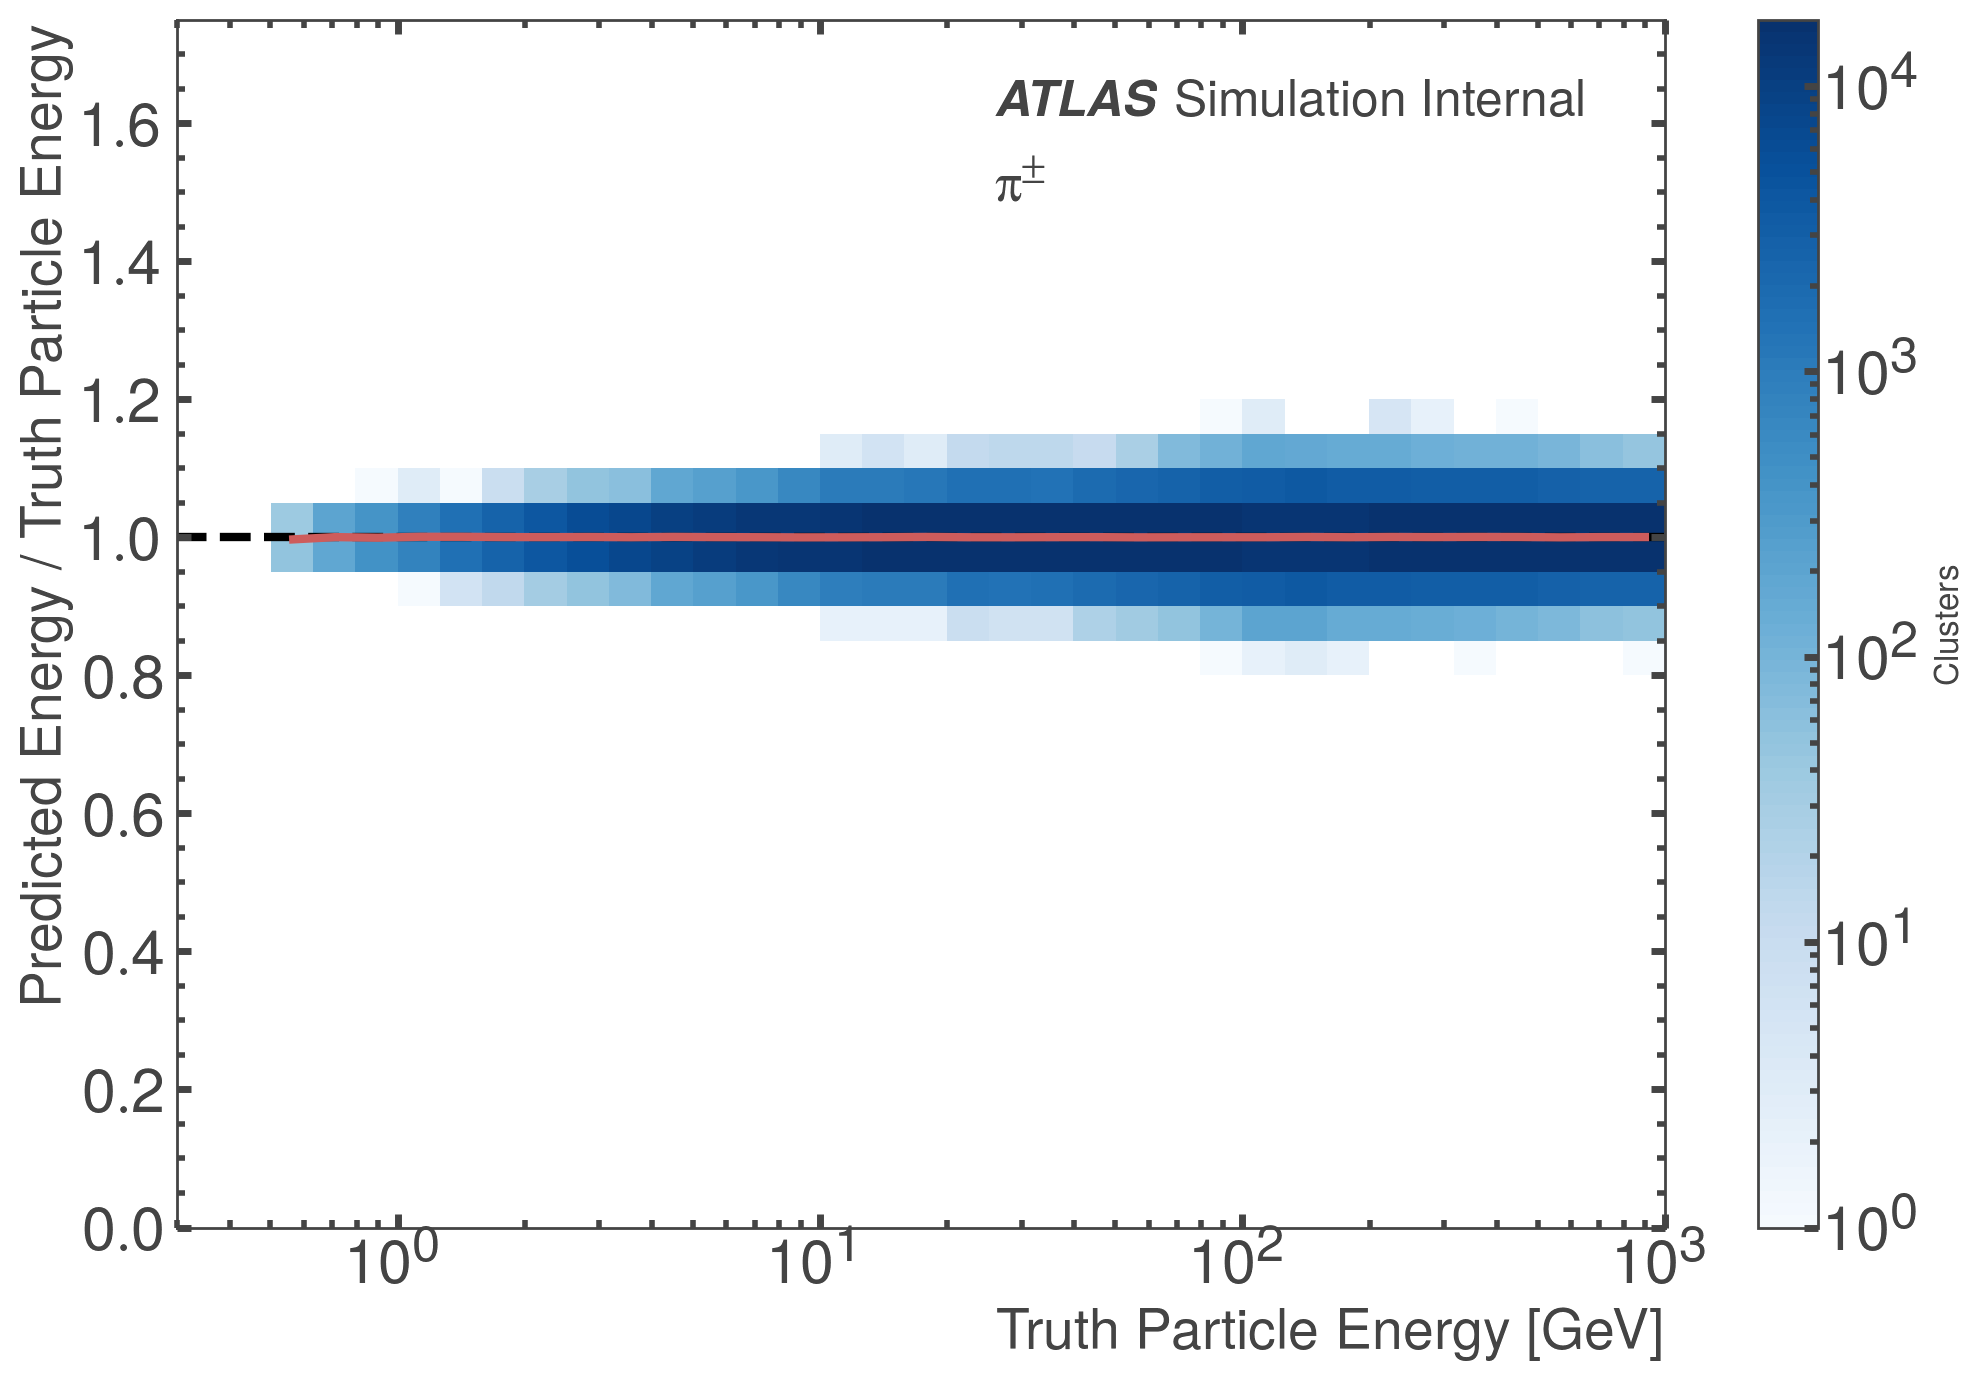

extra_line [[0, 10000.0], [1, 1]]
['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

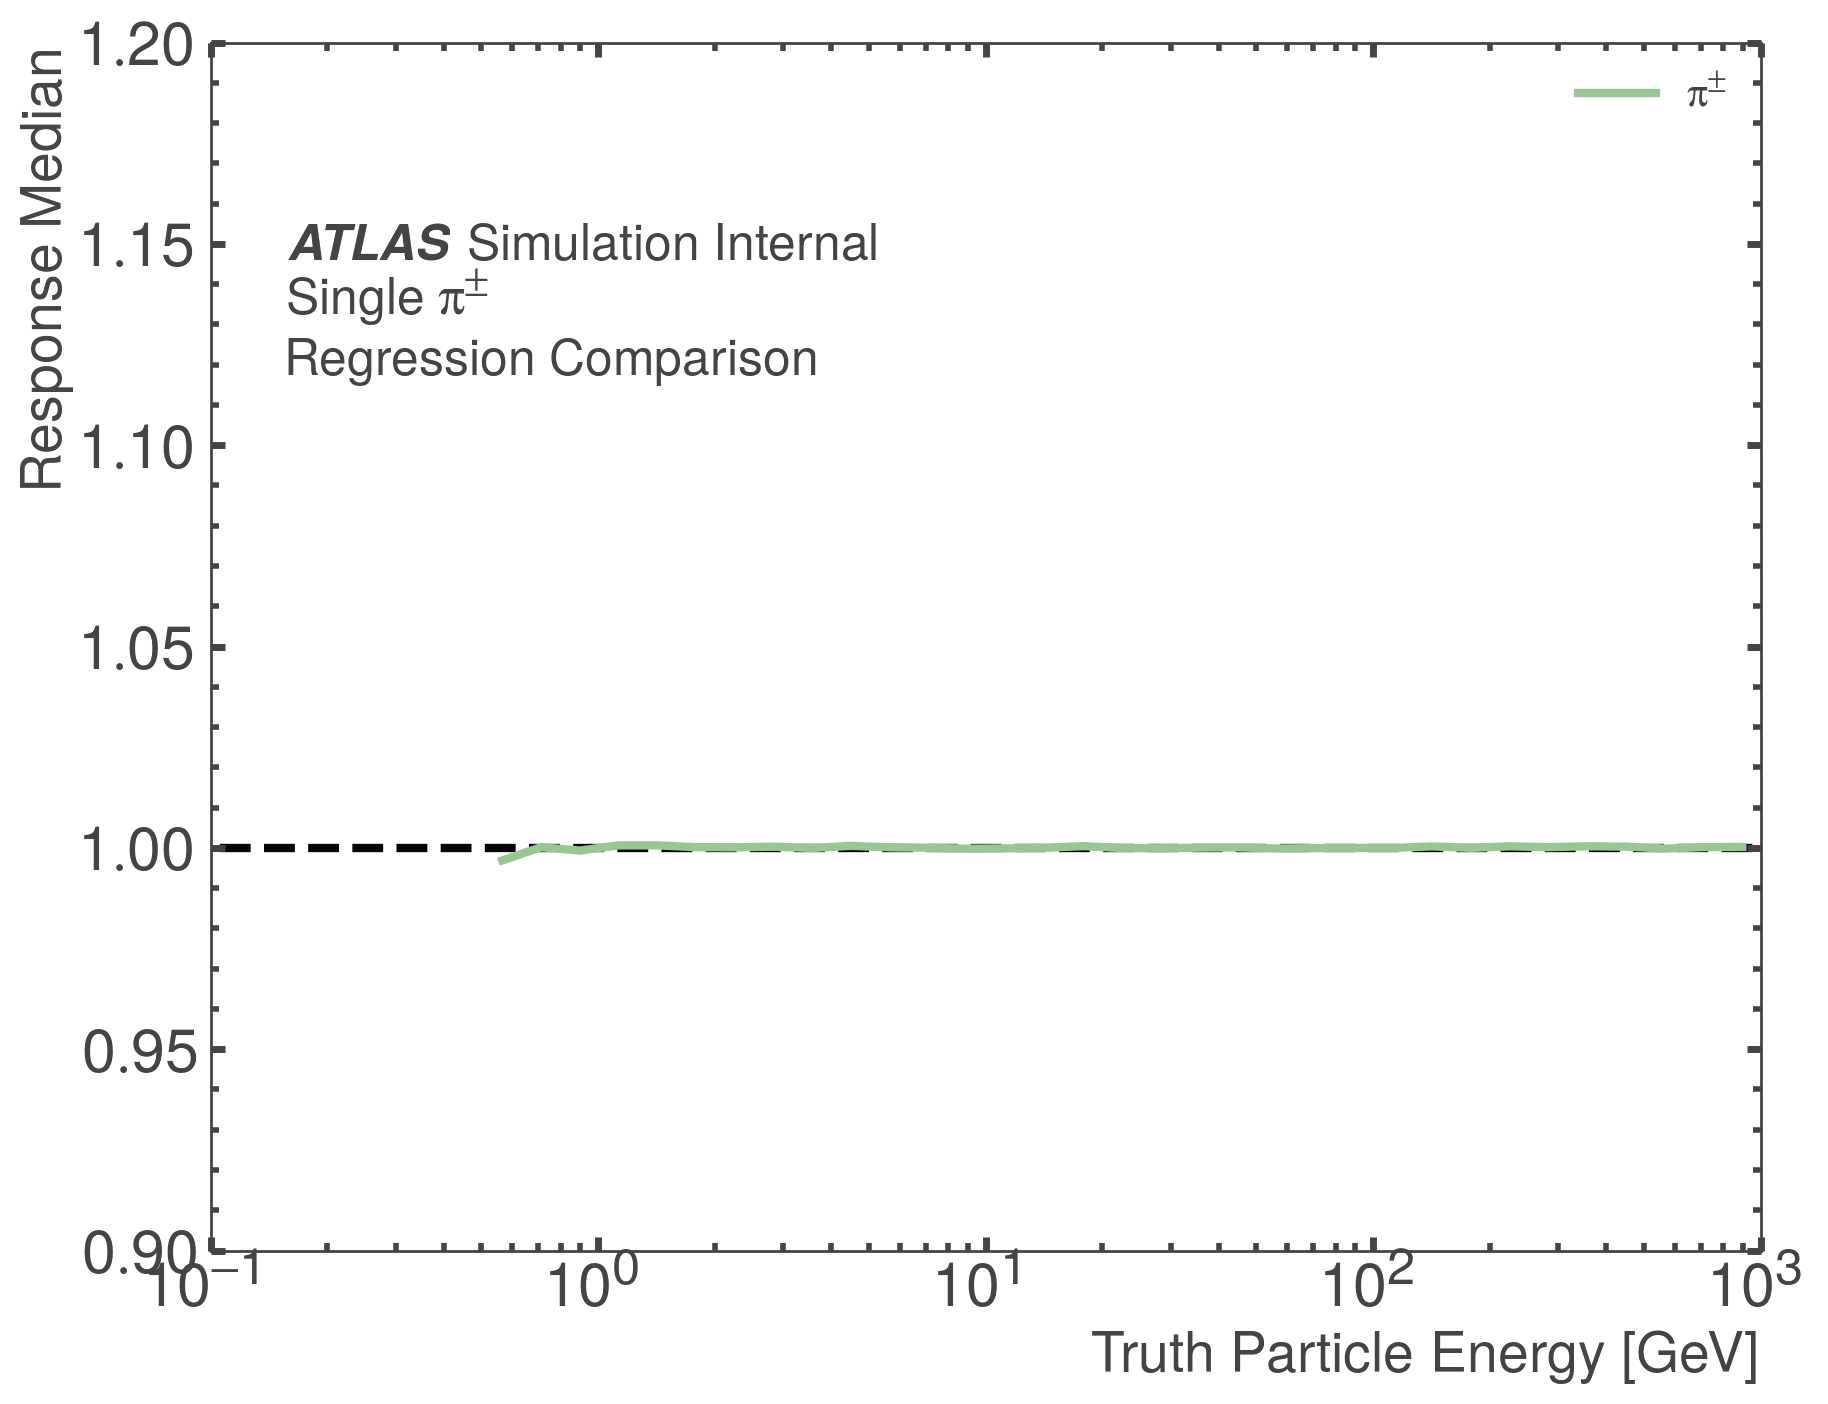


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

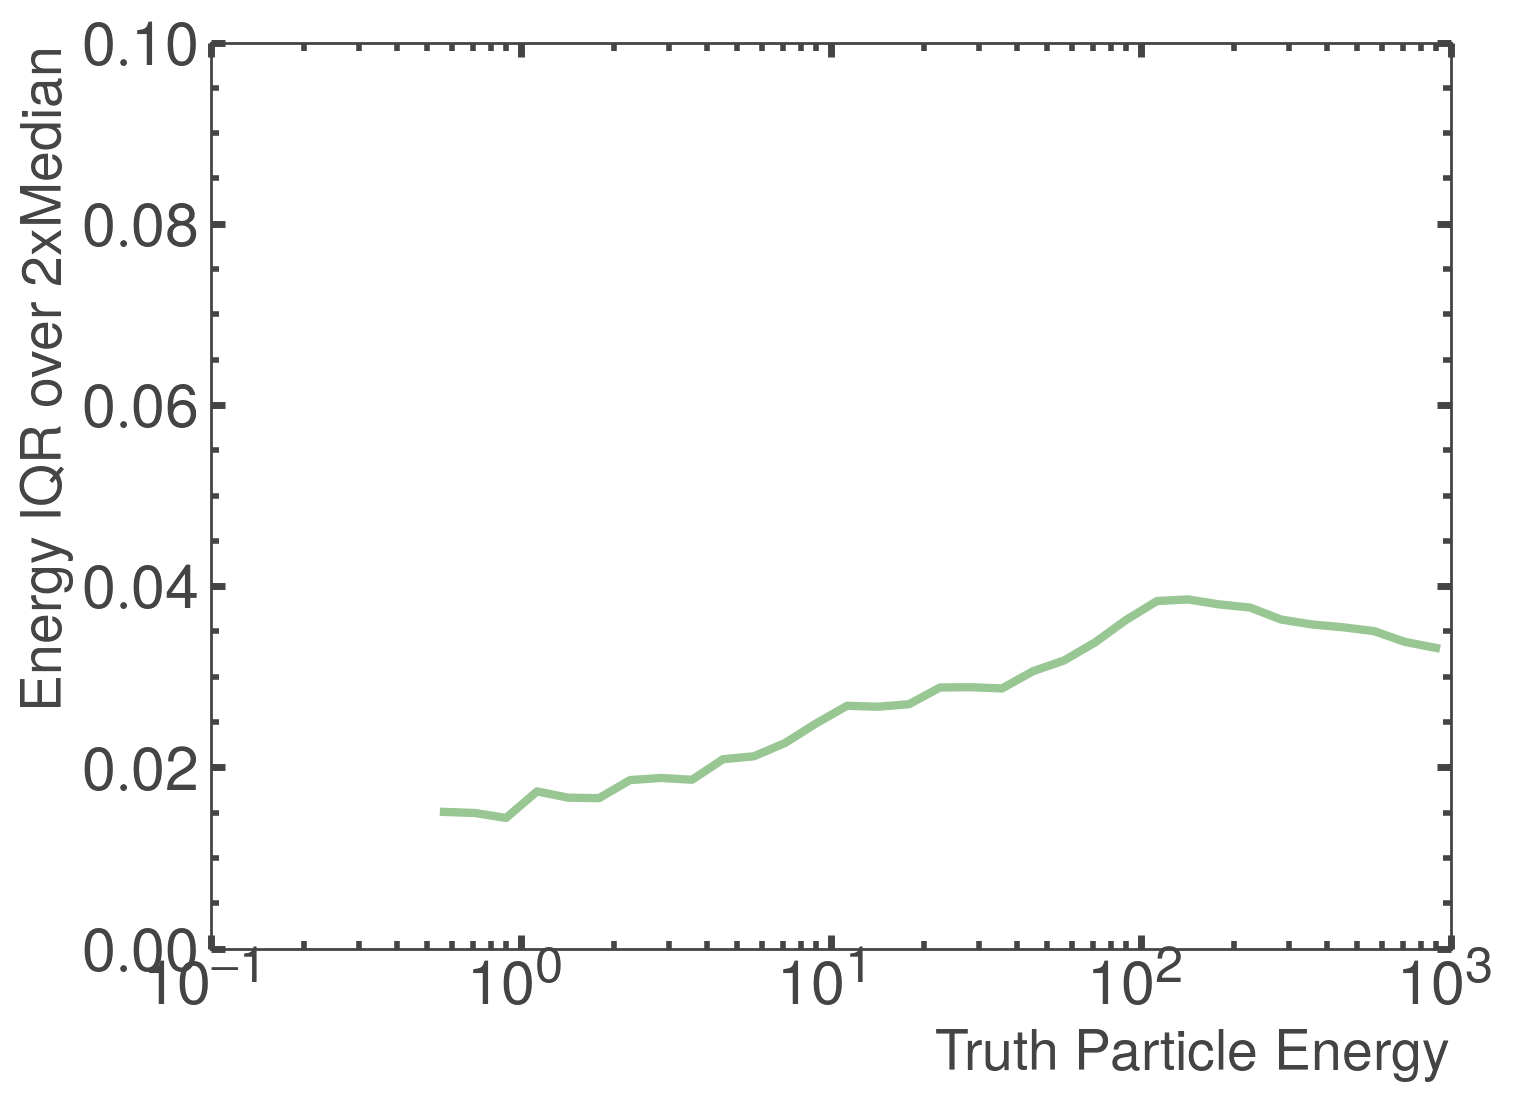

['on:green', 'on:red', 'on:blue', 'on:cyan', 'on:orange', 'on:pink', 'on:yellow']


/clusterfs/ml4hep/mpettee/ml4pions/gn4pions_eastbay/gn4pions/modules/plot_util.py:93: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(x_min, x_max)


<Figure size 1600x1200 with 0 Axes>

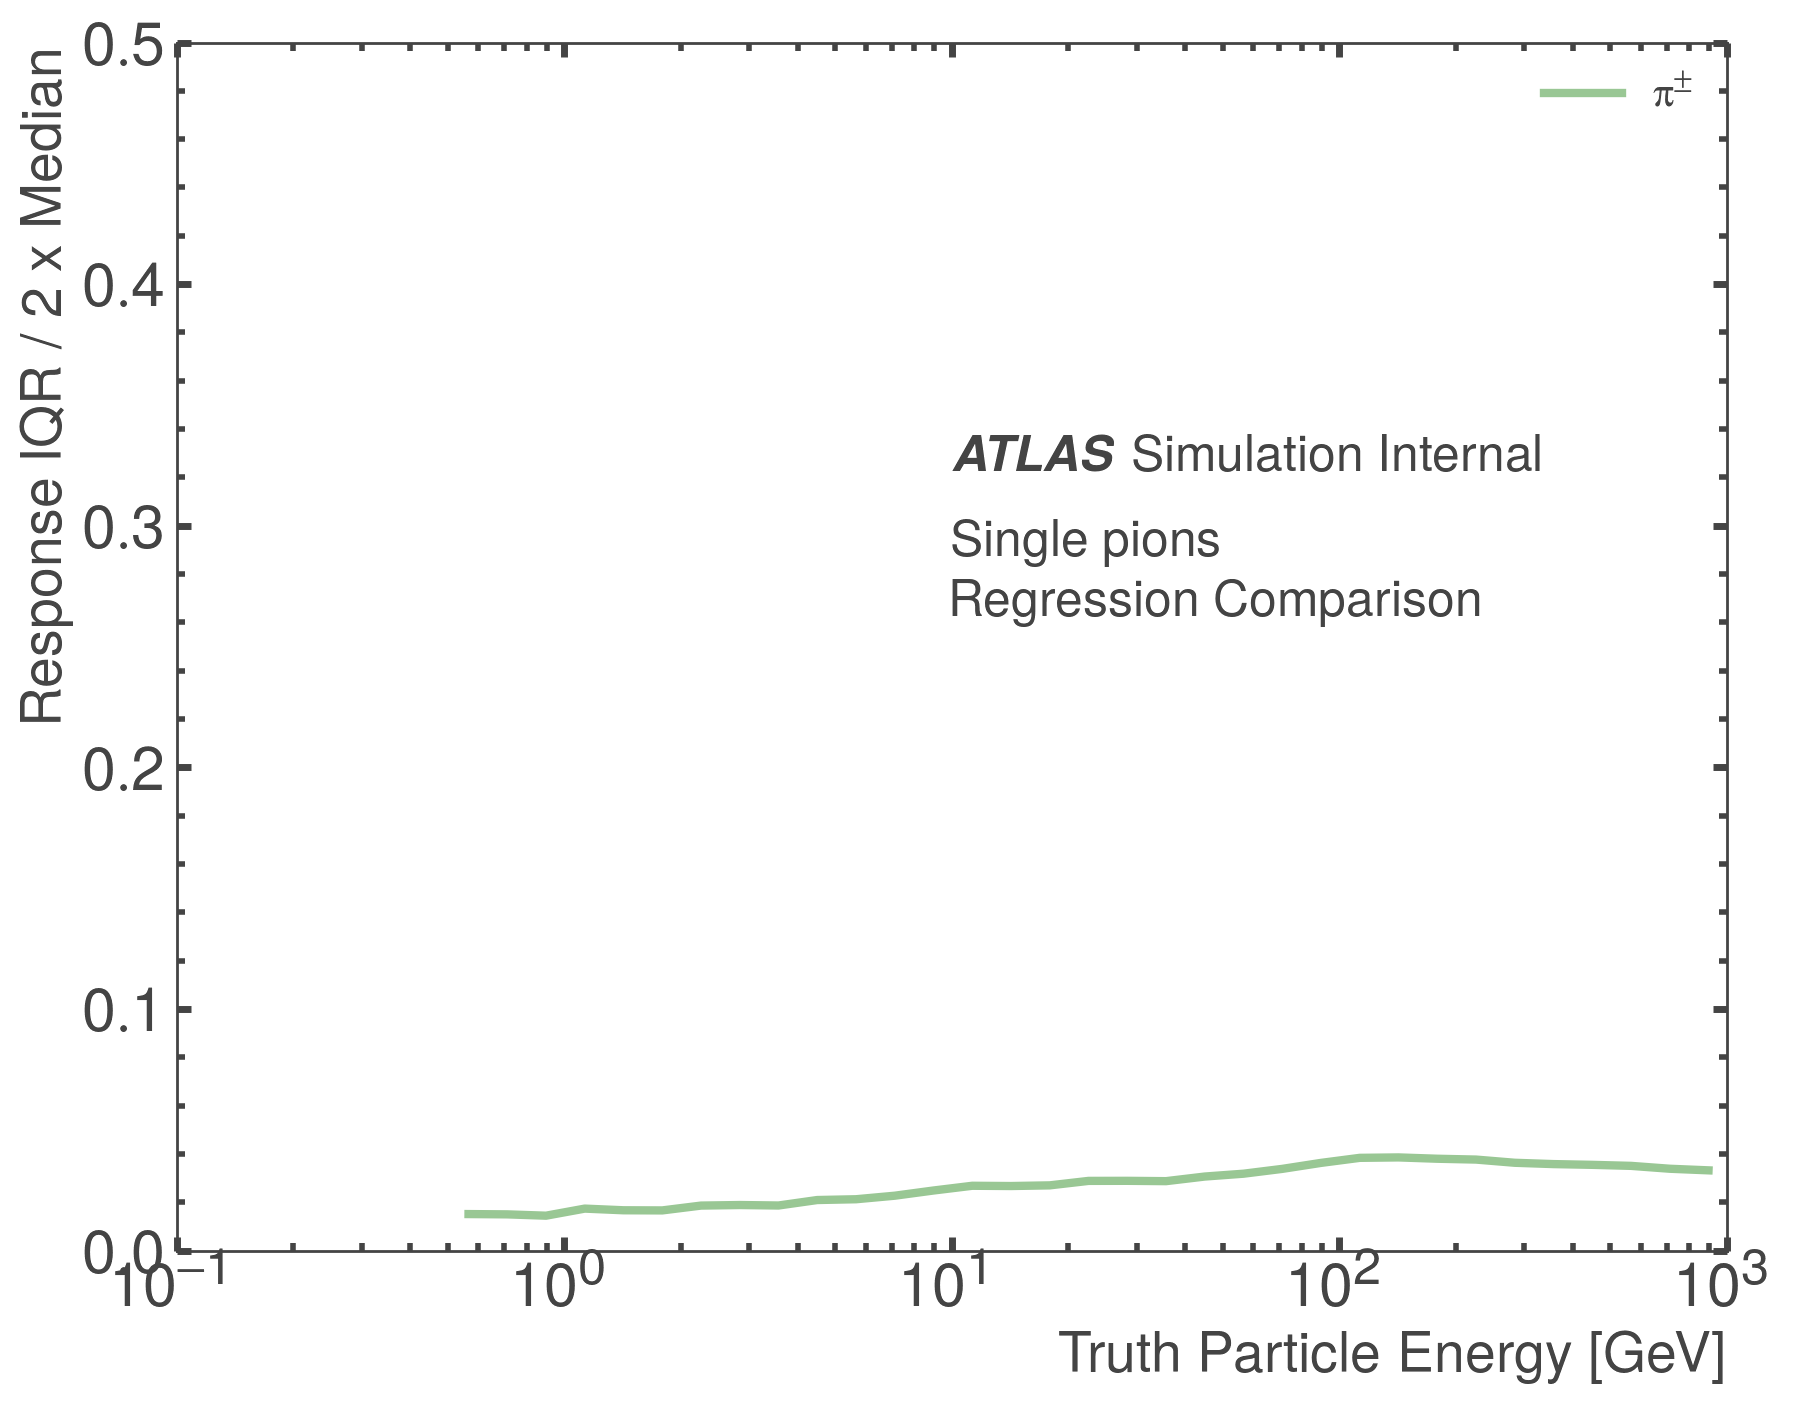

In [9]:
make_regression_plots(df_transformer, 
                      charged_pions_only = True,
                      label="transformer", 
#                       data_dir=data_dir,
                      data_dir='./pub_note_results',
                     )

# Recreate existing plots:

#### EM & LCW with tracks:

#### Cluster-only

In [ ]:
### GNN Cluster-only
## Use this file: pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining.npz'
make_regression_plots(df, label="gnn_clusteronly", data_dir='./pub_note_results')

#### Cluster-only median overlay:

In [ ]:
### All pions 
median_gnn = np.load('pub_note_results/response_medians_gnn_clusteronly.npz')
median_em =  np.load('pub_note_results/response_medians_clusteronly_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = median_gnn['xcenter']
median_2 = [
    median_em['response_median'][0,:],
    median_lcw['response_median'][0,:],
    median_gnn['response_median'][0,:],
      ]
labels=['EM', 'LCW', 'GNN',]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response Median',
#             figfile = 'pub_note_results/regress_response_medians_all_clusteronly.png',
            y_max=1.2, y_min=.95, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', 'solid', 'solid', 'solid'],
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0/\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters, |$\eta$| < 3'},])

In [ ]:
### Neutral pions 
median_gnn = np.load('pub_note_results/response_medians_gnn_clusteronly.npz')
median_em =  np.load('pub_note_results/response_medians_clusteronly_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = median_gnn['xcenter']
median_2 = [
    median_em['response_median'][1,:],
    median_lcw['response_median'][1,:],
    median_gnn['response_median'][1,:],
      ]
labels=['EM', 'LCW', 'GNN',]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response Median',
#             figfile = 'pub_note_results/regress_response_medians_pi0_clusteronly.png',
            y_max=1.2, y_min=.95, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', 'solid', 'solid', 'solid'],
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters, |$\eta$| < 3'},
                       ])

In [ ]:
### Charged pions 
median_gnn = np.load('pub_note_results/response_medians_gnn_clusteronly.npz')
median_pfn = np.load('pub_note_results/response_medians_pfn_clusteronly.npz')
median_em =  np.load('pub_note_results/response_medians_clusteronly_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = median_gnn['xcenter']
median_2 = [
    median_em['response_median'][2,:],
    median_lcw['response_median'][2,:],
    median_gnn['response_median'][2,:],
#     median_pfn['response_median'][0,:],
    savgol_filter(median_pfn['response_median'][0,:], 11, 1), # window size = 11, polynomial order 1
      ]
labels=['EM', 'LCW', 'GNN', 'DeepSets/PFN',]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response Median',
            figfile = 'pub_note_results/regress_response_medians_pipm_clusteronly.png',
            y_max=1.2, y_min=.9, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', '-.', 'solid', 'solid'],
            atlas_x = 0.45, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.5, 'text': 'Single $\pi^\pm$ MC Regression'},
                        {'x': 0.45, 'y': 0.45,  'text': 'Topo-clusters, |$\eta$| < 3'},
                       ])

#### Cluster-only IQR:

In [ ]:
### All pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_clusteronly_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

iqr_2 = [
    iqr_em['iqr'][0,:],
    iqr_lcw['iqr'][0,:],
    iqr_gnn['iqr'][0,:],
      ]

labels=['EM', 'LCW', 'GNN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','solid','solid','solid'],  
            atlas_x = 0.45, atlas_y = 0.7, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.6, 'text': 'Single $\pi^0/\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.55,  'text': 'Topo-clusters'},
                        {'x': 0.45, 'y': 0.5, 'text': '|$\eta$| < 3'}],
#               figfile='pub_note_results/regress_cluster_only_iqr_all.png'
              )

In [ ]:
### Neutral pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_clusteronly_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

iqr_2 = [
    iqr_em['iqr'][1,:],
    iqr_lcw['iqr'][1,:],
    iqr_gnn['iqr'][1,:],
      ]

labels=['EM', 'LCW', 'GNN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','solid','solid','solid'],  
            atlas_x = 0.4, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.4, 'y': 0.5, 'text': 'Single $\pi^{0}$ MC Regression'},
                        {'x': 0.4, 'y': 0.45,  'text': 'Topo-clusters'},
                       {'x': 0.4, 'y': 0.4, 'text': '|$\eta$| < 3'}],
              figfile='pub_note_results/regress_cluster_only_iqr_pi0.png'
              )

In [ ]:
### Charged pions 
iqr_gnn = np.load('pub_note_results/iqr_gnn_clusteronly.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn_clusteronly.npz')
iqr_em =  np.load('pub_note_results/iqr_clusteronly_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_clusteronly_lcw.npz')

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference

xcenter = iqr_gnn['xcenter']

### 3rd row is the charged pion for most of these
iqr_2 = [
    iqr_em['iqr'][2,:],
    iqr_lcw['iqr'][2,:],
    iqr_gnn['iqr'][2,:],
#     iqr_pfn['iqr'][0,:],
    savgol_filter(iqr_pfn['iqr'][0,:], 11, 1), # window size = 11, polynomial order 1
      ]

labels=['EM', 'LCW', 'GNN', 'DeepSets/PFN', ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2,  
            labels = labels,
            xlabel = 'True Cluster Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
            y_max = 0.5,  
               x_min = .3,
            linestyles = ['dashed','dashed','solid','-.','solid','solid'],  
            atlas_x = 0.45, atlas_y = 0.6, simulation = True,
            textlist = [{'x': 0.45, 'y': 0.5, 'text': 'Single $\pi^{\pm}$ MC Regression'},
                        {'x': 0.45, 'y': 0.45,  'text': 'Topo-clusters'},
                        {'x': 0.45, 'y': 0.4, 'text': '|$\eta$| < 3'}],
              figfile='pub_note_results/regress_cluster_only_iqr_pion.pdf'
              )

# New plots

#### Clusters + tracks

In [ ]:
glob.glob("results/onetrack_multicluster/piyush_june22/gnn_allcluster_cells/*")

In [ ]:
predictions = np.load("results/onetrack_multicluster/piyush_june22/gnn_allclusters_cells/inference_predictions.npz")
targets_regress = predictions['targets']
outputs_regress = predictions['outputs'][:,0]
df_gnn = pd.DataFrame(np.vstack([targets_regress, outputs_regress]).T, columns=['targets_regress', 'outputs_regress'])
make_regression_plots(df_gnn, charged_pions_only = True, label="gnn", data_dir='./pub_note_results',)

In [ ]:
make_regression_plots(df_transformer[df_transformer.targets_regress > 0.6], 
                      label="transformer_large", data_dir='./pub_note_results', 
                     charged_pions_only=True)

In [ ]:
# make_regression_plots(df, label="gnn", data_dir='./pub_note_results')

#### Clusters + tracks median overlay

In [ ]:
median_em =  np.load('pub_note_results/response_medians_em.npz')
median_lcw =  np.load('pub_note_results/response_medians_lcw.npz')
median_pfn = np.load('pub_note_results/response_medians_pfn.npz')
median_transformer = np.load('pub_note_results/response_medians_transformer.npz')
median_dnn = np.load('pub_note_results/response_medians_dnn.npz')
median_gnn = np.load('pub_note_results/response_medians_gnn.npz')
# median_gnn = np.load('pub_note_results/response_medians_gnn_piyush.npz') 

# Tracks
# y_true = df.truth_particle_pt*np.cosh(df.track_eta)
# y_pred = df.track_pt*np.cosh(df.track_eta)
# xcenter, median_track = make_response_plot(y_true, y_pred, y_pred/y_true, '$\pi^{\pm}$', )

xcenter = median_em['xcenter']

from scipy.signal import savgol_filter # for smoothing the PFN results due to stats difference


median_2 = [
    median_em['response_median'][0,:],
    median_lcw['response_median'][0,:],
    median_transformer['response_median'][0,:],
    median_pfn['response_median'][0,:], # window size = 11, polynomial order 1
    median_gnn['response_median'][0,:],
    median_dnn['response_median'],
#     median_track,
      ]

labels=[
    'EM', 'LCW', 
        'Transformer', 'DeepSets/PFN', 
        'GNN', 
        'DNN',
#         'Track', 
       ]

### Response medians 
pu.lineOverlay(xcenter=xcenter, lines=median_2,  
            labels=labels,
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
#             figfile = 'pub_note_results/regress_response_medians_all.png',
            y_max=1.5, y_min=.3, 
               x_min = .3, 
               colorgrouping=0,
            extra_lines= [[[0, 10e3], [1, 1]]],
            linestyles = ['dashed', 'dashed', 'solid', 'solid', 'solid', 'dashed', 'dashed',
                         ], # , 'dashed',],
            atlas_x = 0.05, atlas_y = 0.9, simulation = True,
            textlist = [{'x': 0.05, 'y': 0.82, 'text': 'Single $pions$'},
                        {'x': 0.05, 'y': 0.77,  'text': 'Regression Comparison'}])

#### Cluster + track IQR overlay

In [ ]:
iqr_em =  np.load('pub_note_results/iqr_em.npz')
iqr_lcw =  np.load('pub_note_results/iqr_lcw.npz')
iqr_transformer = np.load('pub_note_results/iqr_transformer.npz')
iqr_pfn = np.load('pub_note_results/iqr_pfn.npz')
iqr_gnn = np.load('pub_note_results/iqr_gnn.npz')
iqr_dnn = np.load('pub_note_results/iqr_dnn.npz')
iqr_track = np.load('pub_note_results/iqr_track.npz')

# xcenter, iqr_track = ru.resolutionPlot(df.truth_particle_e, 
#                                        (10**df.track_pt)*np.cosh(df.track_eta)/df.truth_particle_e,
#                                        statistic='iqrOverMed')

xcenter = iqr_gnn['xcenter']
iqr_2 = [
    iqr_em['iqr'][0,:], # use 2 for default df_em_lcw files
    iqr_lcw['iqr'][0,:], # use 2 for default df_em_lcw files
    iqr_transformer['iqr'][0,:],
    iqr_pfn['iqr'][0,:],
    iqr_gnn['iqr'][0,:],
    iqr_dnn['iqr'],
    iqr_track['iqr'],
      ]

labels=[
    'EM Calib', 
        'LCW Calib', 
        'Transformer', 
        'DeepSets/PFN', 
        'GNN', 
        'DNN',
        'Track Resolution',
       ]

pu.lineOverlay(xcenter=xcenter, lines = iqr_2, 
            labels = labels,
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 0.5,  # default = 0.5
               x_min = .3,
            linestyles = [
                'dashed','dashed',
                          'solid','solid','solid',
#                 'solid',
#                 'solid','solid',
                'dashed','dotted'
            ],  
            atlas_x = 0.1, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.1, 'y': 0.4, 'text': 'Single $\pi^{\pm}$'},
                        {'x': 0.1, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile='pub_note_results/regress_all_iqr.png'
              )